In [6]:
import os
import pandas as pd
import numpy as np
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import copy
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import joblib
import optuna
from tqdm import tqdm
import time
import codecs
import pickle

# Configuration

In [7]:
rawdata_dir = 'rawdata'
data_dir = 'data'

# lags = [1,2,3,6,12,24,36]
lags = [28, 35, 42, 49, 56]

# NUM_FOLD_DAYS = 28
NUM_FOLD_DAYS = 56
VALID_FIRST_DAY = 1914
VALID_LAST_DAY = 1941
NUM_USE_DAY = 365
# TRAIN_FIRST_DAY = max(lags)
TRAIN_FIRST_DAY = VALID_FIRST_DAY - NUM_USE_DAY + 1

OPTUNA_TRIAL = 70

# Read data

In [8]:
sales = pd.read_csv(os.path.join(rawdata_dir, 'sales_train_evaluation.csv'))
sales.name = 'sales'
calendar = pd.read_csv(os.path.join(rawdata_dir, 'calendar.csv'))
calendar.name = 'calendar'
prices = pd.read_csv(os.path.join(rawdata_dir, 'sell_prices.csv'))
prices.name = 'prices'

Since, the validation data is now available for the days 1914-1941, Adding zero sales for days: d_1942 - d_1969(Test)

In [9]:
#Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

# Downcast

In [10]:
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

# Melt data

In [11]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

## Combine data
Combine price data from prices dataframe and days data from calendar dataset.

In [12]:
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left')

# Feature Engineering

## Label Encoding

In [13]:
#Store the categories along with their codes
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

In [14]:
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes
        
df.drop('date',axis=1,inplace=True)

## Introduce lags

In [15]:
#Introduce lags
def make_lags(df, lags):
    for lag in lags:
        df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)
        
    return df

In [16]:
df = make_lags(df, lags)

In [23]:
valid_mask = (df["d"] >= 1914)&(df["d"] <= 1941)
valid_df = df[valid_mask]

evalu_mask = (df["d"] > 1941)
evalu_df = df[evalu_mask]

train_df = df[(df["d"] < 1914)]

In [26]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price', 'sold_lag_28', 'sold_lag_35', 'sold_lag_42',
       'sold_lag_49', 'sold_lag_56'],
      dtype='object')

## make new features

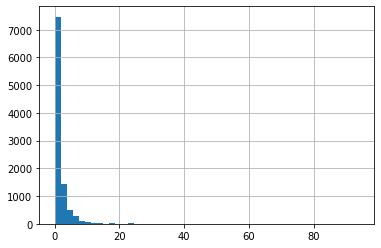

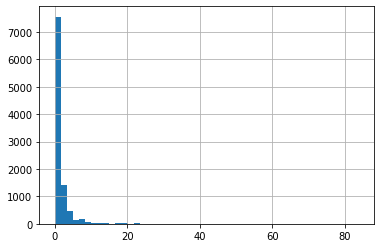

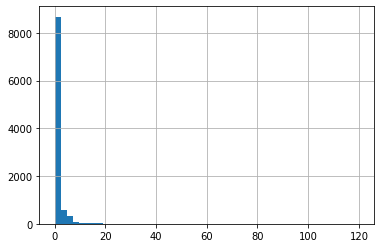

In [25]:
col = "sold_lag_28"
evalu_df[col].sample(n=10000).hist(bins=50)
plt.show()

valid_df[col].sample(n=10000).hist(bins=50)
plt.show()


train_df[col].sample(n=10000).hist(bins=50)
plt.show()

In [27]:
def make_new_feature(df, d_last = df['d'].max()):
    # copy sold
    sold_tmp = copy.copy(df['sold'])
    
    # embed NaN
    df['sold'][df['d'] > d_last] = np.nan
    
    # make feature using sold
    df['item_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
    df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
    df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
    df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
    df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
    df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
    df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
    df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
    df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
    df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
    df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
    df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
    
    df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)
    df['expanding_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)
    
    df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
    df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
    df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
    df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)
    
    # restore sold
    df['sold'] = sold_tmp
    
    return df

In [28]:
df_all = copy.copy(df)
df_all = make_new_feature(df_all)
df_all = df_all[df_all['d'] >= max(lags)]
df_all.info()

# df_all.to_pickle(os.path.join(data_dir, 'data_all.pkl'))   # save df_all (use this after CV)
df_all.to_pickle(os.path.join(data_dir, 'data_all_lagOlder28.pkl'))   # save df_all (use this after CV)
del df_all
gc.collect()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58357860 entries, 1676950 to 60034809
Data columns (total 41 columns):
id                          int16
item_id                     int16
dept_id                     int8
cat_id                      int8
store_id                    int8
state_id                    int8
d                           int16
sold                        int16
wm_yr_wk                    int16
weekday                     int8
wday                        int8
month                       int8
year                        int16
event_name_1                int8
event_type_1                int8
event_name_2                int8
event_type_2                int8
snap_CA                     int8
snap_TX                     int8
snap_WI                     int8
sell_price                  float16
sold_lag_28                 float16
sold_lag_35                 float16
sold_lag_42                 float16
sold_lag_49                 float16
sold_lag_56                 float

0

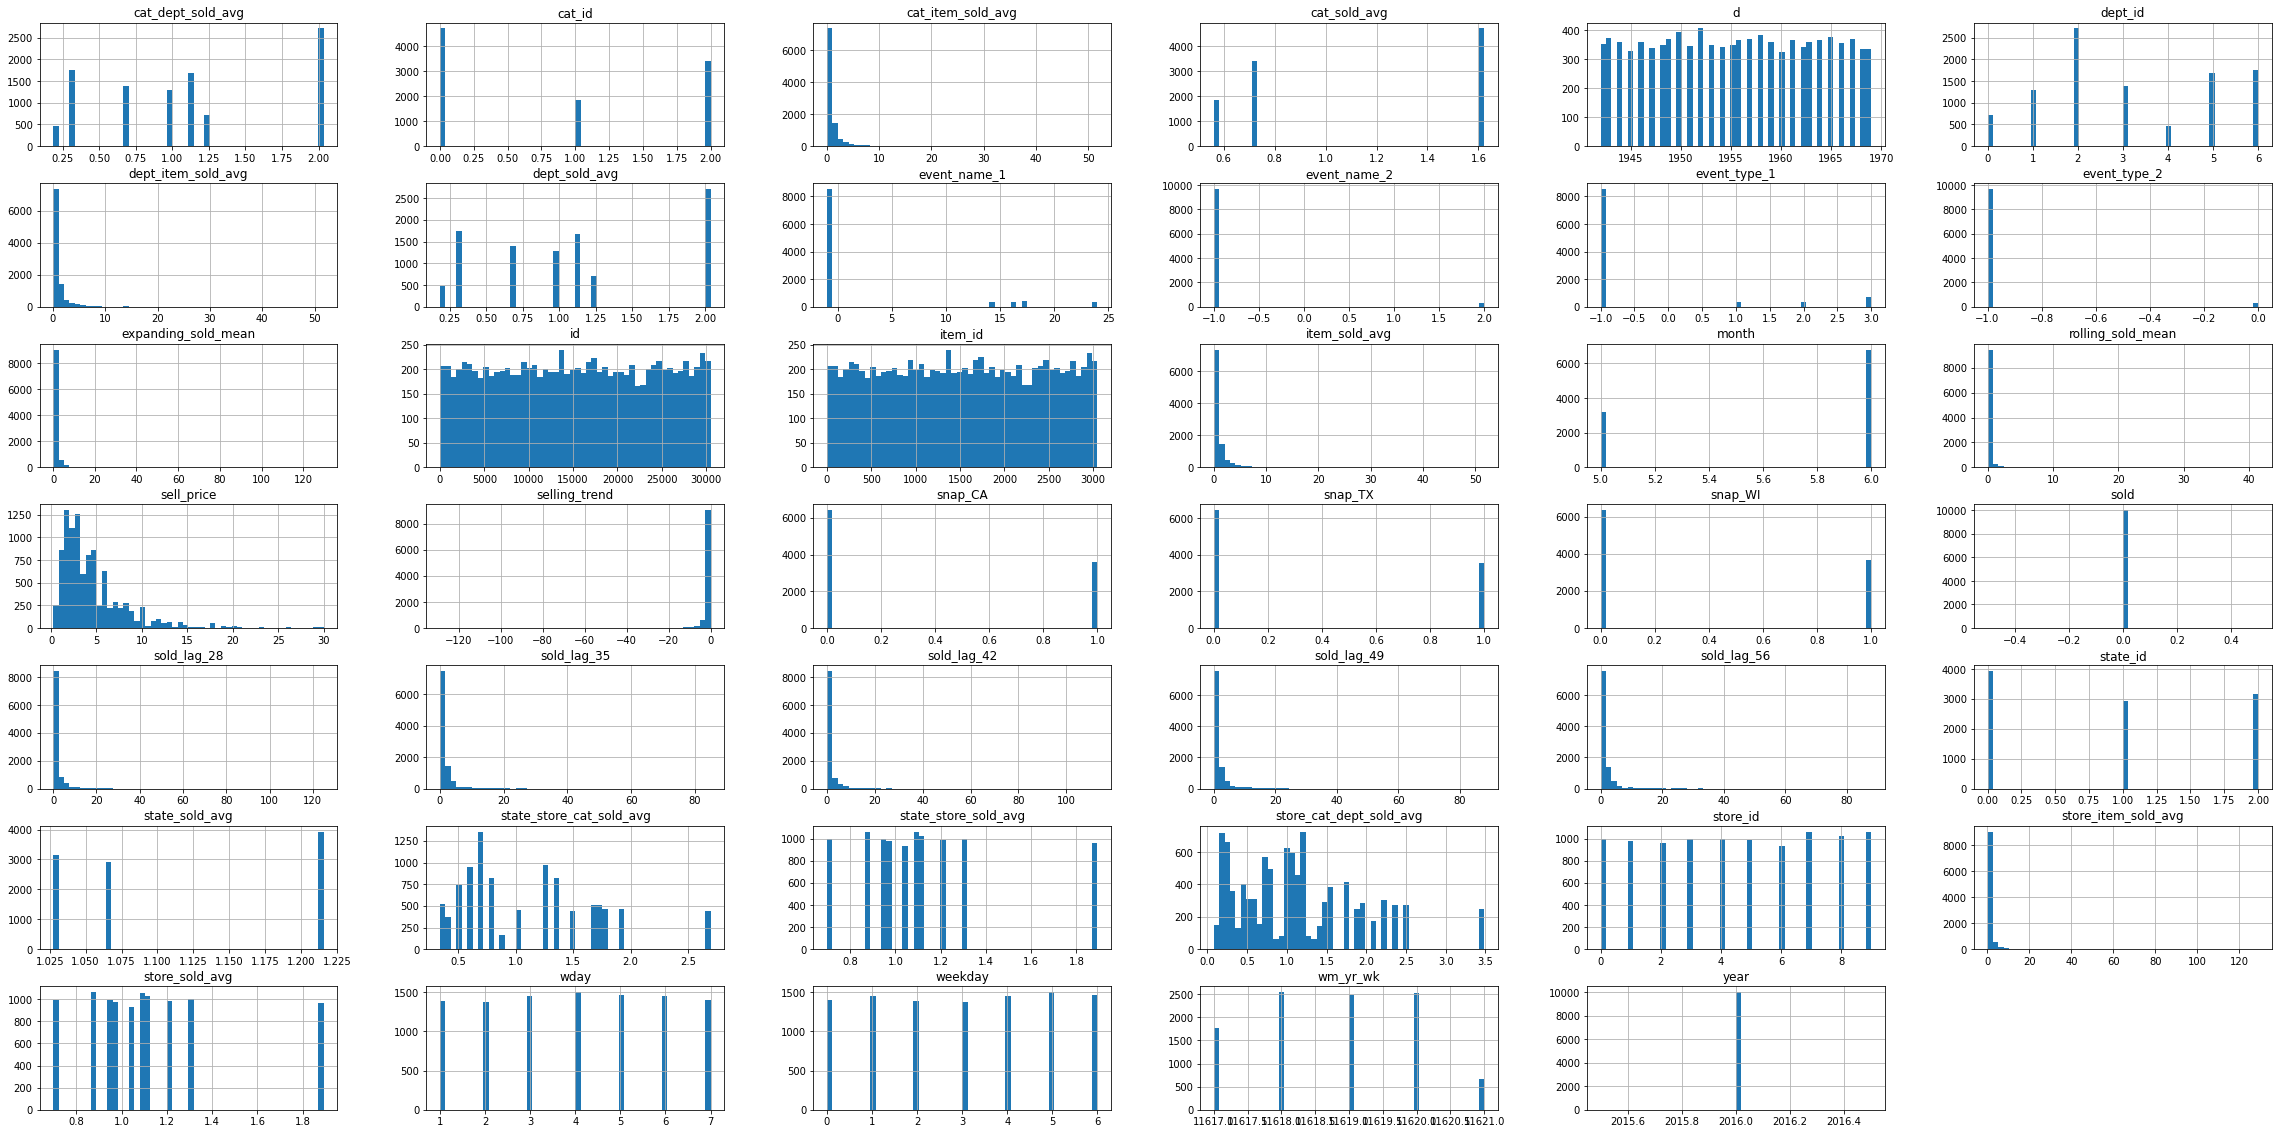

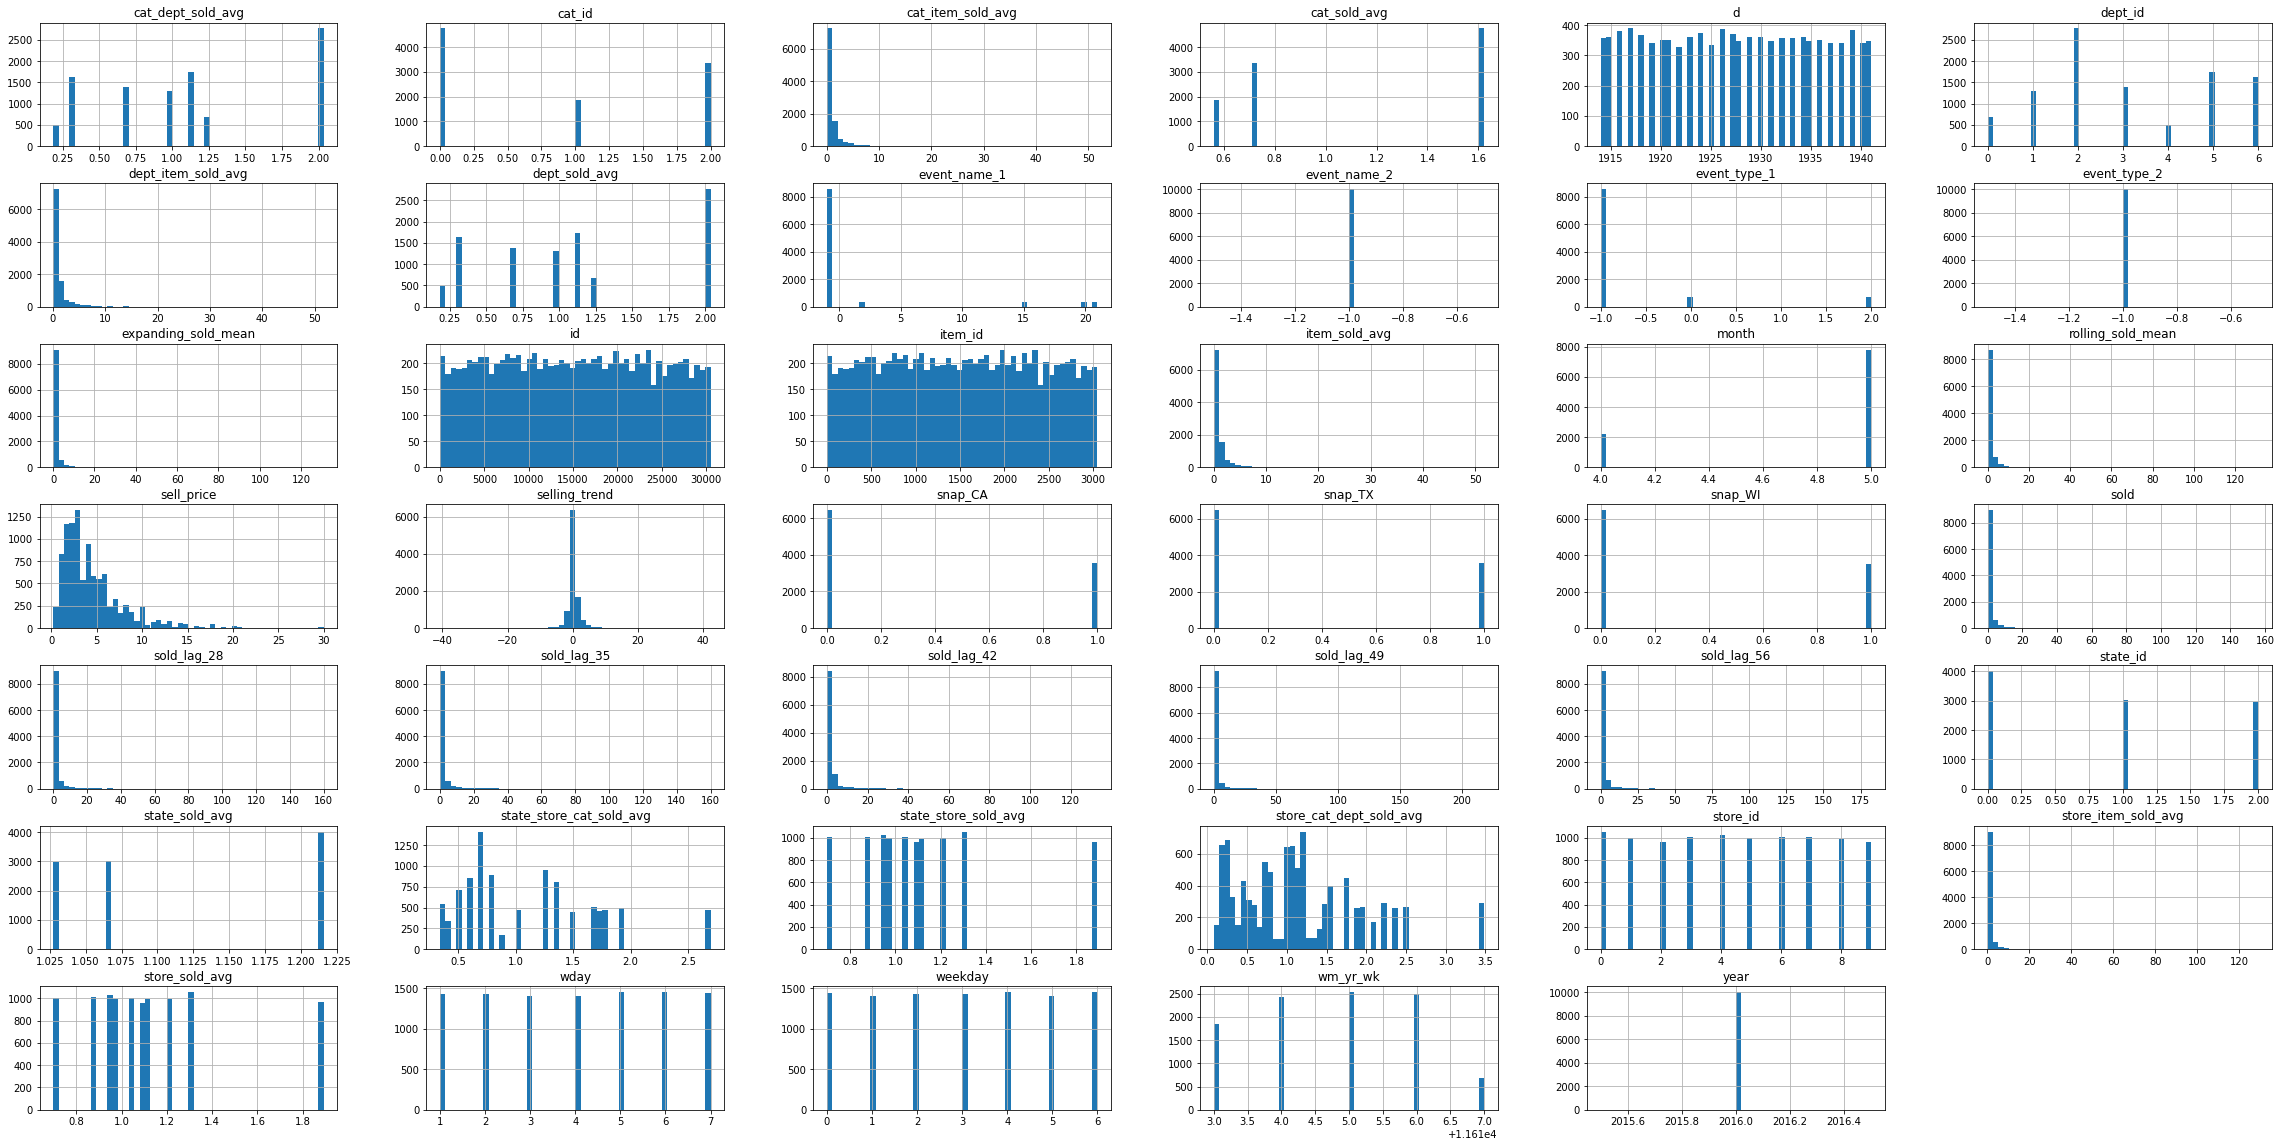

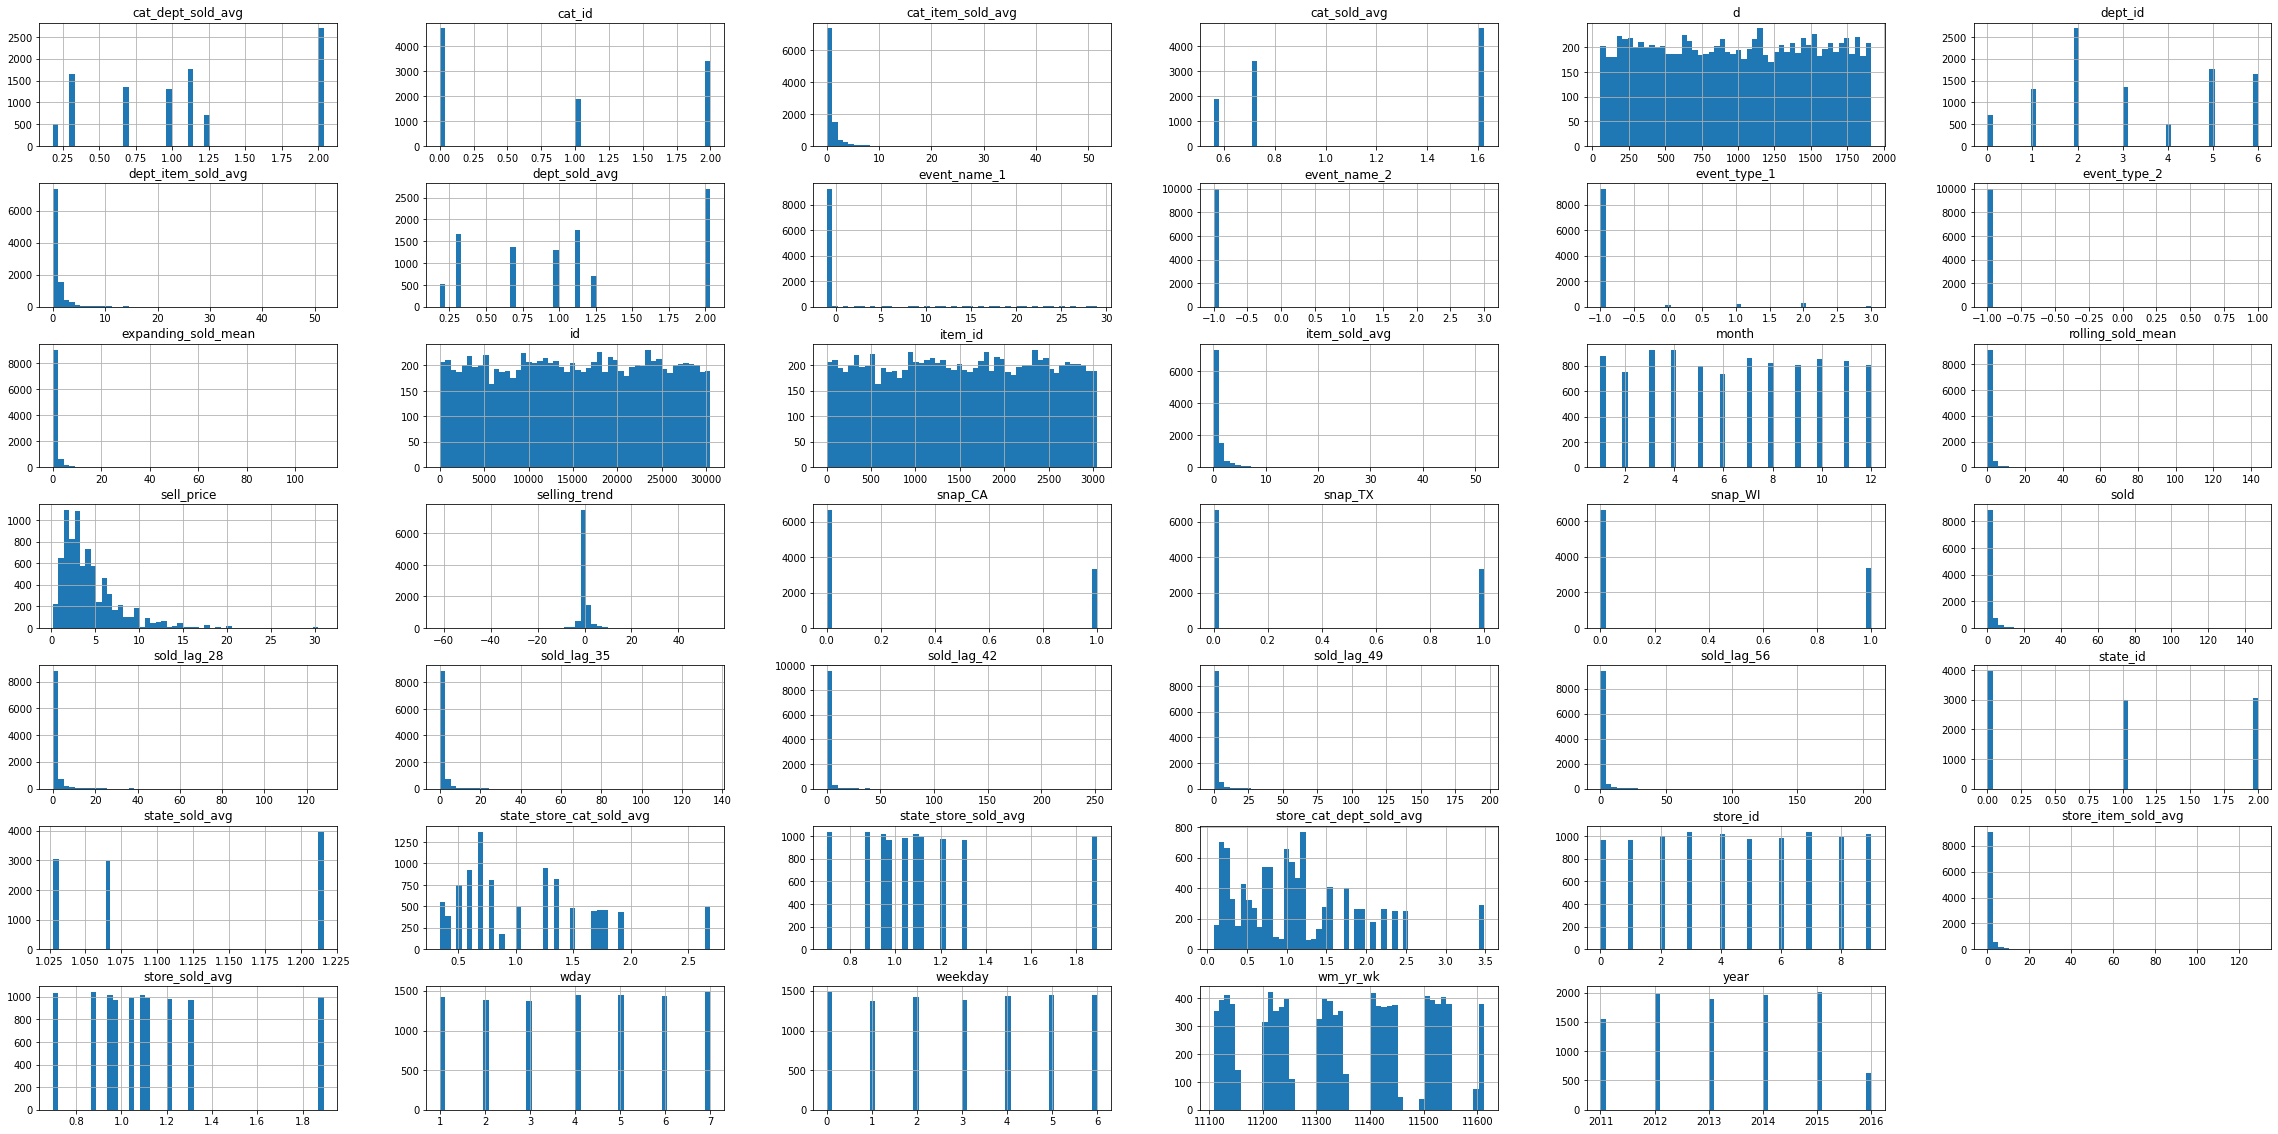

In [37]:
#df_all = pd.read_pickle(os.path.join(data_dir, 'data_all_lagOlder28.pkl')) 

valid_mask = (df_all["d"] >= 1914)&(df_all["d"] <= 1941)
valid_df = df_all[valid_mask]

evalu_mask = (df_all["d"] > 1941)
evalu_df = df_all[evalu_mask]

train_df = df_all[(df_all["d"] < 1914)]


col = "dept_item_sold_avg"
fig = plt.figure(figsize=(40,20))
ax = fig.add_subplot(1,1,1)
evalu_df.sample(n=10000).hist(bins=50,ax=ax)
plt.show()

fig = plt.figure(figsize=(40,20))
ax = fig.add_subplot(1,1,1)
valid_df.sample(n=10000).hist(bins=50,ax=ax)
plt.show()

fig = plt.figure(figsize=(40,20))
ax = fig.add_subplot(1,1,1)
train_df.sample(n=10000).hist(bins=50,ax=ax)
plt.show()

# Cross Validation

## Cross Validation for each store (function)

In [14]:
def xgboost_cv_store(df, store):
    def objective(trial):
        # param space
        param = {
            'objective': 'reg:squarederror',
            'n_estimators': 1000,
            'learning_rate': 0.1,
            'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 0.95, 0.05),
            'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.6, 0.95, 0.05),
            'max_depth':  trial.suggest_int('max_depth', 3, 9),
            'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
            'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.1, 10.0),
            'tree_method': 'gpu_hist'
        }
        
        ### START: CV Loop ###
        isBreakCV = False
        fold_iter = 0
        rmse_mean = 0.
        while not(isBreakCV):
            start = time.time()   # start timer
            
            d_valid_last = VALID_LAST_DAY - NUM_FOLD_DAYS * fold_iter
            d_train_last = VALID_LAST_DAY - NUM_FOLD_DAYS * (fold_iter + 1)
            if d_train_last < TRAIN_FIRST_DAY + NUM_FOLD_DAYS * 2:
                isBreakCV = True
            
            # make_new_feature
#             df_fold_file = os.path.join(data_dir, 'data_foldday'+str(NUM_FOLD_DAYS)+'_fold'+str(fold_iter + 1)+'.pkl')
            df_fold_file = os.path.join(data_dir, 'data_foldday'+str(NUM_FOLD_DAYS)+'_fold'+str(fold_iter + 1)+'_lagOlder28.pkl')
            
            if os.path.isfile(df_fold_file):   # make_new_feature 適用後のファイルがあればそれを使う
                df_fold = pd.read_pickle(df_fold_file)
            else:
                df_fold = df[df['d'] <= d_valid_last]
                df_fold = make_new_feature(df_fold, d_train_last)   # train の情報だけを使って特徴量を作成
                df_fold.to_pickle(df_fold_file)   # pickleとして保存しておく

            # Extract store
            df_fold = df_fold[df_fold['store_id'] == store]
                        
            # Split data
            X_train = df_fold[(df_fold['d'] >= TRAIN_FIRST_DAY) & (df_fold['d'] <= d_train_last)].drop('sold', axis=1)
            y_train = df_fold[(df_fold['d'] >= TRAIN_FIRST_DAY) & (df_fold['d'] <= d_train_last)]['sold']
            X_valid = df_fold[(df_fold['d'] > d_train_last) & (df_fold['d'] <= d_valid_last)].drop('sold', axis=1)
            y_valid = df_fold[(df_fold['d'] > d_train_last) & (df_fold['d'] <= d_valid_last)]['sold']
            
            # Train XGBoost model
            model = xgb.XGBRegressor(**param)
#             model.fit(X_train, y_train, eval_set=[(X_train,y_train), (X_valid, y_valid)],
#                  eval_metric='rmse', verbose=10, early_stopping_rounds=100)
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
                  eval_metric='rmse', verbose=10, early_stopping_rounds=50)
            y_pred = model.predict(X_valid)
            rmse_mean += np.sqrt(mean_squared_error(y_valid.values, y_pred))
            
            fold_iter += 1
            elapsed_time = time.time() - start   # stop timer
            print("[{0}] Fold{1}: {2} [sec]".format(d_store_id[store], fold_iter, elapsed_time))
        ### END: CV Loop ###
        
        del df_fold, model, X_train, y_train, X_valid, y_valid, y_pred
        gc.collect()
        
        rmse_mean /= fold_iter
        return rmse_mean
    return objective


## Execute CV

In [15]:
stores = sales.store_id.cat.codes.unique().tolist()

# find best params by doing CV (optuna)
for store in tqdm(stores[:6]):
    print('##################### CV START: {0} #####################'.format(d_store_id[store]))
    study = optuna.create_study()
    study.optimize(xgboost_cv_store(df, store), n_trials=OPTUNA_TRIAL)
    
    # save optuna log
    df_trial = study.trials_dataframe()
#     df_trial.to_pickle(os.path.join('report', 'OptunaTrials_'+d_store_id[store]+'_foldday'+str(NUM_FOLD_DAYS)+'_useday'+str(NUM_USE_DAY)+'.pkl'))
    df_trial.to_pickle(os.path.join('report', 'OptunaTrials_'+d_store_id[store]+'_foldday'+str(NUM_FOLD_DAYS)+'_useday'+str(NUM_USE_DAY)+'_lagOlder28.pkl'))
    
    del df_trial
    gc.collect()
    
    # savae best params found by CV
#     bestparam_filename = 'BestParamsSelectedByCV_'+d_store_id[store]+'_foldday'+str(NUM_FOLD_DAYS)+'_useday'+str(NUM_USE_DAY)+'.pkl'
    bestparam_filename = 'BestParamsSelectedByCV_'+d_store_id[store]+'_foldday'+str(NUM_FOLD_DAYS)+'_useday'+str(NUM_USE_DAY)+'_lagOlder28.pkl'
    with open(os.path.join('result', 'best_param_cv', bestparam_filename), 'wb') as f:
        pickle.dump(study.best_params, f)


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

##################### CV START: CA_1 #####################
[0]	validation_0-rmse:3.55907
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.06345
[20]	validation_0-rmse:2.95139
[30]	validation_0-rmse:2.82877
[40]	validation_0-rmse:2.80327
[50]	validation_0-rmse:2.76787
[60]	validation_0-rmse:2.75769
[70]	validation_0-rmse:2.73857
[80]	validation_0-rmse:2.73253
[90]	validation_0-rmse:2.73577
[100]	validation_0-rmse:2.73576
[110]	validation_0-rmse:2.72599
[120]	validation_0-rmse:2.72274
[130]	validation_0-rmse:2.72144
[140]	validation_0-rmse:2.71928
[150]	validation_0-rmse:2.71385
[160]	validation_0-rmse:2.73406
[170]	validation_0-rmse:2.73506
[180]	validation_0-rmse:2.73240
[190]	validation_0-rmse:2.72010
[200]	validation_0-rmse:2.72092
Stopping. Best iteration:
[150]	validation_0-rmse:2.71385

[CA_1] Fold1: 223.40014052391052 [sec]
[0]	validation_0-rmse:3.46679
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse

[I 2020-06-29 01:11:30,174] Finished trial#0 with value: 2.7379889488220215 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.8, 'max_depth': 6, 'gamma': 0.00022077269687625656, 'min_child_weight': 0.3704085379205699}. Best is trial#0 with value: 2.7379889488220215.


[0]	validation_0-rmse:3.63049
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.31574
[20]	validation_0-rmse:3.20507
[30]	validation_0-rmse:3.12518
[40]	validation_0-rmse:3.13984
[50]	validation_0-rmse:3.11047
[60]	validation_0-rmse:3.07117
[70]	validation_0-rmse:3.03614
[80]	validation_0-rmse:3.01286
[90]	validation_0-rmse:2.98363
[100]	validation_0-rmse:2.96482
[110]	validation_0-rmse:2.95683
[120]	validation_0-rmse:2.94658
[130]	validation_0-rmse:2.93486
[140]	validation_0-rmse:2.92348
[150]	validation_0-rmse:2.91260
[160]	validation_0-rmse:2.89981
[170]	validation_0-rmse:2.88931
[180]	validation_0-rmse:2.88282
[190]	validation_0-rmse:2.87956
[200]	validation_0-rmse:2.87575
[210]	validation_0-rmse:2.87293
[220]	validation_0-rmse:2.87017
[230]	validation_0-rmse:2.86205
[240]	validation_0-rmse:2.85753
[250]	validation_0-rmse:2.85515
[260]	validation_0-rmse:2.85180
[270]	validation_0-rmse:2.84863
[280]	validation_0-rmse:2.84751
[290]	validation_0

[I 2020-06-29 01:12:34,207] Finished trial#1 with value: 2.8419509887695313 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.85, 'max_depth': 3, 'gamma': 0.00022872717567308434, 'min_child_weight': 0.2787791830573246}. Best is trial#0 with value: 2.7379889488220215.


[0]	validation_0-rmse:3.48232
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.89670
[20]	validation_0-rmse:2.74592
[30]	validation_0-rmse:2.68671
[40]	validation_0-rmse:2.67542
[50]	validation_0-rmse:2.65263
[60]	validation_0-rmse:2.65310
[70]	validation_0-rmse:2.65968
[80]	validation_0-rmse:2.66191
[90]	validation_0-rmse:2.65654
[100]	validation_0-rmse:2.65932
Stopping. Best iteration:
[56]	validation_0-rmse:2.65023

[CA_1] Fold1: 10.504072904586792 [sec]
[0]	validation_0-rmse:3.40520
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.78501
[20]	validation_0-rmse:2.66958
[30]	validation_0-rmse:2.62562
[40]	validation_0-rmse:2.60799
[50]	validation_0-rmse:2.59924
[60]	validation_0-rmse:2.58957
[70]	validation_0-rmse:2.59947
[80]	validation_0-rmse:2.60151
[90]	validation_0-rmse:2.60319
[100]	validation_0-rmse:2.60298
[110]	validation_0-rmse:2.60303
Stopping. Best iteration:
[61]	validation_0-rmse:2.58892

[

[I 2020-06-29 01:13:19,206] Finished trial#2 with value: 2.659815549850464 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.7, 'max_depth': 7, 'gamma': 0.006752265103791889, 'min_child_weight': 9.495685358486714}. Best is trial#2 with value: 2.659815549850464.


[0]	validation_0-rmse:3.60305
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.22213
[20]	validation_0-rmse:3.16126
[30]	validation_0-rmse:3.18528
[40]	validation_0-rmse:3.17654
[50]	validation_0-rmse:3.17056
[60]	validation_0-rmse:3.16742
[70]	validation_0-rmse:3.14071
[80]	validation_0-rmse:3.12854
[90]	validation_0-rmse:3.11773
[100]	validation_0-rmse:3.11255
[110]	validation_0-rmse:3.09147
[120]	validation_0-rmse:3.08806
[130]	validation_0-rmse:3.08178
[140]	validation_0-rmse:3.06320
[150]	validation_0-rmse:3.04703
[160]	validation_0-rmse:3.04314
[170]	validation_0-rmse:3.03667
[180]	validation_0-rmse:3.03041
[190]	validation_0-rmse:3.02637
[200]	validation_0-rmse:3.02234
[210]	validation_0-rmse:3.02169
[220]	validation_0-rmse:3.01982
[230]	validation_0-rmse:3.01665
[240]	validation_0-rmse:3.01446
[250]	validation_0-rmse:3.00923
[260]	validation_0-rmse:3.00405
[270]	validation_0-rmse:3.00367
[280]	validation_0-rmse:3.00114
[290]	validation_0

[I 2020-06-29 01:14:20,071] Finished trial#3 with value: 2.9525554180145264 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.95, 'max_depth': 4, 'gamma': 6.943249558103036e-05, 'min_child_weight': 0.2039487181276517}. Best is trial#2 with value: 2.659815549850464.


[0]	validation_0-rmse:3.57435
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.94760
[20]	validation_0-rmse:2.85941
[30]	validation_0-rmse:2.82211
[40]	validation_0-rmse:2.81419
[50]	validation_0-rmse:2.80957
[60]	validation_0-rmse:2.80827
[70]	validation_0-rmse:2.80721
[80]	validation_0-rmse:2.80007
[90]	validation_0-rmse:2.79575
[100]	validation_0-rmse:2.79587
[110]	validation_0-rmse:2.79516
[120]	validation_0-rmse:2.79308
[130]	validation_0-rmse:2.79507
[140]	validation_0-rmse:2.79357
[150]	validation_0-rmse:2.79449
[160]	validation_0-rmse:2.80540
[170]	validation_0-rmse:2.79283
Stopping. Best iteration:
[125]	validation_0-rmse:2.79120

[CA_1] Fold1: 15.354440927505493 [sec]
[0]	validation_0-rmse:3.47540
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.85638
[20]	validation_0-rmse:2.75164
[30]	validation_0-rmse:2.70548
[40]	validation_0-rmse:2.70383
[50]	validation_0-rmse:2.69827
[60]	validation_0-rmse

[I 2020-06-29 01:15:25,258] Finished trial#4 with value: 2.774782657623291 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.9, 'max_depth': 8, 'gamma': 6.856512188858513e-05, 'min_child_weight': 0.18715894149923398}. Best is trial#2 with value: 2.659815549850464.


[0]	validation_0-rmse:3.48487
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.89927
[20]	validation_0-rmse:2.75065
[30]	validation_0-rmse:2.87315
[40]	validation_0-rmse:2.80605
[50]	validation_0-rmse:2.79651
[60]	validation_0-rmse:2.79829
[70]	validation_0-rmse:2.81173
Stopping. Best iteration:
[27]	validation_0-rmse:2.68164

[CA_1] Fold1: 9.299187898635864 [sec]
[0]	validation_0-rmse:3.39881
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.81220
[20]	validation_0-rmse:2.72743
[30]	validation_0-rmse:2.67993
[40]	validation_0-rmse:2.64304
[50]	validation_0-rmse:2.63741
[60]	validation_0-rmse:2.64151
[70]	validation_0-rmse:2.64708
[80]	validation_0-rmse:2.65890
[90]	validation_0-rmse:2.65945
[100]	validation_0-rmse:2.65739
Stopping. Best iteration:
[57]	validation_0-rmse:2.62787

[CA_1] Fold2: 9.53170394897461 [sec]
[0]	validation_0-rmse:3.14618
Will train until validation_0-rmse hasn't improved in 50 roun

[I 2020-06-29 01:16:08,627] Finished trial#5 with value: 2.6582026958465574 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.65, 'max_depth': 6, 'gamma': 0.5332126259744261, 'min_child_weight': 0.16730361868276866}. Best is trial#5 with value: 2.6582026958465574.


[0]	validation_0-rmse:3.57407
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.91783
[20]	validation_0-rmse:2.79166
[30]	validation_0-rmse:2.76929
[40]	validation_0-rmse:2.76667
[50]	validation_0-rmse:2.76827
[60]	validation_0-rmse:2.76769
[70]	validation_0-rmse:2.79273
[80]	validation_0-rmse:2.79429
[90]	validation_0-rmse:2.79081
[100]	validation_0-rmse:2.78479
[110]	validation_0-rmse:2.78312
Stopping. Best iteration:
[65]	validation_0-rmse:2.75887

[CA_1] Fold1: 12.571731090545654 [sec]
[0]	validation_0-rmse:3.47484
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.84948
[20]	validation_0-rmse:2.76182
[30]	validation_0-rmse:2.74319
[40]	validation_0-rmse:2.73812
[50]	validation_0-rmse:2.73173
[60]	validation_0-rmse:2.72735
[70]	validation_0-rmse:2.72946
[80]	validation_0-rmse:2.72079
[90]	validation_0-rmse:2.73657
[100]	validation_0-rmse:2.73335
[110]	validation_0-rmse:2.72722
[120]	validation_0-rmse:2.7

[I 2020-06-29 01:17:09,163] Finished trial#6 with value: 2.776665687561035 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.95, 'max_depth': 8, 'gamma': 1.3406331803770942e-06, 'min_child_weight': 0.40337521499237744}. Best is trial#5 with value: 2.6582026958465574.


[0]	validation_0-rmse:3.55778
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.98992
[20]	validation_0-rmse:2.83715
[30]	validation_0-rmse:2.77581
[40]	validation_0-rmse:2.77745
[50]	validation_0-rmse:2.73395
[60]	validation_0-rmse:2.71313
[70]	validation_0-rmse:2.69833
[80]	validation_0-rmse:2.69980
[90]	validation_0-rmse:2.69920
[100]	validation_0-rmse:2.69500
[110]	validation_0-rmse:2.68812
[120]	validation_0-rmse:2.74959
[130]	validation_0-rmse:2.77148
[140]	validation_0-rmse:2.76811
[150]	validation_0-rmse:2.76979
[160]	validation_0-rmse:2.76446
Stopping. Best iteration:
[112]	validation_0-rmse:2.68756

[CA_1] Fold1: 12.719160795211792 [sec]
[0]	validation_0-rmse:3.47145
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.95861
[20]	validation_0-rmse:2.83530
[30]	validation_0-rmse:2.76425
[40]	validation_0-rmse:2.75657
[50]	validation_0-rmse:2.72760
[60]	validation_0-rmse:2.71481
[70]	validation_0-rmse:

[I 2020-06-29 01:17:59,990] Finished trial#7 with value: 2.73652663230896 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.85, 'max_depth': 7, 'gamma': 0.0021272057228889185, 'min_child_weight': 2.3293609888192806}. Best is trial#5 with value: 2.6582026958465574.


[0]	validation_0-rmse:3.57842
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.96444
[20]	validation_0-rmse:2.84521
[30]	validation_0-rmse:2.79512
[40]	validation_0-rmse:2.77856
[50]	validation_0-rmse:2.78174
[60]	validation_0-rmse:2.80630
[70]	validation_0-rmse:2.80348
[80]	validation_0-rmse:2.79228
[90]	validation_0-rmse:2.79314
Stopping. Best iteration:
[44]	validation_0-rmse:2.77655

[CA_1] Fold1: 11.896896362304688 [sec]
[0]	validation_0-rmse:3.48644
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.85669
[20]	validation_0-rmse:2.73385
[30]	validation_0-rmse:2.70854
[40]	validation_0-rmse:2.70590
[50]	validation_0-rmse:2.70643
[60]	validation_0-rmse:2.70079
[70]	validation_0-rmse:2.69893
[80]	validation_0-rmse:2.69281
[90]	validation_0-rmse:2.68588
[100]	validation_0-rmse:2.68373
[110]	validation_0-rmse:2.68525
[120]	validation_0-rmse:2.68363
[130]	validation_0-rmse:2.68431
[140]	validation_0-rmse:2.6

[I 2020-06-29 01:18:57,659] Finished trial#8 with value: 2.7640557289123535 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.9, 'max_depth': 9, 'gamma': 0.025144877213662174, 'min_child_weight': 6.215915845453812}. Best is trial#5 with value: 2.6582026958465574.


[0]	validation_0-rmse:3.59842
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.23025
[20]	validation_0-rmse:3.19712
[30]	validation_0-rmse:3.14148
[40]	validation_0-rmse:3.16260
[50]	validation_0-rmse:3.15733
[60]	validation_0-rmse:3.12180
[70]	validation_0-rmse:3.09639
[80]	validation_0-rmse:3.08983
[90]	validation_0-rmse:3.07384
[100]	validation_0-rmse:3.07292
[110]	validation_0-rmse:3.06034
[120]	validation_0-rmse:3.06364
[130]	validation_0-rmse:3.05687
[140]	validation_0-rmse:3.05669
[150]	validation_0-rmse:3.05559
[160]	validation_0-rmse:3.04947
[170]	validation_0-rmse:3.05210
[180]	validation_0-rmse:3.05078
[190]	validation_0-rmse:3.05539
[200]	validation_0-rmse:3.05246
[210]	validation_0-rmse:3.05156
Stopping. Best iteration:
[166]	validation_0-rmse:3.04869

[CA_1] Fold1: 11.117990255355835 [sec]
[0]	validation_0-rmse:3.50213
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.19237
[20]	validation_0-

[I 2020-06-29 01:19:56,086] Finished trial#9 with value: 2.975386381149292 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.9, 'max_depth': 4, 'gamma': 0.00018458825635477689, 'min_child_weight': 1.4502002124824553}. Best is trial#5 with value: 2.6582026958465574.


[0]	validation_0-rmse:3.48665
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.86870
[20]	validation_0-rmse:2.74051
[30]	validation_0-rmse:2.68533
[40]	validation_0-rmse:2.63517
[50]	validation_0-rmse:2.60924
[60]	validation_0-rmse:2.60539
[70]	validation_0-rmse:2.60127
[80]	validation_0-rmse:2.59992
[90]	validation_0-rmse:2.60087
[100]	validation_0-rmse:2.60248
[110]	validation_0-rmse:2.60196
[120]	validation_0-rmse:2.60064
[130]	validation_0-rmse:2.59911
[140]	validation_0-rmse:2.59990
[150]	validation_0-rmse:2.59965
[160]	validation_0-rmse:2.59883
[170]	validation_0-rmse:2.59808
[180]	validation_0-rmse:2.59878
[190]	validation_0-rmse:2.59916
[200]	validation_0-rmse:2.59924
[210]	validation_0-rmse:2.59903
[220]	validation_0-rmse:2.59807
Stopping. Best iteration:
[179]	validation_0-rmse:2.59541

[CA_1] Fold1: 12.309961557388306 [sec]
[0]	validation_0-rmse:3.40645
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0

[I 2020-06-29 01:20:40,473] Finished trial#10 with value: 2.6491702079772947 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 5, 'gamma': 0.9362762505131017, 'min_child_weight': 0.10093099928418689}. Best is trial#10 with value: 2.6491702079772947.


[0]	validation_0-rmse:3.48665
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.86870
[20]	validation_0-rmse:2.74051
[30]	validation_0-rmse:2.68542
[40]	validation_0-rmse:2.62455
[50]	validation_0-rmse:2.60939
[60]	validation_0-rmse:2.60438
[70]	validation_0-rmse:2.61423
[80]	validation_0-rmse:2.61585
[90]	validation_0-rmse:2.61828
[100]	validation_0-rmse:2.62092
Stopping. Best iteration:
[55]	validation_0-rmse:2.60328

[CA_1] Fold1: 9.46945333480835 [sec]
[0]	validation_0-rmse:3.40645
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.79171
[20]	validation_0-rmse:2.69362
[30]	validation_0-rmse:2.63430
[40]	validation_0-rmse:2.60665
[50]	validation_0-rmse:2.59646
[60]	validation_0-rmse:2.59486
[70]	validation_0-rmse:2.59923
[80]	validation_0-rmse:2.60286
[90]	validation_0-rmse:2.60639
[100]	validation_0-rmse:2.61205
Stopping. Best iteration:
[59]	validation_0-rmse:2.59278

[CA_1] Fold2: 9.065736055374146 [se

[I 2020-06-29 01:21:21,153] Finished trial#11 with value: 2.6543134212493897 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 5, 'gamma': 0.31741205103140796, 'min_child_weight': 0.15332419794633462}. Best is trial#10 with value: 2.6491702079772947.


[0]	validation_0-rmse:3.48665
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.86870
[20]	validation_0-rmse:2.74051
[30]	validation_0-rmse:2.68533
[40]	validation_0-rmse:2.62523
[50]	validation_0-rmse:2.61228
[60]	validation_0-rmse:2.62201
[70]	validation_0-rmse:2.61980
[80]	validation_0-rmse:2.61875
[90]	validation_0-rmse:2.62006
[100]	validation_0-rmse:2.62075
Stopping. Best iteration:
[56]	validation_0-rmse:2.60597

[CA_1] Fold1: 9.471680641174316 [sec]
[0]	validation_0-rmse:3.40645
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.79171
[20]	validation_0-rmse:2.69362
[30]	validation_0-rmse:2.63430
[40]	validation_0-rmse:2.60691
[50]	validation_0-rmse:2.60583
[60]	validation_0-rmse:2.60365
[70]	validation_0-rmse:2.60419
[80]	validation_0-rmse:2.60997
[90]	validation_0-rmse:2.61279
[100]	validation_0-rmse:2.62154
Stopping. Best iteration:
[59]	validation_0-rmse:2.60150

[CA_1] Fold2: 9.012351274490356 [s

[I 2020-06-29 01:22:01,848] Finished trial#12 with value: 2.6565109729766845 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 5, 'gamma': 0.69095191906011, 'min_child_weight': 0.10268262450473145}. Best is trial#10 with value: 2.6491702079772947.


[0]	validation_0-rmse:3.48584
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.90283
[20]	validation_0-rmse:2.75671
[30]	validation_0-rmse:2.66113
[40]	validation_0-rmse:2.62516
[50]	validation_0-rmse:2.62496
[60]	validation_0-rmse:2.64318
[70]	validation_0-rmse:2.64845
[80]	validation_0-rmse:2.65342
[90]	validation_0-rmse:2.65080
Stopping. Best iteration:
[46]	validation_0-rmse:2.61894

[CA_1] Fold1: 9.236026525497437 [sec]
[0]	validation_0-rmse:3.40595
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.81370
[20]	validation_0-rmse:2.70669
[30]	validation_0-rmse:2.64037
[40]	validation_0-rmse:2.60446
[50]	validation_0-rmse:2.60388
[60]	validation_0-rmse:2.60458
[70]	validation_0-rmse:2.60394
[80]	validation_0-rmse:2.60980
[90]	validation_0-rmse:2.61680
[100]	validation_0-rmse:2.61910
[110]	validation_0-rmse:2.62076
Stopping. Best iteration:
[66]	validation_0-rmse:2.60069

[CA_1] Fold2: 9.1639404296875 [sec

[I 2020-06-29 01:22:43,105] Finished trial#13 with value: 2.6543469429016113 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 5, 'gamma': 1.1179338450221704e-08, 'min_child_weight': 0.10535491610848637}. Best is trial#10 with value: 2.6491702079772947.


[0]	validation_0-rmse:3.50369
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.10638
[20]	validation_0-rmse:3.04243
[30]	validation_0-rmse:2.97604
[40]	validation_0-rmse:2.93958
[50]	validation_0-rmse:2.91946
[60]	validation_0-rmse:2.90211
[70]	validation_0-rmse:2.86796
[80]	validation_0-rmse:2.84742
[90]	validation_0-rmse:2.83601
[100]	validation_0-rmse:2.82449
[110]	validation_0-rmse:2.82429
[120]	validation_0-rmse:2.81950
[130]	validation_0-rmse:2.81754
[140]	validation_0-rmse:2.81884
[150]	validation_0-rmse:2.81311
[160]	validation_0-rmse:2.80012
[170]	validation_0-rmse:2.79656
[180]	validation_0-rmse:2.78678
[190]	validation_0-rmse:2.78203
[200]	validation_0-rmse:2.78047
[210]	validation_0-rmse:2.77968
[220]	validation_0-rmse:2.78362
[230]	validation_0-rmse:2.77791
[240]	validation_0-rmse:2.77919
[250]	validation_0-rmse:2.77386
[260]	validation_0-rmse:2.76762
[270]	validation_0-rmse:2.76267
[280]	validation_0-rmse:2.76076
[290]	validation_0

[I 2020-06-29 01:23:39,874] Finished trial#14 with value: 2.7949145317077635 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.7, 'max_depth': 3, 'gamma': 0.13867023294565772, 'min_child_weight': 0.7027442167788729}. Best is trial#10 with value: 2.6491702079772947.


[0]	validation_0-rmse:3.48453
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.96189
[20]	validation_0-rmse:2.82170
[30]	validation_0-rmse:2.74615
[40]	validation_0-rmse:2.69156
[50]	validation_0-rmse:2.66726
[60]	validation_0-rmse:2.65792
[70]	validation_0-rmse:2.65595
[80]	validation_0-rmse:2.65442
[90]	validation_0-rmse:2.65216
[100]	validation_0-rmse:2.65399
[110]	validation_0-rmse:2.65419
[120]	validation_0-rmse:2.64826
[130]	validation_0-rmse:2.66392
[140]	validation_0-rmse:2.66507
[150]	validation_0-rmse:2.66096
[160]	validation_0-rmse:2.71569
[170]	validation_0-rmse:2.71519
Stopping. Best iteration:
[123]	validation_0-rmse:2.64707

[CA_1] Fold1: 11.061208724975586 [sec]
[0]	validation_0-rmse:3.40535
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.91687
[20]	validation_0-rmse:2.82160
[30]	validation_0-rmse:2.73970
[40]	validation_0-rmse:2.69030
[50]	validation_0-rmse:2.68667
[60]	validation_0-rmse

[I 2020-06-29 01:24:22,458] Finished trial#15 with value: 2.706027936935425 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.65, 'max_depth': 5, 'gamma': 0.07379653819750301, 'min_child_weight': 0.106208046106792}. Best is trial#10 with value: 2.6491702079772947.


[0]	validation_0-rmse:3.49367
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.09488
[20]	validation_0-rmse:3.01581
[30]	validation_0-rmse:2.91811
[40]	validation_0-rmse:2.84677
[50]	validation_0-rmse:2.80065
[60]	validation_0-rmse:2.78186
[70]	validation_0-rmse:2.76951
[80]	validation_0-rmse:2.76588
[90]	validation_0-rmse:2.76051
[100]	validation_0-rmse:2.75569
[110]	validation_0-rmse:2.75844
[120]	validation_0-rmse:2.75556
[130]	validation_0-rmse:2.75662
[140]	validation_0-rmse:2.75370
[150]	validation_0-rmse:2.75094
[160]	validation_0-rmse:2.75253
[170]	validation_0-rmse:2.75166
[180]	validation_0-rmse:2.75012
[190]	validation_0-rmse:2.75172
Stopping. Best iteration:
[148]	validation_0-rmse:2.74948

[CA_1] Fold1: 10.883490324020386 [sec]
[0]	validation_0-rmse:3.40717
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.99399
[20]	validation_0-rmse:2.90613
[30]	validation_0-rmse:2.82049
[40]	validation_0-rm

[I 2020-06-29 01:25:05,455] Finished trial#16 with value: 2.742218255996704 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.7, 'max_depth': 4, 'gamma': 5.008098584259387e-07, 'min_child_weight': 0.722137889916725}. Best is trial#10 with value: 2.6491702079772947.


[0]	validation_0-rmse:3.48584
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.88525
[20]	validation_0-rmse:2.74136
[30]	validation_0-rmse:2.67661
[40]	validation_0-rmse:2.63735
[50]	validation_0-rmse:2.63184
[60]	validation_0-rmse:2.62818
[70]	validation_0-rmse:2.56927
[80]	validation_0-rmse:2.57131
[90]	validation_0-rmse:2.57240
[100]	validation_0-rmse:2.57258
[110]	validation_0-rmse:2.57381
Stopping. Best iteration:
[69]	validation_0-rmse:2.56902

[CA_1] Fold1: 9.811036825180054 [sec]
[0]	validation_0-rmse:3.40595
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.81370
[20]	validation_0-rmse:2.70681
[30]	validation_0-rmse:2.64269
[40]	validation_0-rmse:2.61510
[50]	validation_0-rmse:2.61710
[60]	validation_0-rmse:2.61336
[70]	validation_0-rmse:2.61592
[80]	validation_0-rmse:2.61977
Stopping. Best iteration:
[39]	validation_0-rmse:2.61154

[CA_1] Fold2: 8.559941530227661 [sec]
[0]	validation_0-rmse:3.152

[I 2020-06-29 01:25:46,615] Finished trial#17 with value: 2.6459532737731934 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 5, 'gamma': 0.9424141158294239, 'min_child_weight': 2.8625564711136495}. Best is trial#17 with value: 2.6459532737731934.


[0]	validation_0-rmse:3.47830
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.95823
[20]	validation_0-rmse:2.80753
[30]	validation_0-rmse:2.82275
[40]	validation_0-rmse:2.77844
[50]	validation_0-rmse:2.75785
[60]	validation_0-rmse:2.76375
[70]	validation_0-rmse:2.76509
Stopping. Best iteration:
[27]	validation_0-rmse:2.74294

[CA_1] Fold1: 9.188627481460571 [sec]
[0]	validation_0-rmse:3.40100
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.85996
[20]	validation_0-rmse:2.76910
[30]	validation_0-rmse:2.68651
[40]	validation_0-rmse:2.65476
[50]	validation_0-rmse:2.64120
[60]	validation_0-rmse:2.64129
[70]	validation_0-rmse:2.64375
[80]	validation_0-rmse:2.64575
[90]	validation_0-rmse:2.64862
[100]	validation_0-rmse:2.65260
Stopping. Best iteration:
[54]	validation_0-rmse:2.63563

[CA_1] Fold2: 9.433581352233887 [sec]
[0]	validation_0-rmse:3.14771
Will train until validation_0-rmse hasn't improved in 50 rou

[I 2020-06-29 01:26:29,571] Finished trial#18 with value: 2.7020927906036376 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.65, 'max_depth': 6, 'gamma': 0.0033551600991473945, 'min_child_weight': 3.563664796219531}. Best is trial#17 with value: 2.6459532737731934.


[0]	validation_0-rmse:3.60324
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.16250
[20]	validation_0-rmse:3.07241
[30]	validation_0-rmse:2.95198
[40]	validation_0-rmse:2.87948
[50]	validation_0-rmse:2.84014
[60]	validation_0-rmse:2.79466
[70]	validation_0-rmse:2.77056
[80]	validation_0-rmse:2.77075
[90]	validation_0-rmse:2.76942
[100]	validation_0-rmse:2.76746
[110]	validation_0-rmse:2.76176
[120]	validation_0-rmse:2.75367
[130]	validation_0-rmse:2.75051
[140]	validation_0-rmse:2.74471
[150]	validation_0-rmse:2.74315
[160]	validation_0-rmse:2.73629
[170]	validation_0-rmse:2.73126
[180]	validation_0-rmse:2.72695
[190]	validation_0-rmse:2.72028
[200]	validation_0-rmse:2.71857
[210]	validation_0-rmse:2.71631
[220]	validation_0-rmse:2.71773
[230]	validation_0-rmse:2.71559
[240]	validation_0-rmse:2.71074
[250]	validation_0-rmse:2.71120
[260]	validation_0-rmse:2.71056
[270]	validation_0-rmse:2.71068
[280]	validation_0-rmse:2.71293
[290]	validation_0

[I 2020-06-29 01:27:20,310] Finished trial#19 with value: 2.758724498748779 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.75, 'max_depth': 4, 'gamma': 0.7341308931113638, 'min_child_weight': 3.963763768182601}. Best is trial#17 with value: 2.6459532737731934.


[0]	validation_0-rmse:3.48086
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.81455
[20]	validation_0-rmse:2.68592
[30]	validation_0-rmse:2.64966
[40]	validation_0-rmse:2.63404
[50]	validation_0-rmse:2.63654
[60]	validation_0-rmse:2.63959
[70]	validation_0-rmse:2.64343
[80]	validation_0-rmse:2.64684
[90]	validation_0-rmse:2.64608
Stopping. Best iteration:
[46]	validation_0-rmse:2.63013

[CA_1] Fold1: 10.894219875335693 [sec]
[0]	validation_0-rmse:3.41147
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.84619
[20]	validation_0-rmse:2.72293
[30]	validation_0-rmse:2.68000
[40]	validation_0-rmse:2.64811
[50]	validation_0-rmse:2.64546
[60]	validation_0-rmse:2.65106
[70]	validation_0-rmse:2.65600
[80]	validation_0-rmse:2.65889
[90]	validation_0-rmse:2.66046
Stopping. Best iteration:
[48]	validation_0-rmse:2.64522

[CA_1] Fold2: 10.301021337509155 [sec]
[0]	validation_0-rmse:3.14639
Will train until validation_

[I 2020-06-29 01:28:07,438] Finished trial#20 with value: 2.6559996604919434 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 3.6305100054343238e-06, 'min_child_weight': 1.783771940119887}. Best is trial#17 with value: 2.6459532737731934.


[0]	validation_0-rmse:3.48665
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.86869
[20]	validation_0-rmse:2.74044
[30]	validation_0-rmse:2.68886
[40]	validation_0-rmse:2.63624
[50]	validation_0-rmse:2.62958
[60]	validation_0-rmse:2.62952
[70]	validation_0-rmse:2.62747
[80]	validation_0-rmse:2.62902
[90]	validation_0-rmse:2.62488
[100]	validation_0-rmse:2.62452
[110]	validation_0-rmse:2.62437
[120]	validation_0-rmse:2.62471
[130]	validation_0-rmse:2.69937
[140]	validation_0-rmse:2.70866
[150]	validation_0-rmse:2.70517
[160]	validation_0-rmse:2.70127
Stopping. Best iteration:
[119]	validation_0-rmse:2.62169

[CA_1] Fold1: 10.896849632263184 [sec]
[0]	validation_0-rmse:3.40645
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.79170
[20]	validation_0-rmse:2.69366
[30]	validation_0-rmse:2.64917
[40]	validation_0-rmse:2.61791
[50]	validation_0-rmse:2.61019
[60]	validation_0-rmse:2.60087
[70]	validation_0-rmse:

[I 2020-06-29 01:28:49,717] Finished trial#21 with value: 2.65427188873291 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 5, 'gamma': 0.13177396567406152, 'min_child_weight': 3.1720265433251953}. Best is trial#17 with value: 2.6459532737731934.


[0]	validation_0-rmse:3.48474
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.98692
[20]	validation_0-rmse:2.84447
[30]	validation_0-rmse:2.76679
[40]	validation_0-rmse:2.70377
[50]	validation_0-rmse:2.67000
[60]	validation_0-rmse:2.65407
[70]	validation_0-rmse:2.64658
[80]	validation_0-rmse:2.64933
[90]	validation_0-rmse:2.65378
[100]	validation_0-rmse:2.65432
[110]	validation_0-rmse:2.64944
Stopping. Best iteration:
[66]	validation_0-rmse:2.64627

[CA_1] Fold1: 9.662988901138306 [sec]
[0]	validation_0-rmse:3.40479
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.89602
[20]	validation_0-rmse:2.77375
[30]	validation_0-rmse:2.71309
[40]	validation_0-rmse:2.65891
[50]	validation_0-rmse:2.65348
[60]	validation_0-rmse:2.65588
[70]	validation_0-rmse:2.65657
[80]	validation_0-rmse:2.66384
[90]	validation_0-rmse:2.66744
Stopping. Best iteration:
[45]	validation_0-rmse:2.65012

[CA_1] Fold2: 8.67975401878357 [se

[I 2020-06-29 01:29:30,394] Finished trial#22 with value: 2.7007001876831054 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.65, 'max_depth': 5, 'gamma': 0.06052409229759878, 'min_child_weight': 3.325704845473082}. Best is trial#17 with value: 2.6459532737731934.


[0]	validation_0-rmse:3.49276
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.95187
[20]	validation_0-rmse:2.86030
[30]	validation_0-rmse:2.79107
[40]	validation_0-rmse:2.72011
[50]	validation_0-rmse:2.68831
[60]	validation_0-rmse:2.67909
[70]	validation_0-rmse:2.68190
[80]	validation_0-rmse:2.68050
[90]	validation_0-rmse:2.68263
[100]	validation_0-rmse:2.68720
Stopping. Best iteration:
[57]	validation_0-rmse:2.67532

[CA_1] Fold1: 9.090644598007202 [sec]
[0]	validation_0-rmse:3.40620
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.93523
[20]	validation_0-rmse:2.85559
[30]	validation_0-rmse:2.81021
[40]	validation_0-rmse:2.73281
[50]	validation_0-rmse:2.71396
[60]	validation_0-rmse:2.70638
[70]	validation_0-rmse:2.71420
[80]	validation_0-rmse:2.73614
[90]	validation_0-rmse:2.73720
[100]	validation_0-rmse:2.73845
Stopping. Best iteration:
[55]	validation_0-rmse:2.70492

[CA_1] Fold2: 8.528938055038452 [s

[I 2020-06-29 01:30:10,487] Finished trial#23 with value: 2.729727602005005 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 4, 'gamma': 0.9521512545792828, 'min_child_weight': 6.376953520320458}. Best is trial#17 with value: 2.6459532737731934.


[0]	validation_0-rmse:3.47830
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.95823
[20]	validation_0-rmse:2.80757
[30]	validation_0-rmse:2.73675
[40]	validation_0-rmse:2.66409
[50]	validation_0-rmse:2.64686
[60]	validation_0-rmse:2.65086
[70]	validation_0-rmse:2.65140
[80]	validation_0-rmse:2.64940
[90]	validation_0-rmse:2.64600
[100]	validation_0-rmse:2.64669
Stopping. Best iteration:
[53]	validation_0-rmse:2.64448

[CA_1] Fold1: 10.02890658378601 [sec]
[0]	validation_0-rmse:3.40100
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.84165
[20]	validation_0-rmse:2.75493
[30]	validation_0-rmse:2.69198
[40]	validation_0-rmse:2.66160
[50]	validation_0-rmse:2.65721
[60]	validation_0-rmse:2.66192
[70]	validation_0-rmse:2.66971
[80]	validation_0-rmse:2.67289
Stopping. Best iteration:
[39]	validation_0-rmse:2.65315

[CA_1] Fold2: 9.113040447235107 [sec]
[0]	validation_0-rmse:3.14771
Will train until validation_0

[I 2020-06-29 01:30:54,129] Finished trial#24 with value: 2.6705008029937742 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.65, 'max_depth': 6, 'gamma': 0.017833066937615105, 'min_child_weight': 1.168696779223729}. Best is trial#17 with value: 2.6459532737731934.


[0]	validation_0-rmse:3.57605
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.10742
[20]	validation_0-rmse:3.01303
[30]	validation_0-rmse:2.83211
[40]	validation_0-rmse:2.74943
[50]	validation_0-rmse:2.72677
[60]	validation_0-rmse:2.72420
[70]	validation_0-rmse:2.71462
[80]	validation_0-rmse:2.70092
[90]	validation_0-rmse:2.70153
[100]	validation_0-rmse:2.69554
[110]	validation_0-rmse:2.69086
[120]	validation_0-rmse:2.67598
[130]	validation_0-rmse:2.67312
[140]	validation_0-rmse:2.66924
[150]	validation_0-rmse:2.67417
[160]	validation_0-rmse:2.66802
[170]	validation_0-rmse:2.66344
[180]	validation_0-rmse:2.65876
[190]	validation_0-rmse:2.65542
[200]	validation_0-rmse:2.65508
[210]	validation_0-rmse:2.65433
[220]	validation_0-rmse:2.65446
[230]	validation_0-rmse:2.65544
[240]	validation_0-rmse:2.65795
[250]	validation_0-rmse:2.65494
[260]	validation_0-rmse:2.65423
Stopping. Best iteration:
[217]	validation_0-rmse:2.65268

[CA_1] Fold1: 12.971896

[I 2020-06-29 01:31:45,595] Finished trial#25 with value: 2.7400465488433836 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.75, 'max_depth': 5, 'gamma': 0.17814351999371938, 'min_child_weight': 2.406372061563561}. Best is trial#17 with value: 2.6459532737731934.


[0]	validation_0-rmse:3.48578
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.83863
[20]	validation_0-rmse:2.71151
[30]	validation_0-rmse:2.65294
[40]	validation_0-rmse:2.61417
[50]	validation_0-rmse:2.60846
[60]	validation_0-rmse:2.60338
[70]	validation_0-rmse:2.60799
[80]	validation_0-rmse:2.60697
[90]	validation_0-rmse:2.61059
[100]	validation_0-rmse:2.61579
Stopping. Best iteration:
[55]	validation_0-rmse:2.59924

[CA_1] Fold1: 9.678598880767822 [sec]
[0]	validation_0-rmse:3.41133
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.78082
[20]	validation_0-rmse:2.68144
[30]	validation_0-rmse:2.63415
[40]	validation_0-rmse:2.60829
[50]	validation_0-rmse:2.60472
[60]	validation_0-rmse:2.61379
[70]	validation_0-rmse:2.62679
[80]	validation_0-rmse:2.62522
[90]	validation_0-rmse:2.62681
Stopping. Best iteration:
[47]	validation_0-rmse:2.60423

[CA_1] Fold2: 8.80991530418396 [sec]
[0]	validation_0-rmse:3.15171

[I 2020-06-29 01:32:27,127] Finished trial#26 with value: 2.6530051708221434 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.6, 'max_depth': 5, 'gamma': 0.9646373271232939, 'min_child_weight': 8.151057835026256}. Best is trial#17 with value: 2.6459532737731934.


[0]	validation_0-rmse:3.50617
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.13270
[20]	validation_0-rmse:3.06230
[30]	validation_0-rmse:3.01054
[40]	validation_0-rmse:2.99596
[50]	validation_0-rmse:2.93858
[60]	validation_0-rmse:2.91283
[70]	validation_0-rmse:2.86660
[80]	validation_0-rmse:2.85756
[90]	validation_0-rmse:2.85358
[100]	validation_0-rmse:2.84639
[110]	validation_0-rmse:2.83796
[120]	validation_0-rmse:2.83231
[130]	validation_0-rmse:2.82632
[140]	validation_0-rmse:2.82273
[150]	validation_0-rmse:2.81454
[160]	validation_0-rmse:2.80762
[170]	validation_0-rmse:2.79925
[180]	validation_0-rmse:2.79575
[190]	validation_0-rmse:2.79211
[200]	validation_0-rmse:2.79136
[210]	validation_0-rmse:2.78908
[220]	validation_0-rmse:2.78306
[230]	validation_0-rmse:2.78152
[240]	validation_0-rmse:2.78087
[250]	validation_0-rmse:2.77961
[260]	validation_0-rmse:2.78158
[270]	validation_0-rmse:2.78411
[280]	validation_0-rmse:2.78326
[290]	validation_0

[I 2020-06-29 01:33:24,447] Finished trial#27 with value: 2.815649080276489 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.7, 'max_depth': 3, 'gamma': 0.9939752622489832, 'min_child_weight': 9.956383498836752}. Best is trial#17 with value: 2.6459532737731934.


[0]	validation_0-rmse:3.49415
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.05739
[20]	validation_0-rmse:2.93926
[30]	validation_0-rmse:2.86868
[40]	validation_0-rmse:2.78083
[50]	validation_0-rmse:2.74860
[60]	validation_0-rmse:2.73856
[70]	validation_0-rmse:2.72398
[80]	validation_0-rmse:2.72597
[90]	validation_0-rmse:2.73402
[100]	validation_0-rmse:2.72864
[110]	validation_0-rmse:2.73195
[120]	validation_0-rmse:2.73340
Stopping. Best iteration:
[71]	validation_0-rmse:2.72051

[CA_1] Fold1: 9.44985842704773 [sec]
[0]	validation_0-rmse:3.40814
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.06568
[20]	validation_0-rmse:2.97469
[30]	validation_0-rmse:2.87171
[40]	validation_0-rmse:2.80299
[50]	validation_0-rmse:2.76640
[60]	validation_0-rmse:2.73317
[70]	validation_0-rmse:2.71620
[80]	validation_0-rmse:2.70978
[90]	validation_0-rmse:2.70524
[100]	validation_0-rmse:2.70414
[110]	validation_0-rmse:2.701

[I 2020-06-29 01:34:10,040] Finished trial#28 with value: 2.7585654258728027 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.65, 'max_depth': 4, 'gamma': 1.2344929848843715e-08, 'min_child_weight': 6.334831791745454}. Best is trial#17 with value: 2.6459532737731934.


[0]	validation_0-rmse:3.48457
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.75233
[20]	validation_0-rmse:2.63964
[30]	validation_0-rmse:2.59920
[40]	validation_0-rmse:2.56000
[50]	validation_0-rmse:2.56525
[60]	validation_0-rmse:2.56393
[70]	validation_0-rmse:2.57438
[80]	validation_0-rmse:2.57343
[90]	validation_0-rmse:2.57341
Stopping. Best iteration:
[43]	validation_0-rmse:2.55703

[CA_1] Fold1: 9.807191848754883 [sec]
[0]	validation_0-rmse:3.41230
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.80307
[20]	validation_0-rmse:2.68359
[30]	validation_0-rmse:2.63473
[40]	validation_0-rmse:2.60940
[50]	validation_0-rmse:2.59451
[60]	validation_0-rmse:2.59644
[70]	validation_0-rmse:2.59944
[80]	validation_0-rmse:2.60421
[90]	validation_0-rmse:2.59606
[100]	validation_0-rmse:2.59651
Stopping. Best iteration:
[50]	validation_0-rmse:2.59451

[CA_1] Fold2: 9.401312351226807 [sec]
[0]	validation_0-rmse:3.1572

[I 2020-06-29 01:34:52,518] Finished trial#29 with value: 2.6227463722229003 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 0.0009217932763318263, 'min_child_weight': 5.710124630136849}. Best is trial#29 with value: 2.6227463722229003.


[0]	validation_0-rmse:3.55907
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.03154
[20]	validation_0-rmse:2.93973
[30]	validation_0-rmse:2.84109
[40]	validation_0-rmse:2.78331
[50]	validation_0-rmse:2.75389
[60]	validation_0-rmse:2.74966
[70]	validation_0-rmse:2.75034
[80]	validation_0-rmse:2.74834
[90]	validation_0-rmse:2.74873
[100]	validation_0-rmse:2.74918
[110]	validation_0-rmse:2.74950
[120]	validation_0-rmse:2.74811
[130]	validation_0-rmse:2.72452
[140]	validation_0-rmse:2.73975
[150]	validation_0-rmse:2.73498
[160]	validation_0-rmse:2.73350
[170]	validation_0-rmse:2.73771
[180]	validation_0-rmse:2.73592
Stopping. Best iteration:
[135]	validation_0-rmse:2.72278

[CA_1] Fold1: 12.008496522903442 [sec]
[0]	validation_0-rmse:3.46679
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.96846
[20]	validation_0-rmse:2.84883
[30]	validation_0-rmse:2.73841
[40]	validation_0-rmse:2.72949
[50]	validation_0-rms

[I 2020-06-29 01:35:41,312] Finished trial#30 with value: 2.7353203296661377 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.75, 'max_depth': 6, 'gamma': 0.0012582503337330044, 'min_child_weight': 4.217992342093881}. Best is trial#29 with value: 2.6227463722229003.


[0]	validation_0-rmse:3.48507
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.77767
[20]	validation_0-rmse:2.65429
[30]	validation_0-rmse:2.61498
[40]	validation_0-rmse:2.58092
[50]	validation_0-rmse:2.57633
[60]	validation_0-rmse:2.56407
[70]	validation_0-rmse:2.56238
[80]	validation_0-rmse:2.56447
[90]	validation_0-rmse:2.55941
[100]	validation_0-rmse:2.56157
[110]	validation_0-rmse:2.56226
[120]	validation_0-rmse:2.56589
[130]	validation_0-rmse:2.57304
[140]	validation_0-rmse:2.57197
Stopping. Best iteration:
[92]	validation_0-rmse:2.55907

[CA_1] Fold1: 10.933146476745605 [sec]
[0]	validation_0-rmse:3.41230
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.80535
[20]	validation_0-rmse:2.68879
[30]	validation_0-rmse:2.63043
[40]	validation_0-rmse:2.59680
[50]	validation_0-rmse:2.59965
[60]	validation_0-rmse:2.60920
[70]	validation_0-rmse:2.61317
[80]	validation_0-rmse:2.62364
Stopping. Best iteration:


[I 2020-06-29 01:36:24,375] Finished trial#31 with value: 2.6272329807281496 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 1.278917594322483e-05, 'min_child_weight': 7.859339927931403}. Best is trial#29 with value: 2.6227463722229003.


[0]	validation_0-rmse:3.48457
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.75233
[20]	validation_0-rmse:2.63964
[30]	validation_0-rmse:2.61962
[40]	validation_0-rmse:2.61876
[50]	validation_0-rmse:2.61228
[60]	validation_0-rmse:2.61520
[70]	validation_0-rmse:2.61827
[80]	validation_0-rmse:2.62093
[90]	validation_0-rmse:2.61879
Stopping. Best iteration:
[45]	validation_0-rmse:2.60526

[CA_1] Fold1: 9.834059238433838 [sec]
[0]	validation_0-rmse:3.41230
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.80307
[20]	validation_0-rmse:2.66630
[30]	validation_0-rmse:2.62178
[40]	validation_0-rmse:2.60284
[50]	validation_0-rmse:2.58284
[60]	validation_0-rmse:2.58610
[70]	validation_0-rmse:2.58845
[80]	validation_0-rmse:2.59463
[90]	validation_0-rmse:2.58691
[100]	validation_0-rmse:2.58792
Stopping. Best iteration:
[50]	validation_0-rmse:2.58284

[CA_1] Fold2: 9.343803882598877 [sec]
[0]	validation_0-rmse:3.1572

[I 2020-06-29 01:37:06,893] Finished trial#32 with value: 2.6318331241607664 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 6.9574290319103246e-06, 'min_child_weight': 5.417022673950076}. Best is trial#29 with value: 2.6227463722229003.


[0]	validation_0-rmse:3.47760
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.81886
[20]	validation_0-rmse:2.68607
[30]	validation_0-rmse:2.63238
[40]	validation_0-rmse:2.59882
[50]	validation_0-rmse:2.59036
[60]	validation_0-rmse:2.59755
[70]	validation_0-rmse:2.60193
[80]	validation_0-rmse:2.60373
[90]	validation_0-rmse:2.59957
Stopping. Best iteration:
[45]	validation_0-rmse:2.58904

[CA_1] Fold1: 10.612870454788208 [sec]
[0]	validation_0-rmse:3.40992
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.83482
[20]	validation_0-rmse:2.69623
[30]	validation_0-rmse:2.65301
[40]	validation_0-rmse:2.61771
[50]	validation_0-rmse:2.61188
[60]	validation_0-rmse:2.61900
[70]	validation_0-rmse:2.62517
[80]	validation_0-rmse:2.62554
[90]	validation_0-rmse:2.62520
[100]	validation_0-rmse:2.62678
Stopping. Best iteration:
[53]	validation_0-rmse:2.61179

[CA_1] Fold2: 10.168512105941772 [sec]
[0]	validation_0-rmse:3.14

[I 2020-06-29 01:37:51,625] Finished trial#33 with value: 2.6429842472076417 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 1.1831767344204026e-05, 'min_child_weight': 4.638480938202767}. Best is trial#29 with value: 2.6227463722229003.


[0]	validation_0-rmse:3.47884
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.84770
[20]	validation_0-rmse:2.67950
[30]	validation_0-rmse:2.61640
[40]	validation_0-rmse:2.60165
[50]	validation_0-rmse:2.60045
[60]	validation_0-rmse:2.60219
[70]	validation_0-rmse:2.60816
[80]	validation_0-rmse:2.60786
Stopping. Best iteration:
[38]	validation_0-rmse:2.58871

[CA_1] Fold1: 10.315743684768677 [sec]
[0]	validation_0-rmse:3.40992
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.78292
[20]	validation_0-rmse:2.68608
[30]	validation_0-rmse:2.65500
[40]	validation_0-rmse:2.64252
[50]	validation_0-rmse:2.63200
[60]	validation_0-rmse:2.63813
[70]	validation_0-rmse:2.64264
[80]	validation_0-rmse:2.64598
[90]	validation_0-rmse:2.64710
[100]	validation_0-rmse:2.64885
Stopping. Best iteration:
[52]	validation_0-rmse:2.63103

[CA_1] Fold2: 10.117260694503784 [sec]
[0]	validation_0-rmse:3.14601
Will train until validation

[I 2020-06-29 01:38:35,998] Finished trial#34 with value: 2.6416626930236817 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 1.7605543181251837e-05, 'min_child_weight': 5.000711811328556}. Best is trial#29 with value: 2.6227463722229003.


[0]	validation_0-rmse:3.48339
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.82997
[20]	validation_0-rmse:2.70440
[30]	validation_0-rmse:2.65032
[40]	validation_0-rmse:2.60876
[50]	validation_0-rmse:2.60241
[60]	validation_0-rmse:2.60162
[70]	validation_0-rmse:2.60478
[80]	validation_0-rmse:2.61194
[90]	validation_0-rmse:2.61170
[100]	validation_0-rmse:2.60933
Stopping. Best iteration:
[51]	validation_0-rmse:2.59809

[CA_1] Fold1: 10.556064367294312 [sec]
[0]	validation_0-rmse:3.41334
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.79941
[20]	validation_0-rmse:2.68383
[30]	validation_0-rmse:2.64241
[40]	validation_0-rmse:2.63176
[50]	validation_0-rmse:2.62272
[60]	validation_0-rmse:2.64011
[70]	validation_0-rmse:2.63274
[80]	validation_0-rmse:2.63684
[90]	validation_0-rmse:2.63732
[100]	validation_0-rmse:2.63687
Stopping. Best iteration:
[52]	validation_0-rmse:2.61794

[CA_1] Fold2: 9.97498869895935 [s

[I 2020-06-29 01:39:20,050] Finished trial#35 with value: 2.649289131164551 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.7, 'max_depth': 7, 'gamma': 2.1798730922999335e-05, 'min_child_weight': 5.35498197024915}. Best is trial#29 with value: 2.6227463722229003.


[0]	validation_0-rmse:3.47628
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.83880
[20]	validation_0-rmse:2.71818
[30]	validation_0-rmse:2.66673
[40]	validation_0-rmse:2.69233
[50]	validation_0-rmse:2.66801
[60]	validation_0-rmse:2.66957
[70]	validation_0-rmse:2.66756
[80]	validation_0-rmse:2.66650
Stopping. Best iteration:
[34]	validation_0-rmse:2.66045

[CA_1] Fold1: 11.162044763565063 [sec]
[0]	validation_0-rmse:3.40712
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.79331
[20]	validation_0-rmse:2.68722
[30]	validation_0-rmse:2.65218
[40]	validation_0-rmse:2.63380
[50]	validation_0-rmse:2.63991
[60]	validation_0-rmse:2.63616
[70]	validation_0-rmse:2.63842
[80]	validation_0-rmse:2.64438
Stopping. Best iteration:
[39]	validation_0-rmse:2.63201

[CA_1] Fold2: 10.702959775924683 [sec]
[0]	validation_0-rmse:3.13847
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.

[I 2020-06-29 01:40:07,758] Finished trial#36 with value: 2.647010660171509 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 2.83724504059077e-07, 'min_child_weight': 8.789621322100384}. Best is trial#29 with value: 2.6227463722229003.


[0]	validation_0-rmse:3.48225
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.93857
[20]	validation_0-rmse:2.77399
[30]	validation_0-rmse:2.69200
[40]	validation_0-rmse:2.67807
[50]	validation_0-rmse:2.64382
[60]	validation_0-rmse:2.64051
[70]	validation_0-rmse:2.64964
[80]	validation_0-rmse:2.65447
[90]	validation_0-rmse:2.65402
[100]	validation_0-rmse:2.65133
Stopping. Best iteration:
[58]	validation_0-rmse:2.64018

[CA_1] Fold1: 9.956656694412231 [sec]
[0]	validation_0-rmse:3.41431
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.88707
[20]	validation_0-rmse:2.77626
[30]	validation_0-rmse:2.70279
[40]	validation_0-rmse:2.65590
[50]	validation_0-rmse:2.62969
[60]	validation_0-rmse:2.63837
[70]	validation_0-rmse:2.64160
[80]	validation_0-rmse:2.64031
[90]	validation_0-rmse:2.63540
[100]	validation_0-rmse:2.63473
Stopping. Best iteration:
[50]	validation_0-rmse:2.62969

[CA_1] Fold2: 9.200904130935669 [s

[I 2020-06-29 01:40:49,770] Finished trial#37 with value: 2.6699140548706053 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.7, 'max_depth': 6, 'gamma': 0.0005407627249476871, 'min_child_weight': 7.706050263713851}. Best is trial#29 with value: 2.6227463722229003.


[0]	validation_0-rmse:3.47628
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.89516
[20]	validation_0-rmse:2.73846
[30]	validation_0-rmse:2.69265
[40]	validation_0-rmse:2.69212
[50]	validation_0-rmse:2.68162
[60]	validation_0-rmse:2.67284
[70]	validation_0-rmse:2.65867
[80]	validation_0-rmse:2.65835
[90]	validation_0-rmse:2.65471
[100]	validation_0-rmse:2.65617
[110]	validation_0-rmse:2.64848
[120]	validation_0-rmse:2.64813
[130]	validation_0-rmse:2.64851
[140]	validation_0-rmse:2.65294
[150]	validation_0-rmse:2.64650
[160]	validation_0-rmse:2.65014
[170]	validation_0-rmse:2.64760
[180]	validation_0-rmse:2.64757
[190]	validation_0-rmse:2.64544
[200]	validation_0-rmse:2.64311
[210]	validation_0-rmse:2.64304
[220]	validation_0-rmse:2.64392
[230]	validation_0-rmse:2.64330
[240]	validation_0-rmse:2.64365
[250]	validation_0-rmse:2.64351
[260]	validation_0-rmse:2.64227
[270]	validation_0-rmse:2.64130
[280]	validation_0-rmse:2.63876
[290]	validation_0

[I 2020-06-29 01:41:43,802] Finished trial#38 with value: 2.6557716846466066 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 3.561890232717814e-05, 'min_child_weight': 5.440031290901588}. Best is trial#29 with value: 2.6227463722229003.


[0]	validation_0-rmse:3.47258
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.75299
[20]	validation_0-rmse:2.62572
[30]	validation_0-rmse:2.60642
[40]	validation_0-rmse:2.57037
[50]	validation_0-rmse:2.56480
[60]	validation_0-rmse:2.56842
[70]	validation_0-rmse:2.57284
[80]	validation_0-rmse:2.57462
[90]	validation_0-rmse:2.57361
Stopping. Best iteration:
[43]	validation_0-rmse:2.56404

[CA_1] Fold1: 12.056495666503906 [sec]
[0]	validation_0-rmse:3.40946
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.78734
[20]	validation_0-rmse:2.70045
[30]	validation_0-rmse:2.66237
[40]	validation_0-rmse:2.64903
[50]	validation_0-rmse:2.63750
[60]	validation_0-rmse:2.63505
[70]	validation_0-rmse:2.64027
[80]	validation_0-rmse:2.64155
[90]	validation_0-rmse:2.63740
[100]	validation_0-rmse:2.63995
[110]	validation_0-rmse:2.63817
Stopping. Best iteration:
[60]	validation_0-rmse:2.63505

[CA_1] Fold2: 11.980565547943115 

[I 2020-06-29 01:42:34,682] Finished trial#39 with value: 2.623811435699463 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 5.374426646894617e-06, 'min_child_weight': 2.161692607260443}. Best is trial#29 with value: 2.6227463722229003.


[0]	validation_0-rmse:3.56666
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.91273
[20]	validation_0-rmse:2.78791
[30]	validation_0-rmse:2.74865
[40]	validation_0-rmse:2.71184
[50]	validation_0-rmse:2.69831
[60]	validation_0-rmse:2.68946
[70]	validation_0-rmse:2.68643
[80]	validation_0-rmse:2.68087
[90]	validation_0-rmse:2.68088
[100]	validation_0-rmse:2.67915
[110]	validation_0-rmse:2.67728
[120]	validation_0-rmse:2.68053
[130]	validation_0-rmse:2.69205
[140]	validation_0-rmse:2.69150
[150]	validation_0-rmse:2.68952
[160]	validation_0-rmse:2.68881
Stopping. Best iteration:
[114]	validation_0-rmse:2.67598

[CA_1] Fold1: 17.596683502197266 [sec]
[0]	validation_0-rmse:3.49573
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.89184
[20]	validation_0-rmse:2.79685
[30]	validation_0-rmse:2.74178
[40]	validation_0-rmse:2.72211
[50]	validation_0-rmse:2.71296
[60]	validation_0-rmse:2.70953
[70]	validation_0-rmse:

[I 2020-06-29 01:43:47,402] Finished trial#40 with value: 2.711288070678711 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.8, 'max_depth': 9, 'gamma': 5.116500312234667e-06, 'min_child_weight': 2.042516550158592}. Best is trial#29 with value: 2.6227463722229003.


[0]	validation_0-rmse:3.47581
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.75621
[20]	validation_0-rmse:2.64804
[30]	validation_0-rmse:2.62716
[40]	validation_0-rmse:2.60321
[50]	validation_0-rmse:2.59861
[60]	validation_0-rmse:2.60299
[70]	validation_0-rmse:2.60407
[80]	validation_0-rmse:2.60525
[90]	validation_0-rmse:2.60128
Stopping. Best iteration:
[43]	validation_0-rmse:2.59593

[CA_1] Fold1: 11.768531799316406 [sec]
[0]	validation_0-rmse:3.41211
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.81935
[20]	validation_0-rmse:2.72392
[30]	validation_0-rmse:2.70285
[40]	validation_0-rmse:2.67331
[50]	validation_0-rmse:2.69709
[60]	validation_0-rmse:2.70208
[70]	validation_0-rmse:2.70012
[80]	validation_0-rmse:2.70655
[90]	validation_0-rmse:2.69651
Stopping. Best iteration:
[43]	validation_0-rmse:2.66770

[CA_1] Fold2: 10.916388750076294 [sec]
[0]	validation_0-rmse:3.15816
Will train until validation_

[I 2020-06-29 01:44:36,193] Finished trial#41 with value: 2.6427652835845947 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 1.568331863554035e-06, 'min_child_weight': 7.146745200659806}. Best is trial#29 with value: 2.6227463722229003.


[0]	validation_0-rmse:3.47664
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.79940
[20]	validation_0-rmse:2.67342
[30]	validation_0-rmse:2.62905
[40]	validation_0-rmse:2.59902
[50]	validation_0-rmse:2.59360
[60]	validation_0-rmse:2.59577
[70]	validation_0-rmse:2.59408
[80]	validation_0-rmse:2.59657
[90]	validation_0-rmse:2.59604
[100]	validation_0-rmse:2.59628
[110]	validation_0-rmse:2.59536
Stopping. Best iteration:
[65]	validation_0-rmse:2.59009

[CA_1] Fold1: 12.658518075942993 [sec]
[0]	validation_0-rmse:3.41208
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.78952
[20]	validation_0-rmse:2.67596
[30]	validation_0-rmse:2.66868
[40]	validation_0-rmse:2.66747
[50]	validation_0-rmse:2.66501
[60]	validation_0-rmse:2.66328
[70]	validation_0-rmse:2.66571
Stopping. Best iteration:
[28]	validation_0-rmse:2.65937

[CA_1] Fold2: 10.619575023651123 [sec]
[0]	validation_0-rmse:3.15831
Will train until validatio

[I 2020-06-29 01:45:25,371] Finished trial#42 with value: 2.635853576660156 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.0001189690727730113, 'min_child_weight': 4.880598641696532}. Best is trial#29 with value: 2.6227463722229003.


[0]	validation_0-rmse:3.47639
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.87748
[20]	validation_0-rmse:2.74599
[30]	validation_0-rmse:2.70231
[40]	validation_0-rmse:2.66542
[50]	validation_0-rmse:2.66208
[60]	validation_0-rmse:2.65702
[70]	validation_0-rmse:2.65302
[80]	validation_0-rmse:2.65176
[90]	validation_0-rmse:2.64495
[100]	validation_0-rmse:2.64242
[110]	validation_0-rmse:2.63987
[120]	validation_0-rmse:2.64023
[130]	validation_0-rmse:2.64165
[140]	validation_0-rmse:2.63918
[150]	validation_0-rmse:2.63871
[160]	validation_0-rmse:2.63695
[170]	validation_0-rmse:2.63787
[180]	validation_0-rmse:2.63503
[190]	validation_0-rmse:2.63396
[200]	validation_0-rmse:2.63244
[210]	validation_0-rmse:2.63191
[220]	validation_0-rmse:2.62859
[230]	validation_0-rmse:2.62773
[240]	validation_0-rmse:2.62684
[250]	validation_0-rmse:2.62672
[260]	validation_0-rmse:2.62660
[270]	validation_0-rmse:2.62616
[280]	validation_0-rmse:2.62604
[290]	validation_0

[I 2020-06-29 01:46:30,995] Finished trial#43 with value: 2.6515225887298586 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 9.930147748181294e-05, 'min_child_weight': 9.7074165824957}. Best is trial#29 with value: 2.6227463722229003.


[0]	validation_0-rmse:3.47413
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.77298
[20]	validation_0-rmse:2.65067
[30]	validation_0-rmse:2.62817
[40]	validation_0-rmse:2.62068
[50]	validation_0-rmse:2.61620
[60]	validation_0-rmse:2.61671
[70]	validation_0-rmse:2.62148
[80]	validation_0-rmse:2.62720
Stopping. Best iteration:
[34]	validation_0-rmse:2.61229

[CA_1] Fold1: 11.68840742111206 [sec]
[0]	validation_0-rmse:3.41521
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.72823
[20]	validation_0-rmse:2.65739
[30]	validation_0-rmse:2.65035
[40]	validation_0-rmse:2.62596
[50]	validation_0-rmse:2.62525
[60]	validation_0-rmse:2.63096
[70]	validation_0-rmse:2.63830
[80]	validation_0-rmse:2.64192
[90]	validation_0-rmse:2.64370
Stopping. Best iteration:
[44]	validation_0-rmse:2.61996

[CA_1] Fold2: 11.522749423980713 [sec]
[0]	validation_0-rmse:3.16447
Will train until validation_0-rmse hasn't improved in 50 rou

[I 2020-06-29 01:47:20,521] Finished trial#44 with value: 2.6377944946289062 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.00028757172388166617, 'min_child_weight': 2.6064023462638315}. Best is trial#29 with value: 2.6227463722229003.


[0]	validation_0-rmse:3.47251
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.74008
[20]	validation_0-rmse:2.63624
[30]	validation_0-rmse:2.62862
[40]	validation_0-rmse:2.60684
[50]	validation_0-rmse:2.60621
[60]	validation_0-rmse:2.60788
[70]	validation_0-rmse:2.61037
[80]	validation_0-rmse:2.60658
[90]	validation_0-rmse:2.60408
Stopping. Best iteration:
[43]	validation_0-rmse:2.60142

[CA_1] Fold1: 12.639951705932617 [sec]
[0]	validation_0-rmse:3.41050
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.71849
[20]	validation_0-rmse:2.64824
[30]	validation_0-rmse:2.63349
[40]	validation_0-rmse:2.62398
[50]	validation_0-rmse:2.61969
[60]	validation_0-rmse:2.61560
[70]	validation_0-rmse:2.61923
[80]	validation_0-rmse:2.61573
[90]	validation_0-rmse:2.61466
[100]	validation_0-rmse:2.62154
Stopping. Best iteration:
[52]	validation_0-rmse:2.61390

[CA_1] Fold2: 12.281404256820679 [sec]
[0]	validation_0-rmse:3.15

[I 2020-06-29 01:48:12,284] Finished trial#45 with value: 2.6219826221466063 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 4.249136350255235e-07, 'min_child_weight': 1.8304426847237518}. Best is trial#45 with value: 2.6219826221466063.


[0]	validation_0-rmse:3.47713
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.92604
[20]	validation_0-rmse:2.74842
[30]	validation_0-rmse:2.67491
[40]	validation_0-rmse:2.63616
[50]	validation_0-rmse:2.62822
[60]	validation_0-rmse:2.62718
[70]	validation_0-rmse:2.62335
[80]	validation_0-rmse:2.61685
[90]	validation_0-rmse:2.61397
[100]	validation_0-rmse:2.61073
[110]	validation_0-rmse:2.61140
[120]	validation_0-rmse:2.60864
[130]	validation_0-rmse:2.60735
[140]	validation_0-rmse:2.60277
[150]	validation_0-rmse:2.60087
[160]	validation_0-rmse:2.60001
[170]	validation_0-rmse:2.60082
[180]	validation_0-rmse:2.60063
[190]	validation_0-rmse:2.59924
[200]	validation_0-rmse:2.60067
[210]	validation_0-rmse:2.60026
[220]	validation_0-rmse:2.60060
[230]	validation_0-rmse:2.60159
[240]	validation_0-rmse:2.59821
[250]	validation_0-rmse:2.59814
[260]	validation_0-rmse:2.59833
[270]	validation_0-rmse:2.60132
[280]	validation_0-rmse:2.60174
[290]	validation_0

[I 2020-06-29 01:49:01,153] Finished trial#46 with value: 2.665361022949219 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 6, 'gamma': 4.4072227675105484e-08, 'min_child_weight': 1.6551313192477874}. Best is trial#45 with value: 2.6219826221466063.


[0]	validation_0-rmse:3.48284
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.68557
[20]	validation_0-rmse:2.59141
[30]	validation_0-rmse:2.58447
[40]	validation_0-rmse:2.57742
[50]	validation_0-rmse:2.57469
[60]	validation_0-rmse:2.59233
[70]	validation_0-rmse:2.59625
[80]	validation_0-rmse:2.60203
[90]	validation_0-rmse:2.60186
Stopping. Best iteration:
[49]	validation_0-rmse:2.57412

[CA_1] Fold1: 10.990291833877563 [sec]
[0]	validation_0-rmse:3.41712
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.71846
[20]	validation_0-rmse:2.63122
[30]	validation_0-rmse:2.60326
[40]	validation_0-rmse:2.59653
[50]	validation_0-rmse:2.59247
[60]	validation_0-rmse:2.59913
[70]	validation_0-rmse:2.60056
[80]	validation_0-rmse:2.60548
[90]	validation_0-rmse:2.60787
[100]	validation_0-rmse:2.60969
Stopping. Best iteration:
[50]	validation_0-rmse:2.59247

[CA_1] Fold2: 10.422162055969238 [sec]
[0]	validation_0-rmse:3.15

[I 2020-06-29 01:49:47,218] Finished trial#47 with value: 2.6170392513275145 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 7.545505734333117e-07, 'min_child_weight': 0.9768671563440433}. Best is trial#47 with value: 2.6170392513275145.


[0]	validation_0-rmse:3.48490
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.76131
[20]	validation_0-rmse:2.63557
[30]	validation_0-rmse:2.61561
[40]	validation_0-rmse:2.61164
[50]	validation_0-rmse:2.59454
[60]	validation_0-rmse:2.60983
[70]	validation_0-rmse:2.60945
[80]	validation_0-rmse:2.61053
[90]	validation_0-rmse:2.60944
[100]	validation_0-rmse:2.61380
Stopping. Best iteration:
[52]	validation_0-rmse:2.59355

[CA_1] Fold1: 11.00336217880249 [sec]
[0]	validation_0-rmse:3.40347
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.71395
[20]	validation_0-rmse:2.62821
[30]	validation_0-rmse:2.60980
[40]	validation_0-rmse:2.60113
[50]	validation_0-rmse:2.60421
[60]	validation_0-rmse:2.60836
[70]	validation_0-rmse:2.61281
[80]	validation_0-rmse:2.61493
[90]	validation_0-rmse:2.61634
Stopping. Best iteration:
[40]	validation_0-rmse:2.60113

[CA_1] Fold2: 10.089847803115845 [sec]
[0]	validation_0-rmse:3.147

[I 2020-06-29 01:50:32,731] Finished trial#48 with value: 2.6175414085388184 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 1.3813892036377298e-07, 'min_child_weight': 0.8072410709610779}. Best is trial#47 with value: 2.6170392513275145.


[0]	validation_0-rmse:3.55743
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.94391
[20]	validation_0-rmse:2.79983
[30]	validation_0-rmse:2.72769
[40]	validation_0-rmse:2.70601
[50]	validation_0-rmse:2.68166
[60]	validation_0-rmse:2.67258
[70]	validation_0-rmse:2.66762
[80]	validation_0-rmse:2.66270
[90]	validation_0-rmse:2.66578
[100]	validation_0-rmse:2.66803
[110]	validation_0-rmse:2.66476
[120]	validation_0-rmse:2.66117
[130]	validation_0-rmse:2.66264
[140]	validation_0-rmse:2.66208
[150]	validation_0-rmse:2.65968
[160]	validation_0-rmse:2.66072
[170]	validation_0-rmse:2.65950
[180]	validation_0-rmse:2.66141
[190]	validation_0-rmse:2.66252
[200]	validation_0-rmse:2.66567
[210]	validation_0-rmse:2.66728
[220]	validation_0-rmse:2.66751
Stopping. Best iteration:
[171]	validation_0-rmse:2.65937

[CA_1] Fold1: 14.770251989364624 [sec]
[0]	validation_0-rmse:3.47098
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0

[I 2020-06-29 01:51:26,158] Finished trial#49 with value: 2.7147194862365724 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.85, 'max_depth': 7, 'gamma': 1.1531435126394387e-07, 'min_child_weight': 0.7598226775558872}. Best is trial#47 with value: 2.6170392513275145.


[0]	validation_0-rmse:3.47827
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.85014
[20]	validation_0-rmse:2.69718
[30]	validation_0-rmse:2.64975
[40]	validation_0-rmse:2.62288
[50]	validation_0-rmse:2.63391
[60]	validation_0-rmse:2.63878
[70]	validation_0-rmse:2.63638
[80]	validation_0-rmse:2.63436
[90]	validation_0-rmse:2.63247
Stopping. Best iteration:
[42]	validation_0-rmse:2.62130

[CA_1] Fold1: 12.031019449234009 [sec]
[0]	validation_0-rmse:3.41093
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.82811
[20]	validation_0-rmse:2.73373
[30]	validation_0-rmse:2.69207
[40]	validation_0-rmse:2.64044
[50]	validation_0-rmse:2.62888
[60]	validation_0-rmse:2.63206
[70]	validation_0-rmse:2.63499
[80]	validation_0-rmse:2.63154
[90]	validation_0-rmse:2.63336
[100]	validation_0-rmse:2.63456
Stopping. Best iteration:
[52]	validation_0-rmse:2.62818

[CA_1] Fold2: 11.919414758682251 [sec]
[0]	validation_0-rmse:3.13

[I 2020-06-29 01:52:18,216] Finished trial#50 with value: 2.6531898975372314 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 8.209108375507488e-07, 'min_child_weight': 0.4184517001136626}. Best is trial#47 with value: 2.6170392513275145.


[0]	validation_0-rmse:3.48235
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.69950
[20]	validation_0-rmse:2.61311
[30]	validation_0-rmse:2.59887
[40]	validation_0-rmse:2.59277
[50]	validation_0-rmse:2.59602
[60]	validation_0-rmse:2.61486
[70]	validation_0-rmse:2.61906
[80]	validation_0-rmse:2.61855
[90]	validation_0-rmse:2.61942
Stopping. Best iteration:
[42]	validation_0-rmse:2.59056

[CA_1] Fold1: 10.744448900222778 [sec]
[0]	validation_0-rmse:3.41586
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.73081
[20]	validation_0-rmse:2.63687
[30]	validation_0-rmse:2.59798
[40]	validation_0-rmse:2.59743
[50]	validation_0-rmse:2.59634
[60]	validation_0-rmse:2.59598
[70]	validation_0-rmse:2.60030
[80]	validation_0-rmse:2.60493
[90]	validation_0-rmse:2.60149
[100]	validation_0-rmse:2.60557
Stopping. Best iteration:
[51]	validation_0-rmse:2.59323

[CA_1] Fold2: 10.363036155700684 [sec]
[0]	validation_0-rmse:3.15

[I 2020-06-29 01:53:05,004] Finished trial#51 with value: 2.624628257751465 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 1.5915986092323886e-07, 'min_child_weight': 1.1081236548361362}. Best is trial#47 with value: 2.6170392513275145.


[0]	validation_0-rmse:3.46742
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.75129
[20]	validation_0-rmse:2.63384
[30]	validation_0-rmse:2.62973
[40]	validation_0-rmse:2.62571
[50]	validation_0-rmse:2.62103
[60]	validation_0-rmse:2.62664
[70]	validation_0-rmse:2.62636
[80]	validation_0-rmse:2.62557
Stopping. Best iteration:
[34]	validation_0-rmse:2.60213

[CA_1] Fold1: 12.37168025970459 [sec]
[0]	validation_0-rmse:3.41334
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.72381
[20]	validation_0-rmse:2.64885
[30]	validation_0-rmse:2.63932
[40]	validation_0-rmse:2.63362
[50]	validation_0-rmse:2.63225
[60]	validation_0-rmse:2.63937
[70]	validation_0-rmse:2.64613
[80]	validation_0-rmse:2.64785
Stopping. Best iteration:
[35]	validation_0-rmse:2.62917

[CA_1] Fold2: 12.247531652450562 [sec]
[0]	validation_0-rmse:3.14215
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.5

[I 2020-06-29 01:54:00,311] Finished trial#52 with value: 2.627878761291504 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 9.814765829928139e-08, 'min_child_weight': 1.0695173362488999}. Best is trial#47 with value: 2.6170392513275145.


[0]	validation_0-rmse:3.48284
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.68557
[20]	validation_0-rmse:2.59054
[30]	validation_0-rmse:2.58095
[40]	validation_0-rmse:2.60609
[50]	validation_0-rmse:2.60514
[60]	validation_0-rmse:2.60802
[70]	validation_0-rmse:2.60885
Stopping. Best iteration:
[27]	validation_0-rmse:2.57824

[CA_1] Fold1: 10.16614031791687 [sec]
[0]	validation_0-rmse:3.41712
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.71846
[20]	validation_0-rmse:2.63085
[30]	validation_0-rmse:2.60304
[40]	validation_0-rmse:2.58907
[50]	validation_0-rmse:2.58715
[60]	validation_0-rmse:2.59503
[70]	validation_0-rmse:2.59970
[80]	validation_0-rmse:2.60467
[90]	validation_0-rmse:2.60621
Stopping. Best iteration:
[49]	validation_0-rmse:2.58713

[CA_1] Fold2: 10.439807653427124 [sec]
[0]	validation_0-rmse:3.15744
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.5

[I 2020-06-29 01:54:45,958] Finished trial#53 with value: 2.6166934967041016 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 1.89149811150698e-07, 'min_child_weight': 0.5768588534788566}. Best is trial#53 with value: 2.6166934967041016.


[0]	validation_0-rmse:3.47964
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.73585
[20]	validation_0-rmse:2.61404
[30]	validation_0-rmse:2.59591
[40]	validation_0-rmse:2.59105
[50]	validation_0-rmse:2.58234
[60]	validation_0-rmse:2.58481
[70]	validation_0-rmse:2.58949
[80]	validation_0-rmse:2.58635
[90]	validation_0-rmse:2.58594
[100]	validation_0-rmse:2.58847
Stopping. Best iteration:
[50]	validation_0-rmse:2.58234

[CA_1] Fold1: 11.611931800842285 [sec]
[0]	validation_0-rmse:3.40790
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.73545
[20]	validation_0-rmse:2.65970
[30]	validation_0-rmse:2.65511
[40]	validation_0-rmse:2.63779
[50]	validation_0-rmse:2.62554
[60]	validation_0-rmse:2.63290
[70]	validation_0-rmse:2.63237
[80]	validation_0-rmse:2.63529
[90]	validation_0-rmse:2.63491
[100]	validation_0-rmse:2.63702
Stopping. Best iteration:
[50]	validation_0-rmse:2.62554

[CA_1] Fold2: 10.76077914237976 [

[I 2020-06-29 01:55:33,365] Finished trial#54 with value: 2.637741279602051 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 3.792876165535522e-08, 'min_child_weight': 0.4681905233162748}. Best is trial#53 with value: 2.6166934967041016.


[0]	validation_0-rmse:3.47430
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.87595
[20]	validation_0-rmse:2.72854
[30]	validation_0-rmse:2.69355
[40]	validation_0-rmse:2.64618
[50]	validation_0-rmse:2.64015
[60]	validation_0-rmse:2.64289
[70]	validation_0-rmse:2.64704
[80]	validation_0-rmse:2.64624
[90]	validation_0-rmse:2.64080
Stopping. Best iteration:
[46]	validation_0-rmse:2.63733

[CA_1] Fold1: 14.906026840209961 [sec]
[0]	validation_0-rmse:3.41457
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.86856
[20]	validation_0-rmse:2.72811
[30]	validation_0-rmse:2.67696
[40]	validation_0-rmse:2.64621
[50]	validation_0-rmse:2.64072
[60]	validation_0-rmse:2.64667
[70]	validation_0-rmse:2.63562
[80]	validation_0-rmse:2.63866
[90]	validation_0-rmse:2.63692
Stopping. Best iteration:
[43]	validation_0-rmse:2.63561

[CA_1] Fold2: 13.962709426879883 [sec]
[0]	validation_0-rmse:3.16065
Will train until validation_

[I 2020-06-29 01:56:33,155] Finished trial#55 with value: 2.6437211513519285 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 1.7246868724931165e-06, 'min_child_weight': 0.5419382975029848}. Best is trial#53 with value: 2.6166934967041016.


[0]	validation_0-rmse:3.47827
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.84739
[20]	validation_0-rmse:2.70745
[30]	validation_0-rmse:2.65815
[40]	validation_0-rmse:2.63480
[50]	validation_0-rmse:2.64780
[60]	validation_0-rmse:2.65004
[70]	validation_0-rmse:2.64787
[80]	validation_0-rmse:2.64238
Stopping. Best iteration:
[38]	validation_0-rmse:2.63240

[CA_1] Fold1: 12.237407684326172 [sec]
[0]	validation_0-rmse:3.41093
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.82811
[20]	validation_0-rmse:2.72487
[30]	validation_0-rmse:2.68140
[40]	validation_0-rmse:2.63356
[50]	validation_0-rmse:2.62470
[60]	validation_0-rmse:2.62874
[70]	validation_0-rmse:2.63232
[80]	validation_0-rmse:2.63071
[90]	validation_0-rmse:2.63038
[100]	validation_0-rmse:2.62913
Stopping. Best iteration:
[52]	validation_0-rmse:2.62392

[CA_1] Fold2: 11.97426700592041 [sec]
[0]	validation_0-rmse:3.13402
Will train until validation_

[I 2020-06-29 01:57:25,718] Finished trial#56 with value: 2.654606246948242 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 3.399354982821244e-07, 'min_child_weight': 0.2988677148038881}. Best is trial#53 with value: 2.6166934967041016.


[0]	validation_0-rmse:3.48049
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.87750
[20]	validation_0-rmse:2.72763
[30]	validation_0-rmse:2.66915
[40]	validation_0-rmse:2.66171
[50]	validation_0-rmse:2.63980
[60]	validation_0-rmse:2.63999
[70]	validation_0-rmse:2.64807
[80]	validation_0-rmse:2.64737
[90]	validation_0-rmse:2.64842
[100]	validation_0-rmse:2.64880
Stopping. Best iteration:
[59]	validation_0-rmse:2.63722

[CA_1] Fold1: 11.274919033050537 [sec]
[0]	validation_0-rmse:3.40582
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.80152
[20]	validation_0-rmse:2.67734
[30]	validation_0-rmse:2.62970
[40]	validation_0-rmse:2.60336
[50]	validation_0-rmse:2.59582
[60]	validation_0-rmse:2.60713
[70]	validation_0-rmse:2.60532
[80]	validation_0-rmse:2.61097
[90]	validation_0-rmse:2.61099
Stopping. Best iteration:
[47]	validation_0-rmse:2.59508

[CA_1] Fold2: 10.275112390518188 [sec]
[0]	validation_0-rmse:3.14

[I 2020-06-29 01:58:13,042] Finished trial#57 with value: 2.652602195739746 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 3.298458098764589e-08, 'min_child_weight': 0.8199512206285242}. Best is trial#53 with value: 2.6166934967041016.


[0]	validation_0-rmse:3.56842
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.91178
[20]	validation_0-rmse:2.77332
[30]	validation_0-rmse:2.74512
[40]	validation_0-rmse:2.73496
[50]	validation_0-rmse:2.72954
[60]	validation_0-rmse:2.73462
[70]	validation_0-rmse:2.73502
[80]	validation_0-rmse:2.73129
[90]	validation_0-rmse:2.73191
[100]	validation_0-rmse:2.73184
[110]	validation_0-rmse:2.73034
[120]	validation_0-rmse:2.72180
[130]	validation_0-rmse:2.71894
[140]	validation_0-rmse:2.70841
[150]	validation_0-rmse:2.70839
[160]	validation_0-rmse:2.71282
[170]	validation_0-rmse:2.71428
[180]	validation_0-rmse:2.71564
Stopping. Best iteration:
[136]	validation_0-rmse:2.70777

[CA_1] Fold1: 15.195776224136353 [sec]
[0]	validation_0-rmse:3.47381
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.82418
[20]	validation_0-rmse:2.74293
[30]	validation_0-rmse:2.73379
[40]	validation_0-rmse:2.73149
[50]	validation_0-rms

[I 2020-06-29 01:59:17,503] Finished trial#58 with value: 2.7489387512207033 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.95, 'max_depth': 8, 'gamma': 6.785278376783489e-07, 'min_child_weight': 1.339783871002356}. Best is trial#53 with value: 2.6166934967041016.


[0]	validation_0-rmse:3.47355
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.75746
[20]	validation_0-rmse:2.64757
[30]	validation_0-rmse:2.62276
[40]	validation_0-rmse:2.60351
[50]	validation_0-rmse:2.60731
[60]	validation_0-rmse:2.60806
[70]	validation_0-rmse:2.60401
[80]	validation_0-rmse:2.60109
[90]	validation_0-rmse:2.60087
[100]	validation_0-rmse:2.60349
[110]	validation_0-rmse:2.60272
[120]	validation_0-rmse:2.60607
[130]	validation_0-rmse:2.60549
Stopping. Best iteration:
[87]	validation_0-rmse:2.59874

[CA_1] Fold1: 14.395423889160156 [sec]
[0]	validation_0-rmse:3.40957
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.76444
[20]	validation_0-rmse:2.68422
[30]	validation_0-rmse:2.66682
[40]	validation_0-rmse:2.65086
[50]	validation_0-rmse:2.65003
[60]	validation_0-rmse:2.65057
[70]	validation_0-rmse:2.65652
[80]	validation_0-rmse:2.66016
[90]	validation_0-rmse:2.65655
Stopping. Best iteration:
[

[I 2020-06-29 02:00:11,431] Finished trial#59 with value: 2.638477897644043 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 2.772923737359064e-06, 'min_child_weight': 0.9037436388930417}. Best is trial#53 with value: 2.6166934967041016.


[0]	validation_0-rmse:3.47430
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.87004
[20]	validation_0-rmse:2.72522
[30]	validation_0-rmse:2.68800
[40]	validation_0-rmse:2.65592
[50]	validation_0-rmse:2.65051
[60]	validation_0-rmse:2.65256
[70]	validation_0-rmse:2.65655
[80]	validation_0-rmse:2.65755
[90]	validation_0-rmse:2.65420
Stopping. Best iteration:
[43]	validation_0-rmse:2.64696

[CA_1] Fold1: 14.87188982963562 [sec]
[0]	validation_0-rmse:3.41457
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.84217
[20]	validation_0-rmse:2.71048
[30]	validation_0-rmse:2.68591
[40]	validation_0-rmse:2.66216
[50]	validation_0-rmse:2.64319
[60]	validation_0-rmse:2.64311
[70]	validation_0-rmse:2.63267
[80]	validation_0-rmse:2.63463
[90]	validation_0-rmse:2.62900
[100]	validation_0-rmse:2.62751
[110]	validation_0-rmse:2.62675
[120]	validation_0-rmse:2.62585
[130]	validation_0-rmse:2.62447
[140]	validation_0-rmse:2.62

[I 2020-06-29 02:01:17,135] Finished trial#60 with value: 2.6426037788391112 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 2.130503331007491e-07, 'min_child_weight': 0.5670144921079662}. Best is trial#53 with value: 2.6166934967041016.


[0]	validation_0-rmse:3.48235
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.69846
[20]	validation_0-rmse:2.59802
[30]	validation_0-rmse:2.58553
[40]	validation_0-rmse:2.57901
[50]	validation_0-rmse:2.57677
[60]	validation_0-rmse:2.59333
[70]	validation_0-rmse:2.58566
[80]	validation_0-rmse:2.58925
[90]	validation_0-rmse:2.58953
Stopping. Best iteration:
[49]	validation_0-rmse:2.57621

[CA_1] Fold1: 11.468761682510376 [sec]
[0]	validation_0-rmse:3.41586
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.73081
[20]	validation_0-rmse:2.63687
[30]	validation_0-rmse:2.59655
[40]	validation_0-rmse:2.59787
[50]	validation_0-rmse:2.59862
[60]	validation_0-rmse:2.59968
[70]	validation_0-rmse:2.60343
[80]	validation_0-rmse:2.60643
[90]	validation_0-rmse:2.60342
[100]	validation_0-rmse:2.60538
Stopping. Best iteration:
[51]	validation_0-rmse:2.59558

[CA_1] Fold2: 11.068104982376099 [sec]
[0]	validation_0-rmse:3.15

[I 2020-06-29 02:02:05,552] Finished trial#61 with value: 2.624364948272705 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 1.4323175521114115e-07, 'min_child_weight': 1.2649643499687815}. Best is trial#53 with value: 2.6166934967041016.


[0]	validation_0-rmse:3.48284
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.68557
[20]	validation_0-rmse:2.59029
[30]	validation_0-rmse:2.58071
[40]	validation_0-rmse:2.57335
[50]	validation_0-rmse:2.57487
[60]	validation_0-rmse:2.60074
[70]	validation_0-rmse:2.60430
[80]	validation_0-rmse:2.61062
Stopping. Best iteration:
[33]	validation_0-rmse:2.57067

[CA_1] Fold1: 10.723965406417847 [sec]
[0]	validation_0-rmse:3.41712
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.71846
[20]	validation_0-rmse:2.63122
[30]	validation_0-rmse:2.60916
[40]	validation_0-rmse:2.58225
[50]	validation_0-rmse:2.58396
[60]	validation_0-rmse:2.59290
[70]	validation_0-rmse:2.59794
[80]	validation_0-rmse:2.60487
[90]	validation_0-rmse:2.60736
Stopping. Best iteration:
[40]	validation_0-rmse:2.58225

[CA_1] Fold2: 10.15297532081604 [sec]
[0]	validation_0-rmse:3.15744
Will train until validation_0-rmse hasn't improved in 50 rou

[I 2020-06-29 02:02:52,375] Finished trial#62 with value: 2.612897443771362 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 1.948480822119338e-08, 'min_child_weight': 0.6335753881980939}. Best is trial#62 with value: 2.612897443771362.


[0]	validation_0-rmse:3.48284
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.68557
[20]	validation_0-rmse:2.59118
[30]	validation_0-rmse:2.58384
[40]	validation_0-rmse:2.60618
[50]	validation_0-rmse:2.59925
[60]	validation_0-rmse:2.60287
[70]	validation_0-rmse:2.60596
Stopping. Best iteration:
[27]	validation_0-rmse:2.58167

[CA_1] Fold1: 10.175453901290894 [sec]
[0]	validation_0-rmse:3.41712
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.71846
[20]	validation_0-rmse:2.63122
[30]	validation_0-rmse:2.60916
[40]	validation_0-rmse:2.58225
[50]	validation_0-rmse:2.58506
[60]	validation_0-rmse:2.59242
[70]	validation_0-rmse:2.59351
[80]	validation_0-rmse:2.60024
[90]	validation_0-rmse:2.60279
Stopping. Best iteration:
[40]	validation_0-rmse:2.58225

[CA_1] Fold2: 10.047993421554565 [sec]
[0]	validation_0-rmse:3.15744
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.

[I 2020-06-29 02:03:37,068] Finished trial#63 with value: 2.617031383514404 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 1.674737479251515e-08, 'min_child_weight': 0.5549111472543409}. Best is trial#62 with value: 2.612897443771362.


[0]	validation_0-rmse:3.47964
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.73520
[20]	validation_0-rmse:2.62650
[30]	validation_0-rmse:2.59203
[40]	validation_0-rmse:2.58476
[50]	validation_0-rmse:2.57646
[60]	validation_0-rmse:2.58542
[70]	validation_0-rmse:2.58846
[80]	validation_0-rmse:2.58946
[90]	validation_0-rmse:2.59076
[100]	validation_0-rmse:2.58855
Stopping. Best iteration:
[50]	validation_0-rmse:2.57646

[CA_1] Fold1: 11.037119150161743 [sec]
[0]	validation_0-rmse:3.40790
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.73545
[20]	validation_0-rmse:2.65970
[30]	validation_0-rmse:2.63339
[40]	validation_0-rmse:2.62537
[50]	validation_0-rmse:2.62150
[60]	validation_0-rmse:2.63263
[70]	validation_0-rmse:2.63951
[80]	validation_0-rmse:2.64567
[90]	validation_0-rmse:2.64664
[100]	validation_0-rmse:2.64582
Stopping. Best iteration:
[50]	validation_0-rmse:2.62150

[CA_1] Fold2: 10.422897338867188 

[I 2020-06-29 02:04:23,997] Finished trial#64 with value: 2.6355777263641356 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 1.7056846613265948e-08, 'min_child_weight': 0.5939447806075012}. Best is trial#62 with value: 2.612897443771362.


[0]	validation_0-rmse:3.48074
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.90513
[20]	validation_0-rmse:2.74324
[30]	validation_0-rmse:2.66630
[40]	validation_0-rmse:2.63061
[50]	validation_0-rmse:2.60566
[60]	validation_0-rmse:2.60369
[70]	validation_0-rmse:2.60107
[80]	validation_0-rmse:2.59948
[90]	validation_0-rmse:2.59692
[100]	validation_0-rmse:2.59746
[110]	validation_0-rmse:2.59488
[120]	validation_0-rmse:2.58953
[130]	validation_0-rmse:2.58756
[140]	validation_0-rmse:2.58236
[150]	validation_0-rmse:2.58176
[160]	validation_0-rmse:2.58016
[170]	validation_0-rmse:2.58040
[180]	validation_0-rmse:2.58120
[190]	validation_0-rmse:2.57996
[200]	validation_0-rmse:2.57649
[210]	validation_0-rmse:2.57925
[220]	validation_0-rmse:2.57725
[230]	validation_0-rmse:2.57620
[240]	validation_0-rmse:2.57671
[250]	validation_0-rmse:2.57472
[260]	validation_0-rmse:2.57483
[270]	validation_0-rmse:2.57400
[280]	validation_0-rmse:2.57326
[290]	validation_0

[I 2020-06-29 02:05:14,471] Finished trial#65 with value: 2.649484395980835 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.65, 'max_depth': 6, 'gamma': 6.969235548627508e-08, 'min_child_weight': 0.3351523101315597}. Best is trial#62 with value: 2.612897443771362.


[0]	validation_0-rmse:3.47808
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.85587
[20]	validation_0-rmse:2.71117
[30]	validation_0-rmse:2.64928
[40]	validation_0-rmse:2.64708
[50]	validation_0-rmse:2.81017
[60]	validation_0-rmse:2.81001
[70]	validation_0-rmse:2.81597
[80]	validation_0-rmse:2.81224
Stopping. Best iteration:
[34]	validation_0-rmse:2.63683

[CA_1] Fold1: 10.366289854049683 [sec]
[0]	validation_0-rmse:3.41517
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.85154
[20]	validation_0-rmse:2.71425
[30]	validation_0-rmse:2.66970
[40]	validation_0-rmse:2.65772
[50]	validation_0-rmse:2.65878
[60]	validation_0-rmse:2.66191
[70]	validation_0-rmse:2.66501
[80]	validation_0-rmse:2.66696
Stopping. Best iteration:
[39]	validation_0-rmse:2.65214

[CA_1] Fold2: 9.982134342193604 [sec]
[0]	validation_0-rmse:3.14373
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.6

[I 2020-06-29 02:06:00,930] Finished trial#66 with value: 2.654291296005249 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 2.0461253971816718e-08, 'min_child_weight': 0.6466669100456612}. Best is trial#62 with value: 2.612897443771362.


[0]	validation_0-rmse:3.48284
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.68557
[20]	validation_0-rmse:2.59054
[30]	validation_0-rmse:2.57658
[40]	validation_0-rmse:2.56572
[50]	validation_0-rmse:2.57029
[60]	validation_0-rmse:2.57216
[70]	validation_0-rmse:2.58001
[80]	validation_0-rmse:2.58512
[90]	validation_0-rmse:2.58529
Stopping. Best iteration:
[40]	validation_0-rmse:2.56572

[CA_1] Fold1: 10.64452052116394 [sec]
[0]	validation_0-rmse:3.41712
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.71846
[20]	validation_0-rmse:2.63540
[30]	validation_0-rmse:2.61071
[40]	validation_0-rmse:2.60752
[50]	validation_0-rmse:2.61094
[60]	validation_0-rmse:2.60755
[70]	validation_0-rmse:2.60815
[80]	validation_0-rmse:2.61307
[90]	validation_0-rmse:2.61218
[100]	validation_0-rmse:2.61237
Stopping. Best iteration:
[52]	validation_0-rmse:2.60163

[CA_1] Fold2: 10.478985071182251 [sec]
[0]	validation_0-rmse:3.157

[I 2020-06-29 02:06:47,268] Finished trial#67 with value: 2.6169824600219727 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 1.0750288798766311e-08, 'min_child_weight': 0.44429413493101566}. Best is trial#62 with value: 2.612897443771362.


[0]	validation_0-rmse:3.48490
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.76131
[20]	validation_0-rmse:2.63590
[30]	validation_0-rmse:2.61262
[40]	validation_0-rmse:2.60591
[50]	validation_0-rmse:2.58975
[60]	validation_0-rmse:2.59285
[70]	validation_0-rmse:2.58606
[80]	validation_0-rmse:2.58636
[90]	validation_0-rmse:2.58365
[100]	validation_0-rmse:2.58793
[110]	validation_0-rmse:2.58466
Stopping. Best iteration:
[63]	validation_0-rmse:2.58174

[CA_1] Fold1: 11.45962119102478 [sec]
[0]	validation_0-rmse:3.40347
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.71395
[20]	validation_0-rmse:2.62834
[30]	validation_0-rmse:2.60626
[40]	validation_0-rmse:2.59262
[50]	validation_0-rmse:2.59631
[60]	validation_0-rmse:2.61661
[70]	validation_0-rmse:2.61599
[80]	validation_0-rmse:2.61966
Stopping. Best iteration:
[39]	validation_0-rmse:2.59182

[CA_1] Fold2: 10.070062637329102 [sec]
[0]	validation_0-rmse:3.14

[I 2020-06-29 02:07:33,748] Finished trial#68 with value: 2.612826681137085 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 6.78542409655059e-08, 'min_child_weight': 0.222111577312267}. Best is trial#68 with value: 2.612826681137085.


[0]	validation_0-rmse:3.48490
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.76325
[20]	validation_0-rmse:2.63641
[30]	validation_0-rmse:2.60964
[40]	validation_0-rmse:2.58908
[50]	validation_0-rmse:2.57662
[60]	validation_0-rmse:2.58011
[70]	validation_0-rmse:2.57809
[80]	validation_0-rmse:2.58152
[90]	validation_0-rmse:2.57881
[100]	validation_0-rmse:2.58296
[110]	validation_0-rmse:2.57980
Stopping. Best iteration:
[66]	validation_0-rmse:2.57519

[CA_1] Fold1: 11.52830457687378 [sec]
[0]	validation_0-rmse:3.40347
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.71395
[20]	validation_0-rmse:2.62821
[30]	validation_0-rmse:2.61390
[40]	validation_0-rmse:2.59779
[50]	validation_0-rmse:2.60105
[60]	validation_0-rmse:2.60956
[70]	validation_0-rmse:2.60794
[80]	validation_0-rmse:2.61149
Stopping. Best iteration:
[39]	validation_0-rmse:2.59689

[CA_1] Fold2: 10.038159370422363 [sec]
[0]	validation_0-rmse:3.14

[I 2020-06-29 02:08:19,778] Finished trial#69 with value: 2.6127621650695803 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 6.28612397986017e-08, 'min_child_weight': 0.2127772568587813}. Best is trial#69 with value: 2.6127621650695803.
 17%|█████████████                                                                 | 1/6 [1:14:41<6:13:28, 4481.66s/it]

##################### CV START: CA_2 #####################
[0]	validation_0-rmse:3.14927
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.60457
[20]	validation_0-rmse:2.52334
[30]	validation_0-rmse:2.49555
[40]	validation_0-rmse:2.50633
[50]	validation_0-rmse:2.50163
[60]	validation_0-rmse:2.49948
[70]	validation_0-rmse:2.51520
[80]	validation_0-rmse:2.51851
[90]	validation_0-rmse:2.51908
Stopping. Best iteration:
[48]	validation_0-rmse:2.49463

[CA_2] Fold1: 12.230635404586792 [sec]
[0]	validation_0-rmse:3.04603
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.53062
[20]	validation_0-rmse:2.44358
[30]	validation_0-rmse:2.41598
[40]	validation_0-rmse:2.40122
[50]	validation_0-rmse:2.40693
[60]	validation_0-rmse:2.40424
[70]	validation_0-rmse:2.38983
[80]	validation_0-rmse:2.38309
[90]	validation_0-rmse:2.38047
[100]	validation_0-rmse:2.38175
[110]	validation_0-rmse:2.39036
[120]	validation_0-rmse:2.37925


[I 2020-06-29 02:09:13,532] Finished trial#0 with value: 2.513938570022583 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.85, 'max_depth': 8, 'gamma': 0.031207187451397965, 'min_child_weight': 2.3795151520596036}. Best is trial#0 with value: 2.513938570022583.


[0]	validation_0-rmse:3.20989
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.94601
[20]	validation_0-rmse:2.85229
[30]	validation_0-rmse:2.77864
[40]	validation_0-rmse:2.80749
[50]	validation_0-rmse:2.84028
[60]	validation_0-rmse:2.81215
[70]	validation_0-rmse:2.80080
[80]	validation_0-rmse:2.78712
Stopping. Best iteration:
[35]	validation_0-rmse:2.75823

[CA_2] Fold1: 8.929476261138916 [sec]
[0]	validation_0-rmse:3.10337
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.83567
[20]	validation_0-rmse:2.76111
[30]	validation_0-rmse:2.73973
[40]	validation_0-rmse:2.73007
[50]	validation_0-rmse:2.71525
[60]	validation_0-rmse:2.70142
[70]	validation_0-rmse:2.68822
[80]	validation_0-rmse:2.68263
[90]	validation_0-rmse:2.68154
[100]	validation_0-rmse:2.67663
[110]	validation_0-rmse:2.67045
[120]	validation_0-rmse:2.66585
[130]	validation_0-rmse:2.66692
[140]	validation_0-rmse:2.66947
[150]	validation_0-rmse:2.6

[I 2020-06-29 02:10:05,756] Finished trial#1 with value: 2.7246110916137694 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.9, 'max_depth': 4, 'gamma': 0.0005567279461492419, 'min_child_weight': 0.14968921888360115}. Best is trial#0 with value: 2.513938570022583.


[0]	validation_0-rmse:3.17927
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.67932
[20]	validation_0-rmse:2.56820
[30]	validation_0-rmse:2.55365
[40]	validation_0-rmse:2.54579
[50]	validation_0-rmse:2.55135
[60]	validation_0-rmse:2.55398
[70]	validation_0-rmse:2.54849
[80]	validation_0-rmse:2.54686
[90]	validation_0-rmse:2.54957
Stopping. Best iteration:
[42]	validation_0-rmse:2.54526

[CA_2] Fold1: 9.372365713119507 [sec]
[0]	validation_0-rmse:3.07287
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.60815
[20]	validation_0-rmse:2.51405
[30]	validation_0-rmse:2.48652
[40]	validation_0-rmse:2.46709
[50]	validation_0-rmse:2.46586
[60]	validation_0-rmse:2.46963
[70]	validation_0-rmse:2.46646
[80]	validation_0-rmse:2.47028
[90]	validation_0-rmse:2.47423
Stopping. Best iteration:
[44]	validation_0-rmse:2.46447

[CA_2] Fold2: 8.594024419784546 [sec]
[0]	validation_0-rmse:3.02746
Will train until validation_0-

[I 2020-06-29 02:10:47,632] Finished trial#2 with value: 2.581760883331299 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.8, 'max_depth': 5, 'gamma': 1.854281935917763e-05, 'min_child_weight': 7.176373263761113}. Best is trial#0 with value: 2.513938570022583.


[0]	validation_0-rmse:3.12800
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.76216
[20]	validation_0-rmse:2.68137
[30]	validation_0-rmse:2.63048
[40]	validation_0-rmse:2.58316
[50]	validation_0-rmse:2.56721
[60]	validation_0-rmse:2.55999
[70]	validation_0-rmse:2.51092
[80]	validation_0-rmse:2.51480
[90]	validation_0-rmse:2.51391
[100]	validation_0-rmse:2.50879
[110]	validation_0-rmse:2.50435
[120]	validation_0-rmse:2.49782
[130]	validation_0-rmse:2.49633
[140]	validation_0-rmse:2.49120
[150]	validation_0-rmse:2.49222
[160]	validation_0-rmse:2.49099
[170]	validation_0-rmse:2.48870
[180]	validation_0-rmse:2.48127
[190]	validation_0-rmse:2.48214
[200]	validation_0-rmse:2.48233
[210]	validation_0-rmse:2.48215
[220]	validation_0-rmse:2.48597
[230]	validation_0-rmse:2.48548
Stopping. Best iteration:
[181]	validation_0-rmse:2.47890

[CA_2] Fold1: 12.429615259170532 [sec]
[0]	validation_0-rmse:3.02080
Will train until validation_0-rmse hasn't improved

[I 2020-06-29 02:11:31,219] Finished trial#3 with value: 2.5698546409606933 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.7, 'max_depth': 4, 'gamma': 0.0033410970371832703, 'min_child_weight': 6.933940195986649}. Best is trial#0 with value: 2.513938570022583.


[0]	validation_0-rmse:3.15435
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.74662
[20]	validation_0-rmse:2.60906
[30]	validation_0-rmse:2.56366
[40]	validation_0-rmse:2.55888
[50]	validation_0-rmse:2.55245
[60]	validation_0-rmse:2.55630
[70]	validation_0-rmse:2.54750
[80]	validation_0-rmse:2.54067
[90]	validation_0-rmse:2.53638
[100]	validation_0-rmse:2.53578
[110]	validation_0-rmse:2.53141
[120]	validation_0-rmse:2.53121
[130]	validation_0-rmse:2.53167
[140]	validation_0-rmse:2.53233
[150]	validation_0-rmse:2.53099
[160]	validation_0-rmse:2.52949
[170]	validation_0-rmse:2.52838
[180]	validation_0-rmse:2.52822
[190]	validation_0-rmse:2.52831
[200]	validation_0-rmse:2.52855
[210]	validation_0-rmse:2.52799
[220]	validation_0-rmse:2.52925
[230]	validation_0-rmse:2.52786
[240]	validation_0-rmse:2.52635
[250]	validation_0-rmse:2.52717
[260]	validation_0-rmse:2.52662
[270]	validation_0-rmse:2.52497
[280]	validation_0-rmse:2.52682
[290]	validation_0

[I 2020-06-29 02:12:28,627] Finished trial#4 with value: 2.5414169788360597 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.9, 'max_depth': 7, 'gamma': 1.3790003512597009e-06, 'min_child_weight': 0.7308042510912621}. Best is trial#0 with value: 2.513938570022583.


[0]	validation_0-rmse:3.15272
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.58093
[20]	validation_0-rmse:2.52072
[30]	validation_0-rmse:2.51036
[40]	validation_0-rmse:2.51185
[50]	validation_0-rmse:2.50794
[60]	validation_0-rmse:2.50578
[70]	validation_0-rmse:2.50824
[80]	validation_0-rmse:2.50733
[90]	validation_0-rmse:2.50732
[100]	validation_0-rmse:2.50792
Stopping. Best iteration:
[51]	validation_0-rmse:2.50290

[CA_2] Fold1: 12.159958600997925 [sec]
[0]	validation_0-rmse:3.04609
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46130
[20]	validation_0-rmse:2.41388
[30]	validation_0-rmse:2.41014
[40]	validation_0-rmse:2.40365
[50]	validation_0-rmse:2.40664
[60]	validation_0-rmse:2.41140
[70]	validation_0-rmse:2.41154
[80]	validation_0-rmse:2.41292
[90]	validation_0-rmse:2.41408
Stopping. Best iteration:
[41]	validation_0-rmse:2.40352

[CA_2] Fold2: 10.989431381225586 [sec]
[0]	validation_0-rmse:3.00

[I 2020-06-29 02:13:18,531] Finished trial#5 with value: 2.5186519622802734 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.75, 'max_depth': 8, 'gamma': 0.6246158361229068, 'min_child_weight': 5.815098008264079}. Best is trial#0 with value: 2.513938570022583.


[0]	validation_0-rmse:3.18148
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.70059
[20]	validation_0-rmse:2.62926
[30]	validation_0-rmse:2.58400
[40]	validation_0-rmse:2.56701
[50]	validation_0-rmse:2.55755
[60]	validation_0-rmse:2.54210
[70]	validation_0-rmse:2.54629
[80]	validation_0-rmse:2.54219
[90]	validation_0-rmse:2.54588
[100]	validation_0-rmse:2.54323
[110]	validation_0-rmse:2.54153
[120]	validation_0-rmse:2.54320
[130]	validation_0-rmse:2.55496
[140]	validation_0-rmse:2.55187
[150]	validation_0-rmse:2.55172
[160]	validation_0-rmse:2.55250
Stopping. Best iteration:
[112]	validation_0-rmse:2.53988

[CA_2] Fold1: 11.164730310440063 [sec]
[0]	validation_0-rmse:3.07265
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49411
[20]	validation_0-rmse:2.48821
[30]	validation_0-rmse:2.52753
[40]	validation_0-rmse:2.54043
[50]	validation_0-rmse:2.52815
[60]	validation_0-rmse:2.53592
Stopping. Best iteratio

[I 2020-06-29 02:13:59,216] Finished trial#6 with value: 2.5854547023773193 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.8, 'max_depth': 5, 'gamma': 2.070534462111099e-07, 'min_child_weight': 0.21957845945503185}. Best is trial#0 with value: 2.513938570022583.


[0]	validation_0-rmse:3.12325
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.56384
[20]	validation_0-rmse:2.52493
[30]	validation_0-rmse:2.51562
[40]	validation_0-rmse:2.49729
[50]	validation_0-rmse:2.48997
[60]	validation_0-rmse:2.49284
[70]	validation_0-rmse:2.50308
[80]	validation_0-rmse:2.50820
[90]	validation_0-rmse:2.51234
Stopping. Best iteration:
[49]	validation_0-rmse:2.48969

[CA_2] Fold1: 9.712647199630737 [sec]
[0]	validation_0-rmse:3.02536
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48156
[20]	validation_0-rmse:2.45637
[30]	validation_0-rmse:2.44728
[40]	validation_0-rmse:2.46535
[50]	validation_0-rmse:2.46562
[60]	validation_0-rmse:2.47420
[70]	validation_0-rmse:2.47298
[80]	validation_0-rmse:2.48052
Stopping. Best iteration:
[38]	validation_0-rmse:2.44305

[CA_2] Fold2: 8.6190185546875 [sec]
[0]	validation_0-rmse:2.98986
Will train until validation_0-rmse hasn't improved in 50 rounds

[I 2020-06-29 02:14:39,458] Finished trial#7 with value: 2.5378081798553467 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.65, 'max_depth': 5, 'gamma': 1.7118626345383002e-07, 'min_child_weight': 0.23912038760210477}. Best is trial#0 with value: 2.513938570022583.


[0]	validation_0-rmse:3.15221
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.56569
[20]	validation_0-rmse:2.53686
[30]	validation_0-rmse:2.53212
[40]	validation_0-rmse:2.53667
[50]	validation_0-rmse:2.53974
[60]	validation_0-rmse:2.53803
[70]	validation_0-rmse:2.54217
Stopping. Best iteration:
[24]	validation_0-rmse:2.52580

[CA_2] Fold1: 11.99078893661499 [sec]
[0]	validation_0-rmse:3.04358
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.45433
[20]	validation_0-rmse:2.43406
[30]	validation_0-rmse:2.43656
[40]	validation_0-rmse:2.44693
[50]	validation_0-rmse:2.44692
[60]	validation_0-rmse:2.45481
[70]	validation_0-rmse:2.45544
Stopping. Best iteration:
[24]	validation_0-rmse:2.43067

[CA_2] Fold2: 11.157045602798462 [sec]
[0]	validation_0-rmse:2.99815
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47433
[20]	validation_0-rmse:2.47755
[30]	validation_0-rmse:2.5

[I 2020-06-29 02:15:30,772] Finished trial#8 with value: 2.538884735107422 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.8, 'max_depth': 9, 'gamma': 0.00035303939455074486, 'min_child_weight': 8.354257836713568}. Best is trial#0 with value: 2.513938570022583.


[0]	validation_0-rmse:3.16219
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.61272
[20]	validation_0-rmse:2.54383
[30]	validation_0-rmse:2.52070
[40]	validation_0-rmse:2.52386
[50]	validation_0-rmse:2.50271
[60]	validation_0-rmse:2.49918
[70]	validation_0-rmse:2.49808
[80]	validation_0-rmse:2.49895
[90]	validation_0-rmse:2.49585
[100]	validation_0-rmse:2.49710
[110]	validation_0-rmse:2.49931
[120]	validation_0-rmse:2.48604
[130]	validation_0-rmse:2.49587
[140]	validation_0-rmse:2.49409
[150]	validation_0-rmse:2.49505
[160]	validation_0-rmse:2.49616
Stopping. Best iteration:
[113]	validation_0-rmse:2.48511

[CA_2] Fold1: 12.015081644058228 [sec]
[0]	validation_0-rmse:3.04960
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48690
[20]	validation_0-rmse:2.42213
[30]	validation_0-rmse:2.40568
[40]	validation_0-rmse:2.43886
[50]	validation_0-rmse:2.45126
[60]	validation_0-rmse:2.45396
[70]	validation_0-rmse:

[I 2020-06-29 02:16:14,376] Finished trial#9 with value: 2.515858459472656 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.85, 'max_depth': 6, 'gamma': 0.006150510244149438, 'min_child_weight': 0.6289249248843304}. Best is trial#0 with value: 2.513938570022583.


[0]	validation_0-rmse:3.15522
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.60239
[20]	validation_0-rmse:2.52338
[30]	validation_0-rmse:2.51086
[40]	validation_0-rmse:2.50814
[50]	validation_0-rmse:2.50608
[60]	validation_0-rmse:2.51111
[70]	validation_0-rmse:2.51209
[80]	validation_0-rmse:2.51119
[90]	validation_0-rmse:2.52192
[100]	validation_0-rmse:2.52037
Stopping. Best iteration:
[56]	validation_0-rmse:2.50582

[CA_2] Fold1: 13.555683851242065 [sec]
[0]	validation_0-rmse:3.04388
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.50833
[20]	validation_0-rmse:2.45781
[30]	validation_0-rmse:2.44039
[40]	validation_0-rmse:2.43466
[50]	validation_0-rmse:2.43258
[60]	validation_0-rmse:2.42969
[70]	validation_0-rmse:2.42495
[80]	validation_0-rmse:2.42545
[90]	validation_0-rmse:2.43169
[100]	validation_0-rmse:2.43381
[110]	validation_0-rmse:2.43182
[120]	validation_0-rmse:2.43178
Stopping. Best iteration:
[

[I 2020-06-29 02:17:12,834] Finished trial#10 with value: 2.533693218231201 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.95, 'max_depth': 9, 'gamma': 0.7587966386393354, 'min_child_weight': 2.353257696759207}. Best is trial#0 with value: 2.513938570022583.


[0]	validation_0-rmse:3.15435
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.74662
[20]	validation_0-rmse:2.61058
[30]	validation_0-rmse:2.56646
[40]	validation_0-rmse:2.56033
[50]	validation_0-rmse:2.58879
[60]	validation_0-rmse:2.59207
[70]	validation_0-rmse:2.57779
[80]	validation_0-rmse:2.57888
[90]	validation_0-rmse:2.57701
Stopping. Best iteration:
[46]	validation_0-rmse:2.55601

[CA_2] Fold1: 10.692968606948853 [sec]
[0]	validation_0-rmse:3.04328
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47630
[20]	validation_0-rmse:2.42993
[30]	validation_0-rmse:2.43780
[40]	validation_0-rmse:2.44204
[50]	validation_0-rmse:2.43474
[60]	validation_0-rmse:2.43837
[70]	validation_0-rmse:2.43902
Stopping. Best iteration:
[20]	validation_0-rmse:2.42993

[CA_2] Fold2: 9.072579622268677 [sec]
[0]	validation_0-rmse:3.00419
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.5

[I 2020-06-29 02:18:03,735] Finished trial#11 with value: 2.5484718322753905 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.9, 'max_depth': 7, 'gamma': 0.024821215812031852, 'min_child_weight': 0.8563980348359737}. Best is trial#0 with value: 2.513938570022583.


[0]	validation_0-rmse:3.15293
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.63624
[20]	validation_0-rmse:2.54923
[30]	validation_0-rmse:2.52395
[40]	validation_0-rmse:2.51412
[50]	validation_0-rmse:2.50891
[60]	validation_0-rmse:2.51505
[70]	validation_0-rmse:2.51201
[80]	validation_0-rmse:2.51450
[90]	validation_0-rmse:2.51677
Stopping. Best iteration:
[49]	validation_0-rmse:2.50769

[CA_2] Fold1: 10.944873094558716 [sec]
[0]	validation_0-rmse:3.04318
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.44140
[20]	validation_0-rmse:2.41363
[30]	validation_0-rmse:2.42417
[40]	validation_0-rmse:2.43331
[50]	validation_0-rmse:2.45853
[60]	validation_0-rmse:2.46292
Stopping. Best iteration:
[15]	validation_0-rmse:2.40764

[CA_2] Fold2: 8.975162267684937 [sec]
[0]	validation_0-rmse:3.00416
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.50007
[20]	validation_0-rmse:2.5

[I 2020-06-29 02:18:47,387] Finished trial#12 with value: 2.5289989471435548 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.85, 'max_depth': 7, 'gamma': 0.04568029656339774, 'min_child_weight': 2.113117783779711}. Best is trial#0 with value: 2.513938570022583.


[0]	validation_0-rmse:3.16151
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.70309
[20]	validation_0-rmse:2.63535
[30]	validation_0-rmse:2.60005
[40]	validation_0-rmse:2.63083
[50]	validation_0-rmse:2.65855
[60]	validation_0-rmse:2.64470
[70]	validation_0-rmse:2.63858
[80]	validation_0-rmse:2.63346
Stopping. Best iteration:
[33]	validation_0-rmse:2.59034

[CA_2] Fold1: 9.437990665435791 [sec]
[0]	validation_0-rmse:3.04992
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.59246
[20]	validation_0-rmse:2.49203
[30]	validation_0-rmse:2.47296
[40]	validation_0-rmse:2.47828
[50]	validation_0-rmse:2.47333
[60]	validation_0-rmse:2.47536
[70]	validation_0-rmse:2.47080
[80]	validation_0-rmse:2.46937
[90]	validation_0-rmse:2.46664
[100]	validation_0-rmse:2.46306
[110]	validation_0-rmse:2.46292
[120]	validation_0-rmse:2.46107
[130]	validation_0-rmse:2.45454
[140]	validation_0-rmse:2.45481
[150]	validation_0-rmse:2.4

[I 2020-06-29 02:19:32,688] Finished trial#13 with value: 2.5621886253356934 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.95, 'max_depth': 6, 'gamma': 0.04148134603750425, 'min_child_weight': 0.4469591984974915}. Best is trial#0 with value: 2.513938570022583.


[0]	validation_0-rmse:3.25523
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.95786
[20]	validation_0-rmse:2.86472
[30]	validation_0-rmse:2.75750
[40]	validation_0-rmse:2.71467
[50]	validation_0-rmse:2.67679
[60]	validation_0-rmse:2.65953
[70]	validation_0-rmse:2.65292
[80]	validation_0-rmse:2.64391
[90]	validation_0-rmse:2.62248
[100]	validation_0-rmse:2.61882
[110]	validation_0-rmse:2.61637
[120]	validation_0-rmse:2.61409
[130]	validation_0-rmse:2.61329
[140]	validation_0-rmse:2.61309
[150]	validation_0-rmse:2.59964
[160]	validation_0-rmse:2.59675
[170]	validation_0-rmse:2.58262
[180]	validation_0-rmse:2.58267
[190]	validation_0-rmse:2.58470
[200]	validation_0-rmse:2.58459
[210]	validation_0-rmse:2.58828
[220]	validation_0-rmse:2.58811
Stopping. Best iteration:
[175]	validation_0-rmse:2.58200

[CA_2] Fold1: 11.610454320907593 [sec]
[0]	validation_0-rmse:3.14747
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0

[I 2020-06-29 02:20:23,429] Finished trial#14 with value: 2.7560762405395507 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.85, 'max_depth': 3, 'gamma': 0.0025925762451057335, 'min_child_weight': 2.323364976808256}. Best is trial#0 with value: 2.513938570022583.


[0]	validation_0-rmse:3.14858
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.59444
[20]	validation_0-rmse:2.52543
[30]	validation_0-rmse:2.50584
[40]	validation_0-rmse:2.51185
[50]	validation_0-rmse:2.51966
[60]	validation_0-rmse:2.52710
[70]	validation_0-rmse:2.53379
[80]	validation_0-rmse:2.53501
Stopping. Best iteration:
[32]	validation_0-rmse:2.50487

[CA_2] Fold1: 11.617481470108032 [sec]
[0]	validation_0-rmse:3.04605
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.45425
[20]	validation_0-rmse:2.43238
[30]	validation_0-rmse:2.44955
[40]	validation_0-rmse:2.45838
[50]	validation_0-rmse:2.50264
[60]	validation_0-rmse:2.50469
Stopping. Best iteration:
[15]	validation_0-rmse:2.42297

[CA_2] Fold2: 9.977321863174438 [sec]
[0]	validation_0-rmse:2.99623
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48803
[20]	validation_0-rmse:2.49564
[30]	validation_0-rmse:2.5

[I 2020-06-29 02:21:14,510] Finished trial#15 with value: 2.5258564949035645 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.85, 'max_depth': 8, 'gamma': 2.7048572689563736e-05, 'min_child_weight': 1.4710006586036029}. Best is trial#0 with value: 2.513938570022583.


[0]	validation_0-rmse:3.14927
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.56330
[20]	validation_0-rmse:2.51247
[30]	validation_0-rmse:2.49104
[40]	validation_0-rmse:2.48599
[50]	validation_0-rmse:2.51079
[60]	validation_0-rmse:2.51036
[70]	validation_0-rmse:2.54743
[80]	validation_0-rmse:2.54837
[90]	validation_0-rmse:2.54136
Stopping. Best iteration:
[40]	validation_0-rmse:2.48599

[CA_2] Fold1: 12.02924919128418 [sec]
[0]	validation_0-rmse:3.04603
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49067
[20]	validation_0-rmse:2.42103
[30]	validation_0-rmse:2.39619
[40]	validation_0-rmse:2.40293
[50]	validation_0-rmse:2.40647
[60]	validation_0-rmse:2.40565
[70]	validation_0-rmse:2.41298
[80]	validation_0-rmse:2.41439
Stopping. Best iteration:
[33]	validation_0-rmse:2.39555

[CA_2] Fold2: 10.860528945922852 [sec]
[0]	validation_0-rmse:3.00293
Will train until validation_0-rmse hasn't improved in 50 rou

[I 2020-06-29 02:22:04,587] Finished trial#16 with value: 2.5158202171325685 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.75, 'max_depth': 8, 'gamma': 0.1503421860887813, 'min_child_weight': 3.825120400609821}. Best is trial#0 with value: 2.513938570022583.


[0]	validation_0-rmse:3.12091
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49346
[20]	validation_0-rmse:2.47247
[30]	validation_0-rmse:2.46412
[40]	validation_0-rmse:2.47455
[50]	validation_0-rmse:2.48264
[60]	validation_0-rmse:2.50224
[70]	validation_0-rmse:2.50713
[80]	validation_0-rmse:2.51083
Stopping. Best iteration:
[33]	validation_0-rmse:2.45947

[CA_2] Fold1: 11.845549821853638 [sec]
[0]	validation_0-rmse:3.00795
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.42821
[20]	validation_0-rmse:2.39403
[30]	validation_0-rmse:2.39048
[40]	validation_0-rmse:2.39126
[50]	validation_0-rmse:2.40557
[60]	validation_0-rmse:2.41336
[70]	validation_0-rmse:2.41785
Stopping. Best iteration:
[22]	validation_0-rmse:2.38710

[CA_2] Fold2: 10.43376898765564 [sec]
[0]	validation_0-rmse:2.97917
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.45262
[20]	validation_0-rmse:2.4

[I 2020-06-29 02:22:54,260] Finished trial#17 with value: 2.4666826248168947 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.4520320293039748, 'min_child_weight': 5.0449475525550245}. Best is trial#17 with value: 2.4666826248168947.


[0]	validation_0-rmse:3.11941
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.53210
[20]	validation_0-rmse:2.47910
[30]	validation_0-rmse:2.47835
[40]	validation_0-rmse:2.46825
[50]	validation_0-rmse:2.45467
[60]	validation_0-rmse:2.45305
[70]	validation_0-rmse:2.45478
[80]	validation_0-rmse:2.45692
[90]	validation_0-rmse:2.45664
[100]	validation_0-rmse:2.45547
Stopping. Best iteration:
[51]	validation_0-rmse:2.44892

[CA_2] Fold1: 15.419929027557373 [sec]
[0]	validation_0-rmse:3.01056
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47271
[20]	validation_0-rmse:2.42399
[30]	validation_0-rmse:2.40278
[40]	validation_0-rmse:2.39903
[50]	validation_0-rmse:2.40174
[60]	validation_0-rmse:2.41194
[70]	validation_0-rmse:2.41605
[80]	validation_0-rmse:2.41732
[90]	validation_0-rmse:2.41669
Stopping. Best iteration:
[43]	validation_0-rmse:2.39812

[CA_2] Fold2: 13.784037351608276 [sec]
[0]	validation_0-rmse:2.97

[I 2020-06-29 02:23:55,610] Finished trial#18 with value: 2.4710409164428713 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.1746766539268989, 'min_child_weight': 4.119165914436148}. Best is trial#17 with value: 2.4666826248168947.


[0]	validation_0-rmse:3.11627
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.54772
[20]	validation_0-rmse:2.49121
[30]	validation_0-rmse:2.48335
[40]	validation_0-rmse:2.47912
[50]	validation_0-rmse:2.47335
[60]	validation_0-rmse:2.48212
[70]	validation_0-rmse:2.48394
[80]	validation_0-rmse:2.48550
[90]	validation_0-rmse:2.48376
[100]	validation_0-rmse:2.48386
Stopping. Best iteration:
[50]	validation_0-rmse:2.47335

[CA_2] Fold1: 15.377772331237793 [sec]
[0]	validation_0-rmse:3.01320
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46455
[20]	validation_0-rmse:2.40642
[30]	validation_0-rmse:2.40498
[40]	validation_0-rmse:2.40326
[50]	validation_0-rmse:2.40504
[60]	validation_0-rmse:2.41158
[70]	validation_0-rmse:2.41661
[80]	validation_0-rmse:2.41739
[90]	validation_0-rmse:2.41733
Stopping. Best iteration:
[44]	validation_0-rmse:2.40110

[CA_2] Fold2: 13.937023639678955 [sec]
[0]	validation_0-rmse:2.97

[I 2020-06-29 02:24:55,141] Finished trial#19 with value: 2.4669896602630614 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 1.1650315524998156e-08, 'min_child_weight': 4.148306862749447}. Best is trial#17 with value: 2.4666826248168947.


[0]	validation_0-rmse:3.11627
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.54815
[20]	validation_0-rmse:2.48457
[30]	validation_0-rmse:2.46380
[40]	validation_0-rmse:2.48596
[50]	validation_0-rmse:2.47991
[60]	validation_0-rmse:2.48042
[70]	validation_0-rmse:2.48135
[80]	validation_0-rmse:2.48224
Stopping. Best iteration:
[33]	validation_0-rmse:2.45757

[CA_2] Fold1: 13.925275087356567 [sec]
[0]	validation_0-rmse:3.01320
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46436
[20]	validation_0-rmse:2.40644
[30]	validation_0-rmse:2.41168
[40]	validation_0-rmse:2.39404
[50]	validation_0-rmse:2.39072
[60]	validation_0-rmse:2.39583
[70]	validation_0-rmse:2.39940
[80]	validation_0-rmse:2.40416
[90]	validation_0-rmse:2.40407
Stopping. Best iteration:
[44]	validation_0-rmse:2.38680

[CA_2] Fold2: 13.856452703475952 [sec]
[0]	validation_0-rmse:2.97774
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 02:25:53,322] Finished trial#20 with value: 2.460705375671387 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 1.9963875641968076e-08, 'min_child_weight': 4.095161500908666}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11627
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.54926
[20]	validation_0-rmse:2.48606
[30]	validation_0-rmse:2.48450
[40]	validation_0-rmse:2.47431
[50]	validation_0-rmse:2.47563
[60]	validation_0-rmse:2.48270
[70]	validation_0-rmse:2.48427
[80]	validation_0-rmse:2.48621
[90]	validation_0-rmse:2.48436
Stopping. Best iteration:
[43]	validation_0-rmse:2.46975

[CA_2] Fold1: 14.724347114562988 [sec]
[0]	validation_0-rmse:3.01320
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46455
[20]	validation_0-rmse:2.40650
[30]	validation_0-rmse:2.40450
[40]	validation_0-rmse:2.40600
[50]	validation_0-rmse:2.39851
[60]	validation_0-rmse:2.40240
[70]	validation_0-rmse:2.40353
[80]	validation_0-rmse:2.40586
[90]	validation_0-rmse:2.40455
[100]	validation_0-rmse:2.40476
Stopping. Best iteration:
[51]	validation_0-rmse:2.39770

[CA_2] Fold2: 14.331041812896729 [sec]
[0]	validation_0-rmse:2.97

[I 2020-06-29 02:26:52,549] Finished trial#21 with value: 2.4656824111938476 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 1.1532078940482915e-08, 'min_child_weight': 4.60210021596021}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11351
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.55659
[20]	validation_0-rmse:2.50670
[30]	validation_0-rmse:2.49362
[40]	validation_0-rmse:2.53661
[50]	validation_0-rmse:2.53471
[60]	validation_0-rmse:2.53353
[70]	validation_0-rmse:2.53120
[80]	validation_0-rmse:2.53021
Stopping. Best iteration:
[39]	validation_0-rmse:2.48673

[CA_2] Fold1: 14.755415916442871 [sec]
[0]	validation_0-rmse:3.01135
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.43438
[20]	validation_0-rmse:2.39934
[30]	validation_0-rmse:2.39022
[40]	validation_0-rmse:2.41086
[50]	validation_0-rmse:2.41805
[60]	validation_0-rmse:2.42141
[70]	validation_0-rmse:2.43164
[80]	validation_0-rmse:2.43693
Stopping. Best iteration:
[33]	validation_0-rmse:2.38728

[CA_2] Fold2: 13.630054473876953 [sec]
[0]	validation_0-rmse:2.96687
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.

[I 2020-06-29 02:27:54,183] Finished trial#22 with value: 2.476066732406616 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 1.3467824480609158e-08, 'min_child_weight': 1.338134455042282}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11281
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.52042
[20]	validation_0-rmse:2.48502
[30]	validation_0-rmse:2.49063
[40]	validation_0-rmse:2.50423
[50]	validation_0-rmse:2.50975
[60]	validation_0-rmse:2.53074
[70]	validation_0-rmse:2.53456
Stopping. Best iteration:
[29]	validation_0-rmse:2.48375

[CA_2] Fold1: 11.324691772460938 [sec]
[0]	validation_0-rmse:3.01265
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.43984
[20]	validation_0-rmse:2.41463
[30]	validation_0-rmse:2.41660
[40]	validation_0-rmse:2.43560
[50]	validation_0-rmse:2.45202
[60]	validation_0-rmse:2.46460
Stopping. Best iteration:
[15]	validation_0-rmse:2.41195

[CA_2] Fold2: 9.985110759735107 [sec]
[0]	validation_0-rmse:2.96834
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.50928
[20]	validation_0-rmse:2.49073
[30]	validation_0-rmse:2.48908
[40]	validation_0-rmse:2.4

[I 2020-06-29 02:28:43,462] Finished trial#23 with value: 2.5080469131469725 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 1.1175599191363235e-07, 'min_child_weight': 9.969960170560581}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.12076
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.55458
[20]	validation_0-rmse:2.50362
[30]	validation_0-rmse:2.49942
[40]	validation_0-rmse:2.48796
[50]	validation_0-rmse:2.49949
[60]	validation_0-rmse:2.50072
[70]	validation_0-rmse:2.50312
[80]	validation_0-rmse:2.50689
[90]	validation_0-rmse:2.50619
Stopping. Best iteration:
[43]	validation_0-rmse:2.48194

[CA_2] Fold1: 14.49642038345337 [sec]
[0]	validation_0-rmse:3.02105
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.41466
[20]	validation_0-rmse:2.39276
[30]	validation_0-rmse:2.39665
[40]	validation_0-rmse:2.38834
[50]	validation_0-rmse:2.39662
[60]	validation_0-rmse:2.40304
[70]	validation_0-rmse:2.40329
[80]	validation_0-rmse:2.40607
[90]	validation_0-rmse:2.40684
Stopping. Best iteration:
[40]	validation_0-rmse:2.38834

[CA_2] Fold2: 13.349008560180664 [sec]
[0]	validation_0-rmse:2.97826
Will train until validation_0

[I 2020-06-29 02:29:42,217] Finished trial#24 with value: 2.4781632900238035 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 3.124054270259174e-08, 'min_child_weight': 4.874194139721572}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.10340
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.57224
[20]	validation_0-rmse:2.49880
[30]	validation_0-rmse:2.48078
[40]	validation_0-rmse:2.46653
[50]	validation_0-rmse:2.47586
[60]	validation_0-rmse:2.49297
[70]	validation_0-rmse:2.49442
[80]	validation_0-rmse:2.49520
[90]	validation_0-rmse:2.49661
Stopping. Best iteration:
[40]	validation_0-rmse:2.46653

[CA_2] Fold1: 10.74003791809082 [sec]
[0]	validation_0-rmse:3.01193
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.41871
[20]	validation_0-rmse:2.40259
[30]	validation_0-rmse:2.41363
[40]	validation_0-rmse:2.42734
[50]	validation_0-rmse:2.44644
[60]	validation_0-rmse:2.47569
Stopping. Best iteration:
[15]	validation_0-rmse:2.39999

[CA_2] Fold2: 9.081047058105469 [sec]
[0]	validation_0-rmse:2.96799
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.44709
[20]	validation_0-rmse:2.44

[I 2020-06-29 02:30:26,026] Finished trial#25 with value: 2.4768864631652834 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.7, 'max_depth': 7, 'gamma': 2.0047914887629686e-06, 'min_child_weight': 3.409116115052163}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.12239
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.56192
[20]	validation_0-rmse:2.50214
[30]	validation_0-rmse:2.50092
[40]	validation_0-rmse:2.47876
[50]	validation_0-rmse:2.48141
[60]	validation_0-rmse:2.48378
[70]	validation_0-rmse:2.48760
[80]	validation_0-rmse:2.48981
[90]	validation_0-rmse:2.48940
Stopping. Best iteration:
[42]	validation_0-rmse:2.47613

[CA_2] Fold1: 11.939903497695923 [sec]
[0]	validation_0-rmse:3.01564
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.43420
[20]	validation_0-rmse:2.39965
[30]	validation_0-rmse:2.40061
[40]	validation_0-rmse:2.40704
[50]	validation_0-rmse:2.40921
[60]	validation_0-rmse:2.41604
[70]	validation_0-rmse:2.41859
Stopping. Best iteration:
[26]	validation_0-rmse:2.39751

[CA_2] Fold2: 10.410199642181396 [sec]
[0]	validation_0-rmse:2.98215
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.

[I 2020-06-29 02:31:14,524] Finished trial#26 with value: 2.476492500305176 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 2.1714674660736104e-06, 'min_child_weight': 9.150839602435891}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11235
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.55164
[20]	validation_0-rmse:2.50203
[30]	validation_0-rmse:2.48529
[40]	validation_0-rmse:2.45677
[50]	validation_0-rmse:2.45259
[60]	validation_0-rmse:2.46007
[70]	validation_0-rmse:2.46227
[80]	validation_0-rmse:2.46289
[90]	validation_0-rmse:2.46233
Stopping. Best iteration:
[47]	validation_0-rmse:2.45241

[CA_2] Fold1: 15.097224712371826 [sec]
[0]	validation_0-rmse:3.01753
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.44250
[20]	validation_0-rmse:2.39645
[30]	validation_0-rmse:2.38720
[40]	validation_0-rmse:2.42089
[50]	validation_0-rmse:2.42067
[60]	validation_0-rmse:2.42701
[70]	validation_0-rmse:2.43002
[80]	validation_0-rmse:2.43212
Stopping. Best iteration:
[33]	validation_0-rmse:2.38411

[CA_2] Fold2: 13.1691312789917 [sec]
[0]	validation_0-rmse:2.96791
Will train until validation_0-rmse hasn't improved in 50 roun

[I 2020-06-29 02:32:17,666] Finished trial#27 with value: 2.4730382919311524 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 5.4667384178206473e-08, 'min_child_weight': 3.0957603454041402}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.10769
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.55878
[20]	validation_0-rmse:2.50991
[30]	validation_0-rmse:2.47605
[40]	validation_0-rmse:2.53475
[50]	validation_0-rmse:2.53604
[60]	validation_0-rmse:2.53283
[70]	validation_0-rmse:2.54349
[80]	validation_0-rmse:2.54500
Stopping. Best iteration:
[39]	validation_0-rmse:2.46815

[CA_2] Fold1: 12.18090009689331 [sec]
[0]	validation_0-rmse:3.01674
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49788
[20]	validation_0-rmse:2.44036
[30]	validation_0-rmse:2.42065
[40]	validation_0-rmse:2.47291
[50]	validation_0-rmse:2.46015
[60]	validation_0-rmse:2.47465
[70]	validation_0-rmse:2.48423
[80]	validation_0-rmse:2.48915
Stopping. Best iteration:
[33]	validation_0-rmse:2.41463

[CA_2] Fold2: 11.078932762145996 [sec]
[0]	validation_0-rmse:2.96698
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.5

[I 2020-06-29 02:33:10,899] Finished trial#28 with value: 2.477044630050659 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.7, 'max_depth': 8, 'gamma': 6.22452561285887e-07, 'min_child_weight': 1.2775762228042478}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.12449
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.52335
[20]	validation_0-rmse:2.46131
[30]	validation_0-rmse:2.44926
[40]	validation_0-rmse:2.45790
[50]	validation_0-rmse:2.45848
[60]	validation_0-rmse:2.47576
[70]	validation_0-rmse:2.47953
[80]	validation_0-rmse:2.48328
Stopping. Best iteration:
[35]	validation_0-rmse:2.44218

[CA_2] Fold1: 12.224097490310669 [sec]
[0]	validation_0-rmse:3.01230
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46263
[20]	validation_0-rmse:2.42744
[30]	validation_0-rmse:2.42274
[40]	validation_0-rmse:2.41204
[50]	validation_0-rmse:2.41477
[60]	validation_0-rmse:2.42072
[70]	validation_0-rmse:2.42285
[80]	validation_0-rmse:2.42565
[90]	validation_0-rmse:2.42467
Stopping. Best iteration:
[43]	validation_0-rmse:2.40881

[CA_2] Fold2: 11.762676477432251 [sec]
[0]	validation_0-rmse:2.97766
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 02:34:02,888] Finished trial#29 with value: 2.4659618377685546 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 1.3435746381825678e-05, 'min_child_weight': 1.7102050892177183}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11333
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.54411
[20]	validation_0-rmse:2.49023
[30]	validation_0-rmse:2.46976
[40]	validation_0-rmse:2.44683
[50]	validation_0-rmse:2.45141
[60]	validation_0-rmse:2.45465
[70]	validation_0-rmse:2.50274
[80]	validation_0-rmse:2.50617
[90]	validation_0-rmse:2.50824
Stopping. Best iteration:
[46]	validation_0-rmse:2.44645

[CA_2] Fold1: 11.162303686141968 [sec]
[0]	validation_0-rmse:3.01709
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46057
[20]	validation_0-rmse:2.40267
[30]	validation_0-rmse:2.39756
[40]	validation_0-rmse:2.37109
[50]	validation_0-rmse:2.38005
[60]	validation_0-rmse:2.38788
[70]	validation_0-rmse:2.39538
[80]	validation_0-rmse:2.40051
[90]	validation_0-rmse:2.40140
Stopping. Best iteration:
[40]	validation_0-rmse:2.37109

[CA_2] Fold2: 10.081496000289917 [sec]
[0]	validation_0-rmse:2.97145
Will train until validation_

[I 2020-06-29 02:34:51,073] Finished trial#30 with value: 2.473876476287842 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 6.5529081181469835e-06, 'min_child_weight': 1.6391222774434073}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.12287
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.53736
[20]	validation_0-rmse:2.48678
[30]	validation_0-rmse:2.47376
[40]	validation_0-rmse:2.47429
[50]	validation_0-rmse:2.46563
[60]	validation_0-rmse:2.47037
[70]	validation_0-rmse:2.47470
[80]	validation_0-rmse:2.47484
Stopping. Best iteration:
[33]	validation_0-rmse:2.46545

[CA_2] Fold1: 12.03588342666626 [sec]
[0]	validation_0-rmse:3.01239
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.44505
[20]	validation_0-rmse:2.41221
[30]	validation_0-rmse:2.40511
[40]	validation_0-rmse:2.40855
[50]	validation_0-rmse:2.41398
[60]	validation_0-rmse:2.41487
[70]	validation_0-rmse:2.41752
[80]	validation_0-rmse:2.41846
Stopping. Best iteration:
[33]	validation_0-rmse:2.40312

[CA_2] Fold2: 11.146019458770752 [sec]
[0]	validation_0-rmse:2.97726
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.4

[I 2020-06-29 02:35:40,846] Finished trial#31 with value: 2.471473503112793 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.0001542041702410979, 'min_child_weight': 2.6437731696546916}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11960
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49192
[20]	validation_0-rmse:2.47973
[30]	validation_0-rmse:2.48610
[40]	validation_0-rmse:2.49121
[50]	validation_0-rmse:2.48317
[60]	validation_0-rmse:2.48766
Stopping. Best iteration:
[15]	validation_0-rmse:2.47562

[CA_2] Fold1: 12.507874250411987 [sec]
[0]	validation_0-rmse:3.00642
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.43575
[20]	validation_0-rmse:2.40826
[30]	validation_0-rmse:2.40526
[40]	validation_0-rmse:2.39169
[50]	validation_0-rmse:2.39654
[60]	validation_0-rmse:2.40870
[70]	validation_0-rmse:2.41084
[80]	validation_0-rmse:2.41356
[90]	validation_0-rmse:2.41297
Stopping. Best iteration:
[40]	validation_0-rmse:2.39169

[CA_2] Fold2: 13.506250143051147 [sec]
[0]	validation_0-rmse:2.97711
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.45701
[20]	validation_0-rmse:2.

[I 2020-06-29 02:36:37,296] Finished trial#32 with value: 2.4801588535308836 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 1.0033419754555027e-08, 'min_child_weight': 5.435391399651335}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11148
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.54743
[20]	validation_0-rmse:2.49065
[30]	validation_0-rmse:2.47068
[40]	validation_0-rmse:2.54230
[50]	validation_0-rmse:2.54274
[60]	validation_0-rmse:2.54424
[70]	validation_0-rmse:2.54049
[80]	validation_0-rmse:2.54450
Stopping. Best iteration:
[39]	validation_0-rmse:2.46034

[CA_2] Fold1: 12.366849660873413 [sec]
[0]	validation_0-rmse:3.02034
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47274
[20]	validation_0-rmse:2.42882
[30]	validation_0-rmse:2.41338
[40]	validation_0-rmse:2.40765
[50]	validation_0-rmse:2.41290
[60]	validation_0-rmse:2.42193
[70]	validation_0-rmse:2.43200
[80]	validation_0-rmse:2.43339
[90]	validation_0-rmse:2.43320
Stopping. Best iteration:
[40]	validation_0-rmse:2.40765

[CA_2] Fold2: 11.627041101455688 [sec]
[0]	validation_0-rmse:2.97100
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 02:37:31,216] Finished trial#33 with value: 2.477132272720337 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 2.6769865959579137e-05, 'min_child_weight': 1.9268221549963622}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11611
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.51821
[20]	validation_0-rmse:2.47748
[30]	validation_0-rmse:2.46342
[40]	validation_0-rmse:2.46484
[50]	validation_0-rmse:2.45851
[60]	validation_0-rmse:2.46096
[70]	validation_0-rmse:2.46506
[80]	validation_0-rmse:2.46659
[90]	validation_0-rmse:2.46600
[100]	validation_0-rmse:2.46559
Stopping. Best iteration:
[51]	validation_0-rmse:2.45657

[CA_2] Fold1: 14.95233941078186 [sec]
[0]	validation_0-rmse:3.00895
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.40494
[20]	validation_0-rmse:2.38875
[30]	validation_0-rmse:2.38844
[40]	validation_0-rmse:2.40972
[50]	validation_0-rmse:2.41315
[60]	validation_0-rmse:2.41976
[70]	validation_0-rmse:2.42358
[80]	validation_0-rmse:2.42748
Stopping. Best iteration:
[31]	validation_0-rmse:2.38746

[CA_2] Fold2: 12.69891881942749 [sec]
[0]	validation_0-rmse:2.97934
Will train until validation_0

[I 2020-06-29 02:38:30,418] Finished trial#34 with value: 2.4692397594451903 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 3.615106718057804e-08, 'min_child_weight': 6.156759775873188}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.10306
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.54417
[20]	validation_0-rmse:2.49262
[30]	validation_0-rmse:2.48008
[40]	validation_0-rmse:2.49046
[50]	validation_0-rmse:2.49404
[60]	validation_0-rmse:2.50084
[70]	validation_0-rmse:2.53648
[80]	validation_0-rmse:2.54124
Stopping. Best iteration:
[35]	validation_0-rmse:2.47504

[CA_2] Fold1: 10.687929391860962 [sec]
[0]	validation_0-rmse:3.01628
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.43915
[20]	validation_0-rmse:2.38796
[30]	validation_0-rmse:2.37419
[40]	validation_0-rmse:2.38798
[50]	validation_0-rmse:2.43133
[60]	validation_0-rmse:2.44611
[70]	validation_0-rmse:2.45329
Stopping. Best iteration:
[28]	validation_0-rmse:2.37340

[CA_2] Fold2: 9.588183403015137 [sec]
[0]	validation_0-rmse:2.96663
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47048
[20]	validation_0-rmse:2.4

[I 2020-06-29 02:39:14,876] Finished trial#35 with value: 2.476591110229492 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.7, 'max_depth': 7, 'gamma': 4.1594856896567236e-07, 'min_child_weight': 3.130322523221886}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.12209
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49770
[20]	validation_0-rmse:2.47115
[30]	validation_0-rmse:2.47954
[40]	validation_0-rmse:2.47526
[50]	validation_0-rmse:2.47442
[60]	validation_0-rmse:2.48829
[70]	validation_0-rmse:2.49076
Stopping. Best iteration:
[23]	validation_0-rmse:2.46862

[CA_2] Fold1: 11.132389068603516 [sec]
[0]	validation_0-rmse:3.01152
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.40062
[20]	validation_0-rmse:2.38109
[30]	validation_0-rmse:2.38899
[40]	validation_0-rmse:2.38183
[50]	validation_0-rmse:2.39028
[60]	validation_0-rmse:2.40532
[70]	validation_0-rmse:2.41079
[80]	validation_0-rmse:2.41894
[90]	validation_0-rmse:2.42088
Stopping. Best iteration:
[44]	validation_0-rmse:2.37824

[CA_2] Fold2: 11.390630722045898 [sec]
[0]	validation_0-rmse:2.98108
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.

[I 2020-06-29 02:40:03,238] Finished trial#36 with value: 2.460933256149292 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 8.07059449402117e-06, 'min_child_weight': 6.767980108540895}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11520
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.52073
[20]	validation_0-rmse:2.48602
[30]	validation_0-rmse:2.49577
[40]	validation_0-rmse:2.49933
[50]	validation_0-rmse:2.49479
[60]	validation_0-rmse:2.49874
[70]	validation_0-rmse:2.50387
Stopping. Best iteration:
[25]	validation_0-rmse:2.48466

[CA_2] Fold1: 11.129538774490356 [sec]
[0]	validation_0-rmse:3.01102
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48902
[20]	validation_0-rmse:2.43123
[30]	validation_0-rmse:2.40709
[40]	validation_0-rmse:2.43746
[50]	validation_0-rmse:2.44835
[60]	validation_0-rmse:2.44960
[70]	validation_0-rmse:2.45220
Stopping. Best iteration:
[26]	validation_0-rmse:2.40446

[CA_2] Fold2: 10.412832260131836 [sec]
[0]	validation_0-rmse:2.96842
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.51602
[20]	validation_0-rmse:2.49581
[30]	validation_0-rmse:2.

[I 2020-06-29 02:40:52,808] Finished trial#37 with value: 2.508179807662964 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 6.240457141633366e-06, 'min_child_weight': 8.007265154143555}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11371
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.56512
[20]	validation_0-rmse:2.49572
[30]	validation_0-rmse:2.50201
[40]	validation_0-rmse:2.51461
[50]	validation_0-rmse:2.52943
[60]	validation_0-rmse:2.52898
[70]	validation_0-rmse:2.53656
Stopping. Best iteration:
[22]	validation_0-rmse:2.49309

[CA_2] Fold1: 9.327525854110718 [sec]
[0]	validation_0-rmse:3.01732
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47008
[20]	validation_0-rmse:2.39968
[30]	validation_0-rmse:2.40505
[40]	validation_0-rmse:2.43237
[50]	validation_0-rmse:2.42940
[60]	validation_0-rmse:2.45009
[70]	validation_0-rmse:2.46586
Stopping. Best iteration:
[22]	validation_0-rmse:2.39587

[CA_2] Fold2: 8.680979251861572 [sec]
[0]	validation_0-rmse:2.97643
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47373
[20]	validation_0-rmse:2.49107
[30]	validation_0-rmse:2.52

[I 2020-06-29 02:41:32,914] Finished trial#38 with value: 2.5074851512908936 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.7, 'max_depth': 6, 'gamma': 8.207209998337048e-05, 'min_child_weight': 6.816703169384694}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11161
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.55322
[20]	validation_0-rmse:2.48095
[30]	validation_0-rmse:2.47924
[40]	validation_0-rmse:2.51694
[50]	validation_0-rmse:2.51569
[60]	validation_0-rmse:2.51184
[70]	validation_0-rmse:2.50752
[80]	validation_0-rmse:2.50701
Stopping. Best iteration:
[39]	validation_0-rmse:2.47212

[CA_2] Fold1: 14.732506036758423 [sec]
[0]	validation_0-rmse:3.01220
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.45294
[20]	validation_0-rmse:2.40776
[30]	validation_0-rmse:2.40035
[40]	validation_0-rmse:2.43228
[50]	validation_0-rmse:2.44302
[60]	validation_0-rmse:2.44940
[70]	validation_0-rmse:2.45436
Stopping. Best iteration:
[27]	validation_0-rmse:2.40022

[CA_2] Fold2: 12.94170594215393 [sec]
[0]	validation_0-rmse:2.96899
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48694
[20]	validation_0-rmse:2.4

[I 2020-06-29 02:42:34,254] Finished trial#39 with value: 2.4908180713653563 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 0.001255384419819148, 'min_child_weight': 1.1101412734039924}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11974
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.54950
[20]	validation_0-rmse:2.48583
[30]	validation_0-rmse:2.46795
[40]	validation_0-rmse:2.45632
[50]	validation_0-rmse:2.45773
[60]	validation_0-rmse:2.45742
[70]	validation_0-rmse:2.46120
[80]	validation_0-rmse:2.46404
[90]	validation_0-rmse:2.46338
Stopping. Best iteration:
[46]	validation_0-rmse:2.45367

[CA_2] Fold1: 11.143172979354858 [sec]
[0]	validation_0-rmse:3.01485
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46818
[20]	validation_0-rmse:2.40709
[30]	validation_0-rmse:2.40782
[40]	validation_0-rmse:2.41247
[50]	validation_0-rmse:2.43281
[60]	validation_0-rmse:2.43906
[70]	validation_0-rmse:2.43982
[80]	validation_0-rmse:2.44218
Stopping. Best iteration:
[35]	validation_0-rmse:2.40208

[CA_2] Fold2: 9.908480882644653 [sec]
[0]	validation_0-rmse:2.98201
Will train until validation_0-rmse hasn't improved in 50 rou

[I 2020-06-29 02:43:19,518] Finished trial#40 with value: 2.4695284843444822 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 8.96918266993328e-06, 'min_child_weight': 2.879441641610812}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11993
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.55008
[20]	validation_0-rmse:2.48303
[30]	validation_0-rmse:2.47414
[40]	validation_0-rmse:2.47396
[50]	validation_0-rmse:2.49025
[60]	validation_0-rmse:2.49382
[70]	validation_0-rmse:2.50012
[80]	validation_0-rmse:2.50260
Stopping. Best iteration:
[33]	validation_0-rmse:2.46556

[CA_2] Fold1: 11.895374059677124 [sec]
[0]	validation_0-rmse:3.01270
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.43553
[20]	validation_0-rmse:2.38977
[30]	validation_0-rmse:2.39690
[40]	validation_0-rmse:2.42621
[50]	validation_0-rmse:2.44009
[60]	validation_0-rmse:2.42996
Stopping. Best iteration:
[15]	validation_0-rmse:2.38872

[CA_2] Fold2: 10.157168626785278 [sec]
[0]	validation_0-rmse:2.97964
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.43371
[20]	validation_0-rmse:2.43415
[30]	validation_0-rmse:2.

[I 2020-06-29 02:44:08,353] Finished trial#41 with value: 2.4688628673553468 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.00011429013291431275, 'min_child_weight': 4.751401932486592}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.12026
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49304
[20]	validation_0-rmse:2.47167
[30]	validation_0-rmse:2.47316
[40]	validation_0-rmse:2.48361
[50]	validation_0-rmse:2.49522
[60]	validation_0-rmse:2.49776
[70]	validation_0-rmse:2.50148
[80]	validation_0-rmse:2.50597
Stopping. Best iteration:
[33]	validation_0-rmse:2.46753

[CA_2] Fold1: 11.80229663848877 [sec]
[0]	validation_0-rmse:3.00795
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.40970
[20]	validation_0-rmse:2.39279
[30]	validation_0-rmse:2.39515
[40]	validation_0-rmse:2.40241
[50]	validation_0-rmse:2.40763
[60]	validation_0-rmse:2.41687
Stopping. Best iteration:
[15]	validation_0-rmse:2.39011

[CA_2] Fold2: 10.07997465133667 [sec]
[0]	validation_0-rmse:2.98154
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.45636
[20]	validation_0-rmse:2.43459
[30]	validation_0-rmse:2.44

[I 2020-06-29 02:44:57,200] Finished trial#42 with value: 2.4696001052856444 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 5.32796371294811e-05, 'min_child_weight': 6.423516344439698}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11627
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.54815
[20]	validation_0-rmse:2.49126
[30]	validation_0-rmse:2.46670
[40]	validation_0-rmse:2.48545
[50]	validation_0-rmse:2.48342
[60]	validation_0-rmse:2.47976
[70]	validation_0-rmse:2.48034
[80]	validation_0-rmse:2.47952
Stopping. Best iteration:
[33]	validation_0-rmse:2.45963

[CA_2] Fold1: 13.843899011611938 [sec]
[0]	validation_0-rmse:3.01320
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46436
[20]	validation_0-rmse:2.40808
[30]	validation_0-rmse:2.40723
[40]	validation_0-rmse:2.38734
[50]	validation_0-rmse:2.39045
[60]	validation_0-rmse:2.39487
[70]	validation_0-rmse:2.39787
[80]	validation_0-rmse:2.40062
[90]	validation_0-rmse:2.40086
Stopping. Best iteration:
[44]	validation_0-rmse:2.38561

[CA_2] Fold2: 13.79096794128418 [sec]
[0]	validation_0-rmse:2.97774
Will train until validation_0-rmse hasn't improved in 50 rou

[I 2020-06-29 02:45:56,304] Finished trial#43 with value: 2.4608710765838624 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.00048524165372714227, 'min_child_weight': 4.933244116367309}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11516
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.51383
[20]	validation_0-rmse:2.51507
[30]	validation_0-rmse:2.52417
[40]	validation_0-rmse:2.53019
[50]	validation_0-rmse:2.53158
[60]	validation_0-rmse:2.53749
Stopping. Best iteration:
[13]	validation_0-rmse:2.50426

[CA_2] Fold1: 11.901615858078003 [sec]
[0]	validation_0-rmse:3.01034
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46072
[20]	validation_0-rmse:2.43471
[30]	validation_0-rmse:2.41622
[40]	validation_0-rmse:2.40743
[50]	validation_0-rmse:2.40133
[60]	validation_0-rmse:2.40215
[70]	validation_0-rmse:2.40469
[80]	validation_0-rmse:2.40658
[90]	validation_0-rmse:2.40729
[100]	validation_0-rmse:2.40928
Stopping. Best iteration:
[51]	validation_0-rmse:2.40124

[CA_2] Fold2: 12.986061573028564 [sec]
[0]	validation_0-rmse:2.96618
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2

[I 2020-06-29 02:46:51,644] Finished trial#44 with value: 2.5033474445343016 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 0.0003045350004357225, 'min_child_weight': 9.77806405116442}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.12072
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.52250
[20]	validation_0-rmse:2.47366
[30]	validation_0-rmse:2.47490
[40]	validation_0-rmse:2.46757
[50]	validation_0-rmse:2.47761
[60]	validation_0-rmse:2.47920
[70]	validation_0-rmse:2.48313
[80]	validation_0-rmse:2.48235
[90]	validation_0-rmse:2.48294
Stopping. Best iteration:
[47]	validation_0-rmse:2.46348

[CA_2] Fold1: 15.632959127426147 [sec]
[0]	validation_0-rmse:3.01225
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.45977
[20]	validation_0-rmse:2.41976
[30]	validation_0-rmse:2.40263
[40]	validation_0-rmse:2.41816
[50]	validation_0-rmse:2.42120
[60]	validation_0-rmse:2.42101
[70]	validation_0-rmse:2.42431
[80]	validation_0-rmse:2.42827
Stopping. Best iteration:
[33]	validation_0-rmse:2.39889

[CA_2] Fold2: 13.565721273422241 [sec]
[0]	validation_0-rmse:2.97468
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 02:47:55,095] Finished trial#45 with value: 2.47757248878479 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.0008082151374971558, 'min_child_weight': 1.8480791102200862}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11490
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.51316
[20]	validation_0-rmse:2.50606
[30]	validation_0-rmse:2.51401
[40]	validation_0-rmse:2.52316
[50]	validation_0-rmse:2.52940
[60]	validation_0-rmse:2.53277
Stopping. Best iteration:
[15]	validation_0-rmse:2.50221

[CA_2] Fold1: 12.219886302947998 [sec]
[0]	validation_0-rmse:3.01020
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46672
[20]	validation_0-rmse:2.41840
[30]	validation_0-rmse:2.42291
[40]	validation_0-rmse:2.42876
[50]	validation_0-rmse:2.42936
[60]	validation_0-rmse:2.43359
[70]	validation_0-rmse:2.43621
Stopping. Best iteration:
[28]	validation_0-rmse:2.41212

[CA_2] Fold2: 12.234602928161621 [sec]
[0]	validation_0-rmse:2.96854
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48283
[20]	validation_0-rmse:2.47610
[30]	validation_0-rmse:2.46895
[40]	validation_0-rmse:2.

[I 2020-06-29 02:48:51,071] Finished trial#46 with value: 2.4962164402008056 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 0.005863325185952392, 'min_child_weight': 7.20059478559153}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.13721
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.70182
[20]	validation_0-rmse:2.57915
[30]	validation_0-rmse:2.57477
[40]	validation_0-rmse:2.59854
[50]	validation_0-rmse:2.60605
[60]	validation_0-rmse:2.62287
[70]	validation_0-rmse:2.65541
[80]	validation_0-rmse:2.67755
Stopping. Best iteration:
[34]	validation_0-rmse:2.55780

[CA_2] Fold1: 8.898590326309204 [sec]
[0]	validation_0-rmse:3.02202
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.61789
[20]	validation_0-rmse:2.56968
[30]	validation_0-rmse:2.53969
[40]	validation_0-rmse:2.50069
[50]	validation_0-rmse:2.49831
[60]	validation_0-rmse:2.52025
[70]	validation_0-rmse:2.52552
[80]	validation_0-rmse:2.52754
Stopping. Best iteration:
[37]	validation_0-rmse:2.49236

[CA_2] Fold2: 8.220325946807861 [sec]
[0]	validation_0-rmse:2.99729
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.62

[I 2020-06-29 02:49:30,899] Finished trial#47 with value: 2.567772150039673 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 4, 'gamma': 8.702530121114006e-07, 'min_child_weight': 4.215087717668445}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11593
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.55270
[20]	validation_0-rmse:2.50320
[30]	validation_0-rmse:2.49255
[40]	validation_0-rmse:2.47650
[50]	validation_0-rmse:2.46409
[60]	validation_0-rmse:2.49581
[70]	validation_0-rmse:2.49730
[80]	validation_0-rmse:2.49700
[90]	validation_0-rmse:2.49526
[100]	validation_0-rmse:2.49680
Stopping. Best iteration:
[50]	validation_0-rmse:2.46409

[CA_2] Fold1: 15.865962743759155 [sec]
[0]	validation_0-rmse:3.01284
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.43206
[20]	validation_0-rmse:2.40186
[30]	validation_0-rmse:2.40418
[40]	validation_0-rmse:2.40009
[50]	validation_0-rmse:2.41216
[60]	validation_0-rmse:2.41346
[70]	validation_0-rmse:2.41786
Stopping. Best iteration:
[26]	validation_0-rmse:2.39972

[CA_2] Fold2: 13.027474164962769 [sec]
[0]	validation_0-rmse:2.97376
Will train until validation_0-rmse hasn't improved in 50 r

[I 2020-06-29 02:50:36,844] Finished trial#48 with value: 2.4968159198760986 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 0.00031090580941423653, 'min_child_weight': 0.6826300705311924}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11146
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.56223
[20]	validation_0-rmse:2.49766
[30]	validation_0-rmse:2.48280
[40]	validation_0-rmse:2.51978
[50]	validation_0-rmse:2.52472
[60]	validation_0-rmse:2.52502
[70]	validation_0-rmse:2.53133
[80]	validation_0-rmse:2.53303
Stopping. Best iteration:
[39]	validation_0-rmse:2.47337

[CA_2] Fold1: 12.215718984603882 [sec]
[0]	validation_0-rmse:3.01464
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.45957
[20]	validation_0-rmse:2.40703
[30]	validation_0-rmse:2.39264
[40]	validation_0-rmse:2.42941
[50]	validation_0-rmse:2.43789
[60]	validation_0-rmse:2.45215
[70]	validation_0-rmse:2.45714
[80]	validation_0-rmse:2.45920
Stopping. Best iteration:
[33]	validation_0-rmse:2.39139

[CA_2] Fold2: 11.146063566207886 [sec]
[0]	validation_0-rmse:2.97496
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.

[I 2020-06-29 02:51:29,682] Finished trial#49 with value: 2.4875397205352785 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.7, 'max_depth': 8, 'gamma': 2.7770586834652807e-07, 'min_child_weight': 0.10396761390174361}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.14928
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.58752
[20]	validation_0-rmse:2.50864
[30]	validation_0-rmse:2.50857
[40]	validation_0-rmse:2.50886
[50]	validation_0-rmse:2.53514
[60]	validation_0-rmse:2.53289
[70]	validation_0-rmse:2.53106
[80]	validation_0-rmse:2.53481
Stopping. Best iteration:
[39]	validation_0-rmse:2.50075

[CA_2] Fold1: 13.9922513961792 [sec]
[0]	validation_0-rmse:3.04373
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49870
[20]	validation_0-rmse:2.46045
[30]	validation_0-rmse:2.42644
[40]	validation_0-rmse:2.43508
[50]	validation_0-rmse:2.42756
[60]	validation_0-rmse:2.42479
[70]	validation_0-rmse:2.42594
[80]	validation_0-rmse:2.42686
Stopping. Best iteration:
[38]	validation_0-rmse:2.41667

[CA_2] Fold2: 12.940783262252808 [sec]
[0]	validation_0-rmse:3.00364
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49

[I 2020-06-29 02:52:31,225] Finished trial#50 with value: 2.518788480758667 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.75, 'max_depth': 9, 'gamma': 1.2354988758839924e-05, 'min_child_weight': 3.679089515790739}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.12091
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49171
[20]	validation_0-rmse:2.46993
[30]	validation_0-rmse:2.46819
[40]	validation_0-rmse:2.49394
[50]	validation_0-rmse:2.47615
[60]	validation_0-rmse:2.48754
[70]	validation_0-rmse:2.49014
[80]	validation_0-rmse:2.49291
Stopping. Best iteration:
[33]	validation_0-rmse:2.46214

[CA_2] Fold1: 11.808806896209717 [sec]
[0]	validation_0-rmse:3.00795
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46742
[20]	validation_0-rmse:2.41466
[30]	validation_0-rmse:2.40720
[40]	validation_0-rmse:2.40633
[50]	validation_0-rmse:2.41201
[60]	validation_0-rmse:2.43050
[70]	validation_0-rmse:2.42723
[80]	validation_0-rmse:2.43254
Stopping. Best iteration:
[39]	validation_0-rmse:2.40339

[CA_2] Fold2: 11.425207614898682 [sec]
[0]	validation_0-rmse:2.97917
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.

[I 2020-06-29 02:53:21,397] Finished trial#51 with value: 2.47699613571167 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 3.6060728574532433e-06, 'min_child_weight': 5.158219709647675}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.12588
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.52817
[20]	validation_0-rmse:2.47028
[30]	validation_0-rmse:2.45801
[40]	validation_0-rmse:2.46643
[50]	validation_0-rmse:2.49251
[60]	validation_0-rmse:2.49889
[70]	validation_0-rmse:2.50100
[80]	validation_0-rmse:2.50292
Stopping. Best iteration:
[35]	validation_0-rmse:2.44648

[CA_2] Fold1: 10.720006942749023 [sec]
[0]	validation_0-rmse:3.01430
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.43700
[20]	validation_0-rmse:2.39229
[30]	validation_0-rmse:2.38358
[40]	validation_0-rmse:2.38215
[50]	validation_0-rmse:2.39312
[60]	validation_0-rmse:2.40278
[70]	validation_0-rmse:2.39326
[80]	validation_0-rmse:2.39425
Stopping. Best iteration:
[31]	validation_0-rmse:2.38033

[CA_2] Fold2: 9.756345748901367 [sec]
[0]	validation_0-rmse:2.99589
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.4

[I 2020-06-29 02:54:06,166] Finished trial#52 with value: 2.4727453231811523 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 9.914537211906806e-08, 'min_child_weight': 0.5172968687472008}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11975
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49753
[20]	validation_0-rmse:2.47445
[30]	validation_0-rmse:2.47818
[40]	validation_0-rmse:2.49816
[50]	validation_0-rmse:2.51184
[60]	validation_0-rmse:2.50827
Stopping. Best iteration:
[15]	validation_0-rmse:2.47236

[CA_2] Fold1: 10.738650798797607 [sec]
[0]	validation_0-rmse:3.00929
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.40408
[20]	validation_0-rmse:2.38529
[30]	validation_0-rmse:2.39555
[40]	validation_0-rmse:2.40029
[50]	validation_0-rmse:2.39779
[60]	validation_0-rmse:2.40371
Stopping. Best iteration:
[15]	validation_0-rmse:2.38092

[CA_2] Fold2: 10.08498215675354 [sec]
[0]	validation_0-rmse:2.98131
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.45573
[20]	validation_0-rmse:2.43899
[30]	validation_0-rmse:2.45078
[40]	validation_0-rmse:2.45599
[50]	validation_0-rmse:2.4

[I 2020-06-29 02:54:52,929] Finished trial#53 with value: 2.4754104614257812 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.01661556756671314, 'min_child_weight': 7.747063305706301}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.12091
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49220
[20]	validation_0-rmse:2.47259
[30]	validation_0-rmse:2.46839
[40]	validation_0-rmse:2.49615
[50]	validation_0-rmse:2.49777
[60]	validation_0-rmse:2.51702
[70]	validation_0-rmse:2.52005
Stopping. Best iteration:
[22]	validation_0-rmse:2.46393

[CA_2] Fold1: 11.224591732025146 [sec]
[0]	validation_0-rmse:3.00795
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46742
[20]	validation_0-rmse:2.41409
[30]	validation_0-rmse:2.41631
[40]	validation_0-rmse:2.40851
[50]	validation_0-rmse:2.41167
[60]	validation_0-rmse:2.42413
[70]	validation_0-rmse:2.42735
[80]	validation_0-rmse:2.43191
Stopping. Best iteration:
[39]	validation_0-rmse:2.40476

[CA_2] Fold2: 11.356865882873535 [sec]
[0]	validation_0-rmse:2.97917
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.45256
[20]	validation_0-rmse:2.

[I 2020-06-29 02:55:41,596] Finished trial#54 with value: 2.478662395477295 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.13657568768864106, 'min_child_weight': 5.556075731772035}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11166
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.53911
[20]	validation_0-rmse:2.50053
[30]	validation_0-rmse:2.48150
[40]	validation_0-rmse:2.50071
[50]	validation_0-rmse:2.51851
[60]	validation_0-rmse:2.51851
[70]	validation_0-rmse:2.52045
[80]	validation_0-rmse:2.52249
Stopping. Best iteration:
[39]	validation_0-rmse:2.47806

[CA_2] Fold1: 14.641525506973267 [sec]
[0]	validation_0-rmse:3.01724
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.42809
[20]	validation_0-rmse:2.39474
[30]	validation_0-rmse:2.37892
[40]	validation_0-rmse:2.38049
[50]	validation_0-rmse:2.38322
[60]	validation_0-rmse:2.38760
[70]	validation_0-rmse:2.38742
Stopping. Best iteration:
[26]	validation_0-rmse:2.37614

[CA_2] Fold2: 12.688158988952637 [sec]
[0]	validation_0-rmse:2.97073
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.45384
[20]	validation_0-rmse:2.

[I 2020-06-29 02:56:41,505] Finished trial#55 with value: 2.472280979156494 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 4.738789340545957e-05, 'min_child_weight': 2.6009406529399475}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.12253
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.53308
[20]	validation_0-rmse:2.46276
[30]	validation_0-rmse:2.46359
[40]	validation_0-rmse:2.47265
[50]	validation_0-rmse:2.54198
[60]	validation_0-rmse:2.54858
[70]	validation_0-rmse:2.55619
[80]	validation_0-rmse:2.56390
Stopping. Best iteration:
[35]	validation_0-rmse:2.45726

[CA_2] Fold1: 9.775660753250122 [sec]
[0]	validation_0-rmse:3.01572
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.44377
[20]	validation_0-rmse:2.39971
[30]	validation_0-rmse:2.40044
[40]	validation_0-rmse:2.39558
[50]	validation_0-rmse:2.40416
[60]	validation_0-rmse:2.40169
[70]	validation_0-rmse:2.42942
[80]	validation_0-rmse:2.43248
Stopping. Best iteration:
[35]	validation_0-rmse:2.39121

[CA_2] Fold2: 9.064476251602173 [sec]
[0]	validation_0-rmse:2.99056
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46

[I 2020-06-29 02:57:23,528] Finished trial#56 with value: 2.4738861083984376 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 0.4490762030366352, 'min_child_weight': 4.339747286574026}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11508
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.56134
[20]	validation_0-rmse:2.50947
[30]	validation_0-rmse:2.49762
[40]	validation_0-rmse:2.47030
[50]	validation_0-rmse:2.48567
[60]	validation_0-rmse:2.51588
[70]	validation_0-rmse:2.52736
[80]	validation_0-rmse:2.53215
[90]	validation_0-rmse:2.53481
Stopping. Best iteration:
[42]	validation_0-rmse:2.46991

[CA_2] Fold1: 10.92283010482788 [sec]
[0]	validation_0-rmse:3.01985
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46962
[20]	validation_0-rmse:2.41175
[30]	validation_0-rmse:2.40770
[40]	validation_0-rmse:2.40934
[50]	validation_0-rmse:2.40476
[60]	validation_0-rmse:2.40964
[70]	validation_0-rmse:2.41463
[80]	validation_0-rmse:2.41843
[90]	validation_0-rmse:2.42032
[100]	validation_0-rmse:2.42133
Stopping. Best iteration:
[56]	validation_0-rmse:2.40231

[CA_2] Fold2: 10.541152954101562 [sec]
[0]	validation_0-rmse:2.967

[I 2020-06-29 02:58:10,220] Finished trial#57 with value: 2.4906595230102537 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 1.1928345629714797e-06, 'min_child_weight': 3.496898766660684}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.12183
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.53998
[20]	validation_0-rmse:2.48740
[30]	validation_0-rmse:2.47920
[40]	validation_0-rmse:2.48295
[50]	validation_0-rmse:2.47074
[60]	validation_0-rmse:2.47852
[70]	validation_0-rmse:2.47964
[80]	validation_0-rmse:2.47869
[90]	validation_0-rmse:2.47584
Stopping. Best iteration:
[49]	validation_0-rmse:2.47067

[CA_2] Fold1: 15.514453172683716 [sec]
[0]	validation_0-rmse:3.01089
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47073
[20]	validation_0-rmse:2.42997
[30]	validation_0-rmse:2.40512
[40]	validation_0-rmse:2.40329
[50]	validation_0-rmse:2.40865
[60]	validation_0-rmse:2.41542
[70]	validation_0-rmse:2.41859
[80]	validation_0-rmse:2.41991
[90]	validation_0-rmse:2.41866
Stopping. Best iteration:
[43]	validation_0-rmse:2.40123

[CA_2] Fold2: 14.255828142166138 [sec]
[0]	validation_0-rmse:2.97509
Will train until validation_

[I 2020-06-29 02:59:15,230] Finished trial#58 with value: 2.470687484741211 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 2.273230686364995e-08, 'min_child_weight': 2.2847557149374653}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11974
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.52171
[20]	validation_0-rmse:2.47110
[30]	validation_0-rmse:2.45778
[40]	validation_0-rmse:2.47359
[50]	validation_0-rmse:2.48222
[60]	validation_0-rmse:2.49077
[70]	validation_0-rmse:2.49900
[80]	validation_0-rmse:2.50464
Stopping. Best iteration:
[33]	validation_0-rmse:2.45575

[CA_2] Fold1: 11.593345880508423 [sec]
[0]	validation_0-rmse:3.00944
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.42738
[20]	validation_0-rmse:2.38740
[30]	validation_0-rmse:2.38322
[40]	validation_0-rmse:2.39503
[50]	validation_0-rmse:2.40288
[60]	validation_0-rmse:2.40982
[70]	validation_0-rmse:2.41028
Stopping. Best iteration:
[23]	validation_0-rmse:2.38005

[CA_2] Fold2: 10.335605382919312 [sec]
[0]	validation_0-rmse:2.98094
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.43607
[20]	validation_0-rmse:2.

[I 2020-06-29 03:00:02,942] Finished trial#59 with value: 2.467700147628784 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 1.727969999393461e-05, 'min_child_weight': 8.794386028751772}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.12323
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.65009
[20]	validation_0-rmse:2.53908
[30]	validation_0-rmse:2.52747
[40]	validation_0-rmse:2.49636
[50]	validation_0-rmse:2.49029
[60]	validation_0-rmse:2.48653
[70]	validation_0-rmse:2.48315
[80]	validation_0-rmse:2.48628
[90]	validation_0-rmse:2.48880
[100]	validation_0-rmse:2.48839
[110]	validation_0-rmse:2.48997
Stopping. Best iteration:
[63]	validation_0-rmse:2.48087

[CA_2] Fold1: 10.05595588684082 [sec]
[0]	validation_0-rmse:3.02440
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47444
[20]	validation_0-rmse:2.44159
[30]	validation_0-rmse:2.43709
[40]	validation_0-rmse:2.42062
[50]	validation_0-rmse:2.42243
[60]	validation_0-rmse:2.42357
[70]	validation_0-rmse:2.43530
[80]	validation_0-rmse:2.44062
[90]	validation_0-rmse:2.44044
[100]	validation_0-rmse:2.44048
[110]	validation_0-rmse:2.44228
Stopping. Best iteration:
[6

[I 2020-06-29 03:00:43,517] Finished trial#60 with value: 2.5339933395385743 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.65, 'max_depth': 5, 'gamma': 3.3411339765415777e-06, 'min_child_weight': 0.32295960447226024}. Best is trial#20 with value: 2.460705375671387.


[0]	validation_0-rmse:3.11627
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.54815
[20]	validation_0-rmse:2.49040
[30]	validation_0-rmse:2.47355
[40]	validation_0-rmse:2.47271
[50]	validation_0-rmse:2.45232
[60]	validation_0-rmse:2.46099
[70]	validation_0-rmse:2.46232
[80]	validation_0-rmse:2.46381
[90]	validation_0-rmse:2.46188
Stopping. Best iteration:
[49]	validation_0-rmse:2.45229

[CA_2] Fold1: 15.120447158813477 [sec]
[0]	validation_0-rmse:3.01320
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46455
[20]	validation_0-rmse:2.40966
[30]	validation_0-rmse:2.40784
[40]	validation_0-rmse:2.39012
[50]	validation_0-rmse:2.40132
[60]	validation_0-rmse:2.40783
[70]	validation_0-rmse:2.41038
[80]	validation_0-rmse:2.41543
[90]	validation_0-rmse:2.41584
Stopping. Best iteration:
[40]	validation_0-rmse:2.39012

[CA_2] Fold2: 13.668718338012695 [sec]
[0]	validation_0-rmse:2.97774
Will train until validation_

[I 2020-06-29 03:01:42,690] Finished trial#61 with value: 2.4600801944732664 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 1.0413543220933747e-08, 'min_child_weight': 4.1808803837152775}. Best is trial#61 with value: 2.4600801944732664.


[0]	validation_0-rmse:3.11611
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.51821
[20]	validation_0-rmse:2.47813
[30]	validation_0-rmse:2.46384
[40]	validation_0-rmse:2.46585
[50]	validation_0-rmse:2.46128
[60]	validation_0-rmse:2.47015
[70]	validation_0-rmse:2.47336
[80]	validation_0-rmse:2.47418
Stopping. Best iteration:
[33]	validation_0-rmse:2.45756

[CA_2] Fold1: 13.675416707992554 [sec]
[0]	validation_0-rmse:3.00895
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.40188
[20]	validation_0-rmse:2.38133
[30]	validation_0-rmse:2.39261
[40]	validation_0-rmse:2.40538
[50]	validation_0-rmse:2.40556
[60]	validation_0-rmse:2.41102
Stopping. Best iteration:
[15]	validation_0-rmse:2.37837

[CA_2] Fold2: 11.588771343231201 [sec]
[0]	validation_0-rmse:2.97934
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47645
[20]	validation_0-rmse:2.43394
[30]	validation_0-rmse:2.

[I 2020-06-29 03:02:37,911] Finished trial#62 with value: 2.4630288600921633 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 1.618375842265604e-08, 'min_child_weight': 6.1724105782130625}. Best is trial#61 with value: 2.4600801944732664.


[0]	validation_0-rmse:3.11961
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49966
[20]	validation_0-rmse:2.48026
[30]	validation_0-rmse:2.47343
[40]	validation_0-rmse:2.48045
[50]	validation_0-rmse:2.47337
[60]	validation_0-rmse:2.47819
[70]	validation_0-rmse:2.48176
Stopping. Best iteration:
[22]	validation_0-rmse:2.46785

[CA_2] Fold1: 12.710492134094238 [sec]
[0]	validation_0-rmse:3.01410
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46470
[20]	validation_0-rmse:2.43586
[30]	validation_0-rmse:2.42935
[40]	validation_0-rmse:2.40528
[50]	validation_0-rmse:2.40439
[60]	validation_0-rmse:2.41005
[70]	validation_0-rmse:2.41350
[80]	validation_0-rmse:2.41571
[90]	validation_0-rmse:2.41438
Stopping. Best iteration:
[43]	validation_0-rmse:2.40037

[CA_2] Fold2: 13.527282953262329 [sec]
[0]	validation_0-rmse:2.97863
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.

[I 2020-06-29 03:03:34,242] Finished trial#63 with value: 2.464753532409668 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 1.8654140380614686e-08, 'min_child_weight': 6.304735117654611}. Best is trial#61 with value: 2.4600801944732664.


[0]	validation_0-rmse:3.12010
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.51406
[20]	validation_0-rmse:2.47420
[30]	validation_0-rmse:2.47969
[40]	validation_0-rmse:2.47013
[50]	validation_0-rmse:2.48458
[60]	validation_0-rmse:2.48168
[70]	validation_0-rmse:2.48323
[80]	validation_0-rmse:2.48408
[90]	validation_0-rmse:2.48277
Stopping. Best iteration:
[44]	validation_0-rmse:2.46692

[CA_2] Fold1: 14.432778596878052 [sec]
[0]	validation_0-rmse:3.01410
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.40269
[20]	validation_0-rmse:2.38620
[30]	validation_0-rmse:2.39471
[40]	validation_0-rmse:2.40773
[50]	validation_0-rmse:2.40819
[60]	validation_0-rmse:2.41403
Stopping. Best iteration:
[15]	validation_0-rmse:2.38140

[CA_2] Fold2: 11.56706428527832 [sec]
[0]	validation_0-rmse:2.97845
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.43656
[20]	validation_0-rmse:2.4

[I 2020-06-29 03:04:31,166] Finished trial#64 with value: 2.4596500396728516 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 2.0094917326731126e-08, 'min_child_weight': 5.89417662259203}. Best is trial#64 with value: 2.4596500396728516.


[0]	validation_0-rmse:3.11961
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49966
[20]	validation_0-rmse:2.47851
[30]	validation_0-rmse:2.46738
[40]	validation_0-rmse:2.50148
[50]	validation_0-rmse:2.49821
[60]	validation_0-rmse:2.50253
[70]	validation_0-rmse:2.50495
[80]	validation_0-rmse:2.50830
Stopping. Best iteration:
[31]	validation_0-rmse:2.46707

[CA_2] Fold1: 13.409948825836182 [sec]
[0]	validation_0-rmse:3.01410
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46491
[20]	validation_0-rmse:2.43641
[30]	validation_0-rmse:2.42672
[40]	validation_0-rmse:2.42598
[50]	validation_0-rmse:2.43075
[60]	validation_0-rmse:2.44072
[70]	validation_0-rmse:2.44531
[80]	validation_0-rmse:2.44712
Stopping. Best iteration:
[31]	validation_0-rmse:2.42205

[CA_2] Fold2: 12.668970584869385 [sec]
[0]	validation_0-rmse:2.97863
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.

[I 2020-06-29 03:05:27,294] Finished trial#65 with value: 2.4733556270599366 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 6.735984342940395e-08, 'min_child_weight': 6.131446860502413}. Best is trial#64 with value: 2.4596500396728516.


[0]	validation_0-rmse:3.15145
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.58022
[20]	validation_0-rmse:2.56927
[30]	validation_0-rmse:2.57741
[40]	validation_0-rmse:2.58471
[50]	validation_0-rmse:2.59119
[60]	validation_0-rmse:2.59558
[70]	validation_0-rmse:2.60066
Stopping. Best iteration:
[21]	validation_0-rmse:2.56806

[CA_2] Fold1: 12.26487946510315 [sec]
[0]	validation_0-rmse:3.04582
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49122
[20]	validation_0-rmse:2.42822
[30]	validation_0-rmse:2.41620
[40]	validation_0-rmse:2.41909
[50]	validation_0-rmse:2.42273
[60]	validation_0-rmse:2.42268
[70]	validation_0-rmse:2.42782
[80]	validation_0-rmse:2.42915
Stopping. Best iteration:
[36]	validation_0-rmse:2.41373

[CA_2] Fold2: 12.054845571517944 [sec]
[0]	validation_0-rmse:2.99623
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49028
[20]	validation_0-rmse:2.4

[I 2020-06-29 03:06:22,803] Finished trial#66 with value: 2.5530582427978517 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.8, 'max_depth': 9, 'gamma': 1.95679690355461e-08, 'min_child_weight': 7.1474636964510045}. Best is trial#64 with value: 2.4596500396728516.


[0]	validation_0-rmse:3.11282
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.52813
[20]	validation_0-rmse:2.50620
[30]	validation_0-rmse:2.50261
[40]	validation_0-rmse:2.52674
[50]	validation_0-rmse:2.52106
[60]	validation_0-rmse:2.52406
[70]	validation_0-rmse:2.52598
Stopping. Best iteration:
[24]	validation_0-rmse:2.50123

[CA_2] Fold1: 12.829822778701782 [sec]
[0]	validation_0-rmse:3.00889
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.44806
[20]	validation_0-rmse:2.42453
[30]	validation_0-rmse:2.42011
[40]	validation_0-rmse:2.42633
[50]	validation_0-rmse:2.45673
[60]	validation_0-rmse:2.46229
[70]	validation_0-rmse:2.46517
[80]	validation_0-rmse:2.46849
Stopping. Best iteration:
[36]	validation_0-rmse:2.41809

[CA_2] Fold2: 12.918189764022827 [sec]
[0]	validation_0-rmse:2.96823
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47705
[20]	validation_0-rmse:2.

[I 2020-06-29 03:07:20,678] Finished trial#67 with value: 2.506620407104492 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 1.617925305437803e-07, 'min_child_weight': 5.65611808873046}. Best is trial#64 with value: 2.4596500396728516.


[0]	validation_0-rmse:3.12128
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.50403
[20]	validation_0-rmse:2.48360
[30]	validation_0-rmse:2.49724
[40]	validation_0-rmse:2.52004
[50]	validation_0-rmse:2.53020
[60]	validation_0-rmse:2.53523
Stopping. Best iteration:
[13]	validation_0-rmse:2.48060

[CA_2] Fold1: 12.01670241355896 [sec]
[0]	validation_0-rmse:3.01415
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47820
[20]	validation_0-rmse:2.45484
[30]	validation_0-rmse:2.45825
[40]	validation_0-rmse:2.43680
[50]	validation_0-rmse:2.43976
[60]	validation_0-rmse:2.44637
[70]	validation_0-rmse:2.44871
[80]	validation_0-rmse:2.45064
[90]	validation_0-rmse:2.44835
Stopping. Best iteration:
[40]	validation_0-rmse:2.43680

[CA_2] Fold2: 12.799912214279175 [sec]
[0]	validation_0-rmse:2.98021
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.45096
[20]	validation_0-rmse:2.4

[I 2020-06-29 03:08:15,584] Finished trial#68 with value: 2.4887462615966798 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 4.614054629480538e-08, 'min_child_weight': 8.248776849878457}. Best is trial#64 with value: 2.4596500396728516.


[0]	validation_0-rmse:3.11908
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.50191
[20]	validation_0-rmse:2.48282
[30]	validation_0-rmse:2.49894
[40]	validation_0-rmse:2.51470
[50]	validation_0-rmse:2.51701
[60]	validation_0-rmse:2.52696
Stopping. Best iteration:
[15]	validation_0-rmse:2.47953

[CA_2] Fold1: 12.034722328186035 [sec]
[0]	validation_0-rmse:3.01430
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.43323
[20]	validation_0-rmse:2.40344
[30]	validation_0-rmse:2.40346
[40]	validation_0-rmse:2.39101
[50]	validation_0-rmse:2.40396
[60]	validation_0-rmse:2.40786
[70]	validation_0-rmse:2.41120
[80]	validation_0-rmse:2.41817
[90]	validation_0-rmse:2.41732
Stopping. Best iteration:
[40]	validation_0-rmse:2.39101

[CA_2] Fold2: 12.785006284713745 [sec]
[0]	validation_0-rmse:2.98062
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.43853
[20]	validation_0-rmse:2.

[I 2020-06-29 03:09:10,537] Finished trial#69 with value: 2.4680733680725098 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 1.7599869759824923e-08, 'min_child_weight': 9.848305965786043}. Best is trial#64 with value: 2.4596500396728516.
 33%|██████████████████████████                                                    | 2/6 [2:15:32<4:42:09, 4232.39s/it]

##################### CV START: CA_3 #####################
[0]	validation_0-rmse:4.98608
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.36011
[20]	validation_0-rmse:4.25881
[30]	validation_0-rmse:4.10392
[40]	validation_0-rmse:4.04937
[50]	validation_0-rmse:4.01005
[60]	validation_0-rmse:3.97312
[70]	validation_0-rmse:3.93538
[80]	validation_0-rmse:3.92202
[90]	validation_0-rmse:3.89064
[100]	validation_0-rmse:3.87742
[110]	validation_0-rmse:3.87711
[120]	validation_0-rmse:3.85960
[130]	validation_0-rmse:3.85020
[140]	validation_0-rmse:3.81398
[150]	validation_0-rmse:3.82630
[160]	validation_0-rmse:3.83019
[170]	validation_0-rmse:3.83896
[180]	validation_0-rmse:3.82879
[190]	validation_0-rmse:3.82669
Stopping. Best iteration:
[144]	validation_0-rmse:3.81040

[CA_3] Fold1: 10.764728784561157 [sec]
[0]	validation_0-rmse:5.18350
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.50128
[20]	validation_0-rmse:

[I 2020-06-29 03:09:58,645] Finished trial#0 with value: 4.142771816253662 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.85, 'max_depth': 4, 'gamma': 0.00010090245455369535, 'min_child_weight': 1.921413704677733}. Best is trial#0 with value: 4.142771816253662.


[0]	validation_0-rmse:4.81220
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.74484
[20]	validation_0-rmse:3.68012
[30]	validation_0-rmse:3.65586
[40]	validation_0-rmse:3.58442
[50]	validation_0-rmse:3.56548
[60]	validation_0-rmse:3.58591
[70]	validation_0-rmse:3.59526
[80]	validation_0-rmse:3.59979
[90]	validation_0-rmse:3.66897
[100]	validation_0-rmse:3.66265
Stopping. Best iteration:
[50]	validation_0-rmse:3.56548

[CA_3] Fold1: 10.325597524642944 [sec]
[0]	validation_0-rmse:5.02321
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.96705
[20]	validation_0-rmse:3.85125
[30]	validation_0-rmse:3.78143
[40]	validation_0-rmse:3.68587
[50]	validation_0-rmse:3.67945
[60]	validation_0-rmse:3.67427
[70]	validation_0-rmse:3.67081
[80]	validation_0-rmse:3.67571
[90]	validation_0-rmse:3.67600
[100]	validation_0-rmse:3.67563
[110]	validation_0-rmse:3.66722
[120]	validation_0-rmse:3.66620
[130]	validation_0-rmse:3.6

[I 2020-06-29 03:10:45,511] Finished trial#1 with value: 3.7975085258483885 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.7, 'max_depth': 7, 'gamma': 3.3540410559809687e-06, 'min_child_weight': 8.337592078233106}. Best is trial#1 with value: 3.7975085258483885.


[0]	validation_0-rmse:4.80696
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.70041
[20]	validation_0-rmse:3.64099
[30]	validation_0-rmse:3.56623
[40]	validation_0-rmse:3.50119
[50]	validation_0-rmse:3.50551
[60]	validation_0-rmse:3.50459
[70]	validation_0-rmse:3.51233
[80]	validation_0-rmse:3.51356
[90]	validation_0-rmse:3.51376
Stopping. Best iteration:
[46]	validation_0-rmse:3.49163

[CA_3] Fold1: 10.780593633651733 [sec]
[0]	validation_0-rmse:5.01539
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.02421
[20]	validation_0-rmse:3.90551
[30]	validation_0-rmse:3.82142
[40]	validation_0-rmse:3.74244
[50]	validation_0-rmse:3.70173
[60]	validation_0-rmse:3.69591
[70]	validation_0-rmse:3.71275
[80]	validation_0-rmse:3.71957
[90]	validation_0-rmse:3.71718
[100]	validation_0-rmse:3.72418
Stopping. Best iteration:
[55]	validation_0-rmse:3.69342

[CA_3] Fold2: 10.767626285552979 [sec]
[0]	validation_0-rmse:4.77

[I 2020-06-29 03:11:33,573] Finished trial#2 with value: 3.815332221984863 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 0.0060792169986599535, 'min_child_weight': 0.15840263055677847}. Best is trial#1 with value: 3.7975085258483885.


[0]	validation_0-rmse:4.83616
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.97751
[20]	validation_0-rmse:3.91572
[30]	validation_0-rmse:3.86944
[40]	validation_0-rmse:3.76465
[50]	validation_0-rmse:3.73926
[60]	validation_0-rmse:3.72027
[70]	validation_0-rmse:3.69705
[80]	validation_0-rmse:3.69227
[90]	validation_0-rmse:3.70549
[100]	validation_0-rmse:3.69299
[110]	validation_0-rmse:3.69235
[120]	validation_0-rmse:3.68987
[130]	validation_0-rmse:3.68395
[140]	validation_0-rmse:3.69510
[150]	validation_0-rmse:3.69212
[160]	validation_0-rmse:3.69944
[170]	validation_0-rmse:3.70353
[180]	validation_0-rmse:3.70668
Stopping. Best iteration:
[131]	validation_0-rmse:3.68372

[CA_3] Fold1: 10.508813858032227 [sec]
[0]	validation_0-rmse:5.03125
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.18565
[20]	validation_0-rmse:4.15511
[30]	validation_0-rmse:4.10004
[40]	validation_0-rmse:3.98431
[50]	validation_0-rms

[I 2020-06-29 03:12:15,421] Finished trial#3 with value: 3.946192741394043 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 4, 'gamma': 4.945406277635039e-08, 'min_child_weight': 0.41303211703161474}. Best is trial#1 with value: 3.7975085258483885.


[0]	validation_0-rmse:4.99826
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.41676
[20]	validation_0-rmse:4.28877
[30]	validation_0-rmse:4.24158
[40]	validation_0-rmse:4.20743
[50]	validation_0-rmse:4.18609
[60]	validation_0-rmse:4.19246
[70]	validation_0-rmse:4.18094
[80]	validation_0-rmse:4.16551
[90]	validation_0-rmse:4.15087
[100]	validation_0-rmse:4.14693
[110]	validation_0-rmse:4.13906
[120]	validation_0-rmse:4.13343
[130]	validation_0-rmse:4.12172
[140]	validation_0-rmse:4.15910
[150]	validation_0-rmse:4.17366
[160]	validation_0-rmse:4.17812
[170]	validation_0-rmse:4.18069
[180]	validation_0-rmse:4.17762
Stopping. Best iteration:
[130]	validation_0-rmse:4.12172

[CA_3] Fold1: 10.960706949234009 [sec]
[0]	validation_0-rmse:5.13847
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.71200
[20]	validation_0-rmse:4.69142
[30]	validation_0-rmse:4.71289
[40]	validation_0-rmse:4.74038
[50]	validation_0-rms

[I 2020-06-29 03:13:00,576] Finished trial#4 with value: 4.532250690460205 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.95, 'max_depth': 5, 'gamma': 2.429537027844966e-06, 'min_child_weight': 0.3550404925984607}. Best is trial#1 with value: 3.7975085258483885.


[0]	validation_0-rmse:4.80904
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.65260
[20]	validation_0-rmse:3.54294
[30]	validation_0-rmse:3.47807
[40]	validation_0-rmse:3.41085
[50]	validation_0-rmse:3.40034
[60]	validation_0-rmse:3.42066
[70]	validation_0-rmse:3.41980
[80]	validation_0-rmse:3.41690
[90]	validation_0-rmse:3.42470
Stopping. Best iteration:
[48]	validation_0-rmse:3.39937

[CA_3] Fold1: 12.454973459243774 [sec]
[0]	validation_0-rmse:5.03463
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.92916
[20]	validation_0-rmse:3.81282
[30]	validation_0-rmse:3.74391
[40]	validation_0-rmse:3.68534
[50]	validation_0-rmse:3.69076
[60]	validation_0-rmse:3.67360
[70]	validation_0-rmse:3.68002
[80]	validation_0-rmse:3.67921
[90]	validation_0-rmse:3.67278
Stopping. Best iteration:
[43]	validation_0-rmse:3.66796

[CA_3] Fold2: 11.774178266525269 [sec]
[0]	validation_0-rmse:4.74442
Will train until validation_

[I 2020-06-29 03:13:58,259] Finished trial#5 with value: 3.762644863128662 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 0.0002936826913789877, 'min_child_weight': 0.5154985023666859}. Best is trial#5 with value: 3.762644863128662.


[0]	validation_0-rmse:5.00300
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.47556
[20]	validation_0-rmse:4.27127
[30]	validation_0-rmse:4.18055
[40]	validation_0-rmse:4.13498
[50]	validation_0-rmse:4.11160
[60]	validation_0-rmse:4.09075
[70]	validation_0-rmse:4.07746
[80]	validation_0-rmse:4.05366
[90]	validation_0-rmse:4.05532
[100]	validation_0-rmse:4.04272
[110]	validation_0-rmse:4.03193
[120]	validation_0-rmse:4.03424
[130]	validation_0-rmse:4.03277
[140]	validation_0-rmse:4.04010
[150]	validation_0-rmse:4.02909
[160]	validation_0-rmse:4.01994
[170]	validation_0-rmse:4.01529
[180]	validation_0-rmse:4.01615
[190]	validation_0-rmse:4.01434
[200]	validation_0-rmse:4.01133
[210]	validation_0-rmse:4.00888
[220]	validation_0-rmse:4.00859
[230]	validation_0-rmse:4.00711
[240]	validation_0-rmse:4.00564
[250]	validation_0-rmse:4.00834
[260]	validation_0-rmse:4.00765
[270]	validation_0-rmse:4.00770
[280]	validation_0-rmse:4.01146
Stopping. Best ite

[I 2020-06-29 03:15:39,083] Finished trial#6 with value: 4.238272333145142 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.9, 'max_depth': 9, 'gamma': 1.0618656192040434e-07, 'min_child_weight': 0.15800366880980352}. Best is trial#5 with value: 3.762644863128662.


[0]	validation_0-rmse:4.99765
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.59134
[20]	validation_0-rmse:4.52801
[30]	validation_0-rmse:4.39161
[40]	validation_0-rmse:4.34421
[50]	validation_0-rmse:4.36389
[60]	validation_0-rmse:4.33097
[70]	validation_0-rmse:4.29814
[80]	validation_0-rmse:4.27420
[90]	validation_0-rmse:4.22316
[100]	validation_0-rmse:4.20858
[110]	validation_0-rmse:4.18088
[120]	validation_0-rmse:4.14958
[130]	validation_0-rmse:4.13630
[140]	validation_0-rmse:4.11690
[150]	validation_0-rmse:4.10347
[160]	validation_0-rmse:4.09031
[170]	validation_0-rmse:4.08527
[180]	validation_0-rmse:4.08445
[190]	validation_0-rmse:4.07589
[200]	validation_0-rmse:4.06781
[210]	validation_0-rmse:4.06028
[220]	validation_0-rmse:4.05528
[230]	validation_0-rmse:4.04771
[240]	validation_0-rmse:4.03247
[250]	validation_0-rmse:4.02446
[260]	validation_0-rmse:4.01663
[270]	validation_0-rmse:4.01388
[280]	validation_0-rmse:4.01183
[290]	validation_0

[I 2020-06-29 03:16:44,736] Finished trial#7 with value: 4.421513319015503 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.95, 'max_depth': 3, 'gamma': 0.0028889136202936544, 'min_child_weight': 6.8852790768611}. Best is trial#5 with value: 3.762644863128662.


[0]	validation_0-rmse:4.98870
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.97647
[20]	validation_0-rmse:3.92806
[30]	validation_0-rmse:3.85770
[40]	validation_0-rmse:3.74577
[50]	validation_0-rmse:3.70074
[60]	validation_0-rmse:3.69231
[70]	validation_0-rmse:3.69379
[80]	validation_0-rmse:3.69919
[90]	validation_0-rmse:3.69111
[100]	validation_0-rmse:3.66971
[110]	validation_0-rmse:3.65826
[120]	validation_0-rmse:3.64749
[130]	validation_0-rmse:3.63460
[140]	validation_0-rmse:3.63128
[150]	validation_0-rmse:3.61686
[160]	validation_0-rmse:3.61700
[170]	validation_0-rmse:3.61166
[180]	validation_0-rmse:3.61050
[190]	validation_0-rmse:3.61978
[200]	validation_0-rmse:3.62744
[210]	validation_0-rmse:3.62763
[220]	validation_0-rmse:3.63996
Stopping. Best iteration:
[178]	validation_0-rmse:3.60850

[CA_3] Fold1: 13.356571912765503 [sec]
[0]	validation_0-rmse:5.15303
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0

[I 2020-06-29 03:17:39,477] Finished trial#8 with value: 3.9167707443237303 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.75, 'max_depth': 6, 'gamma': 1.1593782273150783e-05, 'min_child_weight': 0.3501645496114676}. Best is trial#5 with value: 3.762644863128662.


[0]	validation_0-rmse:4.99695
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.02803
[20]	validation_0-rmse:3.85092
[30]	validation_0-rmse:3.68513
[40]	validation_0-rmse:3.61815
[50]	validation_0-rmse:3.59179
[60]	validation_0-rmse:3.55415
[70]	validation_0-rmse:3.55376
[80]	validation_0-rmse:3.53783
[90]	validation_0-rmse:3.53456
[100]	validation_0-rmse:3.54122
[110]	validation_0-rmse:3.53689
[120]	validation_0-rmse:3.52325
[130]	validation_0-rmse:3.52159
[140]	validation_0-rmse:3.50868
[150]	validation_0-rmse:3.51450
[160]	validation_0-rmse:3.51455
[170]	validation_0-rmse:3.51835
[180]	validation_0-rmse:3.51337
[190]	validation_0-rmse:3.51631
Stopping. Best iteration:
[140]	validation_0-rmse:3.50868

[CA_3] Fold1: 13.337482213973999 [sec]
[0]	validation_0-rmse:5.17823
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.19299
[20]	validation_0-rmse:4.03606
[30]	validation_0-rmse:3.88508
[40]	validation_0-rm

[I 2020-06-29 03:18:32,892] Finished trial#9 with value: 3.860016679763794 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.8, 'max_depth': 7, 'gamma': 1.1814734429718313e-07, 'min_child_weight': 2.351884470129865}. Best is trial#5 with value: 3.762644863128662.


[0]	validation_0-rmse:4.84072
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.54822
[20]	validation_0-rmse:3.44972
[30]	validation_0-rmse:3.42804
[40]	validation_0-rmse:3.39019
[50]	validation_0-rmse:3.40451
[60]	validation_0-rmse:3.42470
[70]	validation_0-rmse:3.42555
[80]	validation_0-rmse:3.43371
[90]	validation_0-rmse:3.43552
Stopping. Best iteration:
[43]	validation_0-rmse:3.37650

[CA_3] Fold1: 14.258382797241211 [sec]
[0]	validation_0-rmse:5.09264
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.86150
[20]	validation_0-rmse:3.72594
[30]	validation_0-rmse:3.69048
[40]	validation_0-rmse:3.66986
[50]	validation_0-rmse:3.65776
[60]	validation_0-rmse:3.67035
[70]	validation_0-rmse:3.67332
[80]	validation_0-rmse:3.67385
[90]	validation_0-rmse:3.67788
[100]	validation_0-rmse:3.67430
Stopping. Best iteration:
[50]	validation_0-rmse:3.65776

[CA_3] Fold2: 14.340990781784058 [sec]
[0]	validation_0-rmse:4.75

[I 2020-06-29 03:19:39,918] Finished trial#10 with value: 3.6886120796203614 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.09241345133288241, 'min_child_weight': 0.9395725758132025}. Best is trial#10 with value: 3.6886120796203614.


[0]	validation_0-rmse:4.84072
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.54827
[20]	validation_0-rmse:3.45063
[30]	validation_0-rmse:3.42911
[40]	validation_0-rmse:3.40060
[50]	validation_0-rmse:3.40669
[60]	validation_0-rmse:3.46583
[70]	validation_0-rmse:3.47114
[80]	validation_0-rmse:3.49049
[90]	validation_0-rmse:3.49301
Stopping. Best iteration:
[43]	validation_0-rmse:3.38691

[CA_3] Fold1: 14.205711126327515 [sec]
[0]	validation_0-rmse:5.09264
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.86111
[20]	validation_0-rmse:3.72478
[30]	validation_0-rmse:3.68934
[40]	validation_0-rmse:3.67076
[50]	validation_0-rmse:3.65372
[60]	validation_0-rmse:3.66316
[70]	validation_0-rmse:3.66759
[80]	validation_0-rmse:3.66281
[90]	validation_0-rmse:3.65889
Stopping. Best iteration:
[45]	validation_0-rmse:3.64842

[CA_3] Fold2: 14.014296293258667 [sec]
[0]	validation_0-rmse:4.75986
Will train until validation_

[I 2020-06-29 03:20:43,841] Finished trial#11 with value: 3.6808566570281984 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.1492878727965417, 'min_child_weight': 0.9487409332728177}. Best is trial#11 with value: 3.6808566570281984.


[0]	validation_0-rmse:4.84032
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.52376
[20]	validation_0-rmse:3.43344
[30]	validation_0-rmse:3.39979
[40]	validation_0-rmse:3.36936
[50]	validation_0-rmse:3.37437
[60]	validation_0-rmse:3.37340
[70]	validation_0-rmse:3.37279
[80]	validation_0-rmse:3.37643
[90]	validation_0-rmse:3.37270
Stopping. Best iteration:
[43]	validation_0-rmse:3.36364

[CA_3] Fold1: 13.995932340621948 [sec]
[0]	validation_0-rmse:5.09149
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.91359
[20]	validation_0-rmse:3.77865
[30]	validation_0-rmse:3.73745
[40]	validation_0-rmse:3.69979
[50]	validation_0-rmse:3.67219
[60]	validation_0-rmse:3.69542
[70]	validation_0-rmse:3.69960
[80]	validation_0-rmse:3.70901
[90]	validation_0-rmse:3.70864
[100]	validation_0-rmse:3.71506
Stopping. Best iteration:
[50]	validation_0-rmse:3.67219

[CA_3] Fold2: 13.911890029907227 [sec]
[0]	validation_0-rmse:4.76

[I 2020-06-29 03:21:46,031] Finished trial#12 with value: 3.6834006786346434 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.9244861712472782, 'min_child_weight': 1.6006244054505137}. Best is trial#11 with value: 3.6808566570281984.


[0]	validation_0-rmse:4.82697
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.50225
[20]	validation_0-rmse:3.40125
[30]	validation_0-rmse:3.37834
[40]	validation_0-rmse:3.33547
[50]	validation_0-rmse:3.35357
[60]	validation_0-rmse:3.35249
[70]	validation_0-rmse:3.36176
[80]	validation_0-rmse:3.36437
[90]	validation_0-rmse:3.34336
Stopping. Best iteration:
[43]	validation_0-rmse:3.32995

[CA_3] Fold1: 13.462111949920654 [sec]
[0]	validation_0-rmse:5.08647
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.90886
[20]	validation_0-rmse:3.77686
[30]	validation_0-rmse:3.72609
[40]	validation_0-rmse:3.66624
[50]	validation_0-rmse:3.65523
[60]	validation_0-rmse:3.65980
[70]	validation_0-rmse:3.66405
[80]	validation_0-rmse:3.66276
[90]	validation_0-rmse:3.66115
[100]	validation_0-rmse:3.66224
Stopping. Best iteration:
[51]	validation_0-rmse:3.65518

[CA_3] Fold2: 13.539177894592285 [sec]
[0]	validation_0-rmse:4.76

[I 2020-06-29 03:22:46,400] Finished trial#13 with value: 3.6659316539764406 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.8943443746000231, 'min_child_weight': 2.8229271419912694}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.81671
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.68929
[20]	validation_0-rmse:3.57332
[30]	validation_0-rmse:3.50342
[40]	validation_0-rmse:3.41557
[50]	validation_0-rmse:3.40352
[60]	validation_0-rmse:3.39995
[70]	validation_0-rmse:3.39045
[80]	validation_0-rmse:3.39046
[90]	validation_0-rmse:3.38667
[100]	validation_0-rmse:3.38824
[110]	validation_0-rmse:3.38531
[120]	validation_0-rmse:3.39252
[130]	validation_0-rmse:3.39078
[140]	validation_0-rmse:3.38444
[150]	validation_0-rmse:3.38019
[160]	validation_0-rmse:3.37671
[170]	validation_0-rmse:3.38009
[180]	validation_0-rmse:3.37946
[190]	validation_0-rmse:3.38304
[200]	validation_0-rmse:3.38415
[210]	validation_0-rmse:3.38057
Stopping. Best iteration:
[160]	validation_0-rmse:3.37671

[CA_3] Fold1: 15.617692708969116 [sec]
[0]	validation_0-rmse:5.02399
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.01225
[20]	validation_0-

[I 2020-06-29 03:23:43,513] Finished trial#14 with value: 3.7223333358764648 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.7, 'max_depth': 8, 'gamma': 0.4874137137837866, 'min_child_weight': 4.1385741591797665}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.82311
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.67461
[20]	validation_0-rmse:3.55657
[30]	validation_0-rmse:3.48525
[40]	validation_0-rmse:3.45187
[50]	validation_0-rmse:3.45104
[60]	validation_0-rmse:3.45635
[70]	validation_0-rmse:3.46427
[80]	validation_0-rmse:3.46602
Stopping. Best iteration:
[39]	validation_0-rmse:3.42188

[CA_3] Fold1: 11.738118171691895 [sec]
[0]	validation_0-rmse:5.03386
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.13607
[20]	validation_0-rmse:3.95506
[30]	validation_0-rmse:3.85800
[40]	validation_0-rmse:3.75671
[50]	validation_0-rmse:3.75387
[60]	validation_0-rmse:3.77220
[70]	validation_0-rmse:3.76947
[80]	validation_0-rmse:3.77077
[90]	validation_0-rmse:3.76415
Stopping. Best iteration:
[46]	validation_0-rmse:3.74372

[CA_3] Fold2: 11.818505048751831 [sec]
[0]	validation_0-rmse:4.72820
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 03:24:46,014] Finished trial#15 with value: 3.773511838912964 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 0.03691613588471207, 'min_child_weight': 0.8611759995606504}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.81527
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.82036
[20]	validation_0-rmse:3.67237
[30]	validation_0-rmse:3.55513
[40]	validation_0-rmse:3.46610
[50]	validation_0-rmse:3.45649
[60]	validation_0-rmse:3.44057
[70]	validation_0-rmse:3.43553
[80]	validation_0-rmse:3.42758
[90]	validation_0-rmse:3.42553
[100]	validation_0-rmse:3.42485
[110]	validation_0-rmse:3.42955
[120]	validation_0-rmse:3.42069
[130]	validation_0-rmse:3.43760
[140]	validation_0-rmse:3.43857
[150]	validation_0-rmse:3.47187
[160]	validation_0-rmse:3.47106
[170]	validation_0-rmse:3.46845
Stopping. Best iteration:
[120]	validation_0-rmse:3.42069

[CA_3] Fold1: 16.73373317718506 [sec]
[0]	validation_0-rmse:5.01718
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.97889
[20]	validation_0-rmse:3.81187
[30]	validation_0-rmse:3.71482
[40]	validation_0-rmse:3.65772
[50]	validation_0-rmse:3.65521
[60]	validation_0-rmse:

[I 2020-06-29 03:25:47,462] Finished trial#16 with value: 3.7257811069488525 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.7, 'max_depth': 9, 'gamma': 0.8062934771189708, 'min_child_weight': 3.758782539634856}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.81982
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.53098
[20]	validation_0-rmse:3.45152
[30]	validation_0-rmse:3.40685
[40]	validation_0-rmse:3.36821
[50]	validation_0-rmse:3.37809
[60]	validation_0-rmse:3.39419
[70]	validation_0-rmse:3.40155
[80]	validation_0-rmse:3.40650
Stopping. Best iteration:
[39]	validation_0-rmse:3.36386

[CA_3] Fold1: 11.482610940933228 [sec]
[0]	validation_0-rmse:5.08188
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.98839
[20]	validation_0-rmse:3.84164
[30]	validation_0-rmse:3.78537
[40]	validation_0-rmse:3.73804
[50]	validation_0-rmse:3.74961
[60]	validation_0-rmse:3.73849
[70]	validation_0-rmse:3.73186
[80]	validation_0-rmse:3.73990
[90]	validation_0-rmse:3.73785
[100]	validation_0-rmse:3.73805
[110]	validation_0-rmse:3.74327
Stopping. Best iteration:
[65]	validation_0-rmse:3.72801

[CA_3] Fold2: 12.303927659988403 [sec]
[0]	validation_0-rmse:4.7

[I 2020-06-29 03:26:39,701] Finished trial#17 with value: 3.6993027210235594 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.09044861211048534, 'min_child_weight': 3.5740222006049263}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.99024
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.03629
[20]	validation_0-rmse:3.95085
[30]	validation_0-rmse:3.95641
[40]	validation_0-rmse:3.85120
[50]	validation_0-rmse:3.78037
[60]	validation_0-rmse:3.74567
[70]	validation_0-rmse:3.69976
[80]	validation_0-rmse:3.69367
[90]	validation_0-rmse:3.69457
[100]	validation_0-rmse:3.67700
[110]	validation_0-rmse:3.67339
[120]	validation_0-rmse:3.67974
[130]	validation_0-rmse:3.67671
[140]	validation_0-rmse:3.64543
[150]	validation_0-rmse:3.64317
[160]	validation_0-rmse:3.64660
[170]	validation_0-rmse:3.63046
[180]	validation_0-rmse:3.63579
[190]	validation_0-rmse:3.64480
[200]	validation_0-rmse:3.64378
[210]	validation_0-rmse:3.64322
Stopping. Best iteration:
[169]	validation_0-rmse:3.62744

[CA_3] Fold1: 12.870796203613281 [sec]
[0]	validation_0-rmse:5.17442
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.08594
[20]	validation_0-

[I 2020-06-29 03:27:33,225] Finished trial#18 with value: 3.912842607498169 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.75, 'max_depth': 6, 'gamma': 0.0037686998476527227, 'min_child_weight': 1.1725350168840367}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.83846
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.70040
[20]	validation_0-rmse:3.52881
[30]	validation_0-rmse:3.46970
[40]	validation_0-rmse:3.42860
[50]	validation_0-rmse:3.42589
[60]	validation_0-rmse:3.40867
[70]	validation_0-rmse:3.40941
[80]	validation_0-rmse:3.41066
[90]	validation_0-rmse:3.39936
[100]	validation_0-rmse:3.39481
[110]	validation_0-rmse:3.39712
[120]	validation_0-rmse:3.39544
[130]	validation_0-rmse:3.39642
[140]	validation_0-rmse:3.39399
[150]	validation_0-rmse:3.39091
[160]	validation_0-rmse:3.38986
[170]	validation_0-rmse:3.38506
[180]	validation_0-rmse:3.38352
[190]	validation_0-rmse:3.38216
[200]	validation_0-rmse:3.37994
[210]	validation_0-rmse:3.38385
[220]	validation_0-rmse:3.38583
[230]	validation_0-rmse:3.38831
[240]	validation_0-rmse:3.38574
[250]	validation_0-rmse:3.39140
Stopping. Best iteration:
[200]	validation_0-rmse:3.37994

[CA_3] Fold1: 24.746432542800903 [sec]
[0]	validation_0

[I 2020-06-29 03:28:55,879] Finished trial#19 with value: 3.7273073196411133 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 0.015455497263231414, 'min_child_weight': 0.7689135071136052}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.99614
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.01084
[20]	validation_0-rmse:3.84841
[30]	validation_0-rmse:3.72828
[40]	validation_0-rmse:3.65188
[50]	validation_0-rmse:3.61087
[60]	validation_0-rmse:3.57538
[70]	validation_0-rmse:3.58713
[80]	validation_0-rmse:3.58102
[90]	validation_0-rmse:3.56820
[100]	validation_0-rmse:3.56014
[110]	validation_0-rmse:3.56125
[120]	validation_0-rmse:3.56784
[130]	validation_0-rmse:3.56634
[140]	validation_0-rmse:3.56644
[150]	validation_0-rmse:3.56136
Stopping. Best iteration:
[106]	validation_0-rmse:3.55450

[CA_3] Fold1: 12.368083715438843 [sec]
[0]	validation_0-rmse:5.17271
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.16811
[20]	validation_0-rmse:4.03494
[30]	validation_0-rmse:3.90310
[40]	validation_0-rmse:3.85075
[50]	validation_0-rmse:3.82797
[60]	validation_0-rmse:3.80670
[70]	validation_0-rmse:3.79708
[80]	validation_0-rmse:3

[I 2020-06-29 03:29:51,766] Finished trial#20 with value: 3.882798099517822 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.8, 'max_depth': 7, 'gamma': 0.000750066522275663, 'min_child_weight': 2.5906841917200736}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.84032
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.54950
[20]	validation_0-rmse:3.44663
[30]	validation_0-rmse:3.42417
[40]	validation_0-rmse:3.38432
[50]	validation_0-rmse:3.38532
[60]	validation_0-rmse:3.38706
[70]	validation_0-rmse:3.39229
[80]	validation_0-rmse:3.39328
[90]	validation_0-rmse:3.39457
Stopping. Best iteration:
[43]	validation_0-rmse:3.37395

[CA_3] Fold1: 13.916404962539673 [sec]
[0]	validation_0-rmse:5.09149
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.95141
[20]	validation_0-rmse:3.81495
[30]	validation_0-rmse:3.76926
[40]	validation_0-rmse:3.70803
[50]	validation_0-rmse:3.73386
[60]	validation_0-rmse:3.73616
[70]	validation_0-rmse:3.73956
[80]	validation_0-rmse:3.74832
[90]	validation_0-rmse:3.74933
Stopping. Best iteration:
[41]	validation_0-rmse:3.70759

[CA_3] Fold2: 13.358064413070679 [sec]
[0]	validation_0-rmse:4.76178
Will train until validation_

[I 2020-06-29 03:30:52,405] Finished trial#21 with value: 3.69319806098938 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.9993576256700316, 'min_child_weight': 1.4918055864398712}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.84436
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.56933
[20]	validation_0-rmse:3.47223
[30]	validation_0-rmse:3.47375
[40]	validation_0-rmse:3.41834
[50]	validation_0-rmse:3.41990
[60]	validation_0-rmse:3.45408
[70]	validation_0-rmse:3.46105
[80]	validation_0-rmse:3.47216
[90]	validation_0-rmse:3.47304
Stopping. Best iteration:
[40]	validation_0-rmse:3.41834

[CA_3] Fold1: 11.715823650360107 [sec]
[0]	validation_0-rmse:5.08926
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.94587
[20]	validation_0-rmse:3.81186
[30]	validation_0-rmse:3.77477
[40]	validation_0-rmse:3.69218
[50]	validation_0-rmse:3.67950
[60]	validation_0-rmse:3.67498
[70]	validation_0-rmse:3.67052
[80]	validation_0-rmse:3.67099
[90]	validation_0-rmse:3.67723
[100]	validation_0-rmse:3.68106
[110]	validation_0-rmse:3.67856
Stopping. Best iteration:
[67]	validation_0-rmse:3.66840

[CA_3] Fold2: 12.50990343093872 [

[I 2020-06-29 03:31:43,915] Finished trial#22 with value: 3.6976270198822023 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.24927840998847972, 'min_child_weight': 1.588730582201939}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.83493
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.68408
[20]	validation_0-rmse:3.53806
[30]	validation_0-rmse:3.44314
[40]	validation_0-rmse:3.39878
[50]	validation_0-rmse:3.39004
[60]	validation_0-rmse:3.38875
[70]	validation_0-rmse:3.39261
[80]	validation_0-rmse:3.39169
[90]	validation_0-rmse:3.51064
[100]	validation_0-rmse:3.51057
Stopping. Best iteration:
[54]	validation_0-rmse:3.38644

[CA_3] Fold1: 13.189795732498169 [sec]
[0]	validation_0-rmse:5.01415
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.00462
[20]	validation_0-rmse:3.82963
[30]	validation_0-rmse:3.72486
[40]	validation_0-rmse:3.69831
[50]	validation_0-rmse:3.68724
[60]	validation_0-rmse:3.67875
[70]	validation_0-rmse:3.67321
[80]	validation_0-rmse:3.67469
[90]	validation_0-rmse:3.67257
[100]	validation_0-rmse:3.67698
[110]	validation_0-rmse:3.68183
Stopping. Best iteration:
[65]	validation_0-rmse:3.67063

[

[I 2020-06-29 03:32:40,430] Finished trial#23 with value: 3.7488832473754883 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 0.8217078354998113, 'min_child_weight': 5.484389811952282}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.83207
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.56395
[20]	validation_0-rmse:3.46429
[30]	validation_0-rmse:3.41590
[40]	validation_0-rmse:3.39330
[50]	validation_0-rmse:3.40689
[60]	validation_0-rmse:3.41038
[70]	validation_0-rmse:3.42384
[80]	validation_0-rmse:3.43573
Stopping. Best iteration:
[38]	validation_0-rmse:3.38302

[CA_3] Fold1: 11.508844375610352 [sec]
[0]	validation_0-rmse:5.08434
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.88944
[20]	validation_0-rmse:3.72323
[30]	validation_0-rmse:3.69397
[40]	validation_0-rmse:3.64145
[50]	validation_0-rmse:3.67155
[60]	validation_0-rmse:3.67849
[70]	validation_0-rmse:3.68310
[80]	validation_0-rmse:3.69269
[90]	validation_0-rmse:3.69448
Stopping. Best iteration:
[43]	validation_0-rmse:3.64019

[CA_3] Fold2: 11.372530698776245 [sec]
[0]	validation_0-rmse:4.76436
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 03:33:30,296] Finished trial#24 with value: 3.67230863571167 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.22814253500644846, 'min_child_weight': 2.7570645810795917}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.80655
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.74647
[20]	validation_0-rmse:3.64059
[30]	validation_0-rmse:3.55457
[40]	validation_0-rmse:3.66863
[50]	validation_0-rmse:3.65150
[60]	validation_0-rmse:3.64596
[70]	validation_0-rmse:3.66230
[80]	validation_0-rmse:3.66278
Stopping. Best iteration:
[39]	validation_0-rmse:3.48890

[CA_3] Fold1: 11.473274946212769 [sec]
[0]	validation_0-rmse:5.02058
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.02461
[20]	validation_0-rmse:3.86871
[30]	validation_0-rmse:3.78312
[40]	validation_0-rmse:3.73055
[50]	validation_0-rmse:3.70055
[60]	validation_0-rmse:3.71788
[70]	validation_0-rmse:3.72699
[80]	validation_0-rmse:3.72968
[90]	validation_0-rmse:3.73050
[100]	validation_0-rmse:3.72223
Stopping. Best iteration:
[50]	validation_0-rmse:3.70055

[CA_3] Fold2: 11.434675693511963 [sec]
[0]	validation_0-rmse:4.73529
Will train until validation

[I 2020-06-29 03:34:22,394] Finished trial#25 with value: 3.7743905067443846 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.7, 'max_depth': 8, 'gamma': 0.06424440418124061, 'min_child_weight': 2.6279125085709616}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.82198
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.69651
[20]	validation_0-rmse:3.58427
[30]	validation_0-rmse:3.54441
[40]	validation_0-rmse:3.53427
[50]	validation_0-rmse:3.56529
[60]	validation_0-rmse:3.54095
[70]	validation_0-rmse:3.54202
[80]	validation_0-rmse:3.55088
Stopping. Best iteration:
[39]	validation_0-rmse:3.50609

[CA_3] Fold1: 11.937425136566162 [sec]
[0]	validation_0-rmse:5.02188
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.99387
[20]	validation_0-rmse:3.88402
[30]	validation_0-rmse:3.80949
[40]	validation_0-rmse:3.73213
[50]	validation_0-rmse:3.70765
[60]	validation_0-rmse:3.68812
[70]	validation_0-rmse:3.69461
[80]	validation_0-rmse:3.69869
[90]	validation_0-rmse:3.69856
[100]	validation_0-rmse:3.69697
Stopping. Best iteration:
[55]	validation_0-rmse:3.68565

[CA_3] Fold2: 12.327287673950195 [sec]
[0]	validation_0-rmse:4.73033
Will train until validation

[I 2020-06-29 03:35:18,812] Finished trial#26 with value: 3.7676055431365967 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 0.23224115532447745, 'min_child_weight': 0.6025057294530187}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.84238
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.60348
[20]	validation_0-rmse:3.51320
[30]	validation_0-rmse:3.48938
[40]	validation_0-rmse:3.45707
[50]	validation_0-rmse:3.46149
[60]	validation_0-rmse:3.48965
[70]	validation_0-rmse:3.48905
[80]	validation_0-rmse:3.49302
Stopping. Best iteration:
[38]	validation_0-rmse:3.45322

[CA_3] Fold1: 10.210727453231812 [sec]
[0]	validation_0-rmse:5.08150
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.88560
[20]	validation_0-rmse:3.75708
[30]	validation_0-rmse:3.72173
[40]	validation_0-rmse:3.67472
[50]	validation_0-rmse:3.63997
[60]	validation_0-rmse:3.64213
[70]	validation_0-rmse:3.64917
[80]	validation_0-rmse:3.65186
[90]	validation_0-rmse:3.65836
[100]	validation_0-rmse:3.66991
Stopping. Best iteration:
[53]	validation_0-rmse:3.63726

[CA_3] Fold2: 10.357738256454468 [sec]
[0]	validation_0-rmse:4.74843
Will train until validation

[I 2020-06-29 03:36:04,642] Finished trial#27 with value: 3.692621850967407 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 0.01956110247773086, 'min_child_weight': 5.715744186337828}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.81851
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.79620
[20]	validation_0-rmse:3.65578
[30]	validation_0-rmse:3.56506
[40]	validation_0-rmse:3.51628
[50]	validation_0-rmse:3.50813
[60]	validation_0-rmse:3.50252
[70]	validation_0-rmse:3.49615
[80]	validation_0-rmse:3.50894
[90]	validation_0-rmse:3.50570
[100]	validation_0-rmse:3.50529
[110]	validation_0-rmse:3.50588
Stopping. Best iteration:
[67]	validation_0-rmse:3.49521

[CA_3] Fold1: 13.280464887619019 [sec]
[0]	validation_0-rmse:5.01566
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.94708
[20]	validation_0-rmse:3.84054
[30]	validation_0-rmse:3.75257
[40]	validation_0-rmse:3.65997
[50]	validation_0-rmse:3.65582
[60]	validation_0-rmse:3.65841
[70]	validation_0-rmse:3.65329
[80]	validation_0-rmse:3.65586
[90]	validation_0-rmse:3.66586
[100]	validation_0-rmse:3.66420
[110]	validation_0-rmse:3.67417
Stopping. Best iteration:
[

[I 2020-06-29 03:36:59,792] Finished trial#28 with value: 3.7726765155792235 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 0.2144187926670546, 'min_child_weight': 9.976046299982745}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.99919
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.16563
[20]	validation_0-rmse:3.99786
[30]	validation_0-rmse:3.79124
[40]	validation_0-rmse:3.79282
[50]	validation_0-rmse:3.76558
[60]	validation_0-rmse:3.73387
[70]	validation_0-rmse:3.68292
[80]	validation_0-rmse:3.67336
[90]	validation_0-rmse:3.66089
[100]	validation_0-rmse:3.66041
[110]	validation_0-rmse:3.65565
[120]	validation_0-rmse:3.65467
[130]	validation_0-rmse:3.63761
[140]	validation_0-rmse:3.63075
[150]	validation_0-rmse:3.62882
[160]	validation_0-rmse:3.63160
[170]	validation_0-rmse:3.63262
[180]	validation_0-rmse:3.63432
[190]	validation_0-rmse:3.63663
[200]	validation_0-rmse:3.66750
Stopping. Best iteration:
[152]	validation_0-rmse:3.62588

[CA_3] Fold1: 11.528246641159058 [sec]
[0]	validation_0-rmse:5.15865
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.41097
[20]	validation_0-rmse:4.28868
[30]	validation_0-r

[I 2020-06-29 03:37:52,139] Finished trial#29 with value: 4.030337858200073 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.85, 'max_depth': 5, 'gamma': 6.339983352548199e-05, 'min_child_weight': 2.0155454670396105}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.80853
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.71251
[20]	validation_0-rmse:3.56067
[30]	validation_0-rmse:3.46405
[40]	validation_0-rmse:3.64428
[50]	validation_0-rmse:3.64649
[60]	validation_0-rmse:3.66870
[70]	validation_0-rmse:3.67597
[80]	validation_0-rmse:3.67618
Stopping. Best iteration:
[39]	validation_0-rmse:3.43553

[CA_3] Fold1: 11.81282901763916 [sec]
[0]	validation_0-rmse:5.03548
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.04252
[20]	validation_0-rmse:3.84795
[30]	validation_0-rmse:3.71361
[40]	validation_0-rmse:3.64568
[50]	validation_0-rmse:3.63737
[60]	validation_0-rmse:3.63734
[70]	validation_0-rmse:3.63711
[80]	validation_0-rmse:3.62981
[90]	validation_0-rmse:3.62448
[100]	validation_0-rmse:3.62269
[110]	validation_0-rmse:3.62088
[120]	validation_0-rmse:3.61899
[130]	validation_0-rmse:3.62191
[140]	validation_0-rmse:3.62370
[150]	validation_0-rmse:3.6

[I 2020-06-29 03:38:53,368] Finished trial#30 with value: 3.7363226413726807 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.7, 'max_depth': 8, 'gamma': 0.017422488614815768, 'min_child_weight': 0.25344940517314113}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.84032
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.54959
[20]	validation_0-rmse:3.44659
[30]	validation_0-rmse:3.42260
[40]	validation_0-rmse:3.40238
[50]	validation_0-rmse:3.38047
[60]	validation_0-rmse:3.38114
[70]	validation_0-rmse:3.38191
[80]	validation_0-rmse:3.39644
[90]	validation_0-rmse:3.39862
[100]	validation_0-rmse:3.40352
Stopping. Best iteration:
[57]	validation_0-rmse:3.37789

[CA_3] Fold1: 14.785888195037842 [sec]
[0]	validation_0-rmse:5.09149
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.95141
[20]	validation_0-rmse:3.81495
[30]	validation_0-rmse:3.76525
[40]	validation_0-rmse:3.69067
[50]	validation_0-rmse:3.66432
[60]	validation_0-rmse:3.65981
[70]	validation_0-rmse:3.65719
[80]	validation_0-rmse:3.65511
[90]	validation_0-rmse:3.65658
[100]	validation_0-rmse:3.65488
[110]	validation_0-rmse:3.65415
[120]	validation_0-rmse:3.64679
[130]	validation_0-rmse:3.6

[I 2020-06-29 03:39:59,767] Finished trial#31 with value: 3.67995924949646 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.9917560035107043, 'min_child_weight': 1.4111156564209284}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.84032
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.52803
[20]	validation_0-rmse:3.42542
[30]	validation_0-rmse:3.39531
[40]	validation_0-rmse:3.37100
[50]	validation_0-rmse:3.37348
[60]	validation_0-rmse:3.38047
[70]	validation_0-rmse:3.38579
[80]	validation_0-rmse:3.39043
[90]	validation_0-rmse:3.39935
Stopping. Best iteration:
[44]	validation_0-rmse:3.36715

[CA_3] Fold1: 13.982433319091797 [sec]
[0]	validation_0-rmse:5.09149
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.91927
[20]	validation_0-rmse:3.79034
[30]	validation_0-rmse:3.74448
[40]	validation_0-rmse:3.71089
[50]	validation_0-rmse:3.71205
[60]	validation_0-rmse:3.70688
[70]	validation_0-rmse:3.71092
[80]	validation_0-rmse:3.71402
Stopping. Best iteration:
[38]	validation_0-rmse:3.70089

[CA_3] Fold2: 13.133082628250122 [sec]
[0]	validation_0-rmse:4.76180
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 03:41:00,631] Finished trial#32 with value: 3.694398880004883 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.20379068234758407, 'min_child_weight': 1.1111982366762994}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.82625
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.71080
[20]	validation_0-rmse:3.59536
[30]	validation_0-rmse:3.54674
[40]	validation_0-rmse:3.49766
[50]	validation_0-rmse:3.48161
[60]	validation_0-rmse:3.47054
[70]	validation_0-rmse:3.46587
[80]	validation_0-rmse:3.46102
[90]	validation_0-rmse:3.51306
[100]	validation_0-rmse:3.51453
[110]	validation_0-rmse:3.51474
[120]	validation_0-rmse:3.50960
[130]	validation_0-rmse:3.50235
Stopping. Best iteration:
[80]	validation_0-rmse:3.46102

[CA_3] Fold1: 14.700231790542603 [sec]
[0]	validation_0-rmse:5.02913
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.07729
[20]	validation_0-rmse:3.92169
[30]	validation_0-rmse:3.83746
[40]	validation_0-rmse:3.78079
[50]	validation_0-rmse:3.76533
[60]	validation_0-rmse:3.76086
[70]	validation_0-rmse:3.75914
[80]	validation_0-rmse:3.75050
[90]	validation_0-rmse:3.82923
[100]	validation_0-rmse:3.8

[I 2020-06-29 03:42:03,476] Finished trial#33 with value: 3.796805000305176 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 0.9907377962749732, 'min_child_weight': 3.0285026301001454}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.84485
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.60599
[20]	validation_0-rmse:3.47994
[30]	validation_0-rmse:3.44664
[40]	validation_0-rmse:3.39255
[50]	validation_0-rmse:3.40895
[60]	validation_0-rmse:3.41475
[70]	validation_0-rmse:3.41794
[80]	validation_0-rmse:3.43238
Stopping. Best iteration:
[39]	validation_0-rmse:3.39159

[CA_3] Fold1: 11.793701887130737 [sec]
[0]	validation_0-rmse:5.07517
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.88423
[20]	validation_0-rmse:3.71316
[30]	validation_0-rmse:3.68231
[40]	validation_0-rmse:3.64751
[50]	validation_0-rmse:3.67176
[60]	validation_0-rmse:3.67957
[70]	validation_0-rmse:3.67173
[80]	validation_0-rmse:3.67158
Stopping. Best iteration:
[39]	validation_0-rmse:3.63776

[CA_3] Fold2: 11.330115795135498 [sec]
[0]	validation_0-rmse:4.77438
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.

[I 2020-06-29 03:42:55,529] Finished trial#34 with value: 3.703888750076294 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.0066242959434368335, 'min_child_weight': 1.3687101701844275}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.81315
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.70713
[20]	validation_0-rmse:3.59946
[30]	validation_0-rmse:3.54675
[40]	validation_0-rmse:3.47598
[50]	validation_0-rmse:3.46453
[60]	validation_0-rmse:3.47954
[70]	validation_0-rmse:3.48069
[80]	validation_0-rmse:3.48772
[90]	validation_0-rmse:3.48995
Stopping. Best iteration:
[46]	validation_0-rmse:3.46308

[CA_3] Fold1: 10.656382083892822 [sec]
[0]	validation_0-rmse:5.03871
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.91776
[20]	validation_0-rmse:3.78870
[30]	validation_0-rmse:3.72880
[40]	validation_0-rmse:3.68006
[50]	validation_0-rmse:3.65646
[60]	validation_0-rmse:3.64258
[70]	validation_0-rmse:3.64402
[80]	validation_0-rmse:3.64027
[90]	validation_0-rmse:3.64096
[100]	validation_0-rmse:3.64435
[110]	validation_0-rmse:3.64670
[120]	validation_0-rmse:3.64471
[130]	validation_0-rmse:3.64455
Stopping. Best iteration:
[

[I 2020-06-29 03:43:43,346] Finished trial#35 with value: 3.73390212059021 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 0.00108466239433081, 'min_child_weight': 1.9389545716860026}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.83929
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.60920
[20]	validation_0-rmse:3.50937
[30]	validation_0-rmse:3.47547
[40]	validation_0-rmse:3.45223
[50]	validation_0-rmse:3.47642
[60]	validation_0-rmse:3.47633
[70]	validation_0-rmse:3.48277
[80]	validation_0-rmse:3.48361
Stopping. Best iteration:
[39]	validation_0-rmse:3.44638

[CA_3] Fold1: 14.105222940444946 [sec]
[0]	validation_0-rmse:5.07426
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.89280
[20]	validation_0-rmse:3.76219
[30]	validation_0-rmse:3.70088
[40]	validation_0-rmse:3.65218
[50]	validation_0-rmse:3.63513
[60]	validation_0-rmse:3.65165
[70]	validation_0-rmse:3.65271
[80]	validation_0-rmse:3.65458
[90]	validation_0-rmse:3.66078
[100]	validation_0-rmse:3.66842
Stopping. Best iteration:
[50]	validation_0-rmse:3.63513

[CA_3] Fold2: 14.382575511932373 [sec]
[0]	validation_0-rmse:4.77168
Will train until validation

[I 2020-06-29 03:44:52,960] Finished trial#36 with value: 3.7084145545959473 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.3416213216096735, 'min_child_weight': 0.6435791456516544}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.82625
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.69144
[20]	validation_0-rmse:3.56134
[30]	validation_0-rmse:3.50406
[40]	validation_0-rmse:3.43408
[50]	validation_0-rmse:3.43869
[60]	validation_0-rmse:3.42112
[70]	validation_0-rmse:3.42556
[80]	validation_0-rmse:3.42938
[90]	validation_0-rmse:3.42396
[100]	validation_0-rmse:3.43349
Stopping. Best iteration:
[56]	validation_0-rmse:3.41913

[CA_3] Fold1: 12.519567251205444 [sec]
[0]	validation_0-rmse:5.02045
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.99105
[20]	validation_0-rmse:3.88056
[30]	validation_0-rmse:3.78940
[40]	validation_0-rmse:3.74015
[50]	validation_0-rmse:3.73591
[60]	validation_0-rmse:3.74921
[70]	validation_0-rmse:3.73938
[80]	validation_0-rmse:3.74122
Stopping. Best iteration:
[39]	validation_0-rmse:3.72793

[CA_3] Fold2: 11.386017799377441 [sec]
[0]	validation_0-rmse:4.73125
Will train until validation

[I 2020-06-29 03:45:46,239] Finished trial#37 with value: 3.762562370300293 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 0.05087037072009938, 'min_child_weight': 1.2032390084646993}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.82743
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.53482
[20]	validation_0-rmse:3.43612
[30]	validation_0-rmse:3.40939
[40]	validation_0-rmse:3.36527
[50]	validation_0-rmse:3.35417
[60]	validation_0-rmse:3.35835
[70]	validation_0-rmse:3.35720
[80]	validation_0-rmse:3.35840
[90]	validation_0-rmse:3.35793
Stopping. Best iteration:
[44]	validation_0-rmse:3.34686

[CA_3] Fold1: 13.298248291015625 [sec]
[0]	validation_0-rmse:5.08319
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.89255
[20]	validation_0-rmse:3.73675
[30]	validation_0-rmse:3.69353
[40]	validation_0-rmse:3.65383
[50]	validation_0-rmse:3.64468
[60]	validation_0-rmse:3.64057
[70]	validation_0-rmse:3.64027
[80]	validation_0-rmse:3.63850
[90]	validation_0-rmse:3.63193
[100]	validation_0-rmse:3.62902
[110]	validation_0-rmse:3.62488
[120]	validation_0-rmse:3.62574
[130]	validation_0-rmse:3.63250
[140]	validation_0-rmse:3.6

[I 2020-06-29 03:46:48,010] Finished trial#38 with value: 3.670707368850708 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.16878447108842148, 'min_child_weight': 3.2229741517968313}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.81050
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.85423
[20]	validation_0-rmse:3.75741
[30]	validation_0-rmse:3.68180
[40]	validation_0-rmse:3.60850
[50]	validation_0-rmse:3.58588
[60]	validation_0-rmse:3.56584
[70]	validation_0-rmse:3.55659
[80]	validation_0-rmse:3.54982
[90]	validation_0-rmse:3.54861
[100]	validation_0-rmse:3.54625
[110]	validation_0-rmse:3.54712
[120]	validation_0-rmse:3.54919
[130]	validation_0-rmse:3.55230
[140]	validation_0-rmse:3.55563
[150]	validation_0-rmse:3.55190
Stopping. Best iteration:
[107]	validation_0-rmse:3.54556

[CA_3] Fold1: 10.528610467910767 [sec]
[0]	validation_0-rmse:5.01648
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.15406
[20]	validation_0-rmse:4.08217
[30]	validation_0-rmse:3.92597
[40]	validation_0-rmse:3.82517
[50]	validation_0-rmse:3.78042
[60]	validation_0-rmse:3.76469
[70]	validation_0-rmse:3.76011
[80]	validation_0-rmse:3

[I 2020-06-29 03:47:33,067] Finished trial#39 with value: 3.81042218208313 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.7, 'max_depth': 5, 'gamma': 0.028674056025244997, 'min_child_weight': 4.010711646335988}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.84243
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.57419
[20]	validation_0-rmse:3.48875
[30]	validation_0-rmse:3.44916
[40]	validation_0-rmse:3.39464
[50]	validation_0-rmse:3.39812
[60]	validation_0-rmse:3.42915
[70]	validation_0-rmse:3.44105
[80]	validation_0-rmse:3.45367
[90]	validation_0-rmse:3.45450
Stopping. Best iteration:
[43]	validation_0-rmse:3.38142

[CA_3] Fold1: 10.379426956176758 [sec]
[0]	validation_0-rmse:5.08094
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.95394
[20]	validation_0-rmse:3.81644
[30]	validation_0-rmse:3.77252
[40]	validation_0-rmse:3.72372
[50]	validation_0-rmse:3.75442
[60]	validation_0-rmse:3.75472
[70]	validation_0-rmse:3.75446
[80]	validation_0-rmse:3.77019
[90]	validation_0-rmse:3.76639
Stopping. Best iteration:
[46]	validation_0-rmse:3.71478

[CA_3] Fold2: 10.153115510940552 [sec]
[0]	validation_0-rmse:4.74844
Will train until validation_

[I 2020-06-29 03:48:18,734] Finished trial#40 with value: 3.7099253654479982 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 1.0734191522225887e-08, 'min_child_weight': 4.8834486369165315}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.82743
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.53482
[20]	validation_0-rmse:3.43612
[30]	validation_0-rmse:3.40959
[40]	validation_0-rmse:3.36264
[50]	validation_0-rmse:3.37836
[60]	validation_0-rmse:3.38475
[70]	validation_0-rmse:3.38276
[80]	validation_0-rmse:3.38462
Stopping. Best iteration:
[39]	validation_0-rmse:3.35980

[CA_3] Fold1: 13.1119966506958 [sec]
[0]	validation_0-rmse:5.08319
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.89255
[20]	validation_0-rmse:3.73674
[30]	validation_0-rmse:3.68354
[40]	validation_0-rmse:3.64642
[50]	validation_0-rmse:3.64866
[60]	validation_0-rmse:3.64703
[70]	validation_0-rmse:3.64325
[80]	validation_0-rmse:3.63857
[90]	validation_0-rmse:3.63046
[100]	validation_0-rmse:3.63211
[110]	validation_0-rmse:3.63202
[120]	validation_0-rmse:3.62915
[130]	validation_0-rmse:3.63281
[140]	validation_0-rmse:3.63302
[150]	validation_0-rmse:3.63

[I 2020-06-29 03:49:25,401] Finished trial#41 with value: 3.6855987548828124 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.12184716535009256, 'min_child_weight': 3.120587651730423}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.82697
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.52339
[20]	validation_0-rmse:3.41018
[30]	validation_0-rmse:3.39795
[40]	validation_0-rmse:3.36374
[50]	validation_0-rmse:3.35744
[60]	validation_0-rmse:3.36064
[70]	validation_0-rmse:3.36445
[80]	validation_0-rmse:3.37404
[90]	validation_0-rmse:3.37621
[100]	validation_0-rmse:3.38011
Stopping. Best iteration:
[53]	validation_0-rmse:3.35574

[CA_3] Fold1: 13.999488115310669 [sec]
[0]	validation_0-rmse:5.08647
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.92271
[20]	validation_0-rmse:3.74844
[30]	validation_0-rmse:3.70754
[40]	validation_0-rmse:3.65754
[50]	validation_0-rmse:3.66945
[60]	validation_0-rmse:3.66404
[70]	validation_0-rmse:3.66206
[80]	validation_0-rmse:3.66783
[90]	validation_0-rmse:3.66380
Stopping. Best iteration:
[43]	validation_0-rmse:3.65590

[CA_3] Fold2: 13.067153453826904 [sec]
[0]	validation_0-rmse:4.76

[I 2020-06-29 03:50:30,345] Finished trial#42 with value: 3.670824909210205 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.4657772574174311, 'min_child_weight': 2.2194636159249956}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.81531
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.73364
[20]	validation_0-rmse:3.58351
[30]	validation_0-rmse:3.49504
[40]	validation_0-rmse:3.56223
[50]	validation_0-rmse:3.56253
[60]	validation_0-rmse:3.55799
[70]	validation_0-rmse:3.56274
[80]	validation_0-rmse:3.56402
Stopping. Best iteration:
[38]	validation_0-rmse:3.45206

[CA_3] Fold1: 13.103768348693848 [sec]
[0]	validation_0-rmse:5.03610
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.09289
[20]	validation_0-rmse:3.92801
[30]	validation_0-rmse:3.87161
[40]	validation_0-rmse:3.79422
[50]	validation_0-rmse:3.77955
[60]	validation_0-rmse:3.77074
[70]	validation_0-rmse:3.77052
[80]	validation_0-rmse:3.77174
[90]	validation_0-rmse:3.76744
[100]	validation_0-rmse:3.77290
[110]	validation_0-rmse:3.76993
[120]	validation_0-rmse:3.76905
[130]	validation_0-rmse:3.76496
[140]	validation_0-rmse:3.75734
[150]	validation_0-rmse:3.

[I 2020-06-29 03:51:43,318] Finished trial#43 with value: 3.77940993309021 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 0.9249440868935458, 'min_child_weight': 2.3228145437404377}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.83120
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.50020
[20]	validation_0-rmse:3.42354
[30]	validation_0-rmse:3.40829
[40]	validation_0-rmse:3.37689
[50]	validation_0-rmse:3.42136
[60]	validation_0-rmse:3.43104
[70]	validation_0-rmse:3.43922
[80]	validation_0-rmse:3.44151
Stopping. Best iteration:
[36]	validation_0-rmse:3.37103

[CA_3] Fold1: 11.13130784034729 [sec]
[0]	validation_0-rmse:5.07596
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.90366
[20]	validation_0-rmse:3.73977
[30]	validation_0-rmse:3.69115
[40]	validation_0-rmse:3.72433
[50]	validation_0-rmse:3.72944
[60]	validation_0-rmse:3.73941
[70]	validation_0-rmse:3.74209
[80]	validation_0-rmse:3.73135
Stopping. Best iteration:
[39]	validation_0-rmse:3.64330

[CA_3] Fold2: 10.840834856033325 [sec]
[0]	validation_0-rmse:4.75690
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.8

[I 2020-06-29 03:52:32,743] Finished trial#44 with value: 3.6886515617370605 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.44407310246818676, 'min_child_weight': 6.925542689692768}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.85683
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.16047
[20]	validation_0-rmse:4.11573
[30]	validation_0-rmse:4.03880
[40]	validation_0-rmse:3.98271
[50]	validation_0-rmse:3.96255
[60]	validation_0-rmse:3.94631
[70]	validation_0-rmse:3.91769
[80]	validation_0-rmse:3.90293
[90]	validation_0-rmse:3.89029
[100]	validation_0-rmse:3.87417
[110]	validation_0-rmse:3.87998
[120]	validation_0-rmse:3.87313
[130]	validation_0-rmse:3.86504
[140]	validation_0-rmse:3.85411
[150]	validation_0-rmse:3.84997
[160]	validation_0-rmse:3.84723
[170]	validation_0-rmse:3.84272
[180]	validation_0-rmse:3.83422
[190]	validation_0-rmse:3.83797
[200]	validation_0-rmse:3.83878
[210]	validation_0-rmse:3.82198
[220]	validation_0-rmse:3.81707
[230]	validation_0-rmse:3.81343
[240]	validation_0-rmse:3.81056
[250]	validation_0-rmse:3.80597
[260]	validation_0-rmse:3.81194
[270]	validation_0-rmse:3.80665
[280]	validation_0-rmse:3.80746
[290]	validation_0

[I 2020-06-29 03:53:36,099] Finished trial#45 with value: 4.058515214920044 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 3, 'gamma': 0.010182140603540406, 'min_child_weight': 1.883258699892705}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.83851
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.66198
[20]	validation_0-rmse:3.51072
[30]	validation_0-rmse:3.44706
[40]	validation_0-rmse:3.43695
[50]	validation_0-rmse:3.41735
[60]	validation_0-rmse:3.40392
[70]	validation_0-rmse:3.41082
[80]	validation_0-rmse:3.40833
[90]	validation_0-rmse:3.40248
[100]	validation_0-rmse:3.40369
[110]	validation_0-rmse:3.41016
[120]	validation_0-rmse:3.40939
[130]	validation_0-rmse:3.42201
Stopping. Best iteration:
[87]	validation_0-rmse:3.40114

[CA_3] Fold1: 15.757507085800171 [sec]
[0]	validation_0-rmse:5.01659
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.05308
[20]	validation_0-rmse:3.87861
[30]	validation_0-rmse:3.78334
[40]	validation_0-rmse:3.70419
[50]	validation_0-rmse:3.68548
[60]	validation_0-rmse:3.68584
[70]	validation_0-rmse:3.68898
[80]	validation_0-rmse:3.69187
[90]	validation_0-rmse:3.68911
[100]	validation_0-rmse:3.6

[I 2020-06-29 03:54:38,891] Finished trial#46 with value: 3.734697198867798 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 0.45213520961033155, 'min_child_weight': 2.9962032818002062}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.80565
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.61047
[20]	validation_0-rmse:3.54914
[30]	validation_0-rmse:3.52291
[40]	validation_0-rmse:3.49730
[50]	validation_0-rmse:3.49748
[60]	validation_0-rmse:3.49727
[70]	validation_0-rmse:3.50129
[80]	validation_0-rmse:3.50313
[90]	validation_0-rmse:3.50110
[100]	validation_0-rmse:3.50016
Stopping. Best iteration:
[55]	validation_0-rmse:3.48392

[CA_3] Fold1: 15.077532052993774 [sec]
[0]	validation_0-rmse:5.07211
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.92527
[20]	validation_0-rmse:3.80526
[30]	validation_0-rmse:3.75152
[40]	validation_0-rmse:3.71467
[50]	validation_0-rmse:3.71017
[60]	validation_0-rmse:3.71252
[70]	validation_0-rmse:3.71682
[80]	validation_0-rmse:3.71359
Stopping. Best iteration:
[37]	validation_0-rmse:3.70247

[CA_3] Fold2: 13.4119873046875 [sec]
[0]	validation_0-rmse:4.78185
Will train until validation_0

[I 2020-06-29 03:55:45,573] Finished trial#47 with value: 3.7462453842163086 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 5.613744152344518e-07, 'min_child_weight': 2.131593778006485}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:5.00042
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.89937
[20]	validation_0-rmse:3.76839
[30]	validation_0-rmse:3.68963
[40]	validation_0-rmse:3.64312
[50]	validation_0-rmse:3.61684
[60]	validation_0-rmse:3.60159
[70]	validation_0-rmse:3.60092
[80]	validation_0-rmse:3.60366
[90]	validation_0-rmse:3.60360
[100]	validation_0-rmse:3.59193
[110]	validation_0-rmse:3.59992
[120]	validation_0-rmse:3.60450
[130]	validation_0-rmse:3.61262
[140]	validation_0-rmse:3.61856
[150]	validation_0-rmse:3.61713
Stopping. Best iteration:
[100]	validation_0-rmse:3.59193

[CA_3] Fold1: 12.979920148849487 [sec]
[0]	validation_0-rmse:5.18909
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.14349
[20]	validation_0-rmse:3.96234
[30]	validation_0-rmse:3.84778
[40]	validation_0-rmse:3.84277
[50]	validation_0-rmse:3.80592
[60]	validation_0-rmse:3.80307
[70]	validation_0-rmse:3.79012
[80]	validation_0-rmse:3

[I 2020-06-29 03:56:40,435] Finished trial#48 with value: 3.862285852432251 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.75, 'max_depth': 8, 'gamma': 0.07139294519484722, 'min_child_weight': 4.89368498249692}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:5.00968
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.30548
[20]	validation_0-rmse:4.07948
[30]	validation_0-rmse:4.00888
[40]	validation_0-rmse:3.96189
[50]	validation_0-rmse:3.94895
[60]	validation_0-rmse:3.95124
[70]	validation_0-rmse:3.94392
[80]	validation_0-rmse:3.92904
[90]	validation_0-rmse:3.92084
[100]	validation_0-rmse:3.94484
[110]	validation_0-rmse:3.93989
[120]	validation_0-rmse:3.93916
[130]	validation_0-rmse:3.92420
[140]	validation_0-rmse:3.92584
Stopping. Best iteration:
[92]	validation_0-rmse:3.91771

[CA_3] Fold1: 15.908665657043457 [sec]
[0]	validation_0-rmse:5.24489
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.73634
[20]	validation_0-rmse:4.42935
[30]	validation_0-rmse:4.27397
[40]	validation_0-rmse:4.21938
[50]	validation_0-rmse:4.18206
[60]	validation_0-rmse:4.15066
[70]	validation_0-rmse:4.12529
[80]	validation_0-rmse:4.11719
[90]	validation_0-rmse:4.1

[I 2020-06-29 03:58:31,608] Finished trial#49 with value: 4.186574077606201 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.9, 'max_depth': 9, 'gamma': 1.1740793883279984e-05, 'min_child_weight': 1.6841954527483523}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.83186
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.54456
[20]	validation_0-rmse:3.44903
[30]	validation_0-rmse:3.42509
[40]	validation_0-rmse:3.41509
[50]	validation_0-rmse:3.42169
[60]	validation_0-rmse:3.43556
[70]	validation_0-rmse:3.44005
[80]	validation_0-rmse:3.44355
Stopping. Best iteration:
[38]	validation_0-rmse:3.40678

[CA_3] Fold1: 13.015679121017456 [sec]
[0]	validation_0-rmse:5.06948
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.85027
[20]	validation_0-rmse:3.73549
[30]	validation_0-rmse:3.69975
[40]	validation_0-rmse:3.64407
[50]	validation_0-rmse:3.65740
[60]	validation_0-rmse:3.66470
[70]	validation_0-rmse:3.65817
[80]	validation_0-rmse:3.66348
[90]	validation_0-rmse:3.66703
Stopping. Best iteration:
[40]	validation_0-rmse:3.64407

[CA_3] Fold2: 12.761126041412354 [sec]
[0]	validation_0-rmse:4.75485
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 03:59:30,215] Finished trial#50 with value: 3.7018794059753417 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.11919567782800268, 'min_child_weight': 3.3592866627504243}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.81869
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.74909
[20]	validation_0-rmse:3.60888
[30]	validation_0-rmse:3.54472
[40]	validation_0-rmse:3.52459
[50]	validation_0-rmse:3.50660
[60]	validation_0-rmse:3.50725
[70]	validation_0-rmse:3.50417
[80]	validation_0-rmse:3.50615
[90]	validation_0-rmse:3.49987
[100]	validation_0-rmse:3.50183
[110]	validation_0-rmse:3.49906
[120]	validation_0-rmse:3.50514
[130]	validation_0-rmse:3.50995
[140]	validation_0-rmse:3.50761
[150]	validation_0-rmse:3.50941
[160]	validation_0-rmse:3.50723
Stopping. Best iteration:
[112]	validation_0-rmse:3.49850

[CA_3] Fold1: 18.450968980789185 [sec]
[0]	validation_0-rmse:5.05744
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.07775
[20]	validation_0-rmse:3.86454
[30]	validation_0-rmse:3.78806
[40]	validation_0-rmse:3.72606
[50]	validation_0-rmse:3.71602
[60]	validation_0-rmse:3.72349
[70]	validation_0-rmse:

[I 2020-06-29 04:00:44,373] Finished trial#51 with value: 3.8034902572631837 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 0.1404453551636109, 'min_child_weight': 0.9634091991823878}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.84436
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.56933
[20]	validation_0-rmse:3.48213
[30]	validation_0-rmse:3.47851
[40]	validation_0-rmse:3.42110
[50]	validation_0-rmse:3.43952
[60]	validation_0-rmse:3.43227
[70]	validation_0-rmse:3.44105
[80]	validation_0-rmse:3.44825
[90]	validation_0-rmse:3.44835
Stopping. Best iteration:
[42]	validation_0-rmse:3.41979

[CA_3] Fold1: 11.826341152191162 [sec]
[0]	validation_0-rmse:5.08926
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.94587
[20]	validation_0-rmse:3.81312
[30]	validation_0-rmse:3.76456
[40]	validation_0-rmse:3.70752
[50]	validation_0-rmse:3.74871
[60]	validation_0-rmse:3.76112
[70]	validation_0-rmse:3.76277
[80]	validation_0-rmse:3.75889
[90]	validation_0-rmse:3.75287
Stopping. Best iteration:
[43]	validation_0-rmse:3.70282

[CA_3] Fold2: 11.499605894088745 [sec]
[0]	validation_0-rmse:4.76145
Will train until validation_

[I 2020-06-29 04:01:36,086] Finished trial#52 with value: 3.7073225498199465 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.5208235097151938, 'min_child_weight': 1.3222172617812407}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.82697
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.52557
[20]	validation_0-rmse:3.43608
[30]	validation_0-rmse:3.40644
[40]	validation_0-rmse:3.38192
[50]	validation_0-rmse:3.36867
[60]	validation_0-rmse:3.38365
[70]	validation_0-rmse:3.39063
[80]	validation_0-rmse:3.39703
[90]	validation_0-rmse:3.39886
Stopping. Best iteration:
[45]	validation_0-rmse:3.36482

[CA_3] Fold1: 13.60541558265686 [sec]
[0]	validation_0-rmse:5.08647
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.90892
[20]	validation_0-rmse:3.77970
[30]	validation_0-rmse:3.71941
[40]	validation_0-rmse:3.67909
[50]	validation_0-rmse:3.68641
[60]	validation_0-rmse:3.69375
[70]	validation_0-rmse:3.69411
[80]	validation_0-rmse:3.69285
Stopping. Best iteration:
[39]	validation_0-rmse:3.67858

[CA_3] Fold2: 12.87295126914978 [sec]
[0]	validation_0-rmse:4.76460
Will train until validation_0-rmse hasn't improved in 50 roun

[I 2020-06-29 04:02:34,324] Finished trial#53 with value: 3.6940577030181885 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.04492791015884847, 'min_child_weight': 2.513921974025078}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.83245
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.55351
[20]	validation_0-rmse:3.42734
[30]	validation_0-rmse:3.38566
[40]	validation_0-rmse:3.34095
[50]	validation_0-rmse:3.34756
[60]	validation_0-rmse:3.36278
[70]	validation_0-rmse:3.37200
[80]	validation_0-rmse:3.37625
[90]	validation_0-rmse:3.37766
Stopping. Best iteration:
[40]	validation_0-rmse:3.34095

[CA_3] Fold1: 11.302974939346313 [sec]
[0]	validation_0-rmse:5.08132
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.88367
[20]	validation_0-rmse:3.73562
[30]	validation_0-rmse:3.69706
[40]	validation_0-rmse:3.65876
[50]	validation_0-rmse:3.65691
[60]	validation_0-rmse:3.66412
[70]	validation_0-rmse:3.66959
[80]	validation_0-rmse:3.67961
[90]	validation_0-rmse:3.68544
[100]	validation_0-rmse:3.68790
Stopping. Best iteration:
[50]	validation_0-rmse:3.65691

[CA_3] Fold2: 11.420814514160156 [sec]
[0]	validation_0-rmse:4.75

[I 2020-06-29 04:03:22,727] Finished trial#54 with value: 3.6875141620635987 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.5200689487056482, 'min_child_weight': 4.366663103509614}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.83846
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.73077
[20]	validation_0-rmse:3.62068
[30]	validation_0-rmse:3.55955
[40]	validation_0-rmse:3.67482
[50]	validation_0-rmse:3.65429
[60]	validation_0-rmse:3.64495
[70]	validation_0-rmse:3.64992
[80]	validation_0-rmse:3.64613
Stopping. Best iteration:
[39]	validation_0-rmse:3.51364

[CA_3] Fold1: 13.845520257949829 [sec]
[0]	validation_0-rmse:5.03054
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.03193
[20]	validation_0-rmse:3.86721
[30]	validation_0-rmse:3.76147
[40]	validation_0-rmse:3.67405
[50]	validation_0-rmse:3.65527
[60]	validation_0-rmse:3.64434
[70]	validation_0-rmse:3.63952
[80]	validation_0-rmse:3.64003
[90]	validation_0-rmse:3.63814
[100]	validation_0-rmse:3.63409
[110]	validation_0-rmse:3.64049
[120]	validation_0-rmse:3.63639
[130]	validation_0-rmse:3.63504
[140]	validation_0-rmse:3.63533
[150]	validation_0-rmse:3.

[I 2020-06-29 04:04:40,509] Finished trial#55 with value: 3.76000599861145 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 0.1573692608923203, 'min_child_weight': 0.7674134495069608}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.81672
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.53557
[20]	validation_0-rmse:3.42577
[30]	validation_0-rmse:3.39846
[40]	validation_0-rmse:3.36394
[50]	validation_0-rmse:3.34971
[60]	validation_0-rmse:3.34757
[70]	validation_0-rmse:3.35708
[80]	validation_0-rmse:3.35869
[90]	validation_0-rmse:3.35856
[100]	validation_0-rmse:3.36171
Stopping. Best iteration:
[59]	validation_0-rmse:3.34665

[CA_3] Fold1: 15.715638399124146 [sec]
[0]	validation_0-rmse:5.07998
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.86697
[20]	validation_0-rmse:3.73263
[30]	validation_0-rmse:3.68761
[40]	validation_0-rmse:3.65177
[50]	validation_0-rmse:3.66198
[60]	validation_0-rmse:3.66300
[70]	validation_0-rmse:3.66718
[80]	validation_0-rmse:3.66982
[90]	validation_0-rmse:3.67326
Stopping. Best iteration:
[46]	validation_0-rmse:3.64682

[CA_3] Fold2: 14.2584388256073 [sec]
[0]	validation_0-rmse:4.7720

[I 2020-06-29 04:05:46,253] Finished trial#56 with value: 3.6908652782440186 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.03346123053796168, 'min_child_weight': 1.7325883726440812}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.81478
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.65956
[20]	validation_0-rmse:3.55911
[30]	validation_0-rmse:3.48661
[40]	validation_0-rmse:3.41979
[50]	validation_0-rmse:3.40354
[60]	validation_0-rmse:3.40571
[70]	validation_0-rmse:3.40589
[80]	validation_0-rmse:3.40733
[90]	validation_0-rmse:3.39798
[100]	validation_0-rmse:3.39987
[110]	validation_0-rmse:3.40572
[120]	validation_0-rmse:3.40491
[130]	validation_0-rmse:3.41141
[140]	validation_0-rmse:3.40845
Stopping. Best iteration:
[91]	validation_0-rmse:3.39769

[CA_3] Fold1: 13.686833620071411 [sec]
[0]	validation_0-rmse:5.03834
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.02526
[20]	validation_0-rmse:3.86622
[30]	validation_0-rmse:3.77266
[40]	validation_0-rmse:3.70354
[50]	validation_0-rmse:3.68211
[60]	validation_0-rmse:3.66098
[70]	validation_0-rmse:3.66258
[80]	validation_0-rmse:3.65514
[90]	validation_0-rmse:3.6

[I 2020-06-29 04:06:42,183] Finished trial#57 with value: 3.7459185123443604 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 0.0030070050111675787, 'min_child_weight': 2.920314362064927}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.84072
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.52522
[20]	validation_0-rmse:3.42757
[30]	validation_0-rmse:3.41168
[40]	validation_0-rmse:3.37498
[50]	validation_0-rmse:3.39238
[60]	validation_0-rmse:3.39328
[70]	validation_0-rmse:3.39432
[80]	validation_0-rmse:3.40060
[90]	validation_0-rmse:3.39882
Stopping. Best iteration:
[40]	validation_0-rmse:3.37498

[CA_3] Fold1: 14.036903381347656 [sec]
[0]	validation_0-rmse:5.09264
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.85958
[20]	validation_0-rmse:3.74469
[30]	validation_0-rmse:3.71083
[40]	validation_0-rmse:3.67867
[50]	validation_0-rmse:3.65438
[60]	validation_0-rmse:3.65391
[70]	validation_0-rmse:3.65522
[80]	validation_0-rmse:3.65891
[90]	validation_0-rmse:3.65633
[100]	validation_0-rmse:3.65647
[110]	validation_0-rmse:3.65995
Stopping. Best iteration:
[65]	validation_0-rmse:3.65131

[CA_3] Fold2: 15.273942947387695 

[I 2020-06-29 04:07:46,151] Finished trial#58 with value: 3.683597373962402 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.3552706671861056, 'min_child_weight': 0.4241732379313001}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.80544
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.77470
[20]	validation_0-rmse:3.71084
[30]	validation_0-rmse:3.52889
[40]	validation_0-rmse:3.43720
[50]	validation_0-rmse:3.42039
[60]	validation_0-rmse:3.40566
[70]	validation_0-rmse:3.40818
[80]	validation_0-rmse:3.40329
[90]	validation_0-rmse:3.40184
[100]	validation_0-rmse:3.40512
[110]	validation_0-rmse:3.40791
[120]	validation_0-rmse:3.40864
[130]	validation_0-rmse:3.41274
[140]	validation_0-rmse:3.40368
Stopping. Best iteration:
[95]	validation_0-rmse:3.40067

[CA_3] Fold1: 11.026984691619873 [sec]
[0]	validation_0-rmse:5.01431
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.08968
[20]	validation_0-rmse:3.99954
[30]	validation_0-rmse:3.86207
[40]	validation_0-rmse:3.74596
[50]	validation_0-rmse:3.73013
[60]	validation_0-rmse:3.70827
[70]	validation_0-rmse:3.70452
[80]	validation_0-rmse:3.70635
[90]	validation_0-rmse:3.7

[I 2020-06-29 04:08:35,541] Finished trial#59 with value: 3.737989664077759 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 6, 'gamma': 0.99253845769399, 'min_child_weight': 2.256023511456166}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.82784
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.93060
[20]	validation_0-rmse:3.88359
[30]	validation_0-rmse:3.79356
[40]	validation_0-rmse:3.60925
[50]	validation_0-rmse:3.61442
[60]	validation_0-rmse:3.63096
[70]	validation_0-rmse:3.67849
[80]	validation_0-rmse:3.69256
[90]	validation_0-rmse:3.68450
Stopping. Best iteration:
[43]	validation_0-rmse:3.59676

[CA_3] Fold1: 8.754066467285156 [sec]
[0]	validation_0-rmse:5.03239
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.18316
[20]	validation_0-rmse:4.09726
[30]	validation_0-rmse:4.00578
[40]	validation_0-rmse:3.88633
[50]	validation_0-rmse:3.85279
[60]	validation_0-rmse:3.83923
[70]	validation_0-rmse:3.82761
[80]	validation_0-rmse:3.84828
[90]	validation_0-rmse:3.85058
[100]	validation_0-rmse:3.83604
[110]	validation_0-rmse:3.82355
[120]	validation_0-rmse:3.81336
[130]	validation_0-rmse:3.80718
[140]	validation_0-rmse:3.80

[I 2020-06-29 04:09:27,261] Finished trial#60 with value: 3.901861047744751 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.6, 'max_depth': 4, 'gamma': 0.07765357147626117, 'min_child_weight': 0.11793432111587994}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.84032
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.52344
[20]	validation_0-rmse:3.41327
[30]	validation_0-rmse:3.38430
[40]	validation_0-rmse:3.34001
[50]	validation_0-rmse:3.34267
[60]	validation_0-rmse:3.34521
[70]	validation_0-rmse:3.35052
[80]	validation_0-rmse:3.35469
[90]	validation_0-rmse:3.35534
Stopping. Best iteration:
[41]	validation_0-rmse:3.33373

[CA_3] Fold1: 13.783608675003052 [sec]
[0]	validation_0-rmse:5.09149
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.91524
[20]	validation_0-rmse:3.79203
[30]	validation_0-rmse:3.74901
[40]	validation_0-rmse:3.72122
[50]	validation_0-rmse:3.71941
[60]	validation_0-rmse:3.71290
[70]	validation_0-rmse:3.71966
[80]	validation_0-rmse:3.72108
Stopping. Best iteration:
[39]	validation_0-rmse:3.70781

[CA_3] Fold2: 13.130050420761108 [sec]
[0]	validation_0-rmse:4.76178
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 04:10:28,898] Finished trial#61 with value: 3.6789854526519776 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.5599279622340263, 'min_child_weight': 1.495349296313534}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.84032
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.52803
[20]	validation_0-rmse:3.42957
[30]	validation_0-rmse:3.39887
[40]	validation_0-rmse:3.35477
[50]	validation_0-rmse:3.41842
[60]	validation_0-rmse:3.42013
[70]	validation_0-rmse:3.42717
[80]	validation_0-rmse:3.43615
[90]	validation_0-rmse:3.43666
Stopping. Best iteration:
[43]	validation_0-rmse:3.35317

[CA_3] Fold1: 13.967870473861694 [sec]
[0]	validation_0-rmse:5.09149
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.91986
[20]	validation_0-rmse:3.79884
[30]	validation_0-rmse:3.75579
[40]	validation_0-rmse:3.69406
[50]	validation_0-rmse:3.68431
[60]	validation_0-rmse:3.68325
[70]	validation_0-rmse:3.67776
[80]	validation_0-rmse:3.68179
[90]	validation_0-rmse:3.68212
[100]	validation_0-rmse:3.67834
[110]	validation_0-rmse:3.67993
Stopping. Best iteration:
[66]	validation_0-rmse:3.67586

[CA_3] Fold2: 15.008796215057373 

[I 2020-06-29 04:11:32,741] Finished trial#62 with value: 3.67736611366272 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.2408291117452696, 'min_child_weight': 1.5090556521655525}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.84032
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.52316
[20]	validation_0-rmse:3.40276
[30]	validation_0-rmse:3.37227
[40]	validation_0-rmse:3.34531
[50]	validation_0-rmse:3.32256
[60]	validation_0-rmse:3.32694
[70]	validation_0-rmse:3.32535
[80]	validation_0-rmse:3.32866
[90]	validation_0-rmse:3.32774
[100]	validation_0-rmse:3.33137
Stopping. Best iteration:
[50]	validation_0-rmse:3.32256

[CA_3] Fold1: 14.355565786361694 [sec]
[0]	validation_0-rmse:5.09149
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.91353
[20]	validation_0-rmse:3.77946
[30]	validation_0-rmse:3.74904
[40]	validation_0-rmse:3.69077
[50]	validation_0-rmse:3.68575
[60]	validation_0-rmse:3.69053
[70]	validation_0-rmse:3.71019
[80]	validation_0-rmse:3.71585
[90]	validation_0-rmse:3.71670
Stopping. Best iteration:
[46]	validation_0-rmse:3.67645

[CA_3] Fold2: 13.597145318984985 [sec]
[0]	validation_0-rmse:4.76

[I 2020-06-29 04:12:33,452] Finished trial#63 with value: 3.67889609336853 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.6703334733998316, 'min_child_weight': 1.5528302839353214}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.82697
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.50467
[20]	validation_0-rmse:3.40707
[30]	validation_0-rmse:3.38793
[40]	validation_0-rmse:3.36283
[50]	validation_0-rmse:3.38833
[60]	validation_0-rmse:3.39655
[70]	validation_0-rmse:3.40103
[80]	validation_0-rmse:3.40780
Stopping. Best iteration:
[39]	validation_0-rmse:3.34477

[CA_3] Fold1: 13.308769941329956 [sec]
[0]	validation_0-rmse:5.08647
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.91760
[20]	validation_0-rmse:3.75126
[30]	validation_0-rmse:3.69632
[40]	validation_0-rmse:3.65485
[50]	validation_0-rmse:3.66729
[60]	validation_0-rmse:3.66523
[70]	validation_0-rmse:3.66727
[80]	validation_0-rmse:3.66935
[90]	validation_0-rmse:3.67142
Stopping. Best iteration:
[42]	validation_0-rmse:3.65339

[CA_3] Fold2: 12.933951139450073 [sec]
[0]	validation_0-rmse:4.76460
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 04:13:31,996] Finished trial#64 with value: 3.678462362289429 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.3025662083987476, 'min_child_weight': 2.6997528589353506}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.83605
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.73362
[20]	validation_0-rmse:3.61400
[30]	validation_0-rmse:3.51775
[40]	validation_0-rmse:3.49649
[50]	validation_0-rmse:3.47913
[60]	validation_0-rmse:3.47814
[70]	validation_0-rmse:3.48148
[80]	validation_0-rmse:3.48755
Stopping. Best iteration:
[39]	validation_0-rmse:3.46563

[CA_3] Fold1: 12.871424436569214 [sec]
[0]	validation_0-rmse:5.01626
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:4.16400
[20]	validation_0-rmse:3.96762
[30]	validation_0-rmse:3.86187
[40]	validation_0-rmse:3.81101
[50]	validation_0-rmse:3.77383
[60]	validation_0-rmse:3.76485
[70]	validation_0-rmse:3.76307
[80]	validation_0-rmse:3.76647
[90]	validation_0-rmse:3.74844
[100]	validation_0-rmse:3.76117
[110]	validation_0-rmse:3.75737
[120]	validation_0-rmse:3.75710
[130]	validation_0-rmse:3.76099
[140]	validation_0-rmse:3.74713
[150]	validation_0-rmse:3.

[I 2020-06-29 04:14:44,869] Finished trial#65 with value: 3.765625762939453 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 0.28224798264803247, 'min_child_weight': 3.701803164305895}. Best is trial#13 with value: 3.6659316539764406.


[0]	validation_0-rmse:4.83207
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.56395
[20]	validation_0-rmse:3.45840
[30]	validation_0-rmse:3.41694
[40]	validation_0-rmse:3.38230
[50]	validation_0-rmse:3.41009
[60]	validation_0-rmse:3.42099
[70]	validation_0-rmse:3.42104
[80]	validation_0-rmse:3.41864
[90]	validation_0-rmse:3.41857
Stopping. Best iteration:
[40]	validation_0-rmse:3.38230

[CA_3] Fold1: 11.580756425857544 [sec]
[0]	validation_0-rmse:5.08434
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.89178
[20]	validation_0-rmse:3.76296
[30]	validation_0-rmse:3.71339
[40]	validation_0-rmse:3.63946
[50]	validation_0-rmse:3.64938
[60]	validation_0-rmse:3.65416
[70]	validation_0-rmse:3.65555
[80]	validation_0-rmse:3.66107
[90]	validation_0-rmse:3.66215
Stopping. Best iteration:
[47]	validation_0-rmse:3.62148

[CA_3] Fold2: 11.533097505569458 [sec]
[0]	validation_0-rmse:4.76436
Will train until validation_

[I 2020-06-29 04:15:35,514] Finished trial#66 with value: 3.6614858150482177 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.22097832606363868, 'min_child_weight': 2.6850219365997297}. Best is trial#66 with value: 3.6614858150482177.


[0]	validation_0-rmse:4.81315
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.66372
[20]	validation_0-rmse:3.56512
[30]	validation_0-rmse:3.50340
[40]	validation_0-rmse:3.43422
[50]	validation_0-rmse:3.40624
[60]	validation_0-rmse:3.45206
[70]	validation_0-rmse:3.46648
[80]	validation_0-rmse:3.47478
[90]	validation_0-rmse:3.47275
[100]	validation_0-rmse:3.47096
Stopping. Best iteration:
[50]	validation_0-rmse:3.40624

[CA_3] Fold1: 10.666505336761475 [sec]
[0]	validation_0-rmse:5.03751
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.95271
[20]	validation_0-rmse:3.82086
[30]	validation_0-rmse:3.76387
[40]	validation_0-rmse:3.70495
[50]	validation_0-rmse:3.70188
[60]	validation_0-rmse:3.73120
[70]	validation_0-rmse:3.73860
[80]	validation_0-rmse:3.72399
[90]	validation_0-rmse:3.72513
Stopping. Best iteration:
[47]	validation_0-rmse:3.69313

[CA_3] Fold2: 10.274072170257568 [sec]
[0]	validation_0-rmse:4.74

[I 2020-06-29 04:16:22,172] Finished trial#67 with value: 3.737082099914551 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 0.20609577507508056, 'min_child_weight': 2.7215523913672954}. Best is trial#66 with value: 3.6614858150482177.


[0]	validation_0-rmse:4.83877
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.62893
[20]	validation_0-rmse:3.52815
[30]	validation_0-rmse:3.48104
[40]	validation_0-rmse:3.42386
[50]	validation_0-rmse:3.41957
[60]	validation_0-rmse:3.43091
[70]	validation_0-rmse:3.43190
[80]	validation_0-rmse:3.44459
[90]	validation_0-rmse:3.45069
Stopping. Best iteration:
[46]	validation_0-rmse:3.41603

[CA_3] Fold1: 11.767108678817749 [sec]
[0]	validation_0-rmse:5.07404
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.90148
[20]	validation_0-rmse:3.77707
[30]	validation_0-rmse:3.72807
[40]	validation_0-rmse:3.66042
[50]	validation_0-rmse:3.70766
[60]	validation_0-rmse:3.70505
[70]	validation_0-rmse:3.69599
[80]	validation_0-rmse:3.70548
[90]	validation_0-rmse:3.70996
Stopping. Best iteration:
[40]	validation_0-rmse:3.66042

[CA_3] Fold2: 11.214054584503174 [sec]
[0]	validation_0-rmse:4.75631
Will train until validation_

[I 2020-06-29 04:17:18,578] Finished trial#68 with value: 3.6873684406280516 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.027979380076355427, 'min_child_weight': 3.5363697460531975}. Best is trial#66 with value: 3.6614858150482177.


[0]	validation_0-rmse:4.83207
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.53995
[20]	validation_0-rmse:3.43430
[30]	validation_0-rmse:3.40520
[40]	validation_0-rmse:3.36666
[50]	validation_0-rmse:3.39583
[60]	validation_0-rmse:3.40498
[70]	validation_0-rmse:3.41388
[80]	validation_0-rmse:3.42232
Stopping. Best iteration:
[39]	validation_0-rmse:3.36338

[CA_3] Fold1: 11.494934558868408 [sec]
[0]	validation_0-rmse:5.08434
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.89178
[20]	validation_0-rmse:3.76490
[30]	validation_0-rmse:3.74005
[40]	validation_0-rmse:3.66007
[50]	validation_0-rmse:3.69620
[60]	validation_0-rmse:3.70247
[70]	validation_0-rmse:3.70526
[80]	validation_0-rmse:3.70214
[90]	validation_0-rmse:3.70453
Stopping. Best iteration:
[43]	validation_0-rmse:3.65565

[CA_3] Fold2: 11.359760522842407 [sec]
[0]	validation_0-rmse:4.76436
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 04:18:09,516] Finished trial#69 with value: 3.672708749771118 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.08021369638888079, 'min_child_weight': 2.4873652887636784}. Best is trial#66 with value: 3.6614858150482177.
 50%|███████████████████████████████████████                                       | 3/6 [3:24:31<3:30:13, 4204.37s/it]

##################### CV START: CA_4 #####################
[0]	validation_0-rmse:1.88161
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57596
[20]	validation_0-rmse:1.62360
[30]	validation_0-rmse:1.63413
[40]	validation_0-rmse:1.62758
[50]	validation_0-rmse:1.63134
[60]	validation_0-rmse:1.64134
Stopping. Best iteration:
[10]	validation_0-rmse:1.57596

[CA_4] Fold1: 10.246545314788818 [sec]
[0]	validation_0-rmse:1.87372
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59844
[20]	validation_0-rmse:1.62829
[30]	validation_0-rmse:1.62978
[40]	validation_0-rmse:1.62240
[50]	validation_0-rmse:1.63294
[60]	validation_0-rmse:1.63717
Stopping. Best iteration:
[11]	validation_0-rmse:1.59626

[CA_4] Fold2: 9.729067325592041 [sec]
[0]	validation_0-rmse:1.80695
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.63053
[20]	validation_0-rmse:1.68869
[30]	validation_0-rmse:1.7253

[I 2020-06-29 04:18:55,715] Finished trial#0 with value: 1.6114001750946045 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.85, 'max_depth': 8, 'gamma': 0.014339089663570387, 'min_child_weight': 0.6221281167772}. Best is trial#0 with value: 1.6114001750946045.


[0]	validation_0-rmse:1.88415
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58218
[20]	validation_0-rmse:1.63751
[30]	validation_0-rmse:1.66284
[40]	validation_0-rmse:1.67095
[50]	validation_0-rmse:1.66111
Stopping. Best iteration:
[7]	validation_0-rmse:1.57885

[CA_4] Fold1: 11.73226284980774 [sec]
[0]	validation_0-rmse:1.87343
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.62195
[20]	validation_0-rmse:1.60033
[30]	validation_0-rmse:1.59784
[40]	validation_0-rmse:1.58689
[50]	validation_0-rmse:1.58437
[60]	validation_0-rmse:1.58546
[70]	validation_0-rmse:1.58614
[80]	validation_0-rmse:1.58753
[90]	validation_0-rmse:1.58778
[100]	validation_0-rmse:1.58820
Stopping. Best iteration:
[53]	validation_0-rmse:1.58417

[CA_4] Fold2: 13.677454948425293 [sec]
[0]	validation_0-rmse:1.80777
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.61993
[20]	validation_0-rmse:1.6

[I 2020-06-29 04:19:50,975] Finished trial#1 with value: 1.607487440109253 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.75, 'max_depth': 9, 'gamma': 0.033587033468741076, 'min_child_weight': 0.5084958334756189}. Best is trial#1 with value: 1.607487440109253.


[0]	validation_0-rmse:1.88416
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.56581
[20]	validation_0-rmse:1.57428
[30]	validation_0-rmse:1.58713
[40]	validation_0-rmse:1.59032
[50]	validation_0-rmse:1.58246
[60]	validation_0-rmse:1.59186
Stopping. Best iteration:
[11]	validation_0-rmse:1.56399

[CA_4] Fold1: 10.373810052871704 [sec]
[0]	validation_0-rmse:1.87568
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58002
[20]	validation_0-rmse:1.56198
[30]	validation_0-rmse:1.56240
[40]	validation_0-rmse:1.56049
[50]	validation_0-rmse:1.55800
[60]	validation_0-rmse:1.55658
[70]	validation_0-rmse:1.55578
[80]	validation_0-rmse:1.55528
[90]	validation_0-rmse:1.55424
[100]	validation_0-rmse:1.55378
[110]	validation_0-rmse:1.55316
[120]	validation_0-rmse:1.55604
[130]	validation_0-rmse:1.55647
[140]	validation_0-rmse:1.55569
[150]	validation_0-rmse:1.55544
[160]	validation_0-rmse:1.55578
Stopping. Best iteration

[I 2020-06-29 04:20:43,028] Finished trial#2 with value: 1.5751216888427735 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.005929978138075179, 'min_child_weight': 2.030792648056047}. Best is trial#2 with value: 1.5751216888427735.


[0]	validation_0-rmse:1.88073
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.62178
[20]	validation_0-rmse:1.60202
[30]	validation_0-rmse:1.60733
[40]	validation_0-rmse:1.60747
[50]	validation_0-rmse:1.61231
[60]	validation_0-rmse:1.62442
[70]	validation_0-rmse:1.63355
Stopping. Best iteration:
[24]	validation_0-rmse:1.60126

[CA_4] Fold1: 8.98911166191101 [sec]
[0]	validation_0-rmse:1.87574
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.63119
[20]	validation_0-rmse:1.67209
[30]	validation_0-rmse:1.66831
[40]	validation_0-rmse:1.67707
[50]	validation_0-rmse:1.68561
Stopping. Best iteration:
[9]	validation_0-rmse:1.62426

[CA_4] Fold2: 8.109018564224243 [sec]
[0]	validation_0-rmse:1.80272
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.64327
[20]	validation_0-rmse:1.64172
[30]	validation_0-rmse:1.64831
[40]	validation_0-rmse:1.65184
[50]	validation_0-rmse:1.6555

[I 2020-06-29 04:21:22,104] Finished trial#3 with value: 1.6298523426055909 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.9, 'max_depth': 6, 'gamma': 4.933060095900946e-05, 'min_child_weight': 0.6944789246260679}. Best is trial#2 with value: 1.5751216888427735.


[0]	validation_0-rmse:1.91322
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.79253
[20]	validation_0-rmse:1.75086
[30]	validation_0-rmse:1.74599
[40]	validation_0-rmse:1.74108
[50]	validation_0-rmse:1.70638
[60]	validation_0-rmse:1.70266
[70]	validation_0-rmse:1.68912
[80]	validation_0-rmse:1.67629
[90]	validation_0-rmse:1.66926
[100]	validation_0-rmse:1.66389
[110]	validation_0-rmse:1.65970
[120]	validation_0-rmse:1.65380
[130]	validation_0-rmse:1.65111
[140]	validation_0-rmse:1.64853
[150]	validation_0-rmse:1.64701
[160]	validation_0-rmse:1.64562
[170]	validation_0-rmse:1.64397
[180]	validation_0-rmse:1.64253
[190]	validation_0-rmse:1.64175
[200]	validation_0-rmse:1.64100
[210]	validation_0-rmse:1.63922
[220]	validation_0-rmse:1.63799
[230]	validation_0-rmse:1.63591
[240]	validation_0-rmse:1.63535
[250]	validation_0-rmse:1.63910
[260]	validation_0-rmse:1.63801
[270]	validation_0-rmse:1.63383
[280]	validation_0-rmse:1.63234
[290]	validation_0

[I 2020-06-29 04:22:11,627] Finished trial#4 with value: 1.6458445072174073 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.75, 'max_depth': 3, 'gamma': 0.5564894171217136, 'min_child_weight': 0.7729745560219502}. Best is trial#2 with value: 1.5751216888427735.


[0]	validation_0-rmse:1.88223
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.80524
[20]	validation_0-rmse:1.77536
[30]	validation_0-rmse:1.75421
[40]	validation_0-rmse:1.74145
[50]	validation_0-rmse:1.74116
[60]	validation_0-rmse:1.73225
[70]	validation_0-rmse:1.74817
[80]	validation_0-rmse:1.74865
[90]	validation_0-rmse:1.74606
[100]	validation_0-rmse:1.73918
[110]	validation_0-rmse:1.73447
Stopping. Best iteration:
[60]	validation_0-rmse:1.73225

[CA_4] Fold1: 10.248489141464233 [sec]
[0]	validation_0-rmse:1.87772
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.77856
[20]	validation_0-rmse:1.80021
[30]	validation_0-rmse:1.77805
[40]	validation_0-rmse:1.76316
[50]	validation_0-rmse:1.75170
[60]	validation_0-rmse:1.75139
[70]	validation_0-rmse:1.74241
[80]	validation_0-rmse:1.74289
[90]	validation_0-rmse:1.74135
[100]	validation_0-rmse:1.73297
[110]	validation_0-rmse:1.72778
[120]	validation_0-rmse:1.7

[I 2020-06-29 04:22:59,258] Finished trial#5 with value: 1.694240427017212 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.7, 'max_depth': 6, 'gamma': 1.9260385471307163e-06, 'min_child_weight': 0.2320211112768529}. Best is trial#2 with value: 1.5751216888427735.


[0]	validation_0-rmse:1.88467
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58148
[20]	validation_0-rmse:1.55571
[30]	validation_0-rmse:1.56068
[40]	validation_0-rmse:1.55833
[50]	validation_0-rmse:1.55828
[60]	validation_0-rmse:1.55994
[70]	validation_0-rmse:1.56126
Stopping. Best iteration:
[20]	validation_0-rmse:1.55571

[CA_4] Fold1: 9.852470397949219 [sec]
[0]	validation_0-rmse:1.87627
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59261
[20]	validation_0-rmse:1.56011
[30]	validation_0-rmse:1.55049
[40]	validation_0-rmse:1.54927
[50]	validation_0-rmse:1.55048
[60]	validation_0-rmse:1.55204
[70]	validation_0-rmse:1.55539
[80]	validation_0-rmse:1.55610
Stopping. Best iteration:
[34]	validation_0-rmse:1.54806

[CA_4] Fold2: 9.775005340576172 [sec]
[0]	validation_0-rmse:1.80133
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57352
[20]	validation_0-rmse:1.57

[I 2020-06-29 04:23:42,796] Finished trial#6 with value: 1.5754589557647705 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 1.217600774016094e-06, 'min_child_weight': 0.21845059085663185}. Best is trial#2 with value: 1.5751216888427735.


[0]	validation_0-rmse:1.88812
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.78262
[20]	validation_0-rmse:1.74905
[30]	validation_0-rmse:1.71557
[40]	validation_0-rmse:1.69131
[50]	validation_0-rmse:1.67839
[60]	validation_0-rmse:1.66357
[70]	validation_0-rmse:1.65772
[80]	validation_0-rmse:1.64783
[90]	validation_0-rmse:1.64490
[100]	validation_0-rmse:1.63919
[110]	validation_0-rmse:1.61745
[120]	validation_0-rmse:1.61331
[130]	validation_0-rmse:1.61115
[140]	validation_0-rmse:1.60753
[150]	validation_0-rmse:1.60777
[160]	validation_0-rmse:1.60615
[170]	validation_0-rmse:1.60447
[180]	validation_0-rmse:1.60341
[190]	validation_0-rmse:1.60128
[200]	validation_0-rmse:1.59390
[210]	validation_0-rmse:1.59420
[220]	validation_0-rmse:1.59326
[230]	validation_0-rmse:1.59351
[240]	validation_0-rmse:1.59316
[250]	validation_0-rmse:1.59283
[260]	validation_0-rmse:1.59242
[270]	validation_0-rmse:1.59176
[280]	validation_0-rmse:1.59053
[290]	validation_0

[I 2020-06-29 04:24:50,791] Finished trial#7 with value: 1.6101187467575073 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.6, 'max_depth': 4, 'gamma': 0.0011753549972671779, 'min_child_weight': 3.6234628334158834}. Best is trial#2 with value: 1.5751216888427735.


[0]	validation_0-rmse:1.88792
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.82285
[20]	validation_0-rmse:1.78218
[30]	validation_0-rmse:1.73179
[40]	validation_0-rmse:1.70125
[50]	validation_0-rmse:1.67435
[60]	validation_0-rmse:1.67301
[70]	validation_0-rmse:1.66729
[80]	validation_0-rmse:1.65764
[90]	validation_0-rmse:1.65386
[100]	validation_0-rmse:1.64786
[110]	validation_0-rmse:1.64071
[120]	validation_0-rmse:1.63781
[130]	validation_0-rmse:1.63724
[140]	validation_0-rmse:1.62873
[150]	validation_0-rmse:1.62727
[160]	validation_0-rmse:1.62275
[170]	validation_0-rmse:1.62129
[180]	validation_0-rmse:1.61559
[190]	validation_0-rmse:1.61384
[200]	validation_0-rmse:1.61364
[210]	validation_0-rmse:1.61201
[220]	validation_0-rmse:1.61737
[230]	validation_0-rmse:1.61778
[240]	validation_0-rmse:1.62148
[250]	validation_0-rmse:1.62150
[260]	validation_0-rmse:1.62056
Stopping. Best iteration:
[213]	validation_0-rmse:1.61162

[CA_4] Fold1: 12.276190

[I 2020-06-29 04:25:45,902] Finished trial#8 with value: 1.6073867797851562 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.7, 'max_depth': 4, 'gamma': 2.820699294850094e-07, 'min_child_weight': 3.419866191049376}. Best is trial#2 with value: 1.5751216888427735.


[0]	validation_0-rmse:1.88483
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58455
[20]	validation_0-rmse:1.58451
[30]	validation_0-rmse:1.58404
[40]	validation_0-rmse:1.59335
[50]	validation_0-rmse:1.61475
[60]	validation_0-rmse:1.61840
[70]	validation_0-rmse:1.62270
Stopping. Best iteration:
[22]	validation_0-rmse:1.58205

[CA_4] Fold1: 8.712674140930176 [sec]
[0]	validation_0-rmse:1.87943
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.61036
[20]	validation_0-rmse:1.60911
[30]	validation_0-rmse:1.62652
[40]	validation_0-rmse:1.63651
[50]	validation_0-rmse:1.64738
[60]	validation_0-rmse:1.65227
Stopping. Best iteration:
[13]	validation_0-rmse:1.60408

[CA_4] Fold2: 7.941144943237305 [sec]
[0]	validation_0-rmse:1.80434
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.61315
[20]	validation_0-rmse:1.61291
[30]	validation_0-rmse:1.75098
[40]	validation_0-rmse:1.79

[I 2020-06-29 04:26:23,694] Finished trial#9 with value: 1.6122092485427857 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.7, 'max_depth': 5, 'gamma': 0.006833427180442464, 'min_child_weight': 0.7060200287974177}. Best is trial#2 with value: 1.5751216888427735.


[0]	validation_0-rmse:1.88206
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57812
[20]	validation_0-rmse:1.56482
[30]	validation_0-rmse:1.56245
[40]	validation_0-rmse:1.56016
[50]	validation_0-rmse:1.56276
[60]	validation_0-rmse:1.56333
[70]	validation_0-rmse:1.56378
[80]	validation_0-rmse:1.56422
[90]	validation_0-rmse:1.56416
Stopping. Best iteration:
[41]	validation_0-rmse:1.55908

[CA_4] Fold1: 13.16581392288208 [sec]
[0]	validation_0-rmse:1.87540
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.56626
[20]	validation_0-rmse:1.56755
[30]	validation_0-rmse:1.57569
[40]	validation_0-rmse:1.58231
[50]	validation_0-rmse:1.58391
[60]	validation_0-rmse:1.58445
Stopping. Best iteration:
[13]	validation_0-rmse:1.56262

[CA_4] Fold2: 10.953136682510376 [sec]
[0]	validation_0-rmse:1.80467
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.56641
[20]	validation_0-rmse:1.5

[I 2020-06-29 04:27:15,626] Finished trial#10 with value: 1.581282091140747 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.585978283057659, 'min_child_weight': 7.844765770254049}. Best is trial#2 with value: 1.5751216888427735.


[0]	validation_0-rmse:1.88467
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58148
[20]	validation_0-rmse:1.55695
[30]	validation_0-rmse:1.56228
[40]	validation_0-rmse:1.56019
[50]	validation_0-rmse:1.56229
[60]	validation_0-rmse:1.56392
[70]	validation_0-rmse:1.56507
Stopping. Best iteration:
[20]	validation_0-rmse:1.55695

[CA_4] Fold1: 9.848297834396362 [sec]
[0]	validation_0-rmse:1.87627
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59261
[20]	validation_0-rmse:1.56011
[30]	validation_0-rmse:1.55044
[40]	validation_0-rmse:1.54946
[50]	validation_0-rmse:1.54259
[60]	validation_0-rmse:1.54346
[70]	validation_0-rmse:1.54450
[80]	validation_0-rmse:1.54538
[90]	validation_0-rmse:1.54625
[100]	validation_0-rmse:1.54754
Stopping. Best iteration:
[50]	validation_0-rmse:1.54259

[CA_4] Fold2: 10.354212045669556 [sec]
[0]	validation_0-rmse:1.80133
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 04:27:59,877] Finished trial#11 with value: 1.5745891332626343 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 8.526925910161526e-06, 'min_child_weight': 0.10002705419804205}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88203
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57234
[20]	validation_0-rmse:1.55236
[30]	validation_0-rmse:1.55231
[40]	validation_0-rmse:1.55142
[50]	validation_0-rmse:1.54716
[60]	validation_0-rmse:1.54843
[70]	validation_0-rmse:1.54817
[80]	validation_0-rmse:1.54784
[90]	validation_0-rmse:1.54795
[100]	validation_0-rmse:1.54888
Stopping. Best iteration:
[51]	validation_0-rmse:1.54712

[CA_4] Fold1: 12.387375593185425 [sec]
[0]	validation_0-rmse:1.87539
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.60699
[20]	validation_0-rmse:1.57186
[30]	validation_0-rmse:1.56783
[40]	validation_0-rmse:1.56389
[50]	validation_0-rmse:1.56459
[60]	validation_0-rmse:1.57153
[70]	validation_0-rmse:1.57242
[80]	validation_0-rmse:1.57313
Stopping. Best iteration:
[37]	validation_0-rmse:1.56241

[CA_4] Fold2: 11.101958751678467 [sec]
[0]	validation_0-rmse:1.80227
Will train until validation

[I 2020-06-29 04:28:50,865] Finished trial#12 with value: 1.5839590072631835 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 5.476498386290189e-05, 'min_child_weight': 2.466522785765221}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88156
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.79129
[20]	validation_0-rmse:1.75552
[30]	validation_0-rmse:1.71620
[40]	validation_0-rmse:1.70423
[50]	validation_0-rmse:1.69187
[60]	validation_0-rmse:1.68361
[70]	validation_0-rmse:1.68118
[80]	validation_0-rmse:1.67891
[90]	validation_0-rmse:1.67425
[100]	validation_0-rmse:1.67188
[110]	validation_0-rmse:1.66844
[120]	validation_0-rmse:1.66856
[130]	validation_0-rmse:1.66320
[140]	validation_0-rmse:1.66063
[150]	validation_0-rmse:1.66033
[160]	validation_0-rmse:1.66029
[170]	validation_0-rmse:1.65856
[180]	validation_0-rmse:1.65818
[190]	validation_0-rmse:1.65779
[200]	validation_0-rmse:1.65696
[210]	validation_0-rmse:1.65696
[220]	validation_0-rmse:1.65622
[230]	validation_0-rmse:1.65587
[240]	validation_0-rmse:1.65698
[250]	validation_0-rmse:1.65639
[260]	validation_0-rmse:1.65564
[270]	validation_0-rmse:1.65494
[280]	validation_0-rmse:1.65475
[290]	validation_0

[I 2020-06-29 04:30:07,186] Finished trial#13 with value: 1.6349687814712524 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 0.00035333981808721693, 'min_child_weight': 0.1051110603041451}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88175
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.56333
[20]	validation_0-rmse:1.57808
[30]	validation_0-rmse:1.58759
[40]	validation_0-rmse:1.59469
[50]	validation_0-rmse:1.59771
[60]	validation_0-rmse:1.60389
Stopping. Best iteration:
[10]	validation_0-rmse:1.56333

[CA_4] Fold1: 10.368895292282104 [sec]
[0]	validation_0-rmse:1.88042
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.60139
[20]	validation_0-rmse:1.57652
[30]	validation_0-rmse:1.57533
[40]	validation_0-rmse:1.56994
[50]	validation_0-rmse:1.57038
[60]	validation_0-rmse:1.57008
[70]	validation_0-rmse:1.57282
[80]	validation_0-rmse:1.57346
[90]	validation_0-rmse:1.57301
Stopping. Best iteration:
[41]	validation_0-rmse:1.56977

[CA_4] Fold2: 11.399108171463013 [sec]
[0]	validation_0-rmse:1.80006
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59576
[20]	validation_0-rmse:1.

[I 2020-06-29 04:30:54,585] Finished trial#14 with value: 1.5858638048171998 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 2.0198095710119604e-08, 'min_child_weight': 1.6824561534416844}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.87912
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.62397
[20]	validation_0-rmse:1.61122
[30]	validation_0-rmse:1.72276
[40]	validation_0-rmse:1.77778
[50]	validation_0-rmse:1.78329
[60]	validation_0-rmse:1.78168
Stopping. Best iteration:
[18]	validation_0-rmse:1.59104

[CA_4] Fold1: 9.625651359558105 [sec]
[0]	validation_0-rmse:1.87517
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.64788
[20]	validation_0-rmse:1.63553
[30]	validation_0-rmse:1.61806
[40]	validation_0-rmse:1.59937
[50]	validation_0-rmse:1.60028
[60]	validation_0-rmse:1.59332
[70]	validation_0-rmse:1.59550
[80]	validation_0-rmse:1.59377
[90]	validation_0-rmse:1.58970
[100]	validation_0-rmse:1.59265
[110]	validation_0-rmse:1.59231
[120]	validation_0-rmse:1.59216
[130]	validation_0-rmse:1.58857
[140]	validation_0-rmse:1.61122
[150]	validation_0-rmse:1.61103
[160]	validation_0-rmse:1.61889
[170]	validation_0-rmse:1

[I 2020-06-29 04:31:40,777] Finished trial#15 with value: 1.6356512784957886 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.8, 'max_depth': 7, 'gamma': 1.1308092616727925e-05, 'min_child_weight': 1.5236891820604743}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88142
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.56329
[20]	validation_0-rmse:1.58938
[30]	validation_0-rmse:1.60629
[40]	validation_0-rmse:1.60514
[50]	validation_0-rmse:1.60271
Stopping. Best iteration:
[7]	validation_0-rmse:1.56311

[CA_4] Fold1: 11.378274917602539 [sec]
[0]	validation_0-rmse:1.87708
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.56511
[20]	validation_0-rmse:1.57682
[30]	validation_0-rmse:1.59094
[40]	validation_0-rmse:1.60236
[50]	validation_0-rmse:1.60219
[60]	validation_0-rmse:1.59974
Stopping. Best iteration:
[13]	validation_0-rmse:1.56407

[CA_4] Fold2: 10.973236560821533 [sec]
[0]	validation_0-rmse:1.79586
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58836
[20]	validation_0-rmse:1.63105
[30]	validation_0-rmse:1.65635
[40]	validation_0-rmse:1.68343
[50]	validation_0-rmse:1.69287
Stopping. Best iteration:


[I 2020-06-29 04:32:31,539] Finished trial#16 with value: 1.5892055034637451 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 0.002076365267576102, 'min_child_weight': 6.077815741116551}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.87912
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.62563
[20]	validation_0-rmse:1.65924
[30]	validation_0-rmse:1.66065
[40]	validation_0-rmse:1.66707
[50]	validation_0-rmse:1.67215
Stopping. Best iteration:
[8]	validation_0-rmse:1.62535

[CA_4] Fold1: 9.042521476745605 [sec]
[0]	validation_0-rmse:1.87517
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.64605
[20]	validation_0-rmse:1.60495
[30]	validation_0-rmse:1.59175
[40]	validation_0-rmse:1.58786
[50]	validation_0-rmse:1.58708
[60]	validation_0-rmse:1.58623
[70]	validation_0-rmse:1.58497
[80]	validation_0-rmse:1.58551
[90]	validation_0-rmse:1.58593
[100]	validation_0-rmse:1.58541
[110]	validation_0-rmse:1.58540
[120]	validation_0-rmse:1.58414
[130]	validation_0-rmse:1.58408
[140]	validation_0-rmse:1.58457
[150]	validation_0-rmse:1.58474
[160]	validation_0-rmse:1.58494
[170]	validation_0-rmse:1.58489
Stopping. Best iteration:

[I 2020-06-29 04:33:18,082] Finished trial#17 with value: 1.6160778999328613 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.95, 'max_depth': 7, 'gamma': 0.0909002960313311, 'min_child_weight': 0.28155159900942955}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88175
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.56333
[20]	validation_0-rmse:1.57808
[30]	validation_0-rmse:1.58759
[40]	validation_0-rmse:1.59814
[50]	validation_0-rmse:1.59280
[60]	validation_0-rmse:1.59607
Stopping. Best iteration:
[10]	validation_0-rmse:1.56333

[CA_4] Fold1: 10.377740144729614 [sec]
[0]	validation_0-rmse:1.88042
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.60139
[20]	validation_0-rmse:1.57652
[30]	validation_0-rmse:1.57533
[40]	validation_0-rmse:1.57175
[50]	validation_0-rmse:1.57187
[60]	validation_0-rmse:1.57348
[70]	validation_0-rmse:1.57700
[80]	validation_0-rmse:1.57743
[90]	validation_0-rmse:1.57803
Stopping. Best iteration:
[41]	validation_0-rmse:1.57155

[CA_4] Fold2: 11.313102006912231 [sec]
[0]	validation_0-rmse:1.80006
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59576
[20]	validation_0-rmse:1.

[I 2020-06-29 04:34:05,408] Finished trial#18 with value: 1.5862198352813721 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 1.6505039797317318e-08, 'min_child_weight': 1.6208078003544737}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.87946
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.64714
[20]	validation_0-rmse:1.59814
[30]	validation_0-rmse:1.58433
[40]	validation_0-rmse:1.57893
[50]	validation_0-rmse:1.57939
[60]	validation_0-rmse:1.58071
[70]	validation_0-rmse:1.59256
[80]	validation_0-rmse:1.59622
Stopping. Best iteration:
[36]	validation_0-rmse:1.57748

[CA_4] Fold1: 8.96889853477478 [sec]
[0]	validation_0-rmse:1.88324
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.61726
[20]	validation_0-rmse:1.60183
[30]	validation_0-rmse:1.59404
[40]	validation_0-rmse:1.59539
[50]	validation_0-rmse:1.59735
[60]	validation_0-rmse:1.59919
[70]	validation_0-rmse:1.60086
[80]	validation_0-rmse:1.60202
Stopping. Best iteration:
[31]	validation_0-rmse:1.59403

[CA_4] Fold2: 8.268114566802979 [sec]
[0]	validation_0-rmse:1.80689
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.640

[I 2020-06-29 04:34:44,026] Finished trial#19 with value: 1.6061771392822266 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.8, 'max_depth': 5, 'gamma': 0.00023882297400511116, 'min_child_weight': 0.10548816266720802}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88358
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.55093
[20]	validation_0-rmse:1.55966
[30]	validation_0-rmse:1.56271
[40]	validation_0-rmse:1.56562
[50]	validation_0-rmse:1.56998
[60]	validation_0-rmse:1.57476
Stopping. Best iteration:
[10]	validation_0-rmse:1.55093

[CA_4] Fold1: 8.839751958847046 [sec]
[0]	validation_0-rmse:1.87647
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58163
[20]	validation_0-rmse:1.57003
[30]	validation_0-rmse:1.57033
[40]	validation_0-rmse:1.57188
[50]	validation_0-rmse:1.57476
[60]	validation_0-rmse:1.57845
Stopping. Best iteration:
[15]	validation_0-rmse:1.56902

[CA_4] Fold2: 8.389189720153809 [sec]
[0]	validation_0-rmse:1.80228
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58559
[20]	validation_0-rmse:1.57703
[30]	validation_0-rmse:1.58231
[40]	validation_0-rmse:1.58393
[50]	validation_0-rmse:1.58

[I 2020-06-29 04:35:23,639] Finished trial#20 with value: 1.5823879003524781 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 8.220901830423257e-06, 'min_child_weight': 4.163969752195719}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88467
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58148
[20]	validation_0-rmse:1.55581
[30]	validation_0-rmse:1.56076
[40]	validation_0-rmse:1.55818
[50]	validation_0-rmse:1.56009
[60]	validation_0-rmse:1.56153
[70]	validation_0-rmse:1.56271
Stopping. Best iteration:
[20]	validation_0-rmse:1.55581

[CA_4] Fold1: 9.80897045135498 [sec]
[0]	validation_0-rmse:1.87627
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58938
[20]	validation_0-rmse:1.56070
[30]	validation_0-rmse:1.55065
[40]	validation_0-rmse:1.54947
[50]	validation_0-rmse:1.54724
[60]	validation_0-rmse:1.54895
[70]	validation_0-rmse:1.54844
[80]	validation_0-rmse:1.54812
[90]	validation_0-rmse:1.54798
Stopping. Best iteration:
[47]	validation_0-rmse:1.54708

[CA_4] Fold2: 10.27198839187622 [sec]
[0]	validation_0-rmse:1.80133
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.573

[I 2020-06-29 04:36:07,677] Finished trial#21 with value: 1.575283980369568 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 2.1694645138539688e-07, 'min_child_weight': 0.1790714621184747}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88115
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.76677
[20]	validation_0-rmse:1.80316
[30]	validation_0-rmse:1.75960
[40]	validation_0-rmse:1.75018
[50]	validation_0-rmse:1.74699
[60]	validation_0-rmse:1.74509
[70]	validation_0-rmse:1.73599
[80]	validation_0-rmse:1.73167
[90]	validation_0-rmse:1.72941
[100]	validation_0-rmse:1.72695
[110]	validation_0-rmse:1.72223
[120]	validation_0-rmse:1.72693
[130]	validation_0-rmse:1.72284
[140]	validation_0-rmse:1.72130
[150]	validation_0-rmse:1.72272
[160]	validation_0-rmse:1.72408
Stopping. Best iteration:
[119]	validation_0-rmse:1.71921

[CA_4] Fold1: 13.537873029708862 [sec]
[0]	validation_0-rmse:1.87330
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.70018
[20]	validation_0-rmse:1.68868
[30]	validation_0-rmse:1.66708
[40]	validation_0-rmse:1.65265
[50]	validation_0-rmse:1.65088
[60]	validation_0-rmse:1.62507
[70]	validation_0-rmse:

[I 2020-06-29 04:37:01,766] Finished trial#22 with value: 1.6497816085815429 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 1.6628343491675384e-07, 'min_child_weight': 0.14907220665787901}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88415
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.56631
[20]	validation_0-rmse:1.56786
[30]	validation_0-rmse:1.57536
[40]	validation_0-rmse:1.56792
[50]	validation_0-rmse:1.56626
[60]	validation_0-rmse:1.56693
Stopping. Best iteration:
[11]	validation_0-rmse:1.56196

[CA_4] Fold1: 10.52206015586853 [sec]
[0]	validation_0-rmse:1.87578
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59861
[20]	validation_0-rmse:1.60573
[30]	validation_0-rmse:1.59824
[40]	validation_0-rmse:1.59273
[50]	validation_0-rmse:1.58950
[60]	validation_0-rmse:1.58788
Stopping. Best iteration:
[13]	validation_0-rmse:1.57825

[CA_4] Fold2: 10.020967483520508 [sec]
[0]	validation_0-rmse:1.80452
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.56963
[20]	validation_0-rmse:1.57542
[30]	validation_0-rmse:1.58467
[40]	validation_0-rmse:1.59660
[50]	validation_0-rmse:1.5

[I 2020-06-29 04:37:49,626] Finished trial#23 with value: 1.5821145534515382 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 1.526081274569125e-07, 'min_child_weight': 0.34597617028468103}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88127
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57091
[20]	validation_0-rmse:1.58174
[30]	validation_0-rmse:1.59802
[40]	validation_0-rmse:1.61048
[50]	validation_0-rmse:1.61890
Stopping. Best iteration:
[7]	validation_0-rmse:1.56795

[CA_4] Fold1: 9.302034616470337 [sec]
[0]	validation_0-rmse:1.87842
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59661
[20]	validation_0-rmse:1.57259
[30]	validation_0-rmse:1.56482
[40]	validation_0-rmse:1.56537
[50]	validation_0-rmse:1.56527
[60]	validation_0-rmse:1.56711
[70]	validation_0-rmse:1.56918
[80]	validation_0-rmse:1.57062
Stopping. Best iteration:
[38]	validation_0-rmse:1.56229

[CA_4] Fold2: 9.81993579864502 [sec]
[0]	validation_0-rmse:1.80057
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59990
[20]	validation_0-rmse:1.61625
[30]	validation_0-rmse:1.62365
[40]	validation_0-rmse:1.6287

[I 2020-06-29 04:38:32,531] Finished trial#24 with value: 1.5866182804107667 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.7, 'max_depth': 7, 'gamma': 6.799889658309236e-06, 'min_child_weight': 0.16119566790386025}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88206
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.81371
[20]	validation_0-rmse:1.79861
[30]	validation_0-rmse:1.78537
[40]	validation_0-rmse:1.79135
[50]	validation_0-rmse:1.78160
[60]	validation_0-rmse:1.77613
[70]	validation_0-rmse:1.77239
[80]	validation_0-rmse:1.76197
[90]	validation_0-rmse:1.75647
[100]	validation_0-rmse:1.75545
[110]	validation_0-rmse:1.75374
[120]	validation_0-rmse:1.75398
[130]	validation_0-rmse:1.75239
[140]	validation_0-rmse:1.75198
[150]	validation_0-rmse:1.75130
[160]	validation_0-rmse:1.74791
[170]	validation_0-rmse:1.74746
[180]	validation_0-rmse:1.74756
[190]	validation_0-rmse:1.74559
[200]	validation_0-rmse:1.74577
[210]	validation_0-rmse:1.74903
[220]	validation_0-rmse:1.74795
[230]	validation_0-rmse:1.74503
[240]	validation_0-rmse:1.75179
[250]	validation_0-rmse:1.75703
[260]	validation_0-rmse:1.76017
[270]	validation_0-rmse:1.75935
[280]	validation_0-rmse:1.75950
Stopping. Best ite

[I 2020-06-29 04:39:30,654] Finished trial#25 with value: 1.6873173475265504 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 1.128258796157249e-06, 'min_child_weight': 1.1050791913347473}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88495
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.62167
[20]	validation_0-rmse:1.56590
[30]	validation_0-rmse:1.55669
[40]	validation_0-rmse:1.54938
[50]	validation_0-rmse:1.54753
[60]	validation_0-rmse:1.55485
[70]	validation_0-rmse:1.55716
[80]	validation_0-rmse:1.55868
[90]	validation_0-rmse:1.55973
[100]	validation_0-rmse:1.56122
Stopping. Best iteration:
[50]	validation_0-rmse:1.54753

[CA_4] Fold1: 9.433555841445923 [sec]
[0]	validation_0-rmse:1.88015
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.64799
[20]	validation_0-rmse:1.58738
[30]	validation_0-rmse:1.57696
[40]	validation_0-rmse:1.56977
[50]	validation_0-rmse:1.56864
[60]	validation_0-rmse:1.57130
[70]	validation_0-rmse:1.57083
[80]	validation_0-rmse:1.57090
[90]	validation_0-rmse:1.57063
[100]	validation_0-rmse:1.57063
Stopping. Best iteration:
[54]	validation_0-rmse:1.56857

[CA_4] Fold2: 8.882393598556519 [s

[I 2020-06-29 04:40:10,712] Finished trial#26 with value: 1.5826393127441407 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 5, 'gamma': 3.854043140772874e-08, 'min_child_weight': 0.3985103415884984}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88372
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58757
[20]	validation_0-rmse:1.57401
[30]	validation_0-rmse:1.57765
[40]	validation_0-rmse:1.57720
[50]	validation_0-rmse:1.57809
[60]	validation_0-rmse:1.58479
[70]	validation_0-rmse:1.58806
Stopping. Best iteration:
[27]	validation_0-rmse:1.57142

[CA_4] Fold1: 9.364195108413696 [sec]
[0]	validation_0-rmse:1.87914
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59146
[20]	validation_0-rmse:1.60442
[30]	validation_0-rmse:1.70318
[40]	validation_0-rmse:1.71483
[50]	validation_0-rmse:1.71780
[60]	validation_0-rmse:1.73342
Stopping. Best iteration:
[13]	validation_0-rmse:1.59115

[CA_4] Fold2: 8.326993703842163 [sec]
[0]	validation_0-rmse:1.80241
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58781
[20]	validation_0-rmse:1.59811
[30]	validation_0-rmse:1.60350
[40]	validation_0-rmse:1.61

[I 2020-06-29 04:40:50,698] Finished trial#27 with value: 1.5945205688476562 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.65, 'max_depth': 6, 'gamma': 0.12028037074991463, 'min_child_weight': 0.15023857989375822}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88110
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.55146
[20]	validation_0-rmse:1.57241
[30]	validation_0-rmse:1.57433
[40]	validation_0-rmse:1.71998
[50]	validation_0-rmse:1.71687
[60]	validation_0-rmse:1.72285
Stopping. Best iteration:
[10]	validation_0-rmse:1.55146

[CA_4] Fold1: 11.796992540359497 [sec]
[0]	validation_0-rmse:1.87649
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58593
[20]	validation_0-rmse:1.57140
[30]	validation_0-rmse:1.56148
[40]	validation_0-rmse:1.56282
[50]	validation_0-rmse:1.56233
[60]	validation_0-rmse:1.56356
[70]	validation_0-rmse:1.56729
[80]	validation_0-rmse:1.56766
[90]	validation_0-rmse:1.57001
[100]	validation_0-rmse:1.56981
Stopping. Best iteration:
[58]	validation_0-rmse:1.56002

[CA_4] Fold2: 13.726044416427612 [sec]
[0]	validation_0-rmse:1.80191
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1

[I 2020-06-29 04:41:46,402] Finished trial#28 with value: 1.5830146312713622 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.7, 'max_depth': 9, 'gamma': 1.970331274796444e-05, 'min_child_weight': 2.2579085759692568}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88087
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58467
[20]	validation_0-rmse:1.65980
[30]	validation_0-rmse:1.66547
[40]	validation_0-rmse:1.70896
[50]	validation_0-rmse:1.71029
Stopping. Best iteration:
[7]	validation_0-rmse:1.58303

[CA_4] Fold1: 9.104034423828125 [sec]
[0]	validation_0-rmse:1.87518
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.60451
[20]	validation_0-rmse:1.65659
[30]	validation_0-rmse:1.65686
[40]	validation_0-rmse:1.66573
[50]	validation_0-rmse:1.68207
[60]	validation_0-rmse:1.69151
Stopping. Best iteration:
[10]	validation_0-rmse:1.60451

[CA_4] Fold2: 8.771944522857666 [sec]
[0]	validation_0-rmse:1.80345
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.67569
[20]	validation_0-rmse:1.80535
[30]	validation_0-rmse:1.85074
[40]	validation_0-rmse:1.83370
[50]	validation_0-rmse:1.83856
Stopping. Best iteration:
[6

[I 2020-06-29 04:42:27,459] Finished trial#29 with value: 1.6150907516479491 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.85, 'max_depth': 7, 'gamma': 0.005757954939117518, 'min_child_weight': 1.0908879575071606}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88413
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.84291
[20]	validation_0-rmse:1.90033
[30]	validation_0-rmse:1.88765
[40]	validation_0-rmse:1.88273
[50]	validation_0-rmse:1.89113
Stopping. Best iteration:
[4]	validation_0-rmse:1.77294

[CA_4] Fold1: 10.18040657043457 [sec]
[0]	validation_0-rmse:1.87247
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.78464
[20]	validation_0-rmse:1.84830
[30]	validation_0-rmse:1.82912
[40]	validation_0-rmse:1.82334
[50]	validation_0-rmse:1.79167
Stopping. Best iteration:
[4]	validation_0-rmse:1.76179

[CA_4] Fold2: 9.57747197151184 [sec]
[0]	validation_0-rmse:1.80214
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59641
[20]	validation_0-rmse:1.57756
[30]	validation_0-rmse:1.58161
[40]	validation_0-rmse:1.58018
[50]	validation_0-rmse:1.59429
[60]	validation_0-rmse:1.59498
Stopping. Best iteration:
[15]

[I 2020-06-29 04:43:18,808] Finished trial#30 with value: 1.7005242586135865 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.00021234555154500472, 'min_child_weight': 0.1077963224427063}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88467
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58148
[20]	validation_0-rmse:1.55695
[30]	validation_0-rmse:1.56446
[40]	validation_0-rmse:1.56065
[50]	validation_0-rmse:1.56240
[60]	validation_0-rmse:1.56497
[70]	validation_0-rmse:1.56604
Stopping. Best iteration:
[20]	validation_0-rmse:1.55695

[CA_4] Fold1: 9.841470718383789 [sec]
[0]	validation_0-rmse:1.87627
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59261
[20]	validation_0-rmse:1.56371
[30]	validation_0-rmse:1.55280
[40]	validation_0-rmse:1.55106
[50]	validation_0-rmse:1.55413
[60]	validation_0-rmse:1.55528
[70]	validation_0-rmse:1.55718
[80]	validation_0-rmse:1.55754
Stopping. Best iteration:
[34]	validation_0-rmse:1.54995

[CA_4] Fold2: 9.826432943344116 [sec]
[0]	validation_0-rmse:1.80133
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57323
[20]	validation_0-rmse:1.57

[I 2020-06-29 04:44:02,471] Finished trial#31 with value: 1.5760602712631226 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 1.3265315581080078e-06, 'min_child_weight': 0.20267888925466526}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88415
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.56631
[20]	validation_0-rmse:1.56786
[30]	validation_0-rmse:1.57758
[40]	validation_0-rmse:1.58003
[50]	validation_0-rmse:1.57876
[60]	validation_0-rmse:1.57962
Stopping. Best iteration:
[11]	validation_0-rmse:1.56196

[CA_4] Fold1: 10.469430923461914 [sec]
[0]	validation_0-rmse:1.87578
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.60126
[20]	validation_0-rmse:1.60812
[30]	validation_0-rmse:1.59270
[40]	validation_0-rmse:1.58758
[50]	validation_0-rmse:1.58251
[60]	validation_0-rmse:1.57926
[70]	validation_0-rmse:1.57944
[80]	validation_0-rmse:1.57733
[90]	validation_0-rmse:1.57523
[100]	validation_0-rmse:1.57513
[110]	validation_0-rmse:1.57330
[120]	validation_0-rmse:1.57212
[130]	validation_0-rmse:1.57149
[140]	validation_0-rmse:1.57179
[150]	validation_0-rmse:1.57143
[160]	validation_0-rmse:1.57219
[170]	validation_0-rmse:

[I 2020-06-29 04:44:56,947] Finished trial#32 with value: 1.5807172298431396 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 2.2561694753273173e-06, 'min_child_weight': 0.40775555636557076}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88210
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57632
[20]	validation_0-rmse:1.58885
[30]	validation_0-rmse:1.59736
[40]	validation_0-rmse:1.60783
[50]	validation_0-rmse:1.61295
Stopping. Best iteration:
[7]	validation_0-rmse:1.57253

[CA_4] Fold1: 8.681664943695068 [sec]
[0]	validation_0-rmse:1.88084
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59577
[20]	validation_0-rmse:1.57736
[30]	validation_0-rmse:1.58475
[40]	validation_0-rmse:1.58283
[50]	validation_0-rmse:1.58179
[60]	validation_0-rmse:1.58311
[70]	validation_0-rmse:1.58472
Stopping. Best iteration:
[24]	validation_0-rmse:1.57479

[CA_4] Fold2: 8.622934341430664 [sec]
[0]	validation_0-rmse:1.80199
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59753
[20]	validation_0-rmse:1.57827
[30]	validation_0-rmse:1.64502
[40]	validation_0-rmse:1.65563
[50]	validation_0-rmse:1.661

[I 2020-06-29 04:45:36,648] Finished trial#33 with value: 1.5888121843338012 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.65, 'max_depth': 6, 'gamma': 5.54882649519282e-07, 'min_child_weight': 0.21580857079277788}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88210
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.56070
[20]	validation_0-rmse:1.55303
[30]	validation_0-rmse:1.56300
[40]	validation_0-rmse:1.56974
[50]	validation_0-rmse:1.56982
[60]	validation_0-rmse:1.57326
Stopping. Best iteration:
[13]	validation_0-rmse:1.54284

[CA_4] Fold1: 9.565738916397095 [sec]
[0]	validation_0-rmse:1.87872
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58613
[20]	validation_0-rmse:1.56160
[30]	validation_0-rmse:1.56434
[40]	validation_0-rmse:1.56156
[50]	validation_0-rmse:1.56521
[60]	validation_0-rmse:1.56655
[70]	validation_0-rmse:1.56906
[80]	validation_0-rmse:1.56986
Stopping. Best iteration:
[38]	validation_0-rmse:1.56135

[CA_4] Fold2: 9.95201063156128 [sec]
[0]	validation_0-rmse:1.80149
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57194
[20]	validation_0-rmse:1.59551
[30]	validation_0-rmse:1.607

[I 2020-06-29 04:46:19,353] Finished trial#34 with value: 1.5764721632003784 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 5.7697069572655e-08, 'min_child_weight': 0.517595606216969}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88073
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59234
[20]	validation_0-rmse:1.58491
[30]	validation_0-rmse:1.58355
[40]	validation_0-rmse:1.59256
[50]	validation_0-rmse:1.59802
[60]	validation_0-rmse:1.61286
[70]	validation_0-rmse:1.61739
Stopping. Best iteration:
[24]	validation_0-rmse:1.57824

[CA_4] Fold1: 9.174972295761108 [sec]
[0]	validation_0-rmse:1.87574
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.61911
[20]	validation_0-rmse:1.59861
[30]	validation_0-rmse:1.59731
[40]	validation_0-rmse:1.60724
[50]	validation_0-rmse:1.60836
[60]	validation_0-rmse:1.61014
[70]	validation_0-rmse:1.62402
Stopping. Best iteration:
[27]	validation_0-rmse:1.58386

[CA_4] Fold2: 8.674475193023682 [sec]
[0]	validation_0-rmse:1.80272
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.61553
[20]	validation_0-rmse:1.65322
[30]	validation_0-rmse:1.67

[I 2020-06-29 04:46:59,482] Finished trial#35 with value: 1.6073039531707765 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.75, 'max_depth': 6, 'gamma': 4.275334000552349e-05, 'min_child_weight': 0.13340414370983736}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.87945
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.79203
[20]	validation_0-rmse:1.76867
[30]	validation_0-rmse:1.75188
[40]	validation_0-rmse:1.73651
[50]	validation_0-rmse:1.73152
[60]	validation_0-rmse:1.71982
[70]	validation_0-rmse:1.71394
[80]	validation_0-rmse:1.71104
[90]	validation_0-rmse:1.70785
[100]	validation_0-rmse:1.70497
[110]	validation_0-rmse:1.70352
[120]	validation_0-rmse:1.70199
[130]	validation_0-rmse:1.70642
[140]	validation_0-rmse:1.70519
[150]	validation_0-rmse:1.70576
[160]	validation_0-rmse:1.70588
Stopping. Best iteration:
[116]	validation_0-rmse:1.70166

[CA_4] Fold1: 13.426846742630005 [sec]
[0]	validation_0-rmse:1.87574
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.78313
[20]	validation_0-rmse:1.76273
[30]	validation_0-rmse:1.74139
[40]	validation_0-rmse:1.71894
[50]	validation_0-rmse:1.71675
[60]	validation_0-rmse:1.68131
[70]	validation_0-rmse:

[I 2020-06-29 04:48:02,931] Finished trial#36 with value: 1.6812949657440186 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 3.4901956710406603e-06, 'min_child_weight': 0.258120969983309}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88300
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.81976
[20]	validation_0-rmse:1.89550
[30]	validation_0-rmse:1.88112
[40]	validation_0-rmse:1.88736
[50]	validation_0-rmse:1.86094
Stopping. Best iteration:
[4]	validation_0-rmse:1.76199

[CA_4] Fold1: 11.70197081565857 [sec]
[0]	validation_0-rmse:1.87392
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.77560
[20]	validation_0-rmse:1.84128
[30]	validation_0-rmse:1.81972
[40]	validation_0-rmse:1.80836
[50]	validation_0-rmse:1.81080
Stopping. Best iteration:
[4]	validation_0-rmse:1.74799

[CA_4] Fold2: 11.128178358078003 [sec]
[0]	validation_0-rmse:1.80325
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57585
[20]	validation_0-rmse:1.56816
[30]	validation_0-rmse:1.57135
[40]	validation_0-rmse:1.59007
[50]	validation_0-rmse:1.59408
[60]	validation_0-rmse:1.59562
Stopping. Best iteration:
[1

[I 2020-06-29 04:49:02,993] Finished trial#37 with value: 1.691371989250183 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 3.412411827119268e-07, 'min_child_weight': 0.9095251753126834}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88241
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58333
[20]	validation_0-rmse:1.58161
[30]	validation_0-rmse:1.56136
[40]	validation_0-rmse:1.77733
[50]	validation_0-rmse:1.77873
[60]	validation_0-rmse:1.77834
[70]	validation_0-rmse:1.78021
[80]	validation_0-rmse:1.78061
Stopping. Best iteration:
[36]	validation_0-rmse:1.55935

[CA_4] Fold1: 11.687618732452393 [sec]
[0]	validation_0-rmse:1.87593
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57856
[20]	validation_0-rmse:1.57683
[30]	validation_0-rmse:1.57104
[40]	validation_0-rmse:1.57868
[50]	validation_0-rmse:1.58374
[60]	validation_0-rmse:1.58927
Stopping. Best iteration:
[13]	validation_0-rmse:1.57095

[CA_4] Fold2: 9.924440145492554 [sec]
[0]	validation_0-rmse:1.80051
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59271
[20]	validation_0-rmse:1.62088
[30]	validation_0-rmse:1.6

[I 2020-06-29 04:49:51,152] Finished trial#38 with value: 1.5888688087463378 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.7, 'max_depth': 8, 'gamma': 8.786044421392683e-08, 'min_child_weight': 0.1881110303181521}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.95176
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.94569
[20]	validation_0-rmse:1.94640
[30]	validation_0-rmse:1.95407
[40]	validation_0-rmse:1.94595
[50]	validation_0-rmse:1.94748
[60]	validation_0-rmse:1.93349
[70]	validation_0-rmse:1.92687
[80]	validation_0-rmse:1.92096
[90]	validation_0-rmse:1.91140
[100]	validation_0-rmse:1.91022
[110]	validation_0-rmse:1.91075
[120]	validation_0-rmse:1.90678
[130]	validation_0-rmse:1.90477
[140]	validation_0-rmse:1.90542
[150]	validation_0-rmse:1.90401
[160]	validation_0-rmse:1.90509
[170]	validation_0-rmse:1.90353
[180]	validation_0-rmse:1.90483
[190]	validation_0-rmse:1.90775
[200]	validation_0-rmse:1.90682
[210]	validation_0-rmse:1.90851
[220]	validation_0-rmse:1.90845
[230]	validation_0-rmse:1.90842
Stopping. Best iteration:
[185]	validation_0-rmse:1.89677

[CA_4] Fold1: 13.179753541946411 [sec]
[0]	validation_0-rmse:1.93942
Will train until validation_0-rmse hasn't improved

[I 2020-06-29 04:50:44,312] Finished trial#39 with value: 1.72738516330719 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.95, 'max_depth': 6, 'gamma': 0.0008473792321089855, 'min_child_weight': 0.5765634150711014}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88087
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57976
[20]	validation_0-rmse:1.58204
[30]	validation_0-rmse:1.58462
[40]	validation_0-rmse:1.59096
[50]	validation_0-rmse:1.59808
[60]	validation_0-rmse:1.60076
Stopping. Best iteration:
[11]	validation_0-rmse:1.57658

[CA_4] Fold1: 9.411524772644043 [sec]
[0]	validation_0-rmse:1.87518
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59938
[20]	validation_0-rmse:1.64763
[30]	validation_0-rmse:1.65563
[40]	validation_0-rmse:1.66978
[50]	validation_0-rmse:1.67916
Stopping. Best iteration:
[7]	validation_0-rmse:1.59491

[CA_4] Fold2: 8.6788170337677 [sec]
[0]	validation_0-rmse:1.80345
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.61432
[20]	validation_0-rmse:1.65425
[30]	validation_0-rmse:1.69143
[40]	validation_0-rmse:1.71451
[50]	validation_0-rmse:1.75666
[60]	validation_0-rmse:1.75584

[I 2020-06-29 04:51:25,616] Finished trial#40 with value: 1.6088659763336182 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.75, 'max_depth': 7, 'gamma': 7.558779153572327e-07, 'min_child_weight': 2.5550062015030783}. Best is trial#11 with value: 1.5745891332626343.


[0]	validation_0-rmse:1.88467
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58148
[20]	validation_0-rmse:1.55571
[30]	validation_0-rmse:1.56287
[40]	validation_0-rmse:1.56187
[50]	validation_0-rmse:1.56440
[60]	validation_0-rmse:1.56694
[70]	validation_0-rmse:1.56838
Stopping. Best iteration:
[20]	validation_0-rmse:1.55571

[CA_4] Fold1: 9.822238683700562 [sec]
[0]	validation_0-rmse:1.87627
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59261
[20]	validation_0-rmse:1.56011
[30]	validation_0-rmse:1.55049
[40]	validation_0-rmse:1.54946
[50]	validation_0-rmse:1.54249
[60]	validation_0-rmse:1.54335
[70]	validation_0-rmse:1.54456
[80]	validation_0-rmse:1.54510
[90]	validation_0-rmse:1.54527
[100]	validation_0-rmse:1.54606
Stopping. Best iteration:
[50]	validation_0-rmse:1.54249

[CA_4] Fold2: 10.352243185043335 [sec]
[0]	validation_0-rmse:1.80133
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 04:52:09,785] Finished trial#41 with value: 1.5743212461471559 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 4.109801824136894e-06, 'min_child_weight': 0.31236602567119875}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88467
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58148
[20]	validation_0-rmse:1.55695
[30]	validation_0-rmse:1.56228
[40]	validation_0-rmse:1.56045
[50]	validation_0-rmse:1.56348
[60]	validation_0-rmse:1.56498
[70]	validation_0-rmse:1.56627
Stopping. Best iteration:
[20]	validation_0-rmse:1.55695

[CA_4] Fold1: 9.876171112060547 [sec]
[0]	validation_0-rmse:1.87627
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59261
[20]	validation_0-rmse:1.56011
[30]	validation_0-rmse:1.55049
[40]	validation_0-rmse:1.54863
[50]	validation_0-rmse:1.54919
[60]	validation_0-rmse:1.54966
[70]	validation_0-rmse:1.55162
[80]	validation_0-rmse:1.55146
[90]	validation_0-rmse:1.55130
Stopping. Best iteration:
[47]	validation_0-rmse:1.54728

[CA_4] Fold2: 10.252920866012573 [sec]
[0]	validation_0-rmse:1.80133
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.5

[I 2020-06-29 04:52:53,950] Finished trial#42 with value: 1.5755526781082154 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 2.2130624246042583e-05, 'min_child_weight': 0.3116433926448322}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88292
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.80661
[20]	validation_0-rmse:1.80596
[30]	validation_0-rmse:1.79477
[40]	validation_0-rmse:1.78293
[50]	validation_0-rmse:1.77547
Stopping. Best iteration:
[8]	validation_0-rmse:1.75920

[CA_4] Fold1: 8.72278118133545 [sec]
[0]	validation_0-rmse:1.87626
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.75095
[20]	validation_0-rmse:1.70742
[30]	validation_0-rmse:1.66265
[40]	validation_0-rmse:1.64303
[50]	validation_0-rmse:1.64001
[60]	validation_0-rmse:1.60395
[70]	validation_0-rmse:1.60282
[80]	validation_0-rmse:1.59890
[90]	validation_0-rmse:1.59743
[100]	validation_0-rmse:1.59608
[110]	validation_0-rmse:1.59467
[120]	validation_0-rmse:1.59307
[130]	validation_0-rmse:1.58981
[140]	validation_0-rmse:1.58865
[150]	validation_0-rmse:1.58733
[160]	validation_0-rmse:1.60852
[170]	validation_0-rmse:1.60926
[180]	validation_0-rmse:1.

[I 2020-06-29 04:53:44,149] Finished trial#43 with value: 1.6334001064300536 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 4.0431969175279466e-06, 'min_child_weight': 0.12415914482257868}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88203
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.54548
[20]	validation_0-rmse:1.54598
[30]	validation_0-rmse:1.54612
[40]	validation_0-rmse:1.55163
[50]	validation_0-rmse:1.55454
[60]	validation_0-rmse:1.56463
Stopping. Best iteration:
[11]	validation_0-rmse:1.54529

[CA_4] Fold1: 10.420264482498169 [sec]
[0]	validation_0-rmse:1.87554
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.60532
[20]	validation_0-rmse:1.57282
[30]	validation_0-rmse:1.56635
[40]	validation_0-rmse:1.56264
[50]	validation_0-rmse:1.55878
[60]	validation_0-rmse:1.56153
[70]	validation_0-rmse:1.56173
[80]	validation_0-rmse:1.56124
Stopping. Best iteration:
[38]	validation_0-rmse:1.55796

[CA_4] Fold2: 11.341174602508545 [sec]
[0]	validation_0-rmse:1.80223
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59555
[20]	validation_0-rmse:1.58685
[30]	validation_0-rmse:1.

[I 2020-06-29 04:54:32,370] Finished trial#44 with value: 1.5811601877212524 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 3.448935788751067e-07, 'min_child_weight': 0.16863832386252864}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88467
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58148
[20]	validation_0-rmse:1.55571
[30]	validation_0-rmse:1.56309
[40]	validation_0-rmse:1.56100
[50]	validation_0-rmse:1.56320
[60]	validation_0-rmse:1.56561
[70]	validation_0-rmse:1.56664
Stopping. Best iteration:
[20]	validation_0-rmse:1.55571

[CA_4] Fold1: 9.849417209625244 [sec]
[0]	validation_0-rmse:1.87627
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59261
[20]	validation_0-rmse:1.56011
[30]	validation_0-rmse:1.55044
[40]	validation_0-rmse:1.54869
[50]	validation_0-rmse:1.54843
[60]	validation_0-rmse:1.54815
[70]	validation_0-rmse:1.54881
[80]	validation_0-rmse:1.54877
[90]	validation_0-rmse:1.54919
[100]	validation_0-rmse:1.55055
[110]	validation_0-rmse:1.55058
Stopping. Best iteration:
[66]	validation_0-rmse:1.54743

[CA_4] Fold2: 10.942014694213867 [sec]
[0]	validation_0-rmse:1.80133
Will train until validation

[I 2020-06-29 04:55:17,114] Finished trial#45 with value: 1.5753320455551147 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 6.753102795337642e-05, 'min_child_weight': 0.24087722194236352}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88413
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.84936
[20]	validation_0-rmse:1.84368
[30]	validation_0-rmse:1.83419
[40]	validation_0-rmse:1.82642
[50]	validation_0-rmse:1.82366
Stopping. Best iteration:
[4]	validation_0-rmse:1.76865

[CA_4] Fold1: 10.154382228851318 [sec]
[0]	validation_0-rmse:1.87247
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.78926
[20]	validation_0-rmse:1.85612
[30]	validation_0-rmse:1.83662
[40]	validation_0-rmse:1.81957
[50]	validation_0-rmse:1.81686
Stopping. Best iteration:
[4]	validation_0-rmse:1.76179

[CA_4] Fold2: 9.566589593887329 [sec]
[0]	validation_0-rmse:1.80214
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59642
[20]	validation_0-rmse:1.57901
[30]	validation_0-rmse:1.58215
[40]	validation_0-rmse:1.58887
[50]	validation_0-rmse:1.59745
[60]	validation_0-rmse:1.60155
Stopping. Best iteration:
[1

[I 2020-06-29 04:56:14,189] Finished trial#46 with value: 1.6978238821029663 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.0001328877277467161, 'min_child_weight': 0.40608735303253224}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88250
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.56150
[20]	validation_0-rmse:1.56499
[30]	validation_0-rmse:1.57899
[40]	validation_0-rmse:1.58408
[50]	validation_0-rmse:1.58759
[60]	validation_0-rmse:1.58818
Stopping. Best iteration:
[10]	validation_0-rmse:1.56150

[CA_4] Fold1: 9.41409969329834 [sec]
[0]	validation_0-rmse:1.87569
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57950
[20]	validation_0-rmse:1.56065
[30]	validation_0-rmse:1.55673
[40]	validation_0-rmse:1.56097
[50]	validation_0-rmse:1.56256
[60]	validation_0-rmse:1.56915
[70]	validation_0-rmse:1.57117
[80]	validation_0-rmse:1.57224
Stopping. Best iteration:
[30]	validation_0-rmse:1.55673

[CA_4] Fold2: 9.590860605239868 [sec]
[0]	validation_0-rmse:1.80060
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.60264
[20]	validation_0-rmse:1.59617
[30]	validation_0-rmse:1.632

[I 2020-06-29 04:56:56,843] Finished trial#47 with value: 1.587004804611206 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 5.413236619413355e-05, 'min_child_weight': 0.2440504312893063}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88240
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.62955
[20]	validation_0-rmse:1.75796
[30]	validation_0-rmse:1.84527
[40]	validation_0-rmse:1.86278
[50]	validation_0-rmse:1.87239
Stopping. Best iteration:
[9]	validation_0-rmse:1.61336

[CA_4] Fold1: 11.369025707244873 [sec]
[0]	validation_0-rmse:1.87279
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.62549
[20]	validation_0-rmse:1.64986
[30]	validation_0-rmse:1.67220
[40]	validation_0-rmse:1.68490
[50]	validation_0-rmse:1.69242
[60]	validation_0-rmse:1.69667
Stopping. Best iteration:
[10]	validation_0-rmse:1.62549

[CA_4] Fold2: 10.791230916976929 [sec]
[0]	validation_0-rmse:1.80695
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.75438
[20]	validation_0-rmse:1.94563
[30]	validation_0-rmse:2.05382
[40]	validation_0-rmse:2.10272
[50]	validation_0-rmse:2.11100
Stopping. Best iteration:


[I 2020-06-29 04:57:47,347] Finished trial#48 with value: 1.6405134439468383 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.9, 'max_depth': 9, 'gamma': 0.0006777337133232068, 'min_child_weight': 0.10003577830187861}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88400
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.83597
[20]	validation_0-rmse:1.82625
[30]	validation_0-rmse:1.79092
[40]	validation_0-rmse:1.71272
[50]	validation_0-rmse:1.70209
[60]	validation_0-rmse:1.68682
[70]	validation_0-rmse:1.67985
[80]	validation_0-rmse:1.67557
[90]	validation_0-rmse:1.67461
[100]	validation_0-rmse:1.67384
[110]	validation_0-rmse:1.67159
Stopping. Best iteration:
[68]	validation_0-rmse:1.66678

[CA_4] Fold1: 9.86195421218872 [sec]
[0]	validation_0-rmse:1.87698
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.78359
[20]	validation_0-rmse:1.75378
[30]	validation_0-rmse:1.72376
[40]	validation_0-rmse:1.69406
[50]	validation_0-rmse:1.68031
[60]	validation_0-rmse:1.67980
[70]	validation_0-rmse:1.67317
[80]	validation_0-rmse:1.67034
[90]	validation_0-rmse:1.66683
[100]	validation_0-rmse:1.66433
[110]	validation_0-rmse:1.66069
[120]	validation_0-rmse:1.658

[I 2020-06-29 04:58:33,804] Finished trial#49 with value: 1.6944497108459473 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.7, 'max_depth': 5, 'gamma': 2.3048947007625283e-05, 'min_child_weight': 0.7792050141333388}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88203
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.54895
[20]	validation_0-rmse:1.54809
[30]	validation_0-rmse:1.54750
[40]	validation_0-rmse:1.54672
[50]	validation_0-rmse:1.54921
[60]	validation_0-rmse:1.54927
Stopping. Best iteration:
[15]	validation_0-rmse:1.54430

[CA_4] Fold1: 10.731534242630005 [sec]
[0]	validation_0-rmse:1.87454
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.61078
[20]	validation_0-rmse:1.57605
[30]	validation_0-rmse:1.57027
[40]	validation_0-rmse:1.55989
[50]	validation_0-rmse:1.55675
[60]	validation_0-rmse:1.55610
[70]	validation_0-rmse:1.55710
[80]	validation_0-rmse:1.55670
[90]	validation_0-rmse:1.55357
[100]	validation_0-rmse:1.55414
[110]	validation_0-rmse:1.55431
[120]	validation_0-rmse:1.55360
[130]	validation_0-rmse:1.55368
[140]	validation_0-rmse:1.55462
[150]	validation_0-rmse:1.55452
[160]	validation_0-rmse:1.55605
[170]	validation_0-rmse:

[I 2020-06-29 04:59:26,663] Finished trial#50 with value: 1.5792391300201416 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 0.002176075386383179, 'min_child_weight': 1.3563730158543346}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88467
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58148
[20]	validation_0-rmse:1.55571
[30]	validation_0-rmse:1.56307
[40]	validation_0-rmse:1.55923
[50]	validation_0-rmse:1.56096
[60]	validation_0-rmse:1.56307
[70]	validation_0-rmse:1.56395
Stopping. Best iteration:
[20]	validation_0-rmse:1.55571

[CA_4] Fold1: 9.853503704071045 [sec]
[0]	validation_0-rmse:1.87627
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59261
[20]	validation_0-rmse:1.56371
[30]	validation_0-rmse:1.55280
[40]	validation_0-rmse:1.55043
[50]	validation_0-rmse:1.54488
[60]	validation_0-rmse:1.54540
[70]	validation_0-rmse:1.54596
[80]	validation_0-rmse:1.54611
[90]	validation_0-rmse:1.54560
[100]	validation_0-rmse:1.54615
Stopping. Best iteration:
[55]	validation_0-rmse:1.54461

[CA_4] Fold2: 10.544809579849243 [sec]
[0]	validation_0-rmse:1.80133
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 05:00:11,036] Finished trial#51 with value: 1.5747682332992554 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 4.5045283043772905e-06, 'min_child_weight': 0.1834389076539128}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88156
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.79129
[20]	validation_0-rmse:1.75552
[30]	validation_0-rmse:1.71903
[40]	validation_0-rmse:1.70677
[50]	validation_0-rmse:1.70887
[60]	validation_0-rmse:1.69918
[70]	validation_0-rmse:1.69318
[80]	validation_0-rmse:1.69071
[90]	validation_0-rmse:1.68241
[100]	validation_0-rmse:1.67957
[110]	validation_0-rmse:1.67612
[120]	validation_0-rmse:1.67250
[130]	validation_0-rmse:1.66480
[140]	validation_0-rmse:1.66376
[150]	validation_0-rmse:1.65867
[160]	validation_0-rmse:1.65714
[170]	validation_0-rmse:1.65678
[180]	validation_0-rmse:1.65343
[190]	validation_0-rmse:1.65200
[200]	validation_0-rmse:1.65236
[210]	validation_0-rmse:1.65344
[220]	validation_0-rmse:1.65409
[230]	validation_0-rmse:1.65238
Stopping. Best iteration:
[187]	validation_0-rmse:1.65190

[CA_4] Fold1: 15.983485460281372 [sec]
[0]	validation_0-rmse:1.87260
Will train until validation_0-rmse hasn't improved

[I 2020-06-29 05:01:07,627] Finished trial#52 with value: 1.639288640022278 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 8.621571263561069e-05, 'min_child_weight': 0.12384597530870868}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88467
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58148
[20]	validation_0-rmse:1.55571
[30]	validation_0-rmse:1.56064
[40]	validation_0-rmse:1.55847
[50]	validation_0-rmse:1.56124
[60]	validation_0-rmse:1.56382
[70]	validation_0-rmse:1.56530
Stopping. Best iteration:
[20]	validation_0-rmse:1.55571

[CA_4] Fold1: 9.813375473022461 [sec]
[0]	validation_0-rmse:1.87627
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58938
[20]	validation_0-rmse:1.55951
[30]	validation_0-rmse:1.55057
[40]	validation_0-rmse:1.54970
[50]	validation_0-rmse:1.55237
[60]	validation_0-rmse:1.55386
[70]	validation_0-rmse:1.55587
[80]	validation_0-rmse:1.55594
Stopping. Best iteration:
[34]	validation_0-rmse:1.54832

[CA_4] Fold2: 9.809919834136963 [sec]
[0]	validation_0-rmse:1.80133
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57323
[20]	validation_0-rmse:1.57

[I 2020-06-29 05:01:51,206] Finished trial#53 with value: 1.5754851818084716 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 1.2738246849672e-05, 'min_child_weight': 0.18746200028945306}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88378
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.56931
[20]	validation_0-rmse:1.55744
[30]	validation_0-rmse:1.55662
[40]	validation_0-rmse:1.55555
[50]	validation_0-rmse:1.55908
[60]	validation_0-rmse:1.56410
[70]	validation_0-rmse:1.56845
[80]	validation_0-rmse:1.56989
Stopping. Best iteration:
[34]	validation_0-rmse:1.55398

[CA_4] Fold1: 9.594544410705566 [sec]
[0]	validation_0-rmse:1.87770
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.56514
[20]	validation_0-rmse:1.55789
[30]	validation_0-rmse:1.56301
[40]	validation_0-rmse:1.57086
[50]	validation_0-rmse:1.57520
[60]	validation_0-rmse:1.58000
Stopping. Best iteration:
[15]	validation_0-rmse:1.55652

[CA_4] Fold2: 8.446989297866821 [sec]
[0]	validation_0-rmse:1.80228
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58964
[20]	validation_0-rmse:1.60075
[30]	validation_0-rmse:1.61

[I 2020-06-29 05:02:31,259] Finished trial#54 with value: 1.577440094947815 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 3.967145271135892e-06, 'min_child_weight': 0.30889346210733026}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88115
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.78274
[20]	validation_0-rmse:1.82292
[30]	validation_0-rmse:1.78161
[40]	validation_0-rmse:1.76491
[50]	validation_0-rmse:1.76256
[60]	validation_0-rmse:1.75794
[70]	validation_0-rmse:1.74420
[80]	validation_0-rmse:1.73971
[90]	validation_0-rmse:1.73706
[100]	validation_0-rmse:1.73293
[110]	validation_0-rmse:1.72843
[120]	validation_0-rmse:1.73188
[130]	validation_0-rmse:1.71062
[140]	validation_0-rmse:1.70963
[150]	validation_0-rmse:1.70762
[160]	validation_0-rmse:1.70808
[170]	validation_0-rmse:1.70824
[180]	validation_0-rmse:1.70874
[190]	validation_0-rmse:1.70770
[200]	validation_0-rmse:1.70656
[210]	validation_0-rmse:1.70511
[220]	validation_0-rmse:1.70655
[230]	validation_0-rmse:1.70580
[240]	validation_0-rmse:1.70984
Stopping. Best iteration:
[198]	validation_0-rmse:1.70507

[CA_4] Fold1: 16.280518770217896 [sec]
[0]	validation_0-rmse:1.87330
Will train until v

[I 2020-06-29 05:03:32,151] Finished trial#55 with value: 1.6511763095855714 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 6.23730796224269e-06, 'min_child_weight': 0.2339278722672563}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88378
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.56931
[20]	validation_0-rmse:1.55744
[30]	validation_0-rmse:1.55699
[40]	validation_0-rmse:1.55805
[50]	validation_0-rmse:1.56547
[60]	validation_0-rmse:1.56947
Stopping. Best iteration:
[15]	validation_0-rmse:1.55551

[CA_4] Fold1: 8.956680297851562 [sec]
[0]	validation_0-rmse:1.87770
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.56514
[20]	validation_0-rmse:1.55789
[30]	validation_0-rmse:1.56176
[40]	validation_0-rmse:1.56632
[50]	validation_0-rmse:1.57515
[60]	validation_0-rmse:1.57920
Stopping. Best iteration:
[15]	validation_0-rmse:1.55652

[CA_4] Fold2: 8.429736614227295 [sec]
[0]	validation_0-rmse:1.80228
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58820
[20]	validation_0-rmse:1.59959
[30]	validation_0-rmse:1.62951
[40]	validation_0-rmse:1.63665
[50]	validation_0-rmse:1.63

[I 2020-06-29 05:04:11,456] Finished trial#56 with value: 1.577745223045349 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 0.016629786293479224, 'min_child_weight': 0.13651762936373232}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88203
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.54548
[20]	validation_0-rmse:1.54859
[30]	validation_0-rmse:1.54965
[40]	validation_0-rmse:1.55331
[50]	validation_0-rmse:1.55568
[60]	validation_0-rmse:1.55984
Stopping. Best iteration:
[11]	validation_0-rmse:1.54529

[CA_4] Fold1: 10.491528034210205 [sec]
[0]	validation_0-rmse:1.87554
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.60532
[20]	validation_0-rmse:1.57282
[30]	validation_0-rmse:1.56904
[40]	validation_0-rmse:1.56694
[50]	validation_0-rmse:1.56605
[60]	validation_0-rmse:1.56626
[70]	validation_0-rmse:1.56644
[80]	validation_0-rmse:1.56686
Stopping. Best iteration:
[38]	validation_0-rmse:1.56173

[CA_4] Fold2: 11.320377588272095 [sec]
[0]	validation_0-rmse:1.80223
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59555
[20]	validation_0-rmse:1.58673
[30]	validation_0-rmse:1.

[I 2020-06-29 05:04:59,756] Finished trial#57 with value: 1.581756091117859 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 8.844542460251603e-05, 'min_child_weight': 0.17176848427099067}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88145
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.55189
[20]	validation_0-rmse:1.57987
[30]	validation_0-rmse:1.58167
[40]	validation_0-rmse:1.60323
[50]	validation_0-rmse:1.62060
[60]	validation_0-rmse:1.63666
Stopping. Best iteration:
[10]	validation_0-rmse:1.55189

[CA_4] Fold1: 9.519227743148804 [sec]
[0]	validation_0-rmse:1.87579
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58703
[20]	validation_0-rmse:1.55920
[30]	validation_0-rmse:1.55945
[40]	validation_0-rmse:1.55794
[50]	validation_0-rmse:1.55909
[60]	validation_0-rmse:1.57210
Stopping. Best iteration:
[15]	validation_0-rmse:1.55677

[CA_4] Fold2: 9.121271848678589 [sec]
[0]	validation_0-rmse:1.80275
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57002
[20]	validation_0-rmse:1.59417
[30]	validation_0-rmse:1.60400
[40]	validation_0-rmse:1.63081
[50]	validation_0-rmse:1.63

[I 2020-06-29 05:05:42,519] Finished trial#58 with value: 1.5755861282348633 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 3.377217983410264e-05, 'min_child_weight': 0.28733496301707123}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88250
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.55350
[20]	validation_0-rmse:1.55685
[30]	validation_0-rmse:1.56957
[40]	validation_0-rmse:1.57139
[50]	validation_0-rmse:1.57356
[60]	validation_0-rmse:1.57660
Stopping. Best iteration:
[10]	validation_0-rmse:1.55350

[CA_4] Fold1: 9.340267896652222 [sec]
[0]	validation_0-rmse:1.87564
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59436
[20]	validation_0-rmse:1.57466
[30]	validation_0-rmse:1.57170
[40]	validation_0-rmse:1.56340
[50]	validation_0-rmse:1.56244
[60]	validation_0-rmse:1.56373
[70]	validation_0-rmse:1.56502
[80]	validation_0-rmse:1.56610
[90]	validation_0-rmse:1.56583
Stopping. Best iteration:
[47]	validation_0-rmse:1.56173

[CA_4] Fold2: 10.105963468551636 [sec]
[0]	validation_0-rmse:1.80056
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59301
[20]	validation_0-rmse:1.5

[I 2020-06-29 05:06:25,175] Finished trial#59 with value: 1.5874303340911866 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 1.7525612629625856e-06, 'min_child_weight': 2.085003670333294}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88254
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.55547
[20]	validation_0-rmse:1.55204
[30]	validation_0-rmse:1.55730
[40]	validation_0-rmse:1.55201
[50]	validation_0-rmse:1.55583
[60]	validation_0-rmse:1.56659
Stopping. Best iteration:
[15]	validation_0-rmse:1.54811

[CA_4] Fold1: 10.550939321517944 [sec]
[0]	validation_0-rmse:1.87566
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.56371
[20]	validation_0-rmse:1.58719
[30]	validation_0-rmse:1.60014
[40]	validation_0-rmse:1.60616
[50]	validation_0-rmse:1.61063
[60]	validation_0-rmse:1.61467
Stopping. Best iteration:
[10]	validation_0-rmse:1.56371

[CA_4] Fold2: 9.692919254302979 [sec]
[0]	validation_0-rmse:1.80224
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57065
[20]	validation_0-rmse:1.59391
[30]	validation_0-rmse:1.61802
[40]	validation_0-rmse:1.61636
[50]	validation_0-rmse:1.6

[I 2020-06-29 05:07:11,520] Finished trial#60 with value: 1.5766483545303345 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.00043007219737658354, 'min_child_weight': 4.036787889202113}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88467
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58148
[20]	validation_0-rmse:1.55695
[30]	validation_0-rmse:1.56430
[40]	validation_0-rmse:1.56279
[50]	validation_0-rmse:1.56609
[60]	validation_0-rmse:1.56862
[70]	validation_0-rmse:1.57029
Stopping. Best iteration:
[20]	validation_0-rmse:1.55695

[CA_4] Fold1: 9.829145193099976 [sec]
[0]	validation_0-rmse:1.87627
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59261
[20]	validation_0-rmse:1.56011
[30]	validation_0-rmse:1.55044
[40]	validation_0-rmse:1.54879
[50]	validation_0-rmse:1.54878
[60]	validation_0-rmse:1.54836
[70]	validation_0-rmse:1.54901
[80]	validation_0-rmse:1.54920
[90]	validation_0-rmse:1.54982
[100]	validation_0-rmse:1.55118
[110]	validation_0-rmse:1.55093
Stopping. Best iteration:
[66]	validation_0-rmse:1.54760

[CA_4] Fold2: 10.907932043075562 [sec]
[0]	validation_0-rmse:1.80133
Will train until validation

[I 2020-06-29 05:07:56,197] Finished trial#61 with value: 1.5755905628204345 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 1.2975510428097913e-05, 'min_child_weight': 0.367794779525521}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88156
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.78334
[20]	validation_0-rmse:1.78176
[30]	validation_0-rmse:1.73989
[40]	validation_0-rmse:1.72981
[50]	validation_0-rmse:1.72139
[60]	validation_0-rmse:1.71067
[70]	validation_0-rmse:1.70528
[80]	validation_0-rmse:1.70375
[90]	validation_0-rmse:1.69792
[100]	validation_0-rmse:1.69704
[110]	validation_0-rmse:1.69416
[120]	validation_0-rmse:1.69140
[130]	validation_0-rmse:1.68877
[140]	validation_0-rmse:1.68510
[150]	validation_0-rmse:1.68311
[160]	validation_0-rmse:1.68113
[170]	validation_0-rmse:1.68113
[180]	validation_0-rmse:1.67547
[190]	validation_0-rmse:1.67455
[200]	validation_0-rmse:1.67354
[210]	validation_0-rmse:1.67553
[220]	validation_0-rmse:1.67673
[230]	validation_0-rmse:1.67528
[240]	validation_0-rmse:1.67435
Stopping. Best iteration:
[196]	validation_0-rmse:1.67346

[CA_4] Fold1: 16.287153720855713 [sec]
[0]	validation_0-rmse:1.87260
Will train until v

[I 2020-06-29 05:08:51,497] Finished trial#62 with value: 1.6440892934799194 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 7.917581002382123e-07, 'min_child_weight': 0.47413937193791905}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88292
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57139
[20]	validation_0-rmse:1.57100
[30]	validation_0-rmse:1.57079
[40]	validation_0-rmse:1.56921
[50]	validation_0-rmse:1.57582
[60]	validation_0-rmse:1.57647
[70]	validation_0-rmse:1.58292
[80]	validation_0-rmse:1.58539
Stopping. Best iteration:
[33]	validation_0-rmse:1.56786

[CA_4] Fold1: 9.5394127368927 [sec]
[0]	validation_0-rmse:1.88049
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58681
[20]	validation_0-rmse:1.57048
[30]	validation_0-rmse:1.57426
[40]	validation_0-rmse:1.57757
[50]	validation_0-rmse:1.58085
[60]	validation_0-rmse:1.58400
Stopping. Best iteration:
[15]	validation_0-rmse:1.56858

[CA_4] Fold2: 8.394938945770264 [sec]
[0]	validation_0-rmse:1.80218
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58326
[20]	validation_0-rmse:1.59945
[30]	validation_0-rmse:1.6078

[I 2020-06-29 05:09:32,943] Finished trial#63 with value: 1.5817967653274536 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 1.7175855238557333e-07, 'min_child_weight': 0.21566684499943217}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88075
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.55823
[20]	validation_0-rmse:1.54966
[30]	validation_0-rmse:1.55450
[40]	validation_0-rmse:1.55889
[50]	validation_0-rmse:1.56409
[60]	validation_0-rmse:1.56570
[70]	validation_0-rmse:1.56909
Stopping. Best iteration:
[20]	validation_0-rmse:1.54966

[CA_4] Fold1: 9.796367406845093 [sec]
[0]	validation_0-rmse:1.87830
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57726
[20]	validation_0-rmse:1.57264
[30]	validation_0-rmse:1.57890
[40]	validation_0-rmse:1.57635
[50]	validation_0-rmse:1.57754
[60]	validation_0-rmse:1.58566
Stopping. Best iteration:
[15]	validation_0-rmse:1.57100

[CA_4] Fold2: 9.0249764919281 [sec]
[0]	validation_0-rmse:1.80035
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59769
[20]	validation_0-rmse:1.60543
[30]	validation_0-rmse:1.67860
[40]	validation_0-rmse:1.6955

[I 2020-06-29 05:10:15,710] Finished trial#64 with value: 1.5858505964279175 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 2.9588422099943875e-06, 'min_child_weight': 0.1124464939052503}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88413
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.84881
[20]	validation_0-rmse:1.82944
[30]	validation_0-rmse:1.82015
[40]	validation_0-rmse:1.81289
[50]	validation_0-rmse:1.80814
Stopping. Best iteration:
[4]	validation_0-rmse:1.76865

[CA_4] Fold1: 10.193698644638062 [sec]
[0]	validation_0-rmse:1.87247
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.78926
[20]	validation_0-rmse:1.82143
[30]	validation_0-rmse:1.80298
[40]	validation_0-rmse:1.78494
[50]	validation_0-rmse:1.77934
Stopping. Best iteration:
[4]	validation_0-rmse:1.76179

[CA_4] Fold2: 9.534893274307251 [sec]
[0]	validation_0-rmse:1.80214
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59788
[20]	validation_0-rmse:1.57962
[30]	validation_0-rmse:1.58263
[40]	validation_0-rmse:1.58125
[50]	validation_0-rmse:1.58926
[60]	validation_0-rmse:1.59233
Stopping. Best iteration:
[1

[I 2020-06-29 05:11:05,952] Finished trial#65 with value: 1.6998885869979858 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 7.766350766052756e-06, 'min_child_weight': 0.2552322737676011}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88467
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58148
[20]	validation_0-rmse:1.55581
[30]	validation_0-rmse:1.56046
[40]	validation_0-rmse:1.55799
[50]	validation_0-rmse:1.55975
[60]	validation_0-rmse:1.56132
[70]	validation_0-rmse:1.56310
Stopping. Best iteration:
[20]	validation_0-rmse:1.55581

[CA_4] Fold1: 9.823190450668335 [sec]
[0]	validation_0-rmse:1.87627
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59771
[20]	validation_0-rmse:1.56952
[30]	validation_0-rmse:1.55524
[40]	validation_0-rmse:1.55262
[50]	validation_0-rmse:1.55219
[60]	validation_0-rmse:1.55338
[70]	validation_0-rmse:1.55222
[80]	validation_0-rmse:1.55232
[90]	validation_0-rmse:1.55125
[100]	validation_0-rmse:1.55204
[110]	validation_0-rmse:1.55121
[120]	validation_0-rmse:1.55181
[130]	validation_0-rmse:1.55184
[140]	validation_0-rmse:1.55140
[150]	validation_0-rmse:1.55302
[160]	validation_0-rmse:1.

[I 2020-06-29 05:11:52,266] Finished trial#66 with value: 1.5753941059112548 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 0.23578143733385487, 'min_child_weight': 0.1501119355187336}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88250
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.55373
[20]	validation_0-rmse:1.55903
[30]	validation_0-rmse:1.57172
[40]	validation_0-rmse:1.58073
[50]	validation_0-rmse:1.59091
[60]	validation_0-rmse:1.59470
Stopping. Best iteration:
[10]	validation_0-rmse:1.55373

[CA_4] Fold1: 9.395612001419067 [sec]
[0]	validation_0-rmse:1.87569
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.58109
[20]	validation_0-rmse:1.56370
[30]	validation_0-rmse:1.56202
[40]	validation_0-rmse:1.56286
[50]	validation_0-rmse:1.56385
[60]	validation_0-rmse:1.57215
[70]	validation_0-rmse:1.57189
[80]	validation_0-rmse:1.57306
Stopping. Best iteration:
[36]	validation_0-rmse:1.56077

[CA_4] Fold2: 9.790666341781616 [sec]
[0]	validation_0-rmse:1.80060
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59456
[20]	validation_0-rmse:1.59359
[30]	validation_0-rmse:1.64

[I 2020-06-29 05:12:35,101] Finished trial#67 with value: 1.5810670375823974 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 0.32499599534807067, 'min_child_weight': 0.15272328333984062}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88378
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.55666
[20]	validation_0-rmse:1.55762
[30]	validation_0-rmse:1.56103
[40]	validation_0-rmse:1.56464
[50]	validation_0-rmse:1.57156
[60]	validation_0-rmse:1.57462
Stopping. Best iteration:
[13]	validation_0-rmse:1.55194

[CA_4] Fold1: 8.925206899642944 [sec]
[0]	validation_0-rmse:1.87566
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.56708
[20]	validation_0-rmse:1.56852
[30]	validation_0-rmse:1.57495
[40]	validation_0-rmse:1.57883
[50]	validation_0-rmse:1.58174
[60]	validation_0-rmse:1.58412
Stopping. Best iteration:
[13]	validation_0-rmse:1.56520

[CA_4] Fold2: 8.355976343154907 [sec]
[0]	validation_0-rmse:1.80205
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.59360
[20]	validation_0-rmse:1.57794
[30]	validation_0-rmse:1.59116
[40]	validation_0-rmse:1.60052
[50]	validation_0-rmse:1.60

[I 2020-06-29 05:13:14,426] Finished trial#68 with value: 1.5803298711776734 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 0.04685409907574395, 'min_child_weight': 5.727844253396104}. Best is trial#41 with value: 1.5743212461471559.


[0]	validation_0-rmse:1.88416
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57360
[20]	validation_0-rmse:1.56357
[30]	validation_0-rmse:1.56629
[40]	validation_0-rmse:1.56850
[50]	validation_0-rmse:1.56945
[60]	validation_0-rmse:1.56847
Stopping. Best iteration:
[15]	validation_0-rmse:1.56129

[CA_4] Fold1: 10.624035835266113 [sec]
[0]	validation_0-rmse:1.87943
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.61837
[20]	validation_0-rmse:1.62714
[30]	validation_0-rmse:1.60987
[40]	validation_0-rmse:1.60521
[50]	validation_0-rmse:1.60265
[60]	validation_0-rmse:1.60108
Stopping. Best iteration:
[13]	validation_0-rmse:1.59214

[CA_4] Fold2: 9.876729249954224 [sec]
[0]	validation_0-rmse:1.80413
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:1.57571
[20]	validation_0-rmse:1.58435
[30]	validation_0-rmse:1.59419
[40]	validation_0-rmse:1.60304
[50]	validation_0-rmse:1.6

[I 2020-06-29 05:14:01,324] Finished trial#69 with value: 1.5864490032196046 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.2274233526058772, 'min_child_weight': 3.113487028546895}. Best is trial#41 with value: 1.5743212461471559.
 67%|████████████████████████████████████████████████████                          | 4/6 [4:20:23<2:11:37, 3948.60s/it]

##################### CV START: TX_1 #####################
[0]	validation_0-rmse:2.97622
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.39474
[20]	validation_0-rmse:2.31702
[30]	validation_0-rmse:2.27310
[40]	validation_0-rmse:2.22188
[50]	validation_0-rmse:2.21161
[60]	validation_0-rmse:2.20620
[70]	validation_0-rmse:2.21478
[80]	validation_0-rmse:2.21640
[90]	validation_0-rmse:2.21995
[100]	validation_0-rmse:2.22020
Stopping. Best iteration:
[54]	validation_0-rmse:2.20348

[TX_1] Fold1: 11.555800914764404 [sec]
[0]	validation_0-rmse:2.92852
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.32849
[20]	validation_0-rmse:2.25753
[30]	validation_0-rmse:2.21033
[40]	validation_0-rmse:2.20713
[50]	validation_0-rmse:2.20501
[60]	validation_0-rmse:2.19145
[70]	validation_0-rmse:2.19101
[80]	validation_0-rmse:2.19174
[90]	validation_0-rmse:2.19447
[100]	validation_0-rmse:2.19425
Stopping. Best iteration:
[57]	v

[I 2020-06-29 05:14:48,499] Finished trial#0 with value: 2.161202335357666 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 6.77277586237534e-06, 'min_child_weight': 1.4152359284615719}. Best is trial#0 with value: 2.161202335357666.


[0]	validation_0-rmse:2.98743
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.55364
[20]	validation_0-rmse:2.47603
[30]	validation_0-rmse:2.42419
[40]	validation_0-rmse:2.35668
[50]	validation_0-rmse:2.32812
[60]	validation_0-rmse:2.30964
[70]	validation_0-rmse:2.28058
[80]	validation_0-rmse:2.28382
[90]	validation_0-rmse:2.29093
[100]	validation_0-rmse:2.27331
[110]	validation_0-rmse:2.27192
[120]	validation_0-rmse:2.27353
[130]	validation_0-rmse:2.26837
[140]	validation_0-rmse:2.26853
[150]	validation_0-rmse:2.26656
[160]	validation_0-rmse:2.26106
[170]	validation_0-rmse:2.25884
[180]	validation_0-rmse:2.26043
[190]	validation_0-rmse:2.26011
[200]	validation_0-rmse:2.26626
[210]	validation_0-rmse:2.26518
Stopping. Best iteration:
[161]	validation_0-rmse:2.25684

[TX_1] Fold1: 12.231045246124268 [sec]
[0]	validation_0-rmse:2.90996
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.50895
[20]	validation_0-

[I 2020-06-29 05:15:36,126] Finished trial#1 with value: 2.2238935470581054 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.7, 'max_depth': 4, 'gamma': 0.00014163248105650248, 'min_child_weight': 0.18969986347032908}. Best is trial#0 with value: 2.161202335357666.


[0]	validation_0-rmse:3.01789
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.51434
[20]	validation_0-rmse:2.45146
[30]	validation_0-rmse:2.42438
[40]	validation_0-rmse:2.41757
[50]	validation_0-rmse:2.41255
[60]	validation_0-rmse:2.41521
[70]	validation_0-rmse:2.41692
[80]	validation_0-rmse:2.41183
[90]	validation_0-rmse:2.40925
[100]	validation_0-rmse:2.40610
[110]	validation_0-rmse:2.40346
[120]	validation_0-rmse:2.39964
[130]	validation_0-rmse:2.39963
[140]	validation_0-rmse:2.39808
[150]	validation_0-rmse:2.39829
[160]	validation_0-rmse:2.40048
[170]	validation_0-rmse:2.39416
[180]	validation_0-rmse:2.39443
[190]	validation_0-rmse:2.39600
[200]	validation_0-rmse:2.39677
[210]	validation_0-rmse:2.39645
[220]	validation_0-rmse:2.39557
Stopping. Best iteration:
[171]	validation_0-rmse:2.39416

[TX_1] Fold1: 22.066978216171265 [sec]
[0]	validation_0-rmse:2.94580
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0

[I 2020-06-29 05:16:56,809] Finished trial#2 with value: 2.3473692893981934 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.95, 'max_depth': 9, 'gamma': 1.7700955929546698e-08, 'min_child_weight': 1.1337872563046758}. Best is trial#0 with value: 2.161202335357666.


[0]	validation_0-rmse:3.07743
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.61119
[20]	validation_0-rmse:2.54663
[30]	validation_0-rmse:2.51968
[40]	validation_0-rmse:2.47553
[50]	validation_0-rmse:2.42325
[60]	validation_0-rmse:2.40005
[70]	validation_0-rmse:2.39071
[80]	validation_0-rmse:2.43396
[90]	validation_0-rmse:2.42314
[100]	validation_0-rmse:2.41331
[110]	validation_0-rmse:2.40877
[120]	validation_0-rmse:2.40601
Stopping. Best iteration:
[75]	validation_0-rmse:2.38064

[TX_1] Fold1: 10.01687479019165 [sec]
[0]	validation_0-rmse:2.99841
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.57721
[20]	validation_0-rmse:2.52115
[30]	validation_0-rmse:2.46651
[40]	validation_0-rmse:2.40882
[50]	validation_0-rmse:2.37681
[60]	validation_0-rmse:2.35407
[70]	validation_0-rmse:2.33013
[80]	validation_0-rmse:2.31946
[90]	validation_0-rmse:2.32349
[100]	validation_0-rmse:2.32222
[110]	validation_0-rmse:2.31

[I 2020-06-29 05:17:43,336] Finished trial#3 with value: 2.294153022766113 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.75, 'max_depth': 4, 'gamma': 0.0013175412179960806, 'min_child_weight': 3.686937320355342}. Best is trial#0 with value: 2.161202335357666.


[0]	validation_0-rmse:2.98165
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.43476
[20]	validation_0-rmse:2.38688
[30]	validation_0-rmse:2.29811
[40]	validation_0-rmse:2.26251
[50]	validation_0-rmse:2.25271
[60]	validation_0-rmse:2.24263
[70]	validation_0-rmse:2.24427
[80]	validation_0-rmse:2.24414
[90]	validation_0-rmse:2.24168
[100]	validation_0-rmse:2.24164
Stopping. Best iteration:
[58]	validation_0-rmse:2.23928

[TX_1] Fold1: 10.108114242553711 [sec]
[0]	validation_0-rmse:2.90564
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.41650
[20]	validation_0-rmse:2.34856
[30]	validation_0-rmse:2.27033
[40]	validation_0-rmse:2.24483
[50]	validation_0-rmse:2.23462
[60]	validation_0-rmse:2.22962
[70]	validation_0-rmse:2.22885
[80]	validation_0-rmse:2.22856
[90]	validation_0-rmse:2.22676
[100]	validation_0-rmse:2.22654
[110]	validation_0-rmse:2.21427
[120]	validation_0-rmse:2.20435
[130]	validation_0-rmse:2.2

[I 2020-06-29 05:18:26,928] Finished trial#4 with value: 2.193711280822754 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 5, 'gamma': 5.8494255415919435e-06, 'min_child_weight': 0.21179579133583948}. Best is trial#0 with value: 2.161202335357666.


[0]	validation_0-rmse:3.02601
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48431
[20]	validation_0-rmse:2.40841
[30]	validation_0-rmse:2.37201
[40]	validation_0-rmse:2.36218
[50]	validation_0-rmse:2.35412
[60]	validation_0-rmse:2.34579
[70]	validation_0-rmse:2.34913
[80]	validation_0-rmse:2.35160
[90]	validation_0-rmse:2.34923
[100]	validation_0-rmse:2.34599
[110]	validation_0-rmse:2.34148
[120]	validation_0-rmse:2.33518
[130]	validation_0-rmse:2.33353
[140]	validation_0-rmse:2.33317
[150]	validation_0-rmse:2.33139
[160]	validation_0-rmse:2.32773
[170]	validation_0-rmse:2.32760
[180]	validation_0-rmse:2.32995
[190]	validation_0-rmse:2.32866
Stopping. Best iteration:
[142]	validation_0-rmse:2.32700

[TX_1] Fold1: 14.80991506576538 [sec]
[0]	validation_0-rmse:2.94736
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.45002
[20]	validation_0-rmse:2.38327
[30]	validation_0-rmse:2.34316
[40]	validation_0-rms

[I 2020-06-29 05:19:25,594] Finished trial#5 with value: 2.26703782081604 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.85, 'max_depth': 7, 'gamma': 0.004573798980938734, 'min_child_weight': 0.2844440218015313}. Best is trial#0 with value: 2.161202335357666.


[0]	validation_0-rmse:3.02493
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.55391
[20]	validation_0-rmse:2.48085
[30]	validation_0-rmse:2.45464
[40]	validation_0-rmse:2.43684
[50]	validation_0-rmse:2.42353
[60]	validation_0-rmse:2.42599
[70]	validation_0-rmse:2.42070
[80]	validation_0-rmse:2.41089
[90]	validation_0-rmse:2.41486
[100]	validation_0-rmse:2.41381
[110]	validation_0-rmse:2.41383
[120]	validation_0-rmse:2.41203
[130]	validation_0-rmse:2.41039
[140]	validation_0-rmse:2.41227
[150]	validation_0-rmse:2.40407
[160]	validation_0-rmse:2.40146
[170]	validation_0-rmse:2.40220
[180]	validation_0-rmse:2.40218
[190]	validation_0-rmse:2.39728
[200]	validation_0-rmse:2.39726
[210]	validation_0-rmse:2.39440
[220]	validation_0-rmse:2.38866
[230]	validation_0-rmse:2.39080
[240]	validation_0-rmse:2.39291
[250]	validation_0-rmse:2.39296
[260]	validation_0-rmse:2.39221
[270]	validation_0-rmse:2.39238
Stopping. Best iteration:
[223]	validation_0-rmse:

[I 2020-06-29 05:20:27,792] Finished trial#6 with value: 2.3329750061035157 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.9, 'max_depth': 7, 'gamma': 0.01470389732242313, 'min_child_weight': 0.5844887535982206}. Best is trial#0 with value: 2.161202335357666.


[0]	validation_0-rmse:3.00138
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.66541
[20]	validation_0-rmse:2.66094
[30]	validation_0-rmse:2.69269
[40]	validation_0-rmse:2.65953
[50]	validation_0-rmse:2.65134
[60]	validation_0-rmse:2.62204
[70]	validation_0-rmse:2.60983
[80]	validation_0-rmse:2.60460
[90]	validation_0-rmse:2.62145
[100]	validation_0-rmse:2.60167
[110]	validation_0-rmse:2.59905
[120]	validation_0-rmse:2.59681
[130]	validation_0-rmse:2.58124
[140]	validation_0-rmse:2.57502
[150]	validation_0-rmse:2.56579
[160]	validation_0-rmse:2.56713
[170]	validation_0-rmse:2.56061
[180]	validation_0-rmse:2.56041
[190]	validation_0-rmse:2.54751
[200]	validation_0-rmse:2.54240
[210]	validation_0-rmse:2.53851
[220]	validation_0-rmse:2.53579
[230]	validation_0-rmse:2.52923
[240]	validation_0-rmse:2.52425
[250]	validation_0-rmse:2.51892
[260]	validation_0-rmse:2.51872
[270]	validation_0-rmse:2.51757
[280]	validation_0-rmse:2.51581
[290]	validation_0

[I 2020-06-29 05:21:41,640] Finished trial#7 with value: 2.3894840240478517 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.65, 'max_depth': 3, 'gamma': 5.605239880654074e-08, 'min_child_weight': 0.46817288205824764}. Best is trial#0 with value: 2.161202335357666.


[0]	validation_0-rmse:3.01606
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.44000
[20]	validation_0-rmse:2.37087
[30]	validation_0-rmse:2.30634
[40]	validation_0-rmse:2.28492
[50]	validation_0-rmse:2.28450
[60]	validation_0-rmse:2.27600
[70]	validation_0-rmse:2.27359
[80]	validation_0-rmse:2.27317
[90]	validation_0-rmse:2.26747
[100]	validation_0-rmse:2.27417
[110]	validation_0-rmse:2.26933
[120]	validation_0-rmse:2.27085
[130]	validation_0-rmse:2.26716
[140]	validation_0-rmse:2.24097
[150]	validation_0-rmse:2.24407
[160]	validation_0-rmse:2.24114
[170]	validation_0-rmse:2.24232
[180]	validation_0-rmse:2.24668
[190]	validation_0-rmse:2.24668
Stopping. Best iteration:
[148]	validation_0-rmse:2.23950

[TX_1] Fold1: 17.926648378372192 [sec]
[0]	validation_0-rmse:2.94380
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.43624
[20]	validation_0-rmse:2.36509
[30]	validation_0-rmse:2.29707
[40]	validation_0-rm

[I 2020-06-29 05:22:42,356] Finished trial#8 with value: 2.2199111461639403 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.8, 'max_depth': 8, 'gamma': 1.495979790987633e-08, 'min_child_weight': 0.1777818892196214}. Best is trial#0 with value: 2.161202335357666.


[0]	validation_0-rmse:3.03983
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.51794
[20]	validation_0-rmse:2.45643
[30]	validation_0-rmse:2.40615
[40]	validation_0-rmse:2.35411
[50]	validation_0-rmse:2.32898
[60]	validation_0-rmse:2.33587
[70]	validation_0-rmse:2.32500
[80]	validation_0-rmse:2.32504
[90]	validation_0-rmse:2.31971
[100]	validation_0-rmse:2.32175
[110]	validation_0-rmse:2.32113
[120]	validation_0-rmse:2.32149
[130]	validation_0-rmse:2.31406
[140]	validation_0-rmse:2.31327
[150]	validation_0-rmse:2.30967
[160]	validation_0-rmse:2.30837
[170]	validation_0-rmse:2.32476
[180]	validation_0-rmse:2.32485
[190]	validation_0-rmse:2.31540
[200]	validation_0-rmse:2.31527
[210]	validation_0-rmse:2.31738
Stopping. Best iteration:
[161]	validation_0-rmse:2.30820

[TX_1] Fold1: 12.762302160263062 [sec]
[0]	validation_0-rmse:2.96266
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47564
[20]	validation_0-

[I 2020-06-29 05:23:27,551] Finished trial#9 with value: 2.2361948013305666 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.75, 'max_depth': 5, 'gamma': 0.002988839245815689, 'min_child_weight': 7.216596537066456}. Best is trial#0 with value: 2.161202335357666.


[0]	validation_0-rmse:2.96823
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.28810
[20]	validation_0-rmse:2.21108
[30]	validation_0-rmse:2.18714
[40]	validation_0-rmse:2.17034
[50]	validation_0-rmse:2.16255
[60]	validation_0-rmse:2.16344
[70]	validation_0-rmse:2.16472
[80]	validation_0-rmse:2.16342
[90]	validation_0-rmse:2.16296
[100]	validation_0-rmse:2.16686
[110]	validation_0-rmse:2.16578
Stopping. Best iteration:
[64]	validation_0-rmse:2.16035

[TX_1] Fold1: 16.326989889144897 [sec]
[0]	validation_0-rmse:2.93014
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36396
[20]	validation_0-rmse:2.27701
[30]	validation_0-rmse:2.24126
[40]	validation_0-rmse:2.22388
[50]	validation_0-rmse:2.20562
[60]	validation_0-rmse:2.20536
[70]	validation_0-rmse:2.20077
[80]	validation_0-rmse:2.19814
[90]	validation_0-rmse:2.19886
[100]	validation_0-rmse:2.19809
[110]	validation_0-rmse:2.19502
[120]	validation_0-rmse:2.1

[I 2020-06-29 05:24:39,095] Finished trial#10 with value: 2.1293928146362306 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.9487393039769776, 'min_child_weight': 1.9276640247338717}. Best is trial#10 with value: 2.1293928146362306.


[0]	validation_0-rmse:2.96823
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.28127
[20]	validation_0-rmse:2.20722
[30]	validation_0-rmse:2.17373
[40]	validation_0-rmse:2.15684
[50]	validation_0-rmse:2.14754
[60]	validation_0-rmse:2.15144
[70]	validation_0-rmse:2.14750
[80]	validation_0-rmse:2.14914
[90]	validation_0-rmse:2.15161
[100]	validation_0-rmse:2.15043
[110]	validation_0-rmse:2.15076
Stopping. Best iteration:
[65]	validation_0-rmse:2.14265

[TX_1] Fold1: 16.70470404624939 [sec]
[0]	validation_0-rmse:2.93014
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.35537
[20]	validation_0-rmse:2.27007
[30]	validation_0-rmse:2.23634
[40]	validation_0-rmse:2.21719
[50]	validation_0-rmse:2.20608
[60]	validation_0-rmse:2.20615
[70]	validation_0-rmse:2.20272
[80]	validation_0-rmse:2.20180
[90]	validation_0-rmse:2.19911
[100]	validation_0-rmse:2.19805
[110]	validation_0-rmse:2.19254
[120]	validation_0-rmse:2.19

[I 2020-06-29 05:25:50,841] Finished trial#11 with value: 2.127794647216797 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 2.3424227213946724e-06, 'min_child_weight': 1.6821351148607306}. Best is trial#11 with value: 2.127794647216797.


[0]	validation_0-rmse:2.97074
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.29319
[20]	validation_0-rmse:2.20734
[30]	validation_0-rmse:2.18011
[40]	validation_0-rmse:2.15973
[50]	validation_0-rmse:2.15913
[60]	validation_0-rmse:2.16210
[70]	validation_0-rmse:2.16446
[80]	validation_0-rmse:2.16356
[90]	validation_0-rmse:2.16288
Stopping. Best iteration:
[43]	validation_0-rmse:2.15845

[TX_1] Fold1: 14.433346271514893 [sec]
[0]	validation_0-rmse:2.93000
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.33212
[20]	validation_0-rmse:2.25362
[30]	validation_0-rmse:2.21886
[40]	validation_0-rmse:2.20046
[50]	validation_0-rmse:2.18865
[60]	validation_0-rmse:2.18798
[70]	validation_0-rmse:2.19302
[80]	validation_0-rmse:2.19211
[90]	validation_0-rmse:2.19103
Stopping. Best iteration:
[47]	validation_0-rmse:2.18779

[TX_1] Fold2: 13.582153081893921 [sec]
[0]	validation_0-rmse:2.64706
Will train until validation_

[I 2020-06-29 05:26:52,472] Finished trial#12 with value: 2.122413444519043 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.669273006678081, 'min_child_weight': 2.665685037817534}. Best is trial#12 with value: 2.122413444519043.


[0]	validation_0-rmse:2.97150
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.27732
[20]	validation_0-rmse:2.20004
[30]	validation_0-rmse:2.16402
[40]	validation_0-rmse:2.14118
[50]	validation_0-rmse:2.14045
[60]	validation_0-rmse:2.14440
[70]	validation_0-rmse:2.14474
[80]	validation_0-rmse:2.14200
[90]	validation_0-rmse:2.14549
Stopping. Best iteration:
[46]	validation_0-rmse:2.13622

[TX_1] Fold1: 14.748379468917847 [sec]
[0]	validation_0-rmse:2.92913
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.34554
[20]	validation_0-rmse:2.26036
[30]	validation_0-rmse:2.23780
[40]	validation_0-rmse:2.21567
[50]	validation_0-rmse:2.20454
[60]	validation_0-rmse:2.20655
[70]	validation_0-rmse:2.20933
[80]	validation_0-rmse:2.20835
[90]	validation_0-rmse:2.20556
[100]	validation_0-rmse:2.20397
[110]	validation_0-rmse:2.19603
[120]	validation_0-rmse:2.19335
[130]	validation_0-rmse:2.19408
[140]	validation_0-rmse:2.1

[I 2020-06-29 05:27:57,409] Finished trial#13 with value: 2.1231827259063722 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 6.310574910545243e-07, 'min_child_weight': 3.2657234070867984}. Best is trial#12 with value: 2.122413444519043.


[0]	validation_0-rmse:2.97256
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.29724
[20]	validation_0-rmse:2.22790
[30]	validation_0-rmse:2.20732
[40]	validation_0-rmse:2.18970
[50]	validation_0-rmse:2.17972
[60]	validation_0-rmse:2.18025
[70]	validation_0-rmse:2.18194
[80]	validation_0-rmse:2.18361
[90]	validation_0-rmse:2.18163
[100]	validation_0-rmse:2.18153
[110]	validation_0-rmse:2.17740
[120]	validation_0-rmse:2.17632
[130]	validation_0-rmse:2.17560
[140]	validation_0-rmse:2.17760
[150]	validation_0-rmse:2.19060
[160]	validation_0-rmse:2.19000
[170]	validation_0-rmse:2.19090
Stopping. Best iteration:
[127]	validation_0-rmse:2.17518

[TX_1] Fold1: 15.212098121643066 [sec]
[0]	validation_0-rmse:2.92895
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.31929
[20]	validation_0-rmse:2.24152
[30]	validation_0-rmse:2.21586
[40]	validation_0-rmse:2.20391
[50]	validation_0-rmse:2.19918
[60]	validation_0-rmse

[I 2020-06-29 05:28:52,595] Finished trial#14 with value: 2.128151273727417 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.5517030969359698, 'min_child_weight': 9.604499922746964}. Best is trial#12 with value: 2.122413444519043.


[0]	validation_0-rmse:2.95930
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36017
[20]	validation_0-rmse:2.27182
[30]	validation_0-rmse:2.21252
[40]	validation_0-rmse:2.20016
[50]	validation_0-rmse:2.19463
[60]	validation_0-rmse:2.19503
[70]	validation_0-rmse:2.19347
[80]	validation_0-rmse:2.19652
Stopping. Best iteration:
[39]	validation_0-rmse:2.19072

[TX_1] Fold1: 11.807378053665161 [sec]
[0]	validation_0-rmse:2.91973
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36510
[20]	validation_0-rmse:2.28929
[30]	validation_0-rmse:2.22618
[40]	validation_0-rmse:2.20362
[50]	validation_0-rmse:2.19574
[60]	validation_0-rmse:2.19159
[70]	validation_0-rmse:2.19695
[80]	validation_0-rmse:2.20437
[90]	validation_0-rmse:2.20753
[100]	validation_0-rmse:2.20593
[110]	validation_0-rmse:2.21008
Stopping. Best iteration:
[60]	validation_0-rmse:2.19159

[TX_1] Fold2: 11.589168071746826 [sec]
[0]	validation_0-rmse:2.6

[I 2020-06-29 05:29:44,935] Finished trial#15 with value: 2.1478148460388184 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.7, 'max_depth': 8, 'gamma': 2.2536007805581766e-07, 'min_child_weight': 3.5314193557427105}. Best is trial#12 with value: 2.122413444519043.


[0]	validation_0-rmse:2.97150
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.26543
[20]	validation_0-rmse:2.19043
[30]	validation_0-rmse:2.17135
[40]	validation_0-rmse:2.16151
[50]	validation_0-rmse:2.15515
[60]	validation_0-rmse:2.16220
[70]	validation_0-rmse:2.16427
[80]	validation_0-rmse:2.16550
Stopping. Best iteration:
[39]	validation_0-rmse:2.14842

[TX_1] Fold1: 14.216013431549072 [sec]
[0]	validation_0-rmse:2.92913
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36720
[20]	validation_0-rmse:2.28928
[30]	validation_0-rmse:2.25319
[40]	validation_0-rmse:2.23254
[50]	validation_0-rmse:2.22466
[60]	validation_0-rmse:2.22300
[70]	validation_0-rmse:2.22278
[80]	validation_0-rmse:2.22429
[90]	validation_0-rmse:2.22449
Stopping. Best iteration:
[47]	validation_0-rmse:2.21861

[TX_1] Fold2: 13.434849500656128 [sec]
[0]	validation_0-rmse:2.64667
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 05:30:47,472] Finished trial#16 with value: 2.1256229400634767 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.10596477381767787, 'min_child_weight': 3.943343092880989}. Best is trial#12 with value: 2.122413444519043.


[0]	validation_0-rmse:2.98090
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.38472
[20]	validation_0-rmse:2.30417
[30]	validation_0-rmse:2.28041
[40]	validation_0-rmse:2.26559
[50]	validation_0-rmse:2.24779
[60]	validation_0-rmse:2.24553
[70]	validation_0-rmse:2.23712
[80]	validation_0-rmse:2.23876
[90]	validation_0-rmse:2.24849
[100]	validation_0-rmse:2.25052
[110]	validation_0-rmse:2.25509
Stopping. Best iteration:
[65]	validation_0-rmse:2.23335

[TX_1] Fold1: 10.819191932678223 [sec]
[0]	validation_0-rmse:2.93228
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.37996
[20]	validation_0-rmse:2.30674
[30]	validation_0-rmse:2.28325
[40]	validation_0-rmse:2.25442
[50]	validation_0-rmse:2.24072
[60]	validation_0-rmse:2.23077
[70]	validation_0-rmse:2.24769
[80]	validation_0-rmse:2.24573
[90]	validation_0-rmse:2.24542
[100]	validation_0-rmse:2.24495
Stopping. Best iteration:
[54]	validation_0-rmse:2.22878

[

[I 2020-06-29 05:31:30,285] Finished trial#17 with value: 2.1868120193481446 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.7, 'max_depth': 6, 'gamma': 8.880654153895696e-05, 'min_child_weight': 2.539846193914103}. Best is trial#12 with value: 2.122413444519043.


[0]	validation_0-rmse:2.97531
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36356
[20]	validation_0-rmse:2.28463
[30]	validation_0-rmse:2.22414
[40]	validation_0-rmse:2.20872
[50]	validation_0-rmse:2.20568
[60]	validation_0-rmse:2.20060
[70]	validation_0-rmse:2.20251
[80]	validation_0-rmse:2.20364
[90]	validation_0-rmse:2.20434
Stopping. Best iteration:
[46]	validation_0-rmse:2.19822

[TX_1] Fold1: 12.233097314834595 [sec]
[0]	validation_0-rmse:2.92048
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.37385
[20]	validation_0-rmse:2.30187
[30]	validation_0-rmse:2.25401
[40]	validation_0-rmse:2.23675
[50]	validation_0-rmse:2.22029
[60]	validation_0-rmse:2.22244
[70]	validation_0-rmse:2.22480
[80]	validation_0-rmse:2.22578
[90]	validation_0-rmse:2.22792
[100]	validation_0-rmse:2.22957
Stopping. Best iteration:
[53]	validation_0-rmse:2.21964

[TX_1] Fold2: 11.368932008743286 [sec]
[0]	validation_0-rmse:2.64

[I 2020-06-29 05:32:21,941] Finished trial#18 with value: 2.157983160018921 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 6.064756482147594e-07, 'min_child_weight': 5.080848900237971}. Best is trial#12 with value: 2.122413444519043.


[0]	validation_0-rmse:3.09258
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47463
[20]	validation_0-rmse:2.39427
[30]	validation_0-rmse:2.33267
[40]	validation_0-rmse:2.31274
[50]	validation_0-rmse:2.29853
[60]	validation_0-rmse:2.29431
[70]	validation_0-rmse:2.29409
[80]	validation_0-rmse:2.29316
[90]	validation_0-rmse:2.29526
[100]	validation_0-rmse:2.28860
[110]	validation_0-rmse:2.28381
[120]	validation_0-rmse:2.28776
[130]	validation_0-rmse:2.29540
[140]	validation_0-rmse:2.29138
[150]	validation_0-rmse:2.28407
[160]	validation_0-rmse:2.29970
[170]	validation_0-rmse:2.29850
[180]	validation_0-rmse:2.29776
[190]	validation_0-rmse:2.29827
Stopping. Best iteration:
[145]	validation_0-rmse:2.28314

[TX_1] Fold1: 22.255552291870117 [sec]
[0]	validation_0-rmse:3.01145
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49018
[20]	validation_0-rmse:2.40255
[30]	validation_0-rmse:2.33693
[40]	validation_0-rm

[I 2020-06-29 05:33:53,604] Finished trial#19 with value: 2.223904037475586 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.8, 'max_depth': 9, 'gamma': 7.46802430040179e-05, 'min_child_weight': 0.7584212315457154}. Best is trial#12 with value: 2.122413444519043.


[0]	validation_0-rmse:2.97784
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.33826
[20]	validation_0-rmse:2.26131
[30]	validation_0-rmse:2.23401
[40]	validation_0-rmse:2.21240
[50]	validation_0-rmse:2.21501
[60]	validation_0-rmse:2.21799
[70]	validation_0-rmse:2.23105
[80]	validation_0-rmse:2.23400
[90]	validation_0-rmse:2.23489
Stopping. Best iteration:
[42]	validation_0-rmse:2.20816

[TX_1] Fold1: 10.099901914596558 [sec]
[0]	validation_0-rmse:2.92499
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.33747
[20]	validation_0-rmse:2.25876
[30]	validation_0-rmse:2.21878
[40]	validation_0-rmse:2.19501
[50]	validation_0-rmse:2.19264
[60]	validation_0-rmse:2.19380
[70]	validation_0-rmse:2.19298
[80]	validation_0-rmse:2.19584
[90]	validation_0-rmse:2.19412
Stopping. Best iteration:
[46]	validation_0-rmse:2.18972

[TX_1] Fold2: 9.262972593307495 [sec]
[0]	validation_0-rmse:2.64558
Will train until validation_0

[I 2020-06-29 05:34:35,820] Finished trial#20 with value: 2.1482812404632567 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 2.033821647185192e-05, 'min_child_weight': 7.237699086121347}. Best is trial#12 with value: 2.122413444519043.


[0]	validation_0-rmse:2.97074
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.29387
[20]	validation_0-rmse:2.21083
[30]	validation_0-rmse:2.18920
[40]	validation_0-rmse:2.16582
[50]	validation_0-rmse:2.15344
[60]	validation_0-rmse:2.15532
[70]	validation_0-rmse:2.15984
[80]	validation_0-rmse:2.16184
[90]	validation_0-rmse:2.16048
[100]	validation_0-rmse:2.16202
Stopping. Best iteration:
[52]	validation_0-rmse:2.15297

[TX_1] Fold1: 15.277649879455566 [sec]
[0]	validation_0-rmse:2.93000
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.31628
[20]	validation_0-rmse:2.24310
[30]	validation_0-rmse:2.20048
[40]	validation_0-rmse:2.18055
[50]	validation_0-rmse:2.17674
[60]	validation_0-rmse:2.17170
[70]	validation_0-rmse:2.17249
[80]	validation_0-rmse:2.17096
[90]	validation_0-rmse:2.17040
[100]	validation_0-rmse:2.17241
[110]	validation_0-rmse:2.16732
[120]	validation_0-rmse:2.16582
[130]	validation_0-rmse:2.1

[I 2020-06-29 05:35:51,326] Finished trial#21 with value: 2.121878719329834 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.13154733683651965, 'min_child_weight': 2.9889529794628436}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97626
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.33903
[20]	validation_0-rmse:2.26419
[30]	validation_0-rmse:2.21827
[40]	validation_0-rmse:2.20490
[50]	validation_0-rmse:2.19494
[60]	validation_0-rmse:2.19129
[70]	validation_0-rmse:2.19221
[80]	validation_0-rmse:2.18762
[90]	validation_0-rmse:2.18745
[100]	validation_0-rmse:2.18792
[110]	validation_0-rmse:2.18844
[120]	validation_0-rmse:2.18789
[130]	validation_0-rmse:2.18750
[140]	validation_0-rmse:2.17846
[150]	validation_0-rmse:2.17620
[160]	validation_0-rmse:2.17729
[170]	validation_0-rmse:2.17844
[180]	validation_0-rmse:2.17863
[190]	validation_0-rmse:2.17972
Stopping. Best iteration:
[149]	validation_0-rmse:2.17585

[TX_1] Fold1: 17.573994398117065 [sec]
[0]	validation_0-rmse:2.92346
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36549
[20]	validation_0-rmse:2.30077
[30]	validation_0-rmse:2.25129
[40]	validation_0-rm

[I 2020-06-29 05:36:51,314] Finished trial#22 with value: 2.14477915763855 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 0.10774685988297542, 'min_child_weight': 2.361477973702465}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97168
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.30517
[20]	validation_0-rmse:2.24690
[30]	validation_0-rmse:2.21366
[40]	validation_0-rmse:2.19346
[50]	validation_0-rmse:2.18429
[60]	validation_0-rmse:2.18547
[70]	validation_0-rmse:2.18765
[80]	validation_0-rmse:2.18407
[90]	validation_0-rmse:2.18538
[100]	validation_0-rmse:2.18582
[110]	validation_0-rmse:2.18341
[120]	validation_0-rmse:2.18250
[130]	validation_0-rmse:2.18031
[140]	validation_0-rmse:2.17827
[150]	validation_0-rmse:2.18416
[160]	validation_0-rmse:2.18644
[170]	validation_0-rmse:2.18848
[180]	validation_0-rmse:2.18933
Stopping. Best iteration:
[136]	validation_0-rmse:2.17780

[TX_1] Fold1: 19.012468338012695 [sec]
[0]	validation_0-rmse:2.92416
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.35734
[20]	validation_0-rmse:2.27878
[30]	validation_0-rmse:2.25259
[40]	validation_0-rmse:2.24692
[50]	validation_0-rms

[I 2020-06-29 05:37:54,729] Finished trial#23 with value: 2.13529634475708 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.12952075894744317, 'min_child_weight': 5.6390743754925605}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.95922
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.32401
[20]	validation_0-rmse:2.24780
[30]	validation_0-rmse:2.19011
[40]	validation_0-rmse:2.18290
[50]	validation_0-rmse:2.17393
[60]	validation_0-rmse:2.17625
[70]	validation_0-rmse:2.17953
[80]	validation_0-rmse:2.18158
Stopping. Best iteration:
[39]	validation_0-rmse:2.16717

[TX_1] Fold1: 11.971393346786499 [sec]
[0]	validation_0-rmse:2.91846
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.34044
[20]	validation_0-rmse:2.27933
[30]	validation_0-rmse:2.22156
[40]	validation_0-rmse:2.20506
[50]	validation_0-rmse:2.19532
[60]	validation_0-rmse:2.18980
[70]	validation_0-rmse:2.19503
[80]	validation_0-rmse:2.19979
[90]	validation_0-rmse:2.20934
[100]	validation_0-rmse:2.20531
[110]	validation_0-rmse:2.20471
Stopping. Best iteration:
[62]	validation_0-rmse:2.18977

[TX_1] Fold2: 11.891291379928589 [sec]
[0]	validation_0-rmse:2.6

[I 2020-06-29 05:38:46,564] Finished trial#24 with value: 2.1511770725250243 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.7, 'max_depth': 8, 'gamma': 0.020936720904412568, 'min_child_weight': 2.9347400950540874}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97622
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.39474
[20]	validation_0-rmse:2.31269
[30]	validation_0-rmse:2.26961
[40]	validation_0-rmse:2.23364
[50]	validation_0-rmse:2.22830
[60]	validation_0-rmse:2.22477
[70]	validation_0-rmse:2.22954
[80]	validation_0-rmse:2.22975
[90]	validation_0-rmse:2.23307
[100]	validation_0-rmse:2.23551
Stopping. Best iteration:
[55]	validation_0-rmse:2.22225

[TX_1] Fold1: 11.526912212371826 [sec]
[0]	validation_0-rmse:2.92852
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.32849
[20]	validation_0-rmse:2.26220
[30]	validation_0-rmse:2.21583
[40]	validation_0-rmse:2.21432
[50]	validation_0-rmse:2.21227
[60]	validation_0-rmse:2.21525
[70]	validation_0-rmse:2.21867
[80]	validation_0-rmse:2.22159
Stopping. Best iteration:
[39]	validation_0-rmse:2.19798

[TX_1] Fold2: 9.918453693389893 [sec]
[0]	validation_0-rmse:2.64878
Will train until validation_

[I 2020-06-29 05:39:33,146] Finished trial#25 with value: 2.1731882095336914 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 0.0007433870998070701, 'min_child_weight': 1.192294765101722}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97337
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.28267
[20]	validation_0-rmse:2.23411
[30]	validation_0-rmse:2.20745
[40]	validation_0-rmse:2.18637
[50]	validation_0-rmse:2.17897
[60]	validation_0-rmse:2.18351
[70]	validation_0-rmse:2.18428
[80]	validation_0-rmse:2.18236
[90]	validation_0-rmse:2.18138
[100]	validation_0-rmse:2.18286
Stopping. Best iteration:
[50]	validation_0-rmse:2.17897

[TX_1] Fold1: 14.118512153625488 [sec]
[0]	validation_0-rmse:2.92725
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.35516
[20]	validation_0-rmse:2.27846
[30]	validation_0-rmse:2.23380
[40]	validation_0-rmse:2.21830
[50]	validation_0-rmse:2.21965
[60]	validation_0-rmse:2.21944
[70]	validation_0-rmse:2.22134
[80]	validation_0-rmse:2.21504
[90]	validation_0-rmse:2.21290
[100]	validation_0-rmse:2.21197
[110]	validation_0-rmse:2.20814
[120]	validation_0-rmse:2.20357
[130]	validation_0-rmse:2.2

[I 2020-06-29 05:40:34,796] Finished trial#26 with value: 2.129824161529541 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.9530313611660125, 'min_child_weight': 9.724072145823651}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97251
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.32721
[20]	validation_0-rmse:2.25248
[30]	validation_0-rmse:2.19595
[40]	validation_0-rmse:2.17419
[50]	validation_0-rmse:2.17424
[60]	validation_0-rmse:2.18181
[70]	validation_0-rmse:2.19044
[80]	validation_0-rmse:2.19524
[90]	validation_0-rmse:2.19765
Stopping. Best iteration:
[45]	validation_0-rmse:2.17015

[TX_1] Fold1: 12.748892784118652 [sec]
[0]	validation_0-rmse:2.92338
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.34039
[20]	validation_0-rmse:2.27967
[30]	validation_0-rmse:2.22177
[40]	validation_0-rmse:2.20899
[50]	validation_0-rmse:2.21578
[60]	validation_0-rmse:2.21743
[70]	validation_0-rmse:2.22172
[80]	validation_0-rmse:2.22224
Stopping. Best iteration:
[39]	validation_0-rmse:2.19278

[TX_1] Fold2: 11.236972332000732 [sec]
[0]	validation_0-rmse:2.64868
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 05:41:27,372] Finished trial#27 with value: 2.1534845352172853 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 0.2979081446845406, 'min_child_weight': 1.9807828477443747}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.95911
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.32975
[20]	validation_0-rmse:2.25190
[30]	validation_0-rmse:2.19364
[40]	validation_0-rmse:2.16819
[50]	validation_0-rmse:2.18076
[60]	validation_0-rmse:2.18939
[70]	validation_0-rmse:2.19206
[80]	validation_0-rmse:2.19092
[90]	validation_0-rmse:2.19268
Stopping. Best iteration:
[40]	validation_0-rmse:2.16819

[TX_1] Fold1: 14.70272421836853 [sec]
[0]	validation_0-rmse:2.92754
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.37814
[20]	validation_0-rmse:2.30319
[30]	validation_0-rmse:2.24699
[40]	validation_0-rmse:2.21167
[50]	validation_0-rmse:2.20881
[60]	validation_0-rmse:2.21031
[70]	validation_0-rmse:2.20012
[80]	validation_0-rmse:2.19974
[90]	validation_0-rmse:2.19790
[100]	validation_0-rmse:2.19979
[110]	validation_0-rmse:2.19879
[120]	validation_0-rmse:2.19203
[130]	validation_0-rmse:2.19280
[140]	validation_0-rmse:2.19

[I 2020-06-29 05:42:38,671] Finished trial#28 with value: 2.143826723098755 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.7, 'max_depth': 9, 'gamma': 0.03006629635556449, 'min_child_weight': 0.8358494857271841}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97815
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.34537
[20]	validation_0-rmse:2.26808
[30]	validation_0-rmse:2.21288
[40]	validation_0-rmse:2.18870
[50]	validation_0-rmse:2.18908
[60]	validation_0-rmse:2.19347
[70]	validation_0-rmse:2.19844
[80]	validation_0-rmse:2.20159
[90]	validation_0-rmse:2.19903
[100]	validation_0-rmse:2.20588
Stopping. Best iteration:
[54]	validation_0-rmse:2.18587

[TX_1] Fold1: 11.277799129486084 [sec]
[0]	validation_0-rmse:2.92959
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.40023
[20]	validation_0-rmse:2.31778
[30]	validation_0-rmse:2.29554
[40]	validation_0-rmse:2.27758
[50]	validation_0-rmse:2.27004
[60]	validation_0-rmse:2.25986
[70]	validation_0-rmse:2.25713
[80]	validation_0-rmse:2.25785
[90]	validation_0-rmse:2.25858
[100]	validation_0-rmse:2.26137
[110]	validation_0-rmse:2.25914
Stopping. Best iteration:
[68]	validation_0-rmse:2.25496

[

[I 2020-06-29 05:43:25,737] Finished trial#29 with value: 2.1672029972076414 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 9.285575906552476e-07, 'min_child_weight': 5.038416989288378}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97151
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.29022
[20]	validation_0-rmse:2.21481
[30]	validation_0-rmse:2.18301
[40]	validation_0-rmse:2.16357
[50]	validation_0-rmse:2.15747
[60]	validation_0-rmse:2.15422
[70]	validation_0-rmse:2.15896
[80]	validation_0-rmse:2.16016
[90]	validation_0-rmse:2.16086
[100]	validation_0-rmse:2.16134
Stopping. Best iteration:
[58]	validation_0-rmse:2.15307

[TX_1] Fold1: 13.611060619354248 [sec]
[0]	validation_0-rmse:2.93123
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36741
[20]	validation_0-rmse:2.29866
[30]	validation_0-rmse:2.25272
[40]	validation_0-rmse:2.24077
[50]	validation_0-rmse:2.22299
[60]	validation_0-rmse:2.22207
[70]	validation_0-rmse:2.22143
[80]	validation_0-rmse:2.21672
[90]	validation_0-rmse:2.21032
[100]	validation_0-rmse:2.20866
[110]	validation_0-rmse:2.19609
[120]	validation_0-rmse:2.19399
[130]	validation_0-rmse:2.2

[I 2020-06-29 05:44:24,272] Finished trial#30 with value: 2.1328804016113283 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.00041131079104686524, 'min_child_weight': 0.10134024837853717}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97150
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.27698
[20]	validation_0-rmse:2.19606
[30]	validation_0-rmse:2.16397
[40]	validation_0-rmse:2.14872
[50]	validation_0-rmse:2.15245
[60]	validation_0-rmse:2.15874
[70]	validation_0-rmse:2.15922
[80]	validation_0-rmse:2.16429
[90]	validation_0-rmse:2.16489
Stopping. Best iteration:
[42]	validation_0-rmse:2.14787

[TX_1] Fold1: 14.284911155700684 [sec]
[0]	validation_0-rmse:2.92913
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36012
[20]	validation_0-rmse:2.27873
[30]	validation_0-rmse:2.24005
[40]	validation_0-rmse:2.22408
[50]	validation_0-rmse:2.21427
[60]	validation_0-rmse:2.21699
[70]	validation_0-rmse:2.21748
[80]	validation_0-rmse:2.21806
Stopping. Best iteration:
[39]	validation_0-rmse:2.21160

[TX_1] Fold2: 13.022002220153809 [sec]
[0]	validation_0-rmse:2.64667
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 05:45:25,445] Finished trial#31 with value: 2.132912111282349 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.0873065820324866, 'min_child_weight': 3.557064054279274}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.96823
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.28245
[20]	validation_0-rmse:2.20551
[30]	validation_0-rmse:2.18643
[40]	validation_0-rmse:2.17150
[50]	validation_0-rmse:2.15284
[60]	validation_0-rmse:2.15921
[70]	validation_0-rmse:2.16250
[80]	validation_0-rmse:2.17023
[90]	validation_0-rmse:2.17120
[100]	validation_0-rmse:2.17592
Stopping. Best iteration:
[50]	validation_0-rmse:2.15284

[TX_1] Fold1: 15.546937465667725 [sec]
[0]	validation_0-rmse:2.93014
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.35988
[20]	validation_0-rmse:2.27798
[30]	validation_0-rmse:2.22632
[40]	validation_0-rmse:2.21778
[50]	validation_0-rmse:2.20168
[60]	validation_0-rmse:2.20422
[70]	validation_0-rmse:2.20121
[80]	validation_0-rmse:2.19903
[90]	validation_0-rmse:2.19461
[100]	validation_0-rmse:2.19672
[110]	validation_0-rmse:2.19311
[120]	validation_0-rmse:2.19020
[130]	validation_0-rmse:2.1

[I 2020-06-29 05:46:33,825] Finished trial#32 with value: 2.1271522521972654 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.24331215614066595, 'min_child_weight': 1.6099566683525273}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.96985
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.34692
[20]	validation_0-rmse:2.27118
[30]	validation_0-rmse:2.22539
[40]	validation_0-rmse:2.20429
[50]	validation_0-rmse:2.19408
[60]	validation_0-rmse:2.19977
[70]	validation_0-rmse:2.20232
[80]	validation_0-rmse:2.20155
[90]	validation_0-rmse:2.20052
Stopping. Best iteration:
[49]	validation_0-rmse:2.19394

[TX_1] Fold1: 14.081510543823242 [sec]
[0]	validation_0-rmse:2.91850
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.31568
[20]	validation_0-rmse:2.24990
[30]	validation_0-rmse:2.20323
[40]	validation_0-rmse:2.19332
[50]	validation_0-rmse:2.19267
[60]	validation_0-rmse:2.19657
[70]	validation_0-rmse:2.20195
[80]	validation_0-rmse:2.20610
Stopping. Best iteration:
[39]	validation_0-rmse:2.17912

[TX_1] Fold2: 12.39004135131836 [sec]
[0]	validation_0-rmse:2.64036
Will train until validation_0-rmse hasn't improved in 50 rou

[I 2020-06-29 05:47:31,973] Finished trial#33 with value: 2.1485320568084716 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 0.06227208756491269, 'min_child_weight': 4.676198393150637}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97166
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.28579
[20]	validation_0-rmse:2.22271
[30]	validation_0-rmse:2.16989
[40]	validation_0-rmse:2.14749
[50]	validation_0-rmse:2.14519
[60]	validation_0-rmse:2.13771
[70]	validation_0-rmse:2.13973
[80]	validation_0-rmse:2.14235
[90]	validation_0-rmse:2.14151
[100]	validation_0-rmse:2.14066
Stopping. Best iteration:
[58]	validation_0-rmse:2.13539

[TX_1] Fold1: 15.597999572753906 [sec]
[0]	validation_0-rmse:2.92850
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.35368
[20]	validation_0-rmse:2.28203
[30]	validation_0-rmse:2.23520
[40]	validation_0-rmse:2.21724
[50]	validation_0-rmse:2.22047
[60]	validation_0-rmse:2.22251
[70]	validation_0-rmse:2.22604
[80]	validation_0-rmse:2.22588
[90]	validation_0-rmse:2.22488
Stopping. Best iteration:
[47]	validation_0-rmse:2.20898

[TX_1] Fold2: 13.491242170333862 [sec]
[0]	validation_0-rmse:2.64

[I 2020-06-29 05:48:35,620] Finished trial#34 with value: 2.125859832763672 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.3719834455050337, 'min_child_weight': 2.918850614370811}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:3.01765
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.52536
[20]	validation_0-rmse:2.47598
[30]	validation_0-rmse:2.44697
[40]	validation_0-rmse:2.44089
[50]	validation_0-rmse:2.43568
[60]	validation_0-rmse:2.42326
[70]	validation_0-rmse:2.41995
[80]	validation_0-rmse:2.41818
[90]	validation_0-rmse:2.41975
[100]	validation_0-rmse:2.41964
[110]	validation_0-rmse:2.41942
[120]	validation_0-rmse:2.41852
[130]	validation_0-rmse:2.42015
Stopping. Best iteration:
[83]	validation_0-rmse:2.41765

[TX_1] Fold1: 13.611823797225952 [sec]
[0]	validation_0-rmse:2.94423
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48897
[20]	validation_0-rmse:2.43304
[30]	validation_0-rmse:2.41166
[40]	validation_0-rmse:2.38918
[50]	validation_0-rmse:2.36849
[60]	validation_0-rmse:2.35622
[70]	validation_0-rmse:2.35033
[80]	validation_0-rmse:2.34858
[90]	validation_0-rmse:2.34654
[100]	validation_0-rmse:2.3

[I 2020-06-29 05:49:34,798] Finished trial#35 with value: 2.335230827331543 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.95, 'max_depth': 8, 'gamma': 0.014495230929529843, 'min_child_weight': 1.3102284767063013}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:3.01812
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.39973
[20]	validation_0-rmse:2.33485
[30]	validation_0-rmse:2.28223
[40]	validation_0-rmse:2.27446
[50]	validation_0-rmse:2.25461
[60]	validation_0-rmse:2.25291
[70]	validation_0-rmse:2.25356
[80]	validation_0-rmse:2.25624
[90]	validation_0-rmse:2.25760
[100]	validation_0-rmse:2.25648
[110]	validation_0-rmse:2.25729
Stopping. Best iteration:
[62]	validation_0-rmse:2.25124

[TX_1] Fold1: 13.917486190795898 [sec]
[0]	validation_0-rmse:2.94784
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.38964
[20]	validation_0-rmse:2.31715
[30]	validation_0-rmse:2.25547
[40]	validation_0-rmse:2.22927
[50]	validation_0-rmse:2.22039
[60]	validation_0-rmse:2.21841
[70]	validation_0-rmse:2.21720
[80]	validation_0-rmse:2.21744
[90]	validation_0-rmse:2.21615
[100]	validation_0-rmse:2.22110
[110]	validation_0-rmse:2.21560
[120]	validation_0-rmse:2.2

[I 2020-06-29 05:50:43,651] Finished trial#36 with value: 2.2038832664489747 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.75, 'max_depth': 9, 'gamma': 0.004795509005471655, 'min_child_weight': 7.048078665088951}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97531
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36004
[20]	validation_0-rmse:2.28939
[30]	validation_0-rmse:2.24789
[40]	validation_0-rmse:2.24155
[50]	validation_0-rmse:2.23280
[60]	validation_0-rmse:2.23706
[70]	validation_0-rmse:2.23965
[80]	validation_0-rmse:2.24199
Stopping. Best iteration:
[39]	validation_0-rmse:2.22668

[TX_1] Fold1: 11.991103172302246 [sec]
[0]	validation_0-rmse:2.92752
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36952
[20]	validation_0-rmse:2.29688
[30]	validation_0-rmse:2.24522
[40]	validation_0-rmse:2.22268
[50]	validation_0-rmse:2.20517
[60]	validation_0-rmse:2.20391
[70]	validation_0-rmse:2.20940
[80]	validation_0-rmse:2.21089
[90]	validation_0-rmse:2.21204
[100]	validation_0-rmse:2.21407
Stopping. Best iteration:
[58]	validation_0-rmse:2.20274

[TX_1] Fold2: 11.521755933761597 [sec]
[0]	validation_0-rmse:2.64046
Will train until validation

[I 2020-06-29 05:51:35,363] Finished trial#37 with value: 2.1579429149627685 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 1.1358284987214805e-05, 'min_child_weight': 4.176028656499533}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.95536
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.35865
[20]	validation_0-rmse:2.29324
[30]	validation_0-rmse:2.23520
[40]	validation_0-rmse:2.22675
[50]	validation_0-rmse:2.23008
[60]	validation_0-rmse:2.23779
[70]	validation_0-rmse:2.23808
[80]	validation_0-rmse:2.25424
Stopping. Best iteration:
[37]	validation_0-rmse:2.21148

[TX_1] Fold1: 10.663661241531372 [sec]
[0]	validation_0-rmse:2.92777
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.38490
[20]	validation_0-rmse:2.32610
[30]	validation_0-rmse:2.33635
[40]	validation_0-rmse:2.34405
[50]	validation_0-rmse:2.33297
[60]	validation_0-rmse:2.35000
[70]	validation_0-rmse:2.37205
Stopping. Best iteration:
[27]	validation_0-rmse:2.27956

[TX_1] Fold2: 9.367072820663452 [sec]
[0]	validation_0-rmse:2.64765
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.18028
[20]	validation_0-rmse:2.1

[I 2020-06-29 05:52:21,102] Finished trial#38 with value: 2.174146556854248 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.7, 'max_depth': 7, 'gamma': 7.496056230891799e-08, 'min_child_weight': 2.4015368562620445}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:3.08292
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.93804
[20]	validation_0-rmse:2.92684
[30]	validation_0-rmse:2.86630
[40]	validation_0-rmse:2.83937
[50]	validation_0-rmse:2.82421
[60]	validation_0-rmse:2.80702
[70]	validation_0-rmse:2.77106
[80]	validation_0-rmse:2.74955
[90]	validation_0-rmse:2.73453
[100]	validation_0-rmse:2.71137
[110]	validation_0-rmse:2.69291
[120]	validation_0-rmse:2.68832
[130]	validation_0-rmse:2.67785
[140]	validation_0-rmse:2.66956
[150]	validation_0-rmse:2.65949
[160]	validation_0-rmse:2.65540
[170]	validation_0-rmse:2.65198
[180]	validation_0-rmse:2.66030
[190]	validation_0-rmse:2.65456
[200]	validation_0-rmse:2.64890
[210]	validation_0-rmse:2.63909
[220]	validation_0-rmse:2.63473
[230]	validation_0-rmse:2.63062
[240]	validation_0-rmse:2.62932
[250]	validation_0-rmse:2.61616
[260]	validation_0-rmse:2.62015
[270]	validation_0-rmse:2.60923
[280]	validation_0-rmse:2.60552
[290]	validation_0

[I 2020-06-29 05:53:29,457] Finished trial#39 with value: 2.4965097904205322 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.9, 'max_depth': 3, 'gamma': 0.9510861689750929, 'min_child_weight': 2.883924015803531}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.99270
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.51217
[20]	validation_0-rmse:2.43059
[30]	validation_0-rmse:2.32727
[40]	validation_0-rmse:2.27732
[50]	validation_0-rmse:2.27729
[60]	validation_0-rmse:2.27565
[70]	validation_0-rmse:2.28804
[80]	validation_0-rmse:2.29077
[90]	validation_0-rmse:2.30138
[100]	validation_0-rmse:2.30296
[110]	validation_0-rmse:2.31108
Stopping. Best iteration:
[62]	validation_0-rmse:2.27045

[TX_1] Fold1: 9.691939353942871 [sec]
[0]	validation_0-rmse:2.91024
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.51762
[20]	validation_0-rmse:2.44007
[30]	validation_0-rmse:2.40776
[40]	validation_0-rmse:2.34550
[50]	validation_0-rmse:2.33310
[60]	validation_0-rmse:2.35797
[70]	validation_0-rmse:2.35262
[80]	validation_0-rmse:2.33379
[90]	validation_0-rmse:2.33576
[100]	validation_0-rmse:2.33454
Stopping. Best iteration:
[57]	validation_0-rmse:2.31897

[T

[I 2020-06-29 05:54:09,756] Finished trial#40 with value: 2.262162971496582 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.6, 'max_depth': 4, 'gamma': 0.006904905720288464, 'min_child_weight': 6.358835525411152}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97150
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.26569
[20]	validation_0-rmse:2.19374
[30]	validation_0-rmse:2.17058
[40]	validation_0-rmse:2.16407
[50]	validation_0-rmse:2.16047
[60]	validation_0-rmse:2.16310
[70]	validation_0-rmse:2.16227
[80]	validation_0-rmse:2.16692
Stopping. Best iteration:
[39]	validation_0-rmse:2.14266

[TX_1] Fold1: 14.241569995880127 [sec]
[0]	validation_0-rmse:2.92913
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36696
[20]	validation_0-rmse:2.28540
[30]	validation_0-rmse:2.24010
[40]	validation_0-rmse:2.21525
[50]	validation_0-rmse:2.20241
[60]	validation_0-rmse:2.20077
[70]	validation_0-rmse:2.20273
[80]	validation_0-rmse:2.20251
[90]	validation_0-rmse:2.20037
[100]	validation_0-rmse:2.19899
[110]	validation_0-rmse:2.19063
[120]	validation_0-rmse:2.18646
[130]	validation_0-rmse:2.19194
[140]	validation_0-rmse:2.19254
[150]	validation_0-rmse:2.

[I 2020-06-29 05:55:14,008] Finished trial#41 with value: 2.124951934814453 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.2887696209821211, 'min_child_weight': 3.503598707338646}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.96909
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.35419
[20]	validation_0-rmse:2.27063
[30]	validation_0-rmse:2.22241
[40]	validation_0-rmse:2.20653
[50]	validation_0-rmse:2.20491
[60]	validation_0-rmse:2.20212
[70]	validation_0-rmse:2.20454
[80]	validation_0-rmse:2.20502
[90]	validation_0-rmse:2.20267
Stopping. Best iteration:
[46]	validation_0-rmse:2.19936

[TX_1] Fold1: 14.301827430725098 [sec]
[0]	validation_0-rmse:2.92602
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.37162
[20]	validation_0-rmse:2.29880
[30]	validation_0-rmse:2.25810
[40]	validation_0-rmse:2.22738
[50]	validation_0-rmse:2.20493
[60]	validation_0-rmse:2.20264
[70]	validation_0-rmse:2.20486
[80]	validation_0-rmse:2.20524
[90]	validation_0-rmse:2.20653
[100]	validation_0-rmse:2.20686
[110]	validation_0-rmse:2.20533
Stopping. Best iteration:
[60]	validation_0-rmse:2.20264

[TX_1] Fold2: 13.830195665359497 

[I 2020-06-29 05:56:14,839] Finished trial#42 with value: 2.1538361072540284 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 0.04352981587213355, 'min_child_weight': 3.837024875698884}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97119
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.30545
[20]	validation_0-rmse:2.22955
[30]	validation_0-rmse:2.21175
[40]	validation_0-rmse:2.19974
[50]	validation_0-rmse:2.18600
[60]	validation_0-rmse:2.18642
[70]	validation_0-rmse:2.18605
[80]	validation_0-rmse:2.18878
[90]	validation_0-rmse:2.18864
[100]	validation_0-rmse:2.18723
[110]	validation_0-rmse:2.18466
[120]	validation_0-rmse:2.18364
[130]	validation_0-rmse:2.18226
[140]	validation_0-rmse:2.18387
[150]	validation_0-rmse:2.18304
[160]	validation_0-rmse:2.18279
[170]	validation_0-rmse:2.18785
[180]	validation_0-rmse:2.18932
[190]	validation_0-rmse:2.18794
Stopping. Best iteration:
[147]	validation_0-rmse:2.18206

[TX_1] Fold1: 22.058606147766113 [sec]
[0]	validation_0-rmse:2.93382
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36255
[20]	validation_0-rmse:2.30624
[30]	validation_0-rmse:2.25415
[40]	validation_0-rm

[I 2020-06-29 05:57:30,220] Finished trial#43 with value: 2.135616827011108 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.1679846066617531, 'min_child_weight': 1.980330414899189}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97150
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.26651
[20]	validation_0-rmse:2.19960
[30]	validation_0-rmse:2.18411
[40]	validation_0-rmse:2.15978
[50]	validation_0-rmse:2.16317
[60]	validation_0-rmse:2.16410
[70]	validation_0-rmse:2.16619
[80]	validation_0-rmse:2.16438
[90]	validation_0-rmse:2.16124
Stopping. Best iteration:
[46]	validation_0-rmse:2.15362

[TX_1] Fold1: 14.489296436309814 [sec]
[0]	validation_0-rmse:2.92913
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36443
[20]	validation_0-rmse:2.27811
[30]	validation_0-rmse:2.24537
[40]	validation_0-rmse:2.22048
[50]	validation_0-rmse:2.21545
[60]	validation_0-rmse:2.21415
[70]	validation_0-rmse:2.21872
[80]	validation_0-rmse:2.21551
[90]	validation_0-rmse:2.21494
Stopping. Best iteration:
[47]	validation_0-rmse:2.21371

[TX_1] Fold2: 13.263999938964844 [sec]
[0]	validation_0-rmse:2.64667
Will train until validation_

[I 2020-06-29 05:58:32,955] Finished trial#44 with value: 2.135169792175293 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.5305428774389253, 'min_child_weight': 3.3983745804074963}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97837
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.33363
[20]	validation_0-rmse:2.26274
[30]	validation_0-rmse:2.20310
[40]	validation_0-rmse:2.18924
[50]	validation_0-rmse:2.20582
[60]	validation_0-rmse:2.20243
[70]	validation_0-rmse:2.20694
[80]	validation_0-rmse:2.20698
Stopping. Best iteration:
[39]	validation_0-rmse:2.18143

[TX_1] Fold1: 11.807173013687134 [sec]
[0]	validation_0-rmse:2.92566
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.35442
[20]	validation_0-rmse:2.28849
[30]	validation_0-rmse:2.24564
[40]	validation_0-rmse:2.22531
[50]	validation_0-rmse:2.22579
[60]	validation_0-rmse:2.21652
[70]	validation_0-rmse:2.22005
[80]	validation_0-rmse:2.21947
[90]	validation_0-rmse:2.21912
[100]	validation_0-rmse:2.21601
[110]	validation_0-rmse:2.20973
[120]	validation_0-rmse:2.21077
[130]	validation_0-rmse:2.21408
[140]	validation_0-rmse:2.21431
[150]	validation_0-rmse:2.

[I 2020-06-29 05:59:25,167] Finished trial#45 with value: 2.1542523384094237 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 0.010137921999571168, 'min_child_weight': 8.498838736244956}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97148
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.26884
[20]	validation_0-rmse:2.20328
[30]	validation_0-rmse:2.17847
[40]	validation_0-rmse:2.16101
[50]	validation_0-rmse:2.16392
[60]	validation_0-rmse:2.16564
[70]	validation_0-rmse:2.16665
[80]	validation_0-rmse:2.17005
Stopping. Best iteration:
[39]	validation_0-rmse:2.15496

[TX_1] Fold1: 13.879123210906982 [sec]
[0]	validation_0-rmse:2.92332
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.34177
[20]	validation_0-rmse:2.25544
[30]	validation_0-rmse:2.22761
[40]	validation_0-rmse:2.21375
[50]	validation_0-rmse:2.20580
[60]	validation_0-rmse:2.20790
[70]	validation_0-rmse:2.20709
[80]	validation_0-rmse:2.20501
[90]	validation_0-rmse:2.20289
[100]	validation_0-rmse:2.20219
[110]	validation_0-rmse:2.19580
[120]	validation_0-rmse:2.18972
[130]	validation_0-rmse:2.19141
[140]	validation_0-rmse:2.18854
[150]	validation_0-rmse:2.

[I 2020-06-29 06:00:35,796] Finished trial#46 with value: 2.1273236751556395 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.0027780424873238055, 'min_child_weight': 4.271061301450464}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.98475
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47007
[20]	validation_0-rmse:2.37342
[30]	validation_0-rmse:2.33075
[40]	validation_0-rmse:2.29831
[50]	validation_0-rmse:2.28616
[60]	validation_0-rmse:2.27903
[70]	validation_0-rmse:2.25990
[80]	validation_0-rmse:2.26183
[90]	validation_0-rmse:2.25945
[100]	validation_0-rmse:2.25936
[110]	validation_0-rmse:2.25960
[120]	validation_0-rmse:2.25722
[130]	validation_0-rmse:2.25605
[140]	validation_0-rmse:2.25376
[150]	validation_0-rmse:2.25183
[160]	validation_0-rmse:2.25147
[170]	validation_0-rmse:2.25046
[180]	validation_0-rmse:2.24581
[190]	validation_0-rmse:2.24264
[200]	validation_0-rmse:2.24431
[210]	validation_0-rmse:2.24093
[220]	validation_0-rmse:2.24059
[230]	validation_0-rmse:2.23974
[240]	validation_0-rmse:2.23932
[250]	validation_0-rmse:2.23972
[260]	validation_0-rmse:2.23678
[270]	validation_0-rmse:2.23662
[280]	validation_0-rmse:2.23762
[290]	validation_0

[I 2020-06-29 06:01:24,425] Finished trial#47 with value: 2.2065360069274904 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.65, 'max_depth': 5, 'gamma': 0.049447322242865306, 'min_child_weight': 1.4352096435835457}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97172
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.31326
[20]	validation_0-rmse:2.24857
[30]	validation_0-rmse:2.21248
[40]	validation_0-rmse:2.18554
[50]	validation_0-rmse:2.17462
[60]	validation_0-rmse:2.17527
[70]	validation_0-rmse:2.17712
[80]	validation_0-rmse:2.17735
[90]	validation_0-rmse:2.17422
[100]	validation_0-rmse:2.17690
[110]	validation_0-rmse:2.17787
Stopping. Best iteration:
[64]	validation_0-rmse:2.17399

[TX_1] Fold1: 13.777747631072998 [sec]
[0]	validation_0-rmse:2.92921
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.28597
[20]	validation_0-rmse:2.20790
[30]	validation_0-rmse:2.17704
[40]	validation_0-rmse:2.16970
[50]	validation_0-rmse:2.16064
[60]	validation_0-rmse:2.16212
[70]	validation_0-rmse:2.16283
[80]	validation_0-rmse:2.16348
[90]	validation_0-rmse:2.16456
Stopping. Best iteration:
[49]	validation_0-rmse:2.16057

[TX_1] Fold2: 11.812002420425415 

[I 2020-06-29 06:02:19,673] Finished trial#48 with value: 2.128268814086914 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 2.6812577266297412e-08, 'min_child_weight': 1.0281673355658363}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.96998
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.33064
[20]	validation_0-rmse:2.25031
[30]	validation_0-rmse:2.20612
[40]	validation_0-rmse:2.23303
[50]	validation_0-rmse:2.23462
[60]	validation_0-rmse:2.23639
[70]	validation_0-rmse:2.23594
[80]	validation_0-rmse:2.23750
Stopping. Best iteration:
[34]	validation_0-rmse:2.19468

[TX_1] Fold1: 13.241650104522705 [sec]
[0]	validation_0-rmse:2.92200
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36961
[20]	validation_0-rmse:2.29730
[30]	validation_0-rmse:2.24004
[40]	validation_0-rmse:2.21244
[50]	validation_0-rmse:2.21249
[60]	validation_0-rmse:2.21438
[70]	validation_0-rmse:2.21513
[80]	validation_0-rmse:2.21368
[90]	validation_0-rmse:2.21172
Stopping. Best iteration:
[45]	validation_0-rmse:2.20282

[TX_1] Fold2: 12.670809507369995 [sec]
[0]	validation_0-rmse:2.64090
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 06:03:17,583] Finished trial#49 with value: 2.1607202529907226 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 3.889508230018561e-05, 'min_child_weight': 5.642257336739849}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:3.02634
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47677
[20]	validation_0-rmse:2.41082
[30]	validation_0-rmse:2.36575
[40]	validation_0-rmse:2.35796
[50]	validation_0-rmse:2.35415
[60]	validation_0-rmse:2.34158
[70]	validation_0-rmse:2.33812
[80]	validation_0-rmse:2.34046
[90]	validation_0-rmse:2.34364
[100]	validation_0-rmse:2.33667
[110]	validation_0-rmse:2.31978
[120]	validation_0-rmse:2.32575
[130]	validation_0-rmse:2.32916
[140]	validation_0-rmse:2.33546
[150]	validation_0-rmse:2.34084
Stopping. Best iteration:
[109]	validation_0-rmse:2.31977

[TX_1] Fold1: 13.23127794265747 [sec]
[0]	validation_0-rmse:2.94512
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.45353
[20]	validation_0-rmse:2.38641
[30]	validation_0-rmse:2.32724
[40]	validation_0-rmse:2.33861
[50]	validation_0-rmse:2.33211
[60]	validation_0-rmse:2.32414
[70]	validation_0-rmse:2.31066
[80]	validation_0-rmse:2.

[I 2020-06-29 06:04:06,123] Finished trial#50 with value: 2.2665775299072264 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.85, 'max_depth': 7, 'gamma': 2.7788032159709893e-06, 'min_child_weight': 2.1524994927120686}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97166
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.29123
[20]	validation_0-rmse:2.22418
[30]	validation_0-rmse:2.19733
[40]	validation_0-rmse:2.18959
[50]	validation_0-rmse:2.19219
[60]	validation_0-rmse:2.19298
[70]	validation_0-rmse:2.19481
[80]	validation_0-rmse:2.20089
Stopping. Best iteration:
[39]	validation_0-rmse:2.18276

[TX_1] Fold1: 14.242774963378906 [sec]
[0]	validation_0-rmse:2.92850
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.35515
[20]	validation_0-rmse:2.27672
[30]	validation_0-rmse:2.23158
[40]	validation_0-rmse:2.21341
[50]	validation_0-rmse:2.21607
[60]	validation_0-rmse:2.22050
[70]	validation_0-rmse:2.22409
[80]	validation_0-rmse:2.21891
[90]	validation_0-rmse:2.21888
Stopping. Best iteration:
[47]	validation_0-rmse:2.20741

[TX_1] Fold2: 13.568303346633911 [sec]
[0]	validation_0-rmse:2.64344
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 06:05:07,140] Finished trial#51 with value: 2.1348086833953857 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.5306858100382457, 'min_child_weight': 2.7473068545587394}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97150
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.26569
[20]	validation_0-rmse:2.19373
[30]	validation_0-rmse:2.17568
[40]	validation_0-rmse:2.14677
[50]	validation_0-rmse:2.14683
[60]	validation_0-rmse:2.15118
[70]	validation_0-rmse:2.15124
[80]	validation_0-rmse:2.15523
[90]	validation_0-rmse:2.15276
Stopping. Best iteration:
[47]	validation_0-rmse:2.14242

[TX_1] Fold1: 14.606638669967651 [sec]
[0]	validation_0-rmse:2.92913
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36696
[20]	validation_0-rmse:2.28391
[30]	validation_0-rmse:2.23864
[40]	validation_0-rmse:2.21157
[50]	validation_0-rmse:2.19160
[60]	validation_0-rmse:2.19013
[70]	validation_0-rmse:2.19150
[80]	validation_0-rmse:2.19130
[90]	validation_0-rmse:2.19188
[100]	validation_0-rmse:2.19210
[110]	validation_0-rmse:2.18940
[120]	validation_0-rmse:2.18648
[130]	validation_0-rmse:2.18809
[140]	validation_0-rmse:2.1

[I 2020-06-29 06:06:18,404] Finished trial#52 with value: 2.122135543823242 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.293038680948316, 'min_child_weight': 3.3661192200513983}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97150
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.26621
[20]	validation_0-rmse:2.19832
[30]	validation_0-rmse:2.15781
[40]	validation_0-rmse:2.16253
[50]	validation_0-rmse:2.15668
[60]	validation_0-rmse:2.15984
[70]	validation_0-rmse:2.16382
[80]	validation_0-rmse:2.16523
Stopping. Best iteration:
[39]	validation_0-rmse:2.14076

[TX_1] Fold1: 14.144084453582764 [sec]
[0]	validation_0-rmse:2.92913
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36891
[20]	validation_0-rmse:2.28167
[30]	validation_0-rmse:2.25213
[40]	validation_0-rmse:2.23525
[50]	validation_0-rmse:2.21870
[60]	validation_0-rmse:2.21690
[70]	validation_0-rmse:2.21931
[80]	validation_0-rmse:2.21467
[90]	validation_0-rmse:2.21523
[100]	validation_0-rmse:2.21238
[110]	validation_0-rmse:2.20001
[120]	validation_0-rmse:2.19643
[130]	validation_0-rmse:2.19917
[140]	validation_0-rmse:2.20114
[150]	validation_0-rmse:2.

[I 2020-06-29 06:07:22,859] Finished trial#53 with value: 2.1314796447753905 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.18495978686524278, 'min_child_weight': 3.3619938027194602}. Best is trial#21 with value: 2.121878719329834.


[0]	validation_0-rmse:2.97172
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.31018
[20]	validation_0-rmse:2.22764
[30]	validation_0-rmse:2.19129
[40]	validation_0-rmse:2.16818
[50]	validation_0-rmse:2.16013
[60]	validation_0-rmse:2.16139
[70]	validation_0-rmse:2.16510
[80]	validation_0-rmse:2.16361
[90]	validation_0-rmse:2.16458
[100]	validation_0-rmse:2.16554
[110]	validation_0-rmse:2.15718
[120]	validation_0-rmse:2.15520
[130]	validation_0-rmse:2.15668
[140]	validation_0-rmse:2.15412
[150]	validation_0-rmse:2.15383
[160]	validation_0-rmse:2.15414
[170]	validation_0-rmse:2.15297
[180]	validation_0-rmse:2.15378
[190]	validation_0-rmse:2.15224
[200]	validation_0-rmse:2.15465
[210]	validation_0-rmse:2.15738
[220]	validation_0-rmse:2.15674
Stopping. Best iteration:
[177]	validation_0-rmse:2.15081

[TX_1] Fold1: 19.346378803253174 [sec]
[0]	validation_0-rmse:2.92921
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0

[I 2020-06-29 06:08:22,955] Finished trial#54 with value: 2.1141284465789796 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.10332137614822788, 'min_child_weight': 1.7122304635577028}. Best is trial#54 with value: 2.1141284465789796.


[0]	validation_0-rmse:2.97172
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.30772
[20]	validation_0-rmse:2.23506
[30]	validation_0-rmse:2.18897
[40]	validation_0-rmse:2.16556
[50]	validation_0-rmse:2.15985
[60]	validation_0-rmse:2.15844
[70]	validation_0-rmse:2.16463
[80]	validation_0-rmse:2.16421
[90]	validation_0-rmse:2.16411
[100]	validation_0-rmse:2.16452
[110]	validation_0-rmse:2.16543
Stopping. Best iteration:
[60]	validation_0-rmse:2.15844

[TX_1] Fold1: 13.519659996032715 [sec]
[0]	validation_0-rmse:2.92921
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.30855
[20]	validation_0-rmse:2.22630
[30]	validation_0-rmse:2.19927
[40]	validation_0-rmse:2.18803
[50]	validation_0-rmse:2.17392
[60]	validation_0-rmse:2.17571
[70]	validation_0-rmse:2.17699
[80]	validation_0-rmse:2.17689
[90]	validation_0-rmse:2.17489
[100]	validation_0-rmse:2.17676
Stopping. Best iteration:
[50]	validation_0-rmse:2.17392

[

[I 2020-06-29 06:09:18,428] Finished trial#55 with value: 2.1354897022247314 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.9930580052943694, 'min_child_weight': 1.6977210041768904}. Best is trial#54 with value: 2.1141284465789796.


[0]	validation_0-rmse:2.97770
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.35508
[20]	validation_0-rmse:2.27498
[30]	validation_0-rmse:2.21925
[40]	validation_0-rmse:2.22344
[50]	validation_0-rmse:2.22163
[60]	validation_0-rmse:2.22490
[70]	validation_0-rmse:2.22375
[80]	validation_0-rmse:2.22099
Stopping. Best iteration:
[39]	validation_0-rmse:2.19510

[TX_1] Fold1: 12.136584043502808 [sec]
[0]	validation_0-rmse:2.92600
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.37331
[20]	validation_0-rmse:2.29406
[30]	validation_0-rmse:2.24483
[40]	validation_0-rmse:2.23053
[50]	validation_0-rmse:2.22360
[60]	validation_0-rmse:2.22779
[70]	validation_0-rmse:2.22524
[80]	validation_0-rmse:2.22603
[90]	validation_0-rmse:2.22128
[100]	validation_0-rmse:2.22252
[110]	validation_0-rmse:2.22301
[120]	validation_0-rmse:2.22240
[130]	validation_0-rmse:2.22373
Stopping. Best iteration:
[88]	validation_0-rmse:2.22085



[I 2020-06-29 06:10:12,358] Finished trial#56 with value: 2.1557054042816164 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 0.00026211106169678655, 'min_child_weight': 2.4527417374920875}. Best is trial#54 with value: 2.1141284465789796.


[0]	validation_0-rmse:2.97468
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.29500
[20]	validation_0-rmse:2.23228
[30]	validation_0-rmse:2.20713
[40]	validation_0-rmse:2.18399
[50]	validation_0-rmse:2.18382
[60]	validation_0-rmse:2.18572
[70]	validation_0-rmse:2.18480
[80]	validation_0-rmse:2.18617
[90]	validation_0-rmse:2.18459
[100]	validation_0-rmse:2.18500
[110]	validation_0-rmse:2.18576
Stopping. Best iteration:
[62]	validation_0-rmse:2.18156

[TX_1] Fold1: 16.12285852432251 [sec]
[0]	validation_0-rmse:2.92895
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36177
[20]	validation_0-rmse:2.29605
[30]	validation_0-rmse:2.25596
[40]	validation_0-rmse:2.24929
[50]	validation_0-rmse:2.25204
[60]	validation_0-rmse:2.25546
[70]	validation_0-rmse:2.25853
[80]	validation_0-rmse:2.25605
[90]	validation_0-rmse:2.26060
Stopping. Best iteration:
[47]	validation_0-rmse:2.24353

[TX_1] Fold2: 13.866868734359741 [

[I 2020-06-29 06:11:15,960] Finished trial#57 with value: 2.147066831588745 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.03131626493713528, 'min_child_weight': 3.1729968052511595}. Best is trial#54 with value: 2.1141284465789796.


[0]	validation_0-rmse:2.96567
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.31520
[20]	validation_0-rmse:2.23863
[30]	validation_0-rmse:2.19557
[40]	validation_0-rmse:2.17825
[50]	validation_0-rmse:2.16736
[60]	validation_0-rmse:2.17046
[70]	validation_0-rmse:2.17284
[80]	validation_0-rmse:2.17290
[90]	validation_0-rmse:2.17136
[100]	validation_0-rmse:2.17272
Stopping. Best iteration:
[50]	validation_0-rmse:2.16736

[TX_1] Fold1: 15.171727657318115 [sec]
[0]	validation_0-rmse:2.92778
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36067
[20]	validation_0-rmse:2.29196
[30]	validation_0-rmse:2.24738
[40]	validation_0-rmse:2.24029
[50]	validation_0-rmse:2.22273
[60]	validation_0-rmse:2.22220
[70]	validation_0-rmse:2.22053
[80]	validation_0-rmse:2.22089
[90]	validation_0-rmse:2.22024
[100]	validation_0-rmse:2.22244
[110]	validation_0-rmse:2.22290
Stopping. Best iteration:
[63]	validation_0-rmse:2.21656

[

[I 2020-06-29 06:12:24,016] Finished trial#58 with value: 2.1550146102905274 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.65, 'max_depth': 9, 'gamma': 0.25971242098951497, 'min_child_weight': 1.7283370271279288}. Best is trial#54 with value: 2.1141284465789796.


[0]	validation_0-rmse:2.98090
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.38472
[20]	validation_0-rmse:2.30565
[30]	validation_0-rmse:2.28328
[40]	validation_0-rmse:2.27202
[50]	validation_0-rmse:2.25169
[60]	validation_0-rmse:2.24721
[70]	validation_0-rmse:2.21387
[80]	validation_0-rmse:2.21441
[90]	validation_0-rmse:2.22220
[100]	validation_0-rmse:2.22494
[110]	validation_0-rmse:2.22213
Stopping. Best iteration:
[64]	validation_0-rmse:2.21243

[TX_1] Fold1: 10.778059482574463 [sec]
[0]	validation_0-rmse:2.93228
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.37996
[20]	validation_0-rmse:2.30674
[30]	validation_0-rmse:2.29362
[40]	validation_0-rmse:2.25339
[50]	validation_0-rmse:2.24443
[60]	validation_0-rmse:2.24837
[70]	validation_0-rmse:2.26274
[80]	validation_0-rmse:2.25113
[90]	validation_0-rmse:2.25106
[100]	validation_0-rmse:2.25223
Stopping. Best iteration:
[50]	validation_0-rmse:2.24443

[

[I 2020-06-29 06:13:07,141] Finished trial#59 with value: 2.185090255737305 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.7, 'max_depth': 6, 'gamma': 0.5078361054686485, 'min_child_weight': 2.211210448330627}. Best is trial#54 with value: 2.1141284465789796.


[0]	validation_0-rmse:2.97297
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.28528
[20]	validation_0-rmse:2.20581
[30]	validation_0-rmse:2.18105
[40]	validation_0-rmse:2.15694
[50]	validation_0-rmse:2.13124
[60]	validation_0-rmse:2.13475
[70]	validation_0-rmse:2.13903
[80]	validation_0-rmse:2.13999
[90]	validation_0-rmse:2.14154
[100]	validation_0-rmse:2.14471
Stopping. Best iteration:
[50]	validation_0-rmse:2.13124

[TX_1] Fold1: 13.020505905151367 [sec]
[0]	validation_0-rmse:2.92664
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.34698
[20]	validation_0-rmse:2.26050
[30]	validation_0-rmse:2.23413
[40]	validation_0-rmse:2.20457
[50]	validation_0-rmse:2.20683
[60]	validation_0-rmse:2.20781
[70]	validation_0-rmse:2.20942
[80]	validation_0-rmse:2.20978
[90]	validation_0-rmse:2.21243
Stopping. Best iteration:
[46]	validation_0-rmse:2.19668

[TX_1] Fold2: 11.656298398971558 [sec]
[0]	validation_0-rmse:2.65

[I 2020-06-29 06:14:02,123] Finished trial#60 with value: 2.1195777893066405 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.0019461554958711963, 'min_child_weight': 1.500097937433716}. Best is trial#54 with value: 2.1141284465789796.


[0]	validation_0-rmse:2.97297
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.28545
[20]	validation_0-rmse:2.21427
[30]	validation_0-rmse:2.18481
[40]	validation_0-rmse:2.16121
[50]	validation_0-rmse:2.15907
[60]	validation_0-rmse:2.15831
[70]	validation_0-rmse:2.15667
[80]	validation_0-rmse:2.15785
[90]	validation_0-rmse:2.15808
[100]	validation_0-rmse:2.16307
[110]	validation_0-rmse:2.16637
Stopping. Best iteration:
[68]	validation_0-rmse:2.15579

[TX_1] Fold1: 14.049460411071777 [sec]
[0]	validation_0-rmse:2.92664
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.34698
[20]	validation_0-rmse:2.26050
[30]	validation_0-rmse:2.23438
[40]	validation_0-rmse:2.20571
[50]	validation_0-rmse:2.20619
[60]	validation_0-rmse:2.20772
[70]	validation_0-rmse:2.21034
[80]	validation_0-rmse:2.21053
[90]	validation_0-rmse:2.21217
Stopping. Best iteration:
[46]	validation_0-rmse:2.19584

[TX_1] Fold2: 11.648546934127808 

[I 2020-06-29 06:14:58,074] Finished trial#61 with value: 2.123780918121338 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.0013720755632010357, 'min_child_weight': 1.4319515488608394}. Best is trial#54 with value: 2.1141284465789796.


[0]	validation_0-rmse:2.97665
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.29017
[20]	validation_0-rmse:2.22425
[30]	validation_0-rmse:2.19258
[40]	validation_0-rmse:2.16032
[50]	validation_0-rmse:2.14945
[60]	validation_0-rmse:2.14741
[70]	validation_0-rmse:2.15164
[80]	validation_0-rmse:2.15455
[90]	validation_0-rmse:2.15444
[100]	validation_0-rmse:2.15188
[110]	validation_0-rmse:2.15131
Stopping. Best iteration:
[62]	validation_0-rmse:2.14660

[TX_1] Fold1: 11.936612844467163 [sec]
[0]	validation_0-rmse:2.92945
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.34863
[20]	validation_0-rmse:2.27735
[30]	validation_0-rmse:2.24844
[40]	validation_0-rmse:2.22544
[50]	validation_0-rmse:2.20143
[60]	validation_0-rmse:2.19475
[70]	validation_0-rmse:2.19624
[80]	validation_0-rmse:2.19560
[90]	validation_0-rmse:2.19335
[100]	validation_0-rmse:2.19446
[110]	validation_0-rmse:2.18707
[120]	validation_0-rmse:2.1

[I 2020-06-29 06:15:49,768] Finished trial#62 with value: 2.1339282989501953 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 0.0017339225599044216, 'min_child_weight': 0.6999502428314509}. Best is trial#54 with value: 2.1141284465789796.


[0]	validation_0-rmse:2.97297
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.28528
[20]	validation_0-rmse:2.20581
[30]	validation_0-rmse:2.17955
[40]	validation_0-rmse:2.15839
[50]	validation_0-rmse:2.14996
[60]	validation_0-rmse:2.15385
[70]	validation_0-rmse:2.15750
[80]	validation_0-rmse:2.16488
[90]	validation_0-rmse:2.16552
Stopping. Best iteration:
[46]	validation_0-rmse:2.14964

[TX_1] Fold1: 12.842891693115234 [sec]
[0]	validation_0-rmse:2.92664
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.34698
[20]	validation_0-rmse:2.26050
[30]	validation_0-rmse:2.23413
[40]	validation_0-rmse:2.20453
[50]	validation_0-rmse:2.20683
[60]	validation_0-rmse:2.21263
[70]	validation_0-rmse:2.21334
[80]	validation_0-rmse:2.21429
[90]	validation_0-rmse:2.21665
Stopping. Best iteration:
[46]	validation_0-rmse:2.19665

[TX_1] Fold2: 11.698962926864624 [sec]
[0]	validation_0-rmse:2.65221
Will train until validation_

[I 2020-06-29 06:16:45,996] Finished trial#63 with value: 2.118323230743408 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.00016237942858892136, 'min_child_weight': 1.1003651193903714}. Best is trial#54 with value: 2.1141284465789796.


[0]	validation_0-rmse:2.97755
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.34389
[20]	validation_0-rmse:2.27017
[30]	validation_0-rmse:2.18626
[40]	validation_0-rmse:2.17275
[50]	validation_0-rmse:2.18449
[60]	validation_0-rmse:2.18547
[70]	validation_0-rmse:2.18576
[80]	validation_0-rmse:2.18672
[90]	validation_0-rmse:2.18581
Stopping. Best iteration:
[46]	validation_0-rmse:2.16326

[TX_1] Fold1: 12.707875490188599 [sec]
[0]	validation_0-rmse:2.92600
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.35872
[20]	validation_0-rmse:2.29681
[30]	validation_0-rmse:2.25051
[40]	validation_0-rmse:2.22826
[50]	validation_0-rmse:2.21264
[60]	validation_0-rmse:2.21987
[70]	validation_0-rmse:2.22048
[80]	validation_0-rmse:2.21741
[90]	validation_0-rmse:2.21847
[100]	validation_0-rmse:2.21706
Stopping. Best iteration:
[50]	validation_0-rmse:2.21264

[TX_1] Fold2: 11.782878398895264 [sec]
[0]	validation_0-rmse:2.64

[I 2020-06-29 06:17:40,224] Finished trial#64 with value: 2.1519210815429686 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 0.00016875216560466013, 'min_child_weight': 1.0381376209656745}. Best is trial#54 with value: 2.1141284465789796.


[0]	validation_0-rmse:2.97151
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.28129
[20]	validation_0-rmse:2.20097
[30]	validation_0-rmse:2.17517
[40]	validation_0-rmse:2.15643
[50]	validation_0-rmse:2.15395
[60]	validation_0-rmse:2.15453
[70]	validation_0-rmse:2.15869
[80]	validation_0-rmse:2.16016
[90]	validation_0-rmse:2.16169
[100]	validation_0-rmse:2.16415
Stopping. Best iteration:
[55]	validation_0-rmse:2.15273

[TX_1] Fold1: 13.529778480529785 [sec]
[0]	validation_0-rmse:2.93123
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36741
[20]	validation_0-rmse:2.29818
[30]	validation_0-rmse:2.25755
[40]	validation_0-rmse:2.24541
[50]	validation_0-rmse:2.23044
[60]	validation_0-rmse:2.23038
[70]	validation_0-rmse:2.22902
[80]	validation_0-rmse:2.22496
[90]	validation_0-rmse:2.21818
[100]	validation_0-rmse:2.21705
[110]	validation_0-rmse:2.20503
[120]	validation_0-rmse:2.19985
[130]	validation_0-rmse:2.1

[I 2020-06-29 06:18:41,525] Finished trial#65 with value: 2.136177110671997 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.0005646411917240948, 'min_child_weight': 0.5516460940337609}. Best is trial#54 with value: 2.1141284465789796.


[0]	validation_0-rmse:2.97572
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.35738
[20]	validation_0-rmse:2.28905
[30]	validation_0-rmse:2.24945
[40]	validation_0-rmse:2.21914
[50]	validation_0-rmse:2.21776
[60]	validation_0-rmse:2.21850
[70]	validation_0-rmse:2.21989
[80]	validation_0-rmse:2.22220
Stopping. Best iteration:
[38]	validation_0-rmse:2.20978

[TX_1] Fold1: 10.918697118759155 [sec]
[0]	validation_0-rmse:2.92608
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.39771
[20]	validation_0-rmse:2.32972
[30]	validation_0-rmse:2.27178
[40]	validation_0-rmse:2.28481
[50]	validation_0-rmse:2.26143
[60]	validation_0-rmse:2.26021
[70]	validation_0-rmse:2.26149
[80]	validation_0-rmse:2.26984
Stopping. Best iteration:
[39]	validation_0-rmse:2.24627

[TX_1] Fold2: 9.994387865066528 [sec]
[0]	validation_0-rmse:2.64816
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.1

[I 2020-06-29 06:19:28,917] Finished trial#66 with value: 2.1638372898101808 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 5.6846575169070884e-05, 'min_child_weight': 1.1262082185861932}. Best is trial#54 with value: 2.1141284465789796.


[0]	validation_0-rmse:2.97151
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.28129
[20]	validation_0-rmse:2.20097
[30]	validation_0-rmse:2.17592
[40]	validation_0-rmse:2.15166
[50]	validation_0-rmse:2.14664
[60]	validation_0-rmse:2.14858
[70]	validation_0-rmse:2.15246
[80]	validation_0-rmse:2.15367
[90]	validation_0-rmse:2.15322
[100]	validation_0-rmse:2.15420
Stopping. Best iteration:
[55]	validation_0-rmse:2.14643

[TX_1] Fold1: 13.460319995880127 [sec]
[0]	validation_0-rmse:2.93123
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.36741
[20]	validation_0-rmse:2.29818
[30]	validation_0-rmse:2.25501
[40]	validation_0-rmse:2.24588
[50]	validation_0-rmse:2.23001
[60]	validation_0-rmse:2.22918
[70]	validation_0-rmse:2.22712
[80]	validation_0-rmse:2.22294
[90]	validation_0-rmse:2.21608
[100]	validation_0-rmse:2.21479
[110]	validation_0-rmse:2.20205
[120]	validation_0-rmse:2.19898
[130]	validation_0-rmse:2.2

[I 2020-06-29 06:20:27,869] Finished trial#67 with value: 2.1330276489257813 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 1.6161248823957806e-05, 'min_child_weight': 0.8725643722726946}. Best is trial#54 with value: 2.1141284465789796.


[0]	validation_0-rmse:2.96255
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.29516
[20]	validation_0-rmse:2.22528
[30]	validation_0-rmse:2.18524
[40]	validation_0-rmse:2.15964
[50]	validation_0-rmse:2.15402
[60]	validation_0-rmse:2.15585
[70]	validation_0-rmse:2.16237
[80]	validation_0-rmse:2.16351
[90]	validation_0-rmse:2.16101
Stopping. Best iteration:
[46]	validation_0-rmse:2.15271

[TX_1] Fold1: 12.891379594802856 [sec]
[0]	validation_0-rmse:2.93040
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.34438
[20]	validation_0-rmse:2.28926
[30]	validation_0-rmse:2.23186
[40]	validation_0-rmse:2.21485
[50]	validation_0-rmse:2.21142
[60]	validation_0-rmse:2.20719
[70]	validation_0-rmse:2.20533
[80]	validation_0-rmse:2.20371
[90]	validation_0-rmse:2.20360
[100]	validation_0-rmse:2.19853
[110]	validation_0-rmse:2.19386
[120]	validation_0-rmse:2.19444
[130]	validation_0-rmse:2.19524
[140]	validation_0-rmse:2.1

[I 2020-06-29 06:21:26,213] Finished trial#68 with value: 2.123336982727051 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.08897620663997392, 'min_child_weight': 1.855029287306462}. Best is trial#54 with value: 2.1141284465789796.


[0]	validation_0-rmse:2.97668
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.29347
[20]	validation_0-rmse:2.22192
[30]	validation_0-rmse:2.18657
[40]	validation_0-rmse:2.17059
[50]	validation_0-rmse:2.16921
[60]	validation_0-rmse:2.16943
[70]	validation_0-rmse:2.16897
[80]	validation_0-rmse:2.16789
Stopping. Best iteration:
[39]	validation_0-rmse:2.16103

[TX_1] Fold1: 10.95687222480774 [sec]
[0]	validation_0-rmse:2.92945
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.35282
[20]	validation_0-rmse:2.27914
[30]	validation_0-rmse:2.22526
[40]	validation_0-rmse:2.22379
[50]	validation_0-rmse:2.22359
[60]	validation_0-rmse:2.22025
[70]	validation_0-rmse:2.21525
[80]	validation_0-rmse:2.21468
Stopping. Best iteration:
[39]	validation_0-rmse:2.20149

[TX_1] Fold2: 9.946130990982056 [sec]
[0]	validation_0-rmse:2.65274
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.16

[I 2020-06-29 06:22:12,760] Finished trial#69 with value: 2.1338550090789794 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 3.607630843600448e-05, 'min_child_weight': 1.2357257865628264}. Best is trial#54 with value: 2.1141284465789796.
 83%|█████████████████████████████████████████████████████████████████             | 5/6 [5:28:34<1:06:31, 3991.45s/it]

##################### CV START: TX_2 #####################
[0]	validation_0-rmse:3.44324
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.52102
[20]	validation_0-rmse:2.44263
[30]	validation_0-rmse:2.42009
[40]	validation_0-rmse:2.39782
[50]	validation_0-rmse:2.41465
[60]	validation_0-rmse:2.41617
[70]	validation_0-rmse:2.42280
[80]	validation_0-rmse:2.42369
[90]	validation_0-rmse:2.42530
Stopping. Best iteration:
[41]	validation_0-rmse:2.39617

[TX_2] Fold1: 10.988759994506836 [sec]
[0]	validation_0-rmse:3.85910
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.96961
[20]	validation_0-rmse:2.90209
[30]	validation_0-rmse:2.90755
[40]	validation_0-rmse:2.88154
[50]	validation_0-rmse:2.87344
[60]	validation_0-rmse:2.87787
[70]	validation_0-rmse:2.87468
Stopping. Best iteration:
[24]	validation_0-rmse:2.87035

[TX_2] Fold2: 9.823400735855103 [sec]
[0]	validation_0-rmse:3.48205
Will train until validation_0-rm

[I 2020-06-29 06:22:59,824] Finished trial#0 with value: 2.6627333641052244 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.7, 'max_depth': 8, 'gamma': 0.004339586522130992, 'min_child_weight': 7.553746106494703}. Best is trial#0 with value: 2.6627333641052244.


[0]	validation_0-rmse:3.58211
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.10163
[20]	validation_0-rmse:3.01356
[30]	validation_0-rmse:2.99368
[40]	validation_0-rmse:3.04308
[50]	validation_0-rmse:3.03841
[60]	validation_0-rmse:3.04744
[70]	validation_0-rmse:3.01917
[80]	validation_0-rmse:2.99925
Stopping. Best iteration:
[31]	validation_0-rmse:2.98447

[TX_2] Fold1: 8.696500062942505 [sec]
[0]	validation_0-rmse:3.93176
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.45786
[20]	validation_0-rmse:3.36485
[30]	validation_0-rmse:3.36515
[40]	validation_0-rmse:3.38934
[50]	validation_0-rmse:3.43442
[60]	validation_0-rmse:3.41011
[70]	validation_0-rmse:3.38729
Stopping. Best iteration:
[24]	validation_0-rmse:3.35142

[TX_2] Fold2: 8.061485528945923 [sec]
[0]	validation_0-rmse:3.57581
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.17442
[20]	validation_0-rmse:3.12

[I 2020-06-29 06:23:39,372] Finished trial#1 with value: 3.15987491607666 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.95, 'max_depth': 5, 'gamma': 0.46589867225730525, 'min_child_weight': 0.3122341044540188}. Best is trial#0 with value: 2.6627333641052244.


[0]	validation_0-rmse:3.45392
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.54022
[20]	validation_0-rmse:2.46561
[30]	validation_0-rmse:2.45271
[40]	validation_0-rmse:2.42605
[50]	validation_0-rmse:2.42869
[60]	validation_0-rmse:2.44208
[70]	validation_0-rmse:2.45512
[80]	validation_0-rmse:2.45505
Stopping. Best iteration:
[39]	validation_0-rmse:2.42014

[TX_2] Fold1: 10.322484731674194 [sec]
[0]	validation_0-rmse:3.85528
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.97443
[20]	validation_0-rmse:2.88465
[30]	validation_0-rmse:2.86276
[40]	validation_0-rmse:2.82096
[50]	validation_0-rmse:2.82602
[60]	validation_0-rmse:2.83649
[70]	validation_0-rmse:2.83253
[80]	validation_0-rmse:2.83380
[90]	validation_0-rmse:2.83954
Stopping. Best iteration:
[41]	validation_0-rmse:2.81516

[TX_2] Fold2: 9.858646631240845 [sec]
[0]	validation_0-rmse:3.47939
Will train until validation_0-rmse hasn't improved in 50 rou

[I 2020-06-29 06:24:23,973] Finished trial#2 with value: 2.64567289352417 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.7, 'max_depth': 7, 'gamma': 0.0006985310898216628, 'min_child_weight': 0.3294585095288354}. Best is trial#2 with value: 2.64567289352417.


[0]	validation_0-rmse:3.58058
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.91448
[20]	validation_0-rmse:2.79339
[30]	validation_0-rmse:2.72889
[40]	validation_0-rmse:2.74172
[50]	validation_0-rmse:2.74454
[60]	validation_0-rmse:2.72838
[70]	validation_0-rmse:2.72732
[80]	validation_0-rmse:2.70524
[90]	validation_0-rmse:2.69696
[100]	validation_0-rmse:2.68744
[110]	validation_0-rmse:2.66602
[120]	validation_0-rmse:2.66359
[130]	validation_0-rmse:2.66216
[140]	validation_0-rmse:2.65397
[150]	validation_0-rmse:2.65861
[160]	validation_0-rmse:2.65642
[170]	validation_0-rmse:2.67089
[180]	validation_0-rmse:2.67075
[190]	validation_0-rmse:2.67514
Stopping. Best iteration:
[140]	validation_0-rmse:2.65397

[TX_2] Fold1: 11.828623533248901 [sec]
[0]	validation_0-rmse:3.93361
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.25134
[20]	validation_0-rmse:3.14495
[30]	validation_0-rmse:3.06961
[40]	validation_0-rm

[I 2020-06-29 06:25:17,075] Finished trial#3 with value: 2.7983608722686766 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.8, 'max_depth': 6, 'gamma': 5.5720307254737165e-06, 'min_child_weight': 9.134968009221053}. Best is trial#2 with value: 2.64567289352417.


[0]	validation_0-rmse:3.60216
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.74069
[20]	validation_0-rmse:2.63489
[30]	validation_0-rmse:2.61102
[40]	validation_0-rmse:2.59957
[50]	validation_0-rmse:2.58364
[60]	validation_0-rmse:2.56992
[70]	validation_0-rmse:2.55740
[80]	validation_0-rmse:2.56542
[90]	validation_0-rmse:2.56983
[100]	validation_0-rmse:2.57413
[110]	validation_0-rmse:2.57301
Stopping. Best iteration:
[69]	validation_0-rmse:2.55496

[TX_2] Fold1: 10.19082236289978 [sec]
[0]	validation_0-rmse:3.95328
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.16136
[20]	validation_0-rmse:3.08964
[30]	validation_0-rmse:3.04957
[40]	validation_0-rmse:3.06116
[50]	validation_0-rmse:3.03942
[60]	validation_0-rmse:3.04232
[70]	validation_0-rmse:3.01841
[80]	validation_0-rmse:2.98976
[90]	validation_0-rmse:2.97142
[100]	validation_0-rmse:2.96663
[110]	validation_0-rmse:2.97031
[120]	validation_0-rmse:2.96

[I 2020-06-29 06:26:05,357] Finished trial#4 with value: 2.7960509777069094 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.85, 'max_depth': 6, 'gamma': 0.006631676934853837, 'min_child_weight': 0.15665357137492691}. Best is trial#2 with value: 2.64567289352417.


[0]	validation_0-rmse:3.58209
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.85202
[20]	validation_0-rmse:2.74071
[30]	validation_0-rmse:2.68383
[40]	validation_0-rmse:2.67982
[50]	validation_0-rmse:2.64027
[60]	validation_0-rmse:2.64541
[70]	validation_0-rmse:2.63099
[80]	validation_0-rmse:2.63149
[90]	validation_0-rmse:2.63329
[100]	validation_0-rmse:2.65053
[110]	validation_0-rmse:2.65227
[120]	validation_0-rmse:2.65063
Stopping. Best iteration:
[74]	validation_0-rmse:2.62447

[TX_2] Fold1: 9.653910160064697 [sec]
[0]	validation_0-rmse:3.94129
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.29879
[20]	validation_0-rmse:3.16875
[30]	validation_0-rmse:3.14656
[40]	validation_0-rmse:3.16638
[50]	validation_0-rmse:3.15012
[60]	validation_0-rmse:3.13544
[70]	validation_0-rmse:3.11998
[80]	validation_0-rmse:3.12609
[90]	validation_0-rmse:3.12038
[100]	validation_0-rmse:3.11129
[110]	validation_0-rmse:3.11

[I 2020-06-29 06:26:53,412] Finished trial#5 with value: 2.8409034252166747 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.85, 'max_depth': 5, 'gamma': 0.1363528917081545, 'min_child_weight': 0.1450236965007374}. Best is trial#2 with value: 2.64567289352417.


[0]	validation_0-rmse:3.45008
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.56646
[20]	validation_0-rmse:2.49199
[30]	validation_0-rmse:2.46314
[40]	validation_0-rmse:2.43994
[50]	validation_0-rmse:2.42222
[60]	validation_0-rmse:2.42368
[70]	validation_0-rmse:2.42526
[80]	validation_0-rmse:2.42206
[90]	validation_0-rmse:2.41788
[100]	validation_0-rmse:2.41947
[110]	validation_0-rmse:2.41728
[120]	validation_0-rmse:2.41651
[130]	validation_0-rmse:2.41434
[140]	validation_0-rmse:2.41110
[150]	validation_0-rmse:2.40911
[160]	validation_0-rmse:2.40925
[170]	validation_0-rmse:2.40428
[180]	validation_0-rmse:2.40448
[190]	validation_0-rmse:2.40414
[200]	validation_0-rmse:2.40727
[210]	validation_0-rmse:2.40645
Stopping. Best iteration:
[166]	validation_0-rmse:2.40312

[TX_2] Fold1: 22.314253568649292 [sec]
[0]	validation_0-rmse:3.86291
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.05905
[20]	validation_0-

[I 2020-06-29 06:28:04,478] Finished trial#6 with value: 2.6307352066040037 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 0.04099025829195841, 'min_child_weight': 1.8363941581970178}. Best is trial#6 with value: 2.6307352066040037.


[0]	validation_0-rmse:3.58196
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.06253
[20]	validation_0-rmse:2.96281
[30]	validation_0-rmse:2.94643
[40]	validation_0-rmse:2.95597
[50]	validation_0-rmse:2.94754
[60]	validation_0-rmse:2.94244
[70]	validation_0-rmse:2.92143
[80]	validation_0-rmse:2.89348
[90]	validation_0-rmse:2.88162
[100]	validation_0-rmse:2.88077
[110]	validation_0-rmse:2.85089
[120]	validation_0-rmse:2.84479
[130]	validation_0-rmse:2.83080
[140]	validation_0-rmse:2.82347
[150]	validation_0-rmse:2.82274
[160]	validation_0-rmse:2.81578
[170]	validation_0-rmse:2.81423
[180]	validation_0-rmse:2.80828
[190]	validation_0-rmse:2.80790
[200]	validation_0-rmse:2.80585
[210]	validation_0-rmse:2.80871
[220]	validation_0-rmse:2.80578
[230]	validation_0-rmse:2.80084
[240]	validation_0-rmse:2.80131
[250]	validation_0-rmse:2.79101
[260]	validation_0-rmse:2.78980
[270]	validation_0-rmse:2.78316
[280]	validation_0-rmse:2.78243
[290]	validation_0

[I 2020-06-29 06:29:03,885] Finished trial#7 with value: 3.047528600692749 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.95, 'max_depth': 5, 'gamma': 0.0017005215175391229, 'min_child_weight': 1.707741263597778}. Best is trial#6 with value: 2.6307352066040037.


[0]	validation_0-rmse:3.45059
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.60194
[20]	validation_0-rmse:2.50198
[30]	validation_0-rmse:2.45614
[40]	validation_0-rmse:2.44518
[50]	validation_0-rmse:2.43786
[60]	validation_0-rmse:2.44229
[70]	validation_0-rmse:2.45087
[80]	validation_0-rmse:2.45290
[90]	validation_0-rmse:2.45806
[100]	validation_0-rmse:2.45878
Stopping. Best iteration:
[53]	validation_0-rmse:2.43460

[TX_2] Fold1: 12.342038869857788 [sec]
[0]	validation_0-rmse:3.85671
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.99360
[20]	validation_0-rmse:2.86106
[30]	validation_0-rmse:2.81027
[40]	validation_0-rmse:2.80764
[50]	validation_0-rmse:2.80170
[60]	validation_0-rmse:2.81106
[70]	validation_0-rmse:2.81760
[80]	validation_0-rmse:2.81129
Stopping. Best iteration:
[38]	validation_0-rmse:2.77977

[TX_2] Fold2: 10.964241981506348 [sec]
[0]	validation_0-rmse:3.49674
Will train until validation

[I 2020-06-29 06:29:55,952] Finished trial#8 with value: 2.641163730621338 with parameters: {'subsample': 0.95, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 0.0005205685997737241, 'min_child_weight': 2.3843652777539592}. Best is trial#6 with value: 2.6307352066040037.


[0]	validation_0-rmse:3.60432
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.66644
[20]	validation_0-rmse:2.53993
[30]	validation_0-rmse:2.47391
[40]	validation_0-rmse:2.43397
[50]	validation_0-rmse:2.42470
[60]	validation_0-rmse:2.42706
[70]	validation_0-rmse:2.41167
[80]	validation_0-rmse:2.41869
[90]	validation_0-rmse:2.41988
[100]	validation_0-rmse:2.41734
[110]	validation_0-rmse:2.42153
Stopping. Best iteration:
[67]	validation_0-rmse:2.41012

[TX_2] Fold1: 11.523629188537598 [sec]
[0]	validation_0-rmse:3.96098
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.08070
[20]	validation_0-rmse:2.94155
[30]	validation_0-rmse:2.87955
[40]	validation_0-rmse:2.83782
[50]	validation_0-rmse:2.81646
[60]	validation_0-rmse:2.80195
[70]	validation_0-rmse:2.79164
[80]	validation_0-rmse:2.79318
[90]	validation_0-rmse:2.79044
[100]	validation_0-rmse:2.79304
[110]	validation_0-rmse:2.79538
[120]	validation_0-rmse:2.7

[I 2020-06-29 06:30:49,753] Finished trial#9 with value: 2.6233867168426515 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.75, 'max_depth': 8, 'gamma': 3.6512042040034334e-08, 'min_child_weight': 8.74056781563677}. Best is trial#9 with value: 2.6233867168426515.


[0]	validation_0-rmse:3.59211
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.96551
[20]	validation_0-rmse:2.92927
[30]	validation_0-rmse:2.92080
[40]	validation_0-rmse:2.89511
[50]	validation_0-rmse:2.84183
[60]	validation_0-rmse:2.83679
[70]	validation_0-rmse:2.82976
[80]	validation_0-rmse:2.81600
[90]	validation_0-rmse:2.82750
[100]	validation_0-rmse:2.81925
[110]	validation_0-rmse:2.81887
[120]	validation_0-rmse:2.81888
[130]	validation_0-rmse:2.81298
[140]	validation_0-rmse:2.81300
[150]	validation_0-rmse:2.81125
[160]	validation_0-rmse:2.81178
[170]	validation_0-rmse:2.81068
[180]	validation_0-rmse:2.80843
[190]	validation_0-rmse:2.81235
[200]	validation_0-rmse:2.81375
[210]	validation_0-rmse:2.81110
[220]	validation_0-rmse:2.80975
[230]	validation_0-rmse:2.80596
[240]	validation_0-rmse:2.80788
[250]	validation_0-rmse:2.80584
[260]	validation_0-rmse:2.81165
[270]	validation_0-rmse:2.81594
[280]	validation_0-rmse:2.80909
[290]	validation_0

[I 2020-06-29 06:31:36,613] Finished trial#10 with value: 2.9993780136108397 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.75, 'max_depth': 3, 'gamma': 2.935529072387054e-08, 'min_child_weight': 4.3469609038624455}. Best is trial#9 with value: 2.6233867168426515.


[0]	validation_0-rmse:3.44807
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48917
[20]	validation_0-rmse:2.40370
[30]	validation_0-rmse:2.37297
[40]	validation_0-rmse:2.36562
[50]	validation_0-rmse:2.36609
[60]	validation_0-rmse:2.36449
[70]	validation_0-rmse:2.36521
[80]	validation_0-rmse:2.36719
Stopping. Best iteration:
[39]	validation_0-rmse:2.35845

[TX_2] Fold1: 13.833825826644897 [sec]
[0]	validation_0-rmse:3.85207
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.00226
[20]	validation_0-rmse:2.90447
[30]	validation_0-rmse:2.86239
[40]	validation_0-rmse:2.82275
[50]	validation_0-rmse:2.80515
[60]	validation_0-rmse:2.79915
[70]	validation_0-rmse:2.79565
[80]	validation_0-rmse:2.78656
[90]	validation_0-rmse:2.78870
[100]	validation_0-rmse:2.78935
[110]	validation_0-rmse:2.78673
[120]	validation_0-rmse:2.78342
[130]	validation_0-rmse:2.78371
[140]	validation_0-rmse:2.78114
[150]	validation_0-rmse:2.

[I 2020-06-29 06:32:44,421] Finished trial#11 with value: 2.590020751953125 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 1.6877162193858123e-08, 'min_child_weight': 0.9283160297157393}. Best is trial#11 with value: 2.590020751953125.


[0]	validation_0-rmse:3.44807
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48917
[20]	validation_0-rmse:2.40234
[30]	validation_0-rmse:2.36269
[40]	validation_0-rmse:2.34640
[50]	validation_0-rmse:2.34155
[60]	validation_0-rmse:2.34625
[70]	validation_0-rmse:2.34752
[80]	validation_0-rmse:2.34852
[90]	validation_0-rmse:2.34882
[100]	validation_0-rmse:2.35406
Stopping. Best iteration:
[51]	validation_0-rmse:2.34080

[TX_2] Fold1: 14.765093088150024 [sec]
[0]	validation_0-rmse:3.85207
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.97244
[20]	validation_0-rmse:2.87742
[30]	validation_0-rmse:2.82779
[40]	validation_0-rmse:2.77855
[50]	validation_0-rmse:2.75983
[60]	validation_0-rmse:2.75590
[70]	validation_0-rmse:2.75056
[80]	validation_0-rmse:2.75040
[90]	validation_0-rmse:2.74774
[100]	validation_0-rmse:2.74152
[110]	validation_0-rmse:2.73656
[120]	validation_0-rmse:2.73656
[130]	validation_0-rmse:2.7

[I 2020-06-29 06:33:55,063] Finished trial#12 with value: 2.5788004875183104 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 1.213789163361719e-08, 'min_child_weight': 0.8239650013210806}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.44807
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48917
[20]	validation_0-rmse:2.40491
[30]	validation_0-rmse:2.36439
[40]	validation_0-rmse:2.34710
[50]	validation_0-rmse:2.34340
[60]	validation_0-rmse:2.35373
[70]	validation_0-rmse:2.35440
[80]	validation_0-rmse:2.35322
[90]	validation_0-rmse:2.35836
Stopping. Best iteration:
[48]	validation_0-rmse:2.34274

[TX_2] Fold1: 14.54936695098877 [sec]
[0]	validation_0-rmse:3.85207
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.00226
[20]	validation_0-rmse:2.90549
[30]	validation_0-rmse:2.85990
[40]	validation_0-rmse:2.89377
[50]	validation_0-rmse:2.88953
[60]	validation_0-rmse:2.88156
[70]	validation_0-rmse:2.87909
[80]	validation_0-rmse:2.88054
Stopping. Best iteration:
[39]	validation_0-rmse:2.80259

[TX_2] Fold2: 13.340076923370361 [sec]
[0]	validation_0-rmse:3.50622
Will train until validation_0-rmse hasn't improved in 50 rou

[I 2020-06-29 06:34:57,751] Finished trial#13 with value: 2.5909625053405763 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 1.4779061113337368e-06, 'min_child_weight': 0.6791526116668635}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.44807
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48917
[20]	validation_0-rmse:2.40136
[30]	validation_0-rmse:2.36195
[40]	validation_0-rmse:2.34188
[50]	validation_0-rmse:2.33962
[60]	validation_0-rmse:2.34358
[70]	validation_0-rmse:2.34307
[80]	validation_0-rmse:2.34760
Stopping. Best iteration:
[39]	validation_0-rmse:2.33688

[TX_2] Fold1: 13.804189682006836 [sec]
[0]	validation_0-rmse:3.85207
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.00226
[20]	validation_0-rmse:2.90447
[30]	validation_0-rmse:2.86140
[40]	validation_0-rmse:2.89528
[50]	validation_0-rmse:2.88576
[60]	validation_0-rmse:2.89679
[70]	validation_0-rmse:2.89509
[80]	validation_0-rmse:2.89196
Stopping. Best iteration:
[39]	validation_0-rmse:2.82497

[TX_2] Fold2: 13.37436556816101 [sec]
[0]	validation_0-rmse:3.50622
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.7

[I 2020-06-29 06:35:59,076] Finished trial#14 with value: 2.596769189834595 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 4.2557209135473695e-07, 'min_child_weight': 0.7661886354576712}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.45220
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.54369
[20]	validation_0-rmse:2.46602
[30]	validation_0-rmse:2.41714
[40]	validation_0-rmse:2.42472
[50]	validation_0-rmse:2.42530
[60]	validation_0-rmse:2.45127
[70]	validation_0-rmse:2.45329
[80]	validation_0-rmse:2.46072
Stopping. Best iteration:
[39]	validation_0-rmse:2.39576

[TX_2] Fold1: 10.468850374221802 [sec]
[0]	validation_0-rmse:3.84220
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.93335
[20]	validation_0-rmse:2.84964
[30]	validation_0-rmse:2.81277
[40]	validation_0-rmse:2.80908
[50]	validation_0-rmse:2.80646
[60]	validation_0-rmse:2.80925
[70]	validation_0-rmse:2.81534
[80]	validation_0-rmse:2.81279
Stopping. Best iteration:
[39]	validation_0-rmse:2.76873

[TX_2] Fold2: 9.940706968307495 [sec]
[0]	validation_0-rmse:3.49360
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.7

[I 2020-06-29 06:36:44,439] Finished trial#15 with value: 2.609576940536499 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 1.0466327050490655e-08, 'min_child_weight': 0.40872120806685286}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.48226
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.93143
[20]	validation_0-rmse:2.91711
[30]	validation_0-rmse:2.92359
[40]	validation_0-rmse:2.89403
[50]	validation_0-rmse:2.89770
[60]	validation_0-rmse:2.88557
[70]	validation_0-rmse:2.85055
[80]	validation_0-rmse:2.85705
[90]	validation_0-rmse:2.87344
[100]	validation_0-rmse:2.87299
[110]	validation_0-rmse:2.87136
[120]	validation_0-rmse:2.87872
Stopping. Best iteration:
[71]	validation_0-rmse:2.84710

[TX_2] Fold1: 9.023731231689453 [sec]
[0]	validation_0-rmse:3.84089
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.33017
[20]	validation_0-rmse:3.28261
[30]	validation_0-rmse:3.33428
[40]	validation_0-rmse:3.32013
[50]	validation_0-rmse:3.29281
[60]	validation_0-rmse:3.30009
[70]	validation_0-rmse:3.33516
[80]	validation_0-rmse:3.31346
[90]	validation_0-rmse:3.31494
[100]	validation_0-rmse:3.31495
Stopping. Best iteration:
[5

[I 2020-06-29 06:37:21,648] Finished trial#16 with value: 3.0365015506744384 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 3, 'gamma': 1.6335789589972807e-05, 'min_child_weight': 1.0685334022989572}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.45376
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47033
[20]	validation_0-rmse:2.39393
[30]	validation_0-rmse:2.35268
[40]	validation_0-rmse:2.33898
[50]	validation_0-rmse:2.33689
[60]	validation_0-rmse:2.34633
[70]	validation_0-rmse:2.34806
[80]	validation_0-rmse:2.35537
Stopping. Best iteration:
[37]	validation_0-rmse:2.33398

[TX_2] Fold1: 13.425267934799194 [sec]
[0]	validation_0-rmse:3.84821
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.97080
[20]	validation_0-rmse:2.86559
[30]	validation_0-rmse:2.82743
[40]	validation_0-rmse:2.78815
[50]	validation_0-rmse:2.82598
[60]	validation_0-rmse:2.82677
[70]	validation_0-rmse:2.82374
[80]	validation_0-rmse:2.82256
[90]	validation_0-rmse:2.81941
Stopping. Best iteration:
[43]	validation_0-rmse:2.78391

[TX_2] Fold2: 13.322743654251099 [sec]
[0]	validation_0-rmse:3.49856
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 06:38:22,730] Finished trial#17 with value: 2.5980419635772707 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 2.2875464406529355e-07, 'min_child_weight': 1.1475870660344316}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.45074
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.55707
[20]	validation_0-rmse:2.46987
[30]	validation_0-rmse:2.45275
[40]	validation_0-rmse:2.42802
[50]	validation_0-rmse:2.44617
[60]	validation_0-rmse:2.44791
[70]	validation_0-rmse:2.46724
[80]	validation_0-rmse:2.47164
Stopping. Best iteration:
[38]	validation_0-rmse:2.42607

[TX_2] Fold1: 10.185983896255493 [sec]
[0]	validation_0-rmse:3.85273
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.93621
[20]	validation_0-rmse:2.82201
[30]	validation_0-rmse:2.79104
[40]	validation_0-rmse:2.76186
[50]	validation_0-rmse:2.75886
[60]	validation_0-rmse:2.76161
[70]	validation_0-rmse:2.77816
[80]	validation_0-rmse:2.77949
Stopping. Best iteration:
[39]	validation_0-rmse:2.75799

[TX_2] Fold2: 9.678038120269775 [sec]
[0]	validation_0-rmse:3.47924
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.7

[I 2020-06-29 06:39:06,775] Finished trial#18 with value: 2.6199764728546144 with parameters: {'subsample': 0.85, 'colsample_bytree': 0.7, 'max_depth': 7, 'gamma': 1.1380480201723671e-07, 'min_child_weight': 3.406632354719729}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.44633
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.53794
[20]	validation_0-rmse:2.46455
[30]	validation_0-rmse:2.43123
[40]	validation_0-rmse:2.39836
[50]	validation_0-rmse:2.39148
[60]	validation_0-rmse:2.40091
[70]	validation_0-rmse:2.40343
[80]	validation_0-rmse:2.40361
[90]	validation_0-rmse:2.39833
Stopping. Best iteration:
[45]	validation_0-rmse:2.39112

[TX_2] Fold1: 11.99589228630066 [sec]
[0]	validation_0-rmse:3.84925
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.00675
[20]	validation_0-rmse:2.91840
[30]	validation_0-rmse:2.88179
[40]	validation_0-rmse:2.83775
[50]	validation_0-rmse:2.82254
[60]	validation_0-rmse:2.85501
[70]	validation_0-rmse:2.85117
[80]	validation_0-rmse:2.84679
[90]	validation_0-rmse:2.83859
Stopping. Best iteration:
[47]	validation_0-rmse:2.82027

[TX_2] Fold2: 11.442095041275024 [sec]
[0]	validation_0-rmse:3.50262
Will train until validation_0

[I 2020-06-29 06:39:58,104] Finished trial#19 with value: 2.632727861404419 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 3.057099251624548e-05, 'min_child_weight': 0.5265606170401805}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.44708
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47584
[20]	validation_0-rmse:2.42032
[30]	validation_0-rmse:2.38773
[40]	validation_0-rmse:2.37957
[50]	validation_0-rmse:2.37957
[60]	validation_0-rmse:2.39432
[70]	validation_0-rmse:2.39690
[80]	validation_0-rmse:2.40137
Stopping. Best iteration:
[36]	validation_0-rmse:2.37378

[TX_2] Fold1: 13.780356645584106 [sec]
[0]	validation_0-rmse:3.86610
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.97178
[20]	validation_0-rmse:2.89712
[30]	validation_0-rmse:2.88044
[40]	validation_0-rmse:2.85687
[50]	validation_0-rmse:2.83885
[60]	validation_0-rmse:2.83689
[70]	validation_0-rmse:2.83083
[80]	validation_0-rmse:2.82224
[90]	validation_0-rmse:2.82213
[100]	validation_0-rmse:2.81856
[110]	validation_0-rmse:2.81711
[120]	validation_0-rmse:2.81315
[130]	validation_0-rmse:2.81283
[140]	validation_0-rmse:2.80431
[150]	validation_0-rmse:2.

[I 2020-06-29 06:41:06,073] Finished trial#20 with value: 2.6025772094726562 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 1.6593720848024806e-08, 'min_child_weight': 0.2123747780890465}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.44807
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48917
[20]	validation_0-rmse:2.40424
[30]	validation_0-rmse:2.36040
[40]	validation_0-rmse:2.34368
[50]	validation_0-rmse:2.33896
[60]	validation_0-rmse:2.34939
[70]	validation_0-rmse:2.35116
[80]	validation_0-rmse:2.35380
[90]	validation_0-rmse:2.35655
Stopping. Best iteration:
[47]	validation_0-rmse:2.33430

[TX_2] Fold1: 14.36083722114563 [sec]
[0]	validation_0-rmse:3.85207
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.00032
[20]	validation_0-rmse:2.90142
[30]	validation_0-rmse:2.85610
[40]	validation_0-rmse:2.81718
[50]	validation_0-rmse:2.80483
[60]	validation_0-rmse:2.80554
[70]	validation_0-rmse:2.79893
[80]	validation_0-rmse:2.79793
[90]	validation_0-rmse:2.79510
[100]	validation_0-rmse:2.79649
[110]	validation_0-rmse:2.79482
[120]	validation_0-rmse:2.79536
[130]	validation_0-rmse:2.79382
[140]	validation_0-rmse:2.79

[I 2020-06-29 06:42:16,353] Finished trial#21 with value: 2.587658739089966 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 1.737568491652974e-06, 'min_child_weight': 0.5768083774483251}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.44806
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.53972
[20]	validation_0-rmse:2.46476
[30]	validation_0-rmse:2.43084
[40]	validation_0-rmse:2.42040
[50]	validation_0-rmse:2.42821
[60]	validation_0-rmse:2.43352
[70]	validation_0-rmse:2.44366
[80]	validation_0-rmse:2.45301
Stopping. Best iteration:
[39]	validation_0-rmse:2.41618

[TX_2] Fold1: 11.700030088424683 [sec]
[0]	validation_0-rmse:3.85214
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.01048
[20]	validation_0-rmse:2.93055
[30]	validation_0-rmse:2.87270
[40]	validation_0-rmse:2.82201
[50]	validation_0-rmse:2.81726
[60]	validation_0-rmse:2.81137
[70]	validation_0-rmse:2.81800
[80]	validation_0-rmse:2.82024
[90]	validation_0-rmse:2.82156
[100]	validation_0-rmse:2.82490
Stopping. Best iteration:
[55]	validation_0-rmse:2.80953

[TX_2] Fold2: 11.88804841041565 [sec]
[0]	validation_0-rmse:3.49322
Will train until validation_

[I 2020-06-29 06:43:10,695] Finished trial#22 with value: 2.632829427719116 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 9.505778251888628e-07, 'min_child_weight': 0.8653602700531396}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.44807
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48917
[20]	validation_0-rmse:2.40212
[30]	validation_0-rmse:2.36830
[40]	validation_0-rmse:2.35027
[50]	validation_0-rmse:2.35081
[60]	validation_0-rmse:2.35063
[70]	validation_0-rmse:2.35048
[80]	validation_0-rmse:2.35499
[90]	validation_0-rmse:2.35705
Stopping. Best iteration:
[43]	validation_0-rmse:2.34699

[TX_2] Fold1: 14.120512247085571 [sec]
[0]	validation_0-rmse:3.85207
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.00226
[20]	validation_0-rmse:2.90549
[30]	validation_0-rmse:2.86059
[40]	validation_0-rmse:2.80850
[50]	validation_0-rmse:2.79190
[60]	validation_0-rmse:2.78763
[70]	validation_0-rmse:2.78391
[80]	validation_0-rmse:2.78234
[90]	validation_0-rmse:2.78156
[100]	validation_0-rmse:2.78141
[110]	validation_0-rmse:2.78045
[120]	validation_0-rmse:2.77955
[130]	validation_0-rmse:2.77444
[140]	validation_0-rmse:2.7

[I 2020-06-29 06:44:20,237] Finished trial#23 with value: 2.5863264083862303 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 9.225463682290523e-08, 'min_child_weight': 0.5081617591012839}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.44806
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.53751
[20]	validation_0-rmse:2.46507
[30]	validation_0-rmse:2.43698
[40]	validation_0-rmse:2.41791
[50]	validation_0-rmse:2.42177
[60]	validation_0-rmse:2.42349
[70]	validation_0-rmse:2.42628
[80]	validation_0-rmse:2.42940
[90]	validation_0-rmse:2.43449
Stopping. Best iteration:
[42]	validation_0-rmse:2.41486

[TX_2] Fold1: 11.92222285270691 [sec]
[0]	validation_0-rmse:3.85214
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.01048
[20]	validation_0-rmse:2.93055
[30]	validation_0-rmse:2.87270
[40]	validation_0-rmse:2.82228
[50]	validation_0-rmse:2.81965
[60]	validation_0-rmse:2.82019
[70]	validation_0-rmse:2.82463
[80]	validation_0-rmse:2.82576
[90]	validation_0-rmse:2.82635
Stopping. Best iteration:
[45]	validation_0-rmse:2.81262

[TX_2] Fold2: 11.49845004081726 [sec]
[0]	validation_0-rmse:3.49322
Will train until validation_0-

[I 2020-06-29 06:45:11,413] Finished trial#24 with value: 2.6327237129211425 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 2.6418615544173265e-06, 'min_child_weight': 0.5228961823358917}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.43835
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.54721
[20]	validation_0-rmse:2.48215
[30]	validation_0-rmse:2.45544
[40]	validation_0-rmse:2.52637
[50]	validation_0-rmse:2.52253
[60]	validation_0-rmse:2.53197
[70]	validation_0-rmse:2.53739
[80]	validation_0-rmse:2.54007
Stopping. Best iteration:
[39]	validation_0-rmse:2.42348

[TX_2] Fold1: 13.490007400512695 [sec]
[0]	validation_0-rmse:3.85022
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.01878
[20]	validation_0-rmse:2.94974
[30]	validation_0-rmse:2.88629
[40]	validation_0-rmse:2.91748
[50]	validation_0-rmse:2.91132
[60]	validation_0-rmse:2.89598
[70]	validation_0-rmse:2.88647
[80]	validation_0-rmse:2.87891
Stopping. Best iteration:
[39]	validation_0-rmse:2.86368

[TX_2] Fold2: 12.764609575271606 [sec]
[0]	validation_0-rmse:3.49622
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.

[I 2020-06-29 06:46:11,769] Finished trial#25 with value: 2.6561686038970946 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.7, 'max_depth': 9, 'gamma': 1.660519038326799e-07, 'min_child_weight': 0.2724654535149122}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.44968
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49064
[20]	validation_0-rmse:2.40288
[30]	validation_0-rmse:2.37817
[40]	validation_0-rmse:2.39991
[50]	validation_0-rmse:2.41636
[60]	validation_0-rmse:2.42612
[70]	validation_0-rmse:2.44229
Stopping. Best iteration:
[29]	validation_0-rmse:2.36351

[TX_2] Fold1: 9.991052150726318 [sec]
[0]	validation_0-rmse:3.85564
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.95456
[20]	validation_0-rmse:2.85885
[30]	validation_0-rmse:2.79392
[40]	validation_0-rmse:2.76093
[50]	validation_0-rmse:2.75722
[60]	validation_0-rmse:2.75961
[70]	validation_0-rmse:2.76301
[80]	validation_0-rmse:2.75528
[90]	validation_0-rmse:2.75226
[100]	validation_0-rmse:2.76050
Stopping. Best iteration:
[53]	validation_0-rmse:2.75101

[TX_2] Fold2: 10.361002445220947 [sec]
[0]	validation_0-rmse:3.49562
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 06:46:57,358] Finished trial#26 with value: 2.594903755187988 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 7.630039649837466e-08, 'min_child_weight': 0.5334501946426004}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.47106
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.76869
[20]	validation_0-rmse:2.65921
[30]	validation_0-rmse:2.62029
[40]	validation_0-rmse:2.55911
[50]	validation_0-rmse:2.53888
[60]	validation_0-rmse:2.55309
[70]	validation_0-rmse:2.55290
[80]	validation_0-rmse:2.56188
[90]	validation_0-rmse:2.56743
[100]	validation_0-rmse:2.56452
Stopping. Best iteration:
[56]	validation_0-rmse:2.53122

[TX_2] Fold1: 9.076263904571533 [sec]
[0]	validation_0-rmse:3.84237
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.23835
[20]	validation_0-rmse:3.11190
[30]	validation_0-rmse:3.09144
[40]	validation_0-rmse:2.99824
[50]	validation_0-rmse:2.96884
[60]	validation_0-rmse:2.92608
[70]	validation_0-rmse:2.90611
[80]	validation_0-rmse:2.89580
[90]	validation_0-rmse:2.90111
[100]	validation_0-rmse:2.89982
[110]	validation_0-rmse:2.88530
[120]	validation_0-rmse:2.88292
[130]	validation_0-rmse:2.87

[I 2020-06-29 06:47:37,339] Finished trial#27 with value: 2.7094563007354737 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 4, 'gamma': 5.950541305123585e-05, 'min_child_weight': 1.4049608853817865}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.60813
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.85150
[20]	validation_0-rmse:2.69279
[30]	validation_0-rmse:2.64204
[40]	validation_0-rmse:2.62445
[50]	validation_0-rmse:2.62501
[60]	validation_0-rmse:2.62273
[70]	validation_0-rmse:2.60477
[80]	validation_0-rmse:2.60395
[90]	validation_0-rmse:2.60044
[100]	validation_0-rmse:2.59370
[110]	validation_0-rmse:2.59481
[120]	validation_0-rmse:2.59314
[130]	validation_0-rmse:2.58939
[140]	validation_0-rmse:2.58369
[150]	validation_0-rmse:2.57965
[160]	validation_0-rmse:2.58072
[170]	validation_0-rmse:2.57917
[180]	validation_0-rmse:2.57827
[190]	validation_0-rmse:2.57430
[200]	validation_0-rmse:2.57434
[210]	validation_0-rmse:2.57335
[220]	validation_0-rmse:2.57319
[230]	validation_0-rmse:2.57221
[240]	validation_0-rmse:2.56803
[250]	validation_0-rmse:2.56875
[260]	validation_0-rmse:2.56908
[270]	validation_0-rmse:2.56575
[280]	validation_0-rmse:2.56675
[290]	validation_0

[I 2020-06-29 06:49:18,381] Finished trial#28 with value: 2.834022283554077 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.9, 'max_depth': 8, 'gamma': 7.351121463452795e-06, 'min_child_weight': 0.21533453128121743}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.43946
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.53425
[20]	validation_0-rmse:2.46494
[30]	validation_0-rmse:2.42482
[40]	validation_0-rmse:2.38511
[50]	validation_0-rmse:2.38035
[60]	validation_0-rmse:2.39541
[70]	validation_0-rmse:2.40258
[80]	validation_0-rmse:2.40257
[90]	validation_0-rmse:2.38901
[100]	validation_0-rmse:2.39028
Stopping. Best iteration:
[50]	validation_0-rmse:2.38035

[TX_2] Fold1: 14.235490798950195 [sec]
[0]	validation_0-rmse:3.87046
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.99334
[20]	validation_0-rmse:2.91977
[30]	validation_0-rmse:2.88459
[40]	validation_0-rmse:2.86946
[50]	validation_0-rmse:2.85073
[60]	validation_0-rmse:2.86714
[70]	validation_0-rmse:2.86780
[80]	validation_0-rmse:2.86910
[90]	validation_0-rmse:2.87207
[100]	validation_0-rmse:2.86565
Stopping. Best iteration:
[54]	validation_0-rmse:2.85053

[TX_2] Fold2: 13.937968015670776 

[I 2020-06-29 06:50:20,007] Finished trial#29 with value: 2.646473598480225 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.7, 'max_depth': 9, 'gamma': 9.227553889018786e-07, 'min_child_weight': 0.41409953314023695}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.60308
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.75221
[20]	validation_0-rmse:2.60217
[30]	validation_0-rmse:2.54907
[40]	validation_0-rmse:2.50557
[50]	validation_0-rmse:2.50808
[60]	validation_0-rmse:2.49071
[70]	validation_0-rmse:2.47986
[80]	validation_0-rmse:2.47643
[90]	validation_0-rmse:2.47145
[100]	validation_0-rmse:2.47417
[110]	validation_0-rmse:2.47169
[120]	validation_0-rmse:2.46901
[130]	validation_0-rmse:2.47042
[140]	validation_0-rmse:2.47595
[150]	validation_0-rmse:2.47458
Stopping. Best iteration:
[104]	validation_0-rmse:2.46851

[TX_2] Fold1: 12.468274593353271 [sec]
[0]	validation_0-rmse:3.94890
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.09887
[20]	validation_0-rmse:2.94729
[30]	validation_0-rmse:2.83782
[40]	validation_0-rmse:2.79977
[50]	validation_0-rmse:2.80225
[60]	validation_0-rmse:2.79410
[70]	validation_0-rmse:2.79296
[80]	validation_0-rmse:2

[I 2020-06-29 06:51:13,398] Finished trial#30 with value: 2.6317327976226808 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.75, 'max_depth': 7, 'gamma': 6.006254765124319e-08, 'min_child_weight': 0.6249289324980697}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.44807
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48917
[20]	validation_0-rmse:2.40513
[30]	validation_0-rmse:2.36883
[40]	validation_0-rmse:2.34809
[50]	validation_0-rmse:2.34285
[60]	validation_0-rmse:2.33977
[70]	validation_0-rmse:2.33858
[80]	validation_0-rmse:2.34237
[90]	validation_0-rmse:2.34019
[100]	validation_0-rmse:2.34735
Stopping. Best iteration:
[52]	validation_0-rmse:2.33757

[TX_2] Fold1: 14.631648063659668 [sec]
[0]	validation_0-rmse:3.85207
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.00226
[20]	validation_0-rmse:2.90447
[30]	validation_0-rmse:2.86223
[40]	validation_0-rmse:2.81146
[50]	validation_0-rmse:2.80154
[60]	validation_0-rmse:2.80451
[70]	validation_0-rmse:2.80049
[80]	validation_0-rmse:2.80062
[90]	validation_0-rmse:2.80238
Stopping. Best iteration:
[47]	validation_0-rmse:2.79818

[TX_2] Fold2: 14.033937692642212 [sec]
[0]	validation_0-rmse:3.50

[I 2020-06-29 06:52:16,468] Finished trial#31 with value: 2.591678524017334 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 9, 'gamma': 1.2244667827413326e-08, 'min_child_weight': 0.9484261731206167}. Best is trial#12 with value: 2.5788004875183104.


[0]	validation_0-rmse:3.44713
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48221
[20]	validation_0-rmse:2.39869
[30]	validation_0-rmse:2.36103
[40]	validation_0-rmse:2.33404
[50]	validation_0-rmse:2.32146
[60]	validation_0-rmse:2.32875
[70]	validation_0-rmse:2.32485
[80]	validation_0-rmse:2.33068
[90]	validation_0-rmse:2.33221
Stopping. Best iteration:
[48]	validation_0-rmse:2.32034

[TX_2] Fold1: 12.051656007766724 [sec]
[0]	validation_0-rmse:3.84931
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.93401
[20]	validation_0-rmse:2.84801
[30]	validation_0-rmse:2.81673
[40]	validation_0-rmse:2.78266
[50]	validation_0-rmse:2.75206
[60]	validation_0-rmse:2.74783
[70]	validation_0-rmse:2.75062
[80]	validation_0-rmse:2.74764
[90]	validation_0-rmse:2.74360
[100]	validation_0-rmse:2.74093
[110]	validation_0-rmse:2.73898
[120]	validation_0-rmse:2.74213
[130]	validation_0-rmse:2.73792
[140]	validation_0-rmse:2.7

[I 2020-06-29 06:53:14,584] Finished trial#32 with value: 2.557559585571289 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 1.0811996569614384e-08, 'min_child_weight': 1.2688952222997512}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.44958
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.45840
[20]	validation_0-rmse:2.37173
[30]	validation_0-rmse:2.33529
[40]	validation_0-rmse:2.33548
[50]	validation_0-rmse:2.34875
[60]	validation_0-rmse:2.38049
[70]	validation_0-rmse:2.38000
[80]	validation_0-rmse:2.38331
Stopping. Best iteration:
[34]	validation_0-rmse:2.33333

[TX_2] Fold1: 11.243241310119629 [sec]
[0]	validation_0-rmse:3.84729
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.94869
[20]	validation_0-rmse:2.85069
[30]	validation_0-rmse:2.82794
[40]	validation_0-rmse:2.78115
[50]	validation_0-rmse:2.76519
[60]	validation_0-rmse:2.80117
[70]	validation_0-rmse:2.80624
[80]	validation_0-rmse:2.80294
[90]	validation_0-rmse:2.80091
Stopping. Best iteration:
[47]	validation_0-rmse:2.76329

[TX_2] Fold2: 11.292292356491089 [sec]
[0]	validation_0-rmse:3.50445
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 06:54:05,124] Finished trial#33 with value: 2.5830575466156005 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 3.7738718017948015e-07, 'min_child_weight': 2.2998756251922976}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.44618
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.53573
[20]	validation_0-rmse:2.45432
[30]	validation_0-rmse:2.42086
[40]	validation_0-rmse:2.39828
[50]	validation_0-rmse:2.38631
[60]	validation_0-rmse:2.38973
[70]	validation_0-rmse:2.39053
[80]	validation_0-rmse:2.39188
[90]	validation_0-rmse:2.40081
[100]	validation_0-rmse:2.40097
Stopping. Best iteration:
[51]	validation_0-rmse:2.38613

[TX_2] Fold1: 11.96872615814209 [sec]
[0]	validation_0-rmse:3.84887
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.98434
[20]	validation_0-rmse:2.90389
[30]	validation_0-rmse:2.85645
[40]	validation_0-rmse:2.84519
[50]	validation_0-rmse:2.83009
[60]	validation_0-rmse:2.83546
[70]	validation_0-rmse:2.84811
[80]	validation_0-rmse:2.84519
Stopping. Best iteration:
[39]	validation_0-rmse:2.82620

[TX_2] Fold2: 10.90283751487732 [sec]
[0]	validation_0-rmse:3.49443
Will train until validation_0

[I 2020-06-29 06:54:54,998] Finished trial#34 with value: 2.6339877128601072 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 2.1022804598098467e-07, 'min_child_weight': 2.6346667622925506}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.45082
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47826
[20]	validation_0-rmse:2.40418
[30]	validation_0-rmse:2.36772
[40]	validation_0-rmse:2.34877
[50]	validation_0-rmse:2.34644
[60]	validation_0-rmse:2.35739
[70]	validation_0-rmse:2.36060
[80]	validation_0-rmse:2.36824
[90]	validation_0-rmse:2.37276
Stopping. Best iteration:
[44]	validation_0-rmse:2.34530

[TX_2] Fold1: 11.50197982788086 [sec]
[0]	validation_0-rmse:3.84665
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.93412
[20]	validation_0-rmse:2.85367
[30]	validation_0-rmse:2.81230
[40]	validation_0-rmse:2.77476
[50]	validation_0-rmse:2.77401
[60]	validation_0-rmse:2.77596
[70]	validation_0-rmse:2.78086
[80]	validation_0-rmse:2.77835
[90]	validation_0-rmse:2.78065
Stopping. Best iteration:
[43]	validation_0-rmse:2.76996

[TX_2] Fold2: 10.911980628967285 [sec]
[0]	validation_0-rmse:3.49173
Will train until validation_0

[I 2020-06-29 06:55:44,328] Finished trial#35 with value: 2.5762303829193116 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 5.688475703203584e-08, 'min_child_weight': 4.411964373983041}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.45427
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.58352
[20]	validation_0-rmse:2.51474
[30]	validation_0-rmse:2.49714
[40]	validation_0-rmse:2.47979
[50]	validation_0-rmse:2.47273
[60]	validation_0-rmse:2.48767
[70]	validation_0-rmse:2.48887
[80]	validation_0-rmse:2.49049
Stopping. Best iteration:
[39]	validation_0-rmse:2.47114

[TX_2] Fold1: 9.345545291900635 [sec]
[0]	validation_0-rmse:3.85954
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.99304
[20]	validation_0-rmse:2.90318
[30]	validation_0-rmse:2.87128
[40]	validation_0-rmse:2.82992
[50]	validation_0-rmse:2.80345
[60]	validation_0-rmse:2.81937
[70]	validation_0-rmse:2.81899
[80]	validation_0-rmse:2.82210
[90]	validation_0-rmse:2.82255
Stopping. Best iteration:
[49]	validation_0-rmse:2.80344

[TX_2] Fold2: 9.104053735733032 [sec]
[0]	validation_0-rmse:3.48553
Will train until validation_0-rmse hasn't improved in 50 roun

[I 2020-06-29 06:56:25,096] Finished trial#36 with value: 2.640092706680298 with parameters: {'subsample': 0.75, 'colsample_bytree': 0.7, 'max_depth': 6, 'gamma': 1.021187083308068e-08, 'min_child_weight': 6.187739845888565}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.44915
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.56119
[20]	validation_0-rmse:2.48058
[30]	validation_0-rmse:2.45744
[40]	validation_0-rmse:2.43789
[50]	validation_0-rmse:2.43972
[60]	validation_0-rmse:2.47291
[70]	validation_0-rmse:2.47509
[80]	validation_0-rmse:2.47558
Stopping. Best iteration:
[39]	validation_0-rmse:2.43479

[TX_2] Fold1: 10.158203363418579 [sec]
[0]	validation_0-rmse:3.84916
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.98083
[20]	validation_0-rmse:2.90021
[30]	validation_0-rmse:2.88816
[40]	validation_0-rmse:2.87242
[50]	validation_0-rmse:2.87395
[60]	validation_0-rmse:2.87835
[70]	validation_0-rmse:2.87652
[80]	validation_0-rmse:2.87263
[90]	validation_0-rmse:2.86940
Stopping. Best iteration:
[45]	validation_0-rmse:2.86519

[TX_2] Fold2: 9.860242128372192 [sec]
[0]	validation_0-rmse:3.48391
Will train until validation_0-rmse hasn't improved in 50 rou

[I 2020-06-29 06:57:09,293] Finished trial#37 with value: 2.654981231689453 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 5.137165340735166e-07, 'min_child_weight': 5.943399378994767}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.45071
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.51039
[20]	validation_0-rmse:2.45887
[30]	validation_0-rmse:2.42909
[40]	validation_0-rmse:2.40839
[50]	validation_0-rmse:2.40033
[60]	validation_0-rmse:2.40717
[70]	validation_0-rmse:2.42351
[80]	validation_0-rmse:2.42643
[90]	validation_0-rmse:2.43727
[100]	validation_0-rmse:2.44337
Stopping. Best iteration:
[53]	validation_0-rmse:2.39967

[TX_2] Fold1: 12.371608972549438 [sec]
[0]	validation_0-rmse:3.86070
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.96441
[20]	validation_0-rmse:2.89597
[30]	validation_0-rmse:2.87475
[40]	validation_0-rmse:2.83582
[50]	validation_0-rmse:2.83297
[60]	validation_0-rmse:2.83528
[70]	validation_0-rmse:2.82336
[80]	validation_0-rmse:2.81755
[90]	validation_0-rmse:2.81502
[100]	validation_0-rmse:2.81371
[110]	validation_0-rmse:2.81659
[120]	validation_0-rmse:2.80755
[130]	validation_0-rmse:2.8

[I 2020-06-29 06:58:06,435] Finished trial#38 with value: 2.607537317276001 with parameters: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 3.842431017074479e-08, 'min_child_weight': 2.2625805782282327}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.59699
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.71865
[20]	validation_0-rmse:2.61906
[30]	validation_0-rmse:2.57020
[40]	validation_0-rmse:2.54067
[50]	validation_0-rmse:2.51998
[60]	validation_0-rmse:2.49042
[70]	validation_0-rmse:2.48463
[80]	validation_0-rmse:2.47481
[90]	validation_0-rmse:2.47706
[100]	validation_0-rmse:2.48143
[110]	validation_0-rmse:2.48135
[120]	validation_0-rmse:2.48432
Stopping. Best iteration:
[75]	validation_0-rmse:2.47246

[TX_2] Fold1: 10.304200649261475 [sec]
[0]	validation_0-rmse:3.94233
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.03894
[20]	validation_0-rmse:2.91853
[30]	validation_0-rmse:2.86277
[40]	validation_0-rmse:2.83769
[50]	validation_0-rmse:2.82694
[60]	validation_0-rmse:2.80019
[70]	validation_0-rmse:2.77753
[80]	validation_0-rmse:2.75972
[90]	validation_0-rmse:2.76252
[100]	validation_0-rmse:2.77483
[110]	validation_0-rmse:2.7

[I 2020-06-29 06:58:53,675] Finished trial#39 with value: 2.6961185455322267 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.8, 'max_depth': 6, 'gamma': 0.0001943210749418699, 'min_child_weight': 3.7481766150749047}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.45525
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.55195
[20]	validation_0-rmse:2.47831
[30]	validation_0-rmse:2.49111
[40]	validation_0-rmse:2.50498
[50]	validation_0-rmse:2.49799
[60]	validation_0-rmse:2.50402
[70]	validation_0-rmse:2.50886
Stopping. Best iteration:
[27]	validation_0-rmse:2.45745

[TX_2] Fold1: 9.916876554489136 [sec]
[0]	validation_0-rmse:3.86114
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.94954
[20]	validation_0-rmse:2.85562
[30]	validation_0-rmse:2.83860
[40]	validation_0-rmse:2.83082
[50]	validation_0-rmse:2.83211
[60]	validation_0-rmse:2.83516
[70]	validation_0-rmse:2.83170
[80]	validation_0-rmse:2.82435
Stopping. Best iteration:
[34]	validation_0-rmse:2.81646

[TX_2] Fold2: 9.595933198928833 [sec]
[0]	validation_0-rmse:3.48668
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.70622
[20]	validation_0-rmse:2.67

[I 2020-06-29 06:59:38,180] Finished trial#40 with value: 2.649561882019043 with parameters: {'subsample': 0.8, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 1.0312744872578825e-08, 'min_child_weight': 1.7113929138788087}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.44713
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47338
[20]	validation_0-rmse:2.39402
[30]	validation_0-rmse:2.35370
[40]	validation_0-rmse:2.35664
[50]	validation_0-rmse:2.35681
[60]	validation_0-rmse:2.36509
[70]	validation_0-rmse:2.36875
[80]	validation_0-rmse:2.37050
Stopping. Best iteration:
[34]	validation_0-rmse:2.34586

[TX_2] Fold1: 11.416321516036987 [sec]
[0]	validation_0-rmse:3.84931
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.93401
[20]	validation_0-rmse:2.84743
[30]	validation_0-rmse:2.79909
[40]	validation_0-rmse:2.78125
[50]	validation_0-rmse:2.76328
[60]	validation_0-rmse:2.76340
[70]	validation_0-rmse:2.76769
[80]	validation_0-rmse:2.76678
[90]	validation_0-rmse:2.76562
[100]	validation_0-rmse:2.76261
Stopping. Best iteration:
[53]	validation_0-rmse:2.75935

[TX_2] Fold2: 11.639094352722168 [sec]
[0]	validation_0-rmse:3.50416
Will train until validation

[I 2020-06-29 07:00:29,512] Finished trial#41 with value: 2.5722652435302735 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 8.356544102643527e-08, 'min_child_weight': 1.2032115839054125}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.44713
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47338
[20]	validation_0-rmse:2.39402
[30]	validation_0-rmse:2.35370
[40]	validation_0-rmse:2.35664
[50]	validation_0-rmse:2.35681
[60]	validation_0-rmse:2.36490
[70]	validation_0-rmse:2.36855
[80]	validation_0-rmse:2.37031
Stopping. Best iteration:
[34]	validation_0-rmse:2.34586

[TX_2] Fold1: 11.427392482757568 [sec]
[0]	validation_0-rmse:3.84931
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.93401
[20]	validation_0-rmse:2.84743
[30]	validation_0-rmse:2.81780
[40]	validation_0-rmse:2.77912
[50]	validation_0-rmse:2.76322
[60]	validation_0-rmse:2.76179
[70]	validation_0-rmse:2.76643
[80]	validation_0-rmse:2.76518
[90]	validation_0-rmse:2.76414
[100]	validation_0-rmse:2.76893
Stopping. Best iteration:
[53]	validation_0-rmse:2.75724

[TX_2] Fold2: 11.619006156921387 [sec]
[0]	validation_0-rmse:3.50416
Will train until validation

[I 2020-06-29 07:01:21,334] Finished trial#42 with value: 2.5696794509887697 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 3.099851194372445e-08, 'min_child_weight': 1.284971178310359}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.44713
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48221
[20]	validation_0-rmse:2.39793
[30]	validation_0-rmse:2.35788
[40]	validation_0-rmse:2.34437
[50]	validation_0-rmse:2.34020
[60]	validation_0-rmse:2.34482
[70]	validation_0-rmse:2.35451
[80]	validation_0-rmse:2.35773
[90]	validation_0-rmse:2.35345
Stopping. Best iteration:
[47]	validation_0-rmse:2.33089

[TX_2] Fold1: 11.97714614868164 [sec]
[0]	validation_0-rmse:3.84931
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.93401
[20]	validation_0-rmse:2.84743
[30]	validation_0-rmse:2.81780
[40]	validation_0-rmse:2.77724
[50]	validation_0-rmse:2.75435
[60]	validation_0-rmse:2.74782
[70]	validation_0-rmse:2.74596
[80]	validation_0-rmse:2.74261
[90]	validation_0-rmse:2.73816
[100]	validation_0-rmse:2.73564
[110]	validation_0-rmse:2.73266
[120]	validation_0-rmse:2.72986
[130]	validation_0-rmse:2.72905
[140]	validation_0-rmse:2.72

[I 2020-06-29 07:02:18,737] Finished trial#43 with value: 2.561394739151001 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 3.282522020437033e-08, 'min_child_weight': 1.1930971011972737}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.44713
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46311
[20]	validation_0-rmse:2.38072
[30]	validation_0-rmse:2.35261
[40]	validation_0-rmse:2.33567
[50]	validation_0-rmse:2.36061
[60]	validation_0-rmse:2.36778
[70]	validation_0-rmse:2.37213
[80]	validation_0-rmse:2.37086
Stopping. Best iteration:
[36]	validation_0-rmse:2.33039

[TX_2] Fold1: 11.547317504882812 [sec]
[0]	validation_0-rmse:3.84931
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.92518
[20]	validation_0-rmse:2.83778
[30]	validation_0-rmse:2.79650
[40]	validation_0-rmse:2.77157
[50]	validation_0-rmse:2.79284
[60]	validation_0-rmse:2.79056
[70]	validation_0-rmse:2.79413
[80]	validation_0-rmse:2.79298
[90]	validation_0-rmse:2.78805
Stopping. Best iteration:
[43]	validation_0-rmse:2.76521

[TX_2] Fold2: 11.162719249725342 [sec]
[0]	validation_0-rmse:3.50416
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 07:03:09,677] Finished trial#44 with value: 2.5685873508453367 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.9533008989180077, 'min_child_weight': 1.3675222661037851}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.44989
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.54439
[20]	validation_0-rmse:2.45593
[30]	validation_0-rmse:2.43390
[40]	validation_0-rmse:2.41894
[50]	validation_0-rmse:2.41385
[60]	validation_0-rmse:2.41554
[70]	validation_0-rmse:2.42643
[80]	validation_0-rmse:2.42003
[90]	validation_0-rmse:2.41294
[100]	validation_0-rmse:2.41687
[110]	validation_0-rmse:2.41524
[120]	validation_0-rmse:2.41418
[130]	validation_0-rmse:2.41796
[140]	validation_0-rmse:2.40625
[150]	validation_0-rmse:2.41415
[160]	validation_0-rmse:2.41920
[170]	validation_0-rmse:2.41546
[180]	validation_0-rmse:2.41951
[190]	validation_0-rmse:2.42131
Stopping. Best iteration:
[143]	validation_0-rmse:2.40543

[TX_2] Fold1: 13.719826936721802 [sec]
[0]	validation_0-rmse:3.84189
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.96226
[20]	validation_0-rmse:2.88705
[30]	validation_0-rmse:2.85694
[40]	validation_0-rm

[I 2020-06-29 07:03:57,650] Finished trial#45 with value: 2.633546733856201 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.7, 'max_depth': 7, 'gamma': 0.6510960437507282, 'min_child_weight': 1.3414770195973724}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.44629
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.52942
[20]	validation_0-rmse:2.43985
[30]	validation_0-rmse:2.39526
[40]	validation_0-rmse:2.37800
[50]	validation_0-rmse:2.36760
[60]	validation_0-rmse:2.36179
[70]	validation_0-rmse:2.36277
[80]	validation_0-rmse:2.36677
[90]	validation_0-rmse:2.36563
[100]	validation_0-rmse:2.37065
[110]	validation_0-rmse:2.37547
Stopping. Best iteration:
[61]	validation_0-rmse:2.35799

[TX_2] Fold1: 12.52394151687622 [sec]
[0]	validation_0-rmse:3.84781
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.99711
[20]	validation_0-rmse:2.92317
[30]	validation_0-rmse:2.88740
[40]	validation_0-rmse:2.89139
[50]	validation_0-rmse:2.87456
[60]	validation_0-rmse:2.86150
[70]	validation_0-rmse:2.84616
[80]	validation_0-rmse:2.84144
[90]	validation_0-rmse:2.84610
[100]	validation_0-rmse:2.84791
[110]	validation_0-rmse:2.84997
[120]	validation_0-rmse:2.84

[I 2020-06-29 07:04:53,158] Finished trial#46 with value: 2.6353975772857665 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.65, 'max_depth': 8, 'gamma': 0.03048151034055962, 'min_child_weight': 1.336790978166412}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.44751
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.46973
[20]	validation_0-rmse:2.39073
[30]	validation_0-rmse:2.35008
[40]	validation_0-rmse:2.33526
[50]	validation_0-rmse:2.34571
[60]	validation_0-rmse:2.35005
[70]	validation_0-rmse:2.35111
[80]	validation_0-rmse:2.35659
[90]	validation_0-rmse:2.35647
Stopping. Best iteration:
[41]	validation_0-rmse:2.33471

[TX_2] Fold1: 11.704810857772827 [sec]
[0]	validation_0-rmse:3.86133
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.96410
[20]	validation_0-rmse:2.87548
[30]	validation_0-rmse:2.83752
[40]	validation_0-rmse:2.79979
[50]	validation_0-rmse:2.78415
[60]	validation_0-rmse:2.78123
[70]	validation_0-rmse:2.78182
[80]	validation_0-rmse:2.78134
[90]	validation_0-rmse:2.78161
[100]	validation_0-rmse:2.77396
[110]	validation_0-rmse:2.77791
[120]	validation_0-rmse:2.77534
[130]	validation_0-rmse:2.77210
[140]	validation_0-rmse:2.7

[I 2020-06-29 07:05:53,742] Finished trial#47 with value: 2.580258083343506 with parameters: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 0.21693007375173964, 'min_child_weight': 1.803086493477627}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.45233
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.53964
[20]	validation_0-rmse:2.45252
[30]	validation_0-rmse:2.42384
[40]	validation_0-rmse:2.41275
[50]	validation_0-rmse:2.42653
[60]	validation_0-rmse:2.43699
[70]	validation_0-rmse:2.43943
[80]	validation_0-rmse:2.44929
Stopping. Best iteration:
[36]	validation_0-rmse:2.40675

[TX_2] Fold1: 10.242132663726807 [sec]
[0]	validation_0-rmse:3.84287
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.94402
[20]	validation_0-rmse:2.85568
[30]	validation_0-rmse:2.82510
[40]	validation_0-rmse:2.80063
[50]	validation_0-rmse:2.80922
[60]	validation_0-rmse:2.79894
[70]	validation_0-rmse:2.80765
[80]	validation_0-rmse:2.80649
[90]	validation_0-rmse:2.81736
Stopping. Best iteration:
[46]	validation_0-rmse:2.78531

[TX_2] Fold2: 10.069157838821411 [sec]
[0]	validation_0-rmse:3.50373
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 07:06:39,483] Finished trial#48 with value: 2.6139923572540282 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 0.006044029157286136, 'min_child_weight': 1.1376602452327778}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.45148
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47228
[20]	validation_0-rmse:2.39512
[30]	validation_0-rmse:2.36306
[40]	validation_0-rmse:2.35049
[50]	validation_0-rmse:2.35562
[60]	validation_0-rmse:2.36511
[70]	validation_0-rmse:2.38117
[80]	validation_0-rmse:2.38606
Stopping. Best iteration:
[35]	validation_0-rmse:2.34965

[TX_2] Fold1: 11.57856822013855 [sec]
[0]	validation_0-rmse:3.85190
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.94629
[20]	validation_0-rmse:2.85991
[30]	validation_0-rmse:2.81680
[40]	validation_0-rmse:2.76658
[50]	validation_0-rmse:2.77004
[60]	validation_0-rmse:2.75647
[70]	validation_0-rmse:2.75640
[80]	validation_0-rmse:2.75271
[90]	validation_0-rmse:2.75414
[100]	validation_0-rmse:2.75794
[110]	validation_0-rmse:2.75212
[120]	validation_0-rmse:2.75213
Stopping. Best iteration:
[78]	validation_0-rmse:2.75122

[TX_2] Fold2: 13.045495986938477 

[I 2020-06-29 07:07:33,553] Finished trial#49 with value: 2.5736228942871096 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 2.7152314964647338e-08, 'min_child_weight': 0.7362273451636169}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.60077
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.76547
[20]	validation_0-rmse:2.63799
[30]	validation_0-rmse:2.58170
[40]	validation_0-rmse:2.59993
[50]	validation_0-rmse:2.60798
[60]	validation_0-rmse:2.60576
[70]	validation_0-rmse:2.57017
[80]	validation_0-rmse:2.55058
[90]	validation_0-rmse:2.53633
[100]	validation_0-rmse:2.53219
[110]	validation_0-rmse:2.52629
[120]	validation_0-rmse:2.52965
[130]	validation_0-rmse:2.51842
[140]	validation_0-rmse:2.52153
[150]	validation_0-rmse:2.52522
[160]	validation_0-rmse:2.53013
[170]	validation_0-rmse:2.53940
[180]	validation_0-rmse:2.53889
Stopping. Best iteration:
[134]	validation_0-rmse:2.51410

[TX_2] Fold1: 11.922128438949585 [sec]
[0]	validation_0-rmse:3.95214
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.12230
[20]	validation_0-rmse:3.02080
[30]	validation_0-rmse:2.96061
[40]	validation_0-rmse:2.93293
[50]	validation_0-rms

[I 2020-06-29 07:08:21,899] Finished trial#50 with value: 2.76151967048645 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.85, 'max_depth': 6, 'gamma': 0.026640528102814025, 'min_child_weight': 1.4954398396062503}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.45148
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47228
[20]	validation_0-rmse:2.39512
[30]	validation_0-rmse:2.36727
[40]	validation_0-rmse:2.34699
[50]	validation_0-rmse:2.35357
[60]	validation_0-rmse:2.35712
[70]	validation_0-rmse:2.37589
[80]	validation_0-rmse:2.38114
Stopping. Best iteration:
[35]	validation_0-rmse:2.34100

[TX_2] Fold1: 11.599411487579346 [sec]
[0]	validation_0-rmse:3.85190
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.94629
[20]	validation_0-rmse:2.85991
[30]	validation_0-rmse:2.81738
[40]	validation_0-rmse:2.75793
[50]	validation_0-rmse:2.76271
[60]	validation_0-rmse:2.75041
[70]	validation_0-rmse:2.75155
[80]	validation_0-rmse:2.75257
[90]	validation_0-rmse:2.75544
[100]	validation_0-rmse:2.75702
[110]	validation_0-rmse:2.75626
[120]	validation_0-rmse:2.75238
Stopping. Best iteration:
[77]	validation_0-rmse:2.74888

[TX_2] Fold2: 12.972440481185913

[I 2020-06-29 07:09:15,669] Finished trial#51 with value: 2.569933271408081 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 2.9620111919178206e-08, 'min_child_weight': 0.7487522437274711}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.44713
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48221
[20]	validation_0-rmse:2.39793
[30]	validation_0-rmse:2.35854
[40]	validation_0-rmse:2.34841
[50]	validation_0-rmse:2.35977
[60]	validation_0-rmse:2.36833
[70]	validation_0-rmse:2.36856
[80]	validation_0-rmse:2.36754
Stopping. Best iteration:
[39]	validation_0-rmse:2.34084

[TX_2] Fold1: 11.671860456466675 [sec]
[0]	validation_0-rmse:3.84931
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.93401
[20]	validation_0-rmse:2.84743
[30]	validation_0-rmse:2.79825
[40]	validation_0-rmse:2.76409
[50]	validation_0-rmse:2.74779
[60]	validation_0-rmse:2.74343
[70]	validation_0-rmse:2.74972
[80]	validation_0-rmse:2.74935
[90]	validation_0-rmse:2.74596
[100]	validation_0-rmse:2.75094
Stopping. Best iteration:
[53]	validation_0-rmse:2.73679

[TX_2] Fold2: 11.613023042678833 [sec]
[0]	validation_0-rmse:3.50416
Will train until validation

[I 2020-06-29 07:10:07,051] Finished trial#52 with value: 2.567233371734619 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 2.641232352548858e-08, 'min_child_weight': 1.0973113103717547}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.45175
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.44556
[20]	validation_0-rmse:2.37070
[30]	validation_0-rmse:2.34539
[40]	validation_0-rmse:2.34243
[50]	validation_0-rmse:2.35813
[60]	validation_0-rmse:2.36943
[70]	validation_0-rmse:2.36433
[80]	validation_0-rmse:2.37227
Stopping. Best iteration:
[34]	validation_0-rmse:2.33414

[TX_2] Fold1: 11.313412427902222 [sec]
[0]	validation_0-rmse:3.84755
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.93953
[20]	validation_0-rmse:2.83097
[30]	validation_0-rmse:2.78942
[40]	validation_0-rmse:2.82094
[50]	validation_0-rmse:2.82983
[60]	validation_0-rmse:2.83678
[70]	validation_0-rmse:2.83595
[80]	validation_0-rmse:2.83683
Stopping. Best iteration:
[35]	validation_0-rmse:2.77211

[TX_2] Fold2: 10.888833999633789 [sec]
[0]	validation_0-rmse:3.49748
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.

[I 2020-06-29 07:10:57,424] Finished trial#53 with value: 2.581339454650879 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 2.483243051067896e-08, 'min_child_weight': 2.0165159891728988}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.45252
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.51315
[20]	validation_0-rmse:2.41898
[30]	validation_0-rmse:2.39590
[40]	validation_0-rmse:2.38244
[50]	validation_0-rmse:2.37692
[60]	validation_0-rmse:2.39463
[70]	validation_0-rmse:2.40204
[80]	validation_0-rmse:2.40657
Stopping. Best iteration:
[37]	validation_0-rmse:2.37255

[TX_2] Fold1: 10.357638359069824 [sec]
[0]	validation_0-rmse:3.84482
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.95198
[20]	validation_0-rmse:2.87405
[30]	validation_0-rmse:2.85228
[40]	validation_0-rmse:2.89816
[50]	validation_0-rmse:2.90341
[60]	validation_0-rmse:2.90887
[70]	validation_0-rmse:2.91656
Stopping. Best iteration:
[27]	validation_0-rmse:2.83579

[TX_2] Fold2: 9.517621278762817 [sec]
[0]	validation_0-rmse:3.50298
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.72357
[20]	validation_0-rmse:2.7

[I 2020-06-29 07:11:42,635] Finished trial#54 with value: 2.644700288772583 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 0.002420016256561998, 'min_child_weight': 0.9908223547206397}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.44713
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47338
[20]	validation_0-rmse:2.39402
[30]	validation_0-rmse:2.35370
[40]	validation_0-rmse:2.35202
[50]	validation_0-rmse:2.38885
[60]	validation_0-rmse:2.40082
[70]	validation_0-rmse:2.39772
[80]	validation_0-rmse:2.40533
Stopping. Best iteration:
[34]	validation_0-rmse:2.34586

[TX_2] Fold1: 11.419110298156738 [sec]
[0]	validation_0-rmse:3.84931
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.93401
[20]	validation_0-rmse:2.84743
[30]	validation_0-rmse:2.79825
[40]	validation_0-rmse:2.76409
[50]	validation_0-rmse:2.74779
[60]	validation_0-rmse:2.74213
[70]	validation_0-rmse:2.74807
[80]	validation_0-rmse:2.74771
[90]	validation_0-rmse:2.74535
[100]	validation_0-rmse:2.75034
Stopping. Best iteration:
[53]	validation_0-rmse:2.73679

[TX_2] Fold2: 11.677530288696289 [sec]
[0]	validation_0-rmse:3.50416
Will train until validation

[I 2020-06-29 07:12:34,028] Finished trial#55 with value: 2.5669760704040527 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 2.572802180383736e-08, 'min_child_weight': 1.4790340629023138}. Best is trial#32 with value: 2.557559585571289.


[0]	validation_0-rmse:3.45176
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47446
[20]	validation_0-rmse:2.38399
[30]	validation_0-rmse:2.33576
[40]	validation_0-rmse:2.32611
[50]	validation_0-rmse:2.32267
[60]	validation_0-rmse:2.31659
[70]	validation_0-rmse:2.32902
[80]	validation_0-rmse:2.33344
[90]	validation_0-rmse:2.33357
[100]	validation_0-rmse:2.33817
Stopping. Best iteration:
[53]	validation_0-rmse:2.30869

[TX_2] Fold1: 10.759038209915161 [sec]
[0]	validation_0-rmse:3.84762
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.91224
[20]	validation_0-rmse:2.81148
[30]	validation_0-rmse:2.78665
[40]	validation_0-rmse:2.73701
[50]	validation_0-rmse:2.81520
[60]	validation_0-rmse:2.83669
[70]	validation_0-rmse:2.82252
[80]	validation_0-rmse:2.83130
[90]	validation_0-rmse:2.82981
Stopping. Best iteration:
[42]	validation_0-rmse:2.73571

[TX_2] Fold2: 9.973474740982056 [sec]
[0]	validation_0-rmse:3.503

[I 2020-06-29 07:13:19,732] Finished trial#56 with value: 2.5549481391906737 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 1.488003531901209e-07, 'min_child_weight': 2.845365984436006}. Best is trial#56 with value: 2.5549481391906737.


[0]	validation_0-rmse:3.45176
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47446
[20]	validation_0-rmse:2.38399
[30]	validation_0-rmse:2.33821
[40]	validation_0-rmse:2.32421
[50]	validation_0-rmse:2.31284
[60]	validation_0-rmse:2.30164
[70]	validation_0-rmse:2.30318
[80]	validation_0-rmse:2.30723
[90]	validation_0-rmse:2.30571
[100]	validation_0-rmse:2.31021
Stopping. Best iteration:
[53]	validation_0-rmse:2.29376

[TX_2] Fold1: 10.811698913574219 [sec]
[0]	validation_0-rmse:3.84762
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.91223
[20]	validation_0-rmse:2.80602
[30]	validation_0-rmse:2.77943
[40]	validation_0-rmse:2.72777
[50]	validation_0-rmse:2.74148
[60]	validation_0-rmse:2.76325
[70]	validation_0-rmse:2.75797
[80]	validation_0-rmse:2.76501
[90]	validation_0-rmse:2.76712
Stopping. Best iteration:
[41]	validation_0-rmse:2.72658

[TX_2] Fold2: 9.911002159118652 [sec]
[0]	validation_0-rmse:3.503

[I 2020-06-29 07:14:05,168] Finished trial#57 with value: 2.552610397338867 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 1.5193008431605446e-07, 'min_child_weight': 2.6601455437898824}. Best is trial#57 with value: 2.552610397338867.


[0]	validation_0-rmse:3.45491
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.53480
[20]	validation_0-rmse:2.45061
[30]	validation_0-rmse:2.51515
[40]	validation_0-rmse:2.50640
[50]	validation_0-rmse:2.50124
[60]	validation_0-rmse:2.50586
[70]	validation_0-rmse:2.50957
Stopping. Best iteration:
[27]	validation_0-rmse:2.43153

[TX_2] Fold1: 9.914854526519775 [sec]
[0]	validation_0-rmse:3.84307
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.92711
[20]	validation_0-rmse:2.85501
[30]	validation_0-rmse:2.81319
[40]	validation_0-rmse:2.76694
[50]	validation_0-rmse:2.76798
[60]	validation_0-rmse:2.79672
[70]	validation_0-rmse:2.80179
[80]	validation_0-rmse:2.80559
[90]	validation_0-rmse:2.80527
Stopping. Best iteration:
[46]	validation_0-rmse:2.76089

[TX_2] Fold2: 9.960623741149902 [sec]
[0]	validation_0-rmse:3.50372
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.71

[I 2020-06-29 07:14:49,069] Finished trial#58 with value: 2.624855089187622 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 2.574623706410152e-07, 'min_child_weight': 2.8868053727943215}. Best is trial#57 with value: 2.552610397338867.


[0]	validation_0-rmse:3.46032
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.54327
[20]	validation_0-rmse:2.44774
[30]	validation_0-rmse:2.40129
[40]	validation_0-rmse:2.37344
[50]	validation_0-rmse:2.38669
[60]	validation_0-rmse:2.40092
[70]	validation_0-rmse:2.41633
[80]	validation_0-rmse:2.42539
Stopping. Best iteration:
[39]	validation_0-rmse:2.37001

[TX_2] Fold1: 9.545828104019165 [sec]
[0]	validation_0-rmse:3.83570
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.96394
[20]	validation_0-rmse:2.84889
[30]	validation_0-rmse:2.77905
[40]	validation_0-rmse:2.72545
[50]	validation_0-rmse:2.71401
[60]	validation_0-rmse:2.72123
[70]	validation_0-rmse:2.72599
[80]	validation_0-rmse:2.71022
[90]	validation_0-rmse:2.71060
[100]	validation_0-rmse:2.70903
[110]	validation_0-rmse:2.70785
[120]	validation_0-rmse:2.70218
[130]	validation_0-rmse:2.69549
[140]	validation_0-rmse:2.69659
[150]	validation_0-rmse:2.6

[I 2020-06-29 07:15:35,228] Finished trial#59 with value: 2.5759814739227296 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 1.2995038505967764e-07, 'min_child_weight': 3.1092858658671996}. Best is trial#57 with value: 2.552610397338867.


[0]	validation_0-rmse:3.45134
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.55580
[20]	validation_0-rmse:2.47475
[30]	validation_0-rmse:2.44751
[40]	validation_0-rmse:2.44675
[50]	validation_0-rmse:2.46068
[60]	validation_0-rmse:2.47211
[70]	validation_0-rmse:2.47327
[80]	validation_0-rmse:2.47633
Stopping. Best iteration:
[36]	validation_0-rmse:2.41737

[TX_2] Fold1: 10.310063600540161 [sec]
[0]	validation_0-rmse:3.83899
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.93792
[20]	validation_0-rmse:2.85576
[30]	validation_0-rmse:2.82157
[40]	validation_0-rmse:2.80333
[50]	validation_0-rmse:2.80529
[60]	validation_0-rmse:2.81816
[70]	validation_0-rmse:2.81867
[80]	validation_0-rmse:2.81868
Stopping. Best iteration:
[39]	validation_0-rmse:2.78082

[TX_2] Fold2: 9.853132724761963 [sec]
[0]	validation_0-rmse:3.49504
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.7

[I 2020-06-29 07:16:20,060] Finished trial#60 with value: 2.6406277656555175 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.65, 'max_depth': 7, 'gamma': 4.157662388806436e-06, 'min_child_weight': 2.059402879516794}. Best is trial#57 with value: 2.552610397338867.


[0]	validation_0-rmse:3.44713
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.47410
[20]	validation_0-rmse:2.39764
[30]	validation_0-rmse:2.34617
[40]	validation_0-rmse:2.34916
[50]	validation_0-rmse:2.34975
[60]	validation_0-rmse:2.35668
[70]	validation_0-rmse:2.36200
[80]	validation_0-rmse:2.37014
[90]	validation_0-rmse:2.37168
Stopping. Best iteration:
[47]	validation_0-rmse:2.34317

[TX_2] Fold1: 11.97985577583313 [sec]
[0]	validation_0-rmse:3.84931
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.93401
[20]	validation_0-rmse:2.84801
[30]	validation_0-rmse:2.81633
[40]	validation_0-rmse:2.77295
[50]	validation_0-rmse:2.74839
[60]	validation_0-rmse:2.74572
[70]	validation_0-rmse:2.74859
[80]	validation_0-rmse:2.74685
[90]	validation_0-rmse:2.74510
[100]	validation_0-rmse:2.74193
[110]	validation_0-rmse:2.74006
[120]	validation_0-rmse:2.73832
[130]	validation_0-rmse:2.73429
[140]	validation_0-rmse:2.73

[I 2020-06-29 07:17:17,330] Finished trial#61 with value: 2.566197633743286 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8, 'gamma': 1.8931823624574617e-08, 'min_child_weight': 1.558056830692781}. Best is trial#57 with value: 2.552610397338867.


[0]	validation_0-rmse:3.44906
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.49378
[20]	validation_0-rmse:2.40377
[30]	validation_0-rmse:2.35406
[40]	validation_0-rmse:2.33742
[50]	validation_0-rmse:2.35078
[60]	validation_0-rmse:2.37652
[70]	validation_0-rmse:2.39560
[80]	validation_0-rmse:2.40086
Stopping. Best iteration:
[39]	validation_0-rmse:2.33431

[TX_2] Fold1: 10.354641437530518 [sec]
[0]	validation_0-rmse:3.84726
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.92478
[20]	validation_0-rmse:2.82672
[30]	validation_0-rmse:2.81533
[40]	validation_0-rmse:2.81305
[50]	validation_0-rmse:2.78561
[60]	validation_0-rmse:2.80713
[70]	validation_0-rmse:2.81080
[80]	validation_0-rmse:2.82161
[90]	validation_0-rmse:2.82993
Stopping. Best iteration:
[49]	validation_0-rmse:2.78548

[TX_2] Fold2: 10.192662954330444 [sec]
[0]	validation_0-rmse:3.50330
Will train until validation_0-rmse hasn't improved in 50 ro

[I 2020-06-29 07:18:03,044] Finished trial#62 with value: 2.567225790023804 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 1.755876707553601e-08, 'min_child_weight': 1.7330186742328202}. Best is trial#57 with value: 2.552610397338867.


[0]	validation_0-rmse:3.44906
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.48727
[20]	validation_0-rmse:2.39784
[30]	validation_0-rmse:2.35434
[40]	validation_0-rmse:2.33944
[50]	validation_0-rmse:2.35793
[60]	validation_0-rmse:2.37081
[70]	validation_0-rmse:2.38443
[80]	validation_0-rmse:2.38525
Stopping. Best iteration:
[37]	validation_0-rmse:2.33621

[TX_2] Fold1: 10.319133043289185 [sec]
[0]	validation_0-rmse:3.84726
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.92478
[20]	validation_0-rmse:2.82672
[30]	validation_0-rmse:2.81533
[40]	validation_0-rmse:2.81110
[50]	validation_0-rmse:2.79066
[60]	validation_0-rmse:2.80019
[70]	validation_0-rmse:2.80500
[80]	validation_0-rmse:2.81424
[90]	validation_0-rmse:2.82003
[100]	validation_0-rmse:2.82510
Stopping. Best iteration:
[53]	validation_0-rmse:2.78939

[TX_2] Fold2: 10.336045265197754 [sec]
[0]	validation_0-rmse:3.50330
Will train until validation

[I 2020-06-29 07:18:48,325] Finished trial#63 with value: 2.5713218688964843 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 7, 'gamma': 1.7688892249653206e-08, 'min_child_weight': 1.5586710535149861}. Best is trial#57 with value: 2.552610397338867.


[0]	validation_0-rmse:3.45987
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.52446
[20]	validation_0-rmse:2.42013
[30]	validation_0-rmse:2.35883
[40]	validation_0-rmse:2.33149
[50]	validation_0-rmse:2.34931
[60]	validation_0-rmse:2.35870
[70]	validation_0-rmse:2.35882
[80]	validation_0-rmse:2.37100
Stopping. Best iteration:
[39]	validation_0-rmse:2.32972

[TX_2] Fold1: 9.537466049194336 [sec]
[0]	validation_0-rmse:3.83997
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.92894
[20]	validation_0-rmse:2.80003
[30]	validation_0-rmse:2.72438
[40]	validation_0-rmse:2.68268
[50]	validation_0-rmse:2.68699
[60]	validation_0-rmse:2.67677
[70]	validation_0-rmse:2.72159
[80]	validation_0-rmse:2.72019
[90]	validation_0-rmse:2.71979
[100]	validation_0-rmse:2.72303
Stopping. Best iteration:
[53]	validation_0-rmse:2.67289

[TX_2] Fold2: 9.489594221115112 [sec]
[0]	validation_0-rmse:3.50290
Will train until validation_0

[I 2020-06-29 07:19:30,047] Finished trial#64 with value: 2.5518704414367677 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 4.805799853373251e-08, 'min_child_weight': 2.5063794479019075}. Best is trial#64 with value: 2.5518704414367677.


[0]	validation_0-rmse:3.45736
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.69853
[20]	validation_0-rmse:2.58310
[30]	validation_0-rmse:2.52913
[40]	validation_0-rmse:2.46799
[50]	validation_0-rmse:2.45117
[60]	validation_0-rmse:2.46967
[70]	validation_0-rmse:2.47118
[80]	validation_0-rmse:2.47709
[90]	validation_0-rmse:2.48020
Stopping. Best iteration:
[47]	validation_0-rmse:2.44822

[TX_2] Fold1: 9.174723625183105 [sec]
[0]	validation_0-rmse:3.84577
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.06608
[20]	validation_0-rmse:2.95456
[30]	validation_0-rmse:2.88920
[40]	validation_0-rmse:2.82969
[50]	validation_0-rmse:2.82280
[60]	validation_0-rmse:2.81003
[70]	validation_0-rmse:2.80093
[80]	validation_0-rmse:2.81236
[90]	validation_0-rmse:2.81526
[100]	validation_0-rmse:2.81687
[110]	validation_0-rmse:2.82132
[120]	validation_0-rmse:2.81550
Stopping. Best iteration:
[71]	validation_0-rmse:2.80031

[T

[I 2020-06-29 07:20:10,616] Finished trial#65 with value: 2.668150472640991 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.65, 'max_depth': 5, 'gamma': 5.858007243464046e-08, 'min_child_weight': 3.687888573698908}. Best is trial#64 with value: 2.5518704414367677.


[0]	validation_0-rmse:3.46268
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.53018
[20]	validation_0-rmse:2.42721
[30]	validation_0-rmse:2.39365
[40]	validation_0-rmse:2.36088
[50]	validation_0-rmse:2.37699
[60]	validation_0-rmse:2.39472
[70]	validation_0-rmse:2.41118
[80]	validation_0-rmse:2.41139
Stopping. Best iteration:
[39]	validation_0-rmse:2.35585

[TX_2] Fold1: 9.534744262695312 [sec]
[0]	validation_0-rmse:3.84025
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.94060
[20]	validation_0-rmse:2.82098
[30]	validation_0-rmse:2.74810
[40]	validation_0-rmse:2.72452
[50]	validation_0-rmse:2.69829
[60]	validation_0-rmse:2.70593
[70]	validation_0-rmse:2.70518
[80]	validation_0-rmse:2.69741
[90]	validation_0-rmse:2.70121
[100]	validation_0-rmse:2.70028
[110]	validation_0-rmse:2.70054
[120]	validation_0-rmse:2.69917
[130]	validation_0-rmse:2.70131
Stopping. Best iteration:
[80]	validation_0-rmse:2.69741

[

[I 2020-06-29 07:20:52,827] Finished trial#66 with value: 2.5554852962493895 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 1.3378643071117892e-07, 'min_child_weight': 4.313244728414481}. Best is trial#64 with value: 2.5518704414367677.


[0]	validation_0-rmse:3.46032
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.55879
[20]	validation_0-rmse:2.45906
[30]	validation_0-rmse:2.41120
[40]	validation_0-rmse:2.38295
[50]	validation_0-rmse:2.38257
[60]	validation_0-rmse:2.39073
[70]	validation_0-rmse:2.39463
[80]	validation_0-rmse:2.39760
Stopping. Best iteration:
[39]	validation_0-rmse:2.38010

[TX_2] Fold1: 9.559175729751587 [sec]
[0]	validation_0-rmse:3.83565
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.97165
[20]	validation_0-rmse:2.85728
[30]	validation_0-rmse:2.80776
[40]	validation_0-rmse:2.77445
[50]	validation_0-rmse:2.78548
[60]	validation_0-rmse:2.79922
[70]	validation_0-rmse:2.79735
[80]	validation_0-rmse:2.79331
[90]	validation_0-rmse:2.79126
Stopping. Best iteration:
[40]	validation_0-rmse:2.77445

[TX_2] Fold2: 9.091931104660034 [sec]
[0]	validation_0-rmse:3.48650
Will train until validation_0-rmse hasn't improved in 50 roun

[I 2020-06-29 07:21:34,165] Finished trial#67 with value: 2.5914130210876465 with parameters: {'subsample': 0.65, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 7.023560384193827e-07, 'min_child_weight': 4.425576126608695}. Best is trial#64 with value: 2.5518704414367677.


[0]	validation_0-rmse:3.45696
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.70009
[20]	validation_0-rmse:2.58481
[30]	validation_0-rmse:2.52308
[40]	validation_0-rmse:2.46856
[50]	validation_0-rmse:2.45025
[60]	validation_0-rmse:2.45792
[70]	validation_0-rmse:2.45302
[80]	validation_0-rmse:2.45402
[90]	validation_0-rmse:2.46282
Stopping. Best iteration:
[47]	validation_0-rmse:2.44813

[TX_2] Fold1: 9.202473878860474 [sec]
[0]	validation_0-rmse:3.84577
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.09529
[20]	validation_0-rmse:2.94514
[30]	validation_0-rmse:2.87493
[40]	validation_0-rmse:2.81060
[50]	validation_0-rmse:2.80543
[60]	validation_0-rmse:2.86162
[70]	validation_0-rmse:2.84744
[80]	validation_0-rmse:2.83831
[90]	validation_0-rmse:2.84575
Stopping. Best iteration:
[45]	validation_0-rmse:2.79764

[TX_2] Fold2: 8.725050687789917 [sec]
[0]	validation_0-rmse:3.49724
Will train until validation_0-

[I 2020-06-29 07:22:14,731] Finished trial#68 with value: 2.643100309371948 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.65, 'max_depth': 5, 'gamma': 2.666007407829248e-07, 'min_child_weight': 2.501492669016419}. Best is trial#64 with value: 2.5518704414367677.


[0]	validation_0-rmse:3.59245
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.85122
[20]	validation_0-rmse:2.76144
[30]	validation_0-rmse:2.73700
[40]	validation_0-rmse:2.71739
[50]	validation_0-rmse:2.72369
[60]	validation_0-rmse:2.72618
[70]	validation_0-rmse:2.72435
[80]	validation_0-rmse:2.72016
[90]	validation_0-rmse:2.71421
[100]	validation_0-rmse:2.70328
[110]	validation_0-rmse:2.70129
[120]	validation_0-rmse:2.69514
[130]	validation_0-rmse:2.69443
[140]	validation_0-rmse:2.68170
[150]	validation_0-rmse:2.69442
[160]	validation_0-rmse:2.69263
[170]	validation_0-rmse:2.69410
[180]	validation_0-rmse:2.68753
[190]	validation_0-rmse:2.68659
Stopping. Best iteration:
[145]	validation_0-rmse:2.68065

[TX_2] Fold1: 11.836095571517944 [sec]
[0]	validation_0-rmse:3.94877
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:3.39133
[20]	validation_0-rmse:3.28152
[30]	validation_0-rmse:3.27349
[40]	validation_0-rm

[I 2020-06-29 07:23:21,903] Finished trial#69 with value: 2.966122579574585 with parameters: {'subsample': 0.6, 'colsample_bytree': 0.95, 'max_depth': 6, 'gamma': 1.374639291653204e-07, 'min_child_weight': 5.4584171968959}. Best is trial#64 with value: 2.5518704414367677.
100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [6:29:43<00:00, 3897.30s/it]


In [16]:
# del df
# gc.collect()

## Train & Predict by best model (function)

In [17]:
def xgboost_by_bestparam_for_valid(df, store, best_params, valid_preds):
    print('##################### Traing4ValidByBestParam START: {0} #####################'.format(d_store_id[store]))
    print('Best Parameters of store {0} model: {1}'.format(d_store_id[store], best_params))
    
    # prepare data set
    df_store = df[df['store_id'] == store]
    X_train = df_store[df_store['d'] < VALID_FIRST_DAY].drop('sold', axis=1)
    y_train = df_store[df_store['d'] < VALID_FIRST_DAY]['sold']
    X_valid = df_store[(df_store['d'] >= VALID_FIRST_DAY) & (df_store['d'] <= VALID_LAST_DAY)].drop('sold', axis=1)
    
    # train XGBoost by using best_params
    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train, y_train, eval_metric='rmse')
    
    # save model for validation
#     modelfile = 'BestModel4valid_'+d_store_id[store]+'_foldday'+str(NUM_FOLD_DAYS)+'_useday'+str(NUM_USE_DAY)+'.pkl'
    modelfile = 'BestModel4valid_'+d_store_id[store]+'_foldday'+str(NUM_FOLD_DAYS)+'_useday'+str(NUM_USE_DAY)+'_lagOlder28.pkl'
    with open(os.path.join('result', 'best_model', modelfile), 'wb') as f:
        pickle.dump(model, f)
    
    # predict for valid
    valid_preds[X_valid.index] = model.predict(X_valid)
    del df_store, X_train, y_train, X_valid, model
    gc.collect()
    

In [18]:
# def xgboost_by_bestparam_for_test(df, store, best_params, eval_preds):
#     print('##################### Traing4TestByBestParam START: {0} #####################'.format(d_store_id[store]))
    
#     # prepare data set
#     df_store = df[df['store_id'] == store]
#     X_train = df_store[df_store['d'] <= VALID_LAST_DAY].drop('sold', axis=1)
#     y_train = df_store[df_store['d'] <= VALID_LAST_DAY]['sold']
#     X_test = df_store[df_store['d'] > VALID_LAST_DAY].drop('sold', axis=1)
    
#     # train XGBoost by using best_params
#     model = xgb.XGBRegressor(**best_params)
#     model.fit(X_train, y_train, eval_metric='rmse')
        
#     # predict for test
#     eval_preds[X_test.index] = model.predict(X_test)
    
#     # save model for test
# #     modelfile = 'BestModel4test_'+d_store_id[store]+'_foldday'+str(NUM_FOLD_DAYS)+'_useday'+str(NUM_USE_DAY)+'.pkl'
#     modelfile = 'BestModel4test_'+d_store_id[store]+'_foldday'+str(NUM_FOLD_DAYS)+'_useday'+str(NUM_USE_DAY)+'_lagOlder28.pkl'
#     with open(os.path.join('result', 'best_model', modelfile), 'wb') as f:
#         pickle.dump(model, f)
    
#     del df_store, X_train, y_train, X_test, model
#     gc.collect()
    

## Train & Predict by best model

In [19]:
# # train & predict (best model)
# # df_all = pd.read_pickle(os.path.join(data_dir, 'data_all.pkl'))
# df_all = pd.read_pickle(os.path.join(data_dir, 'data_all_lagOlder28.pkl'))

# valid = df_all[(df_all['d'] >= VALID_FIRST_DAY) & (df_all['d'] <= VALID_LAST_DAY)][['id','d','sold']]
# test = df_all[df_all['d'] > VALID_LAST_DAY][['id','d','sold']]
# valid_preds = valid['sold']
# eval_preds = test['sold']

# for store in tqdm(stores):
#     # read best param selected by CV
# #     bestparam_filename = 'BestParamsSelectedByCV_'+d_store_id[store]+'_foldday'+str(NUM_FOLD_DAYS)+'_useday'+str(NUM_USE_DAY)+'.pkl'
#     bestparam_filename = 'BestParamsSelectedByCV_'+d_store_id[store]+'_foldday'+str(NUM_FOLD_DAYS)+'_useday'+str(NUM_USE_DAY)+'_lagOlder28.pkl'
#     with open(os.path.join('result', 'best_param_cv', bestparam_filename), 'rb') as f:
#         best_params = pickle.load(f)

#     # add other params
#     best_params['objective'] = 'reg:squarederror'
#     best_params['n_estimators'] = 1000
#     best_params['learning_rate'] = 0.1
#     best_params['tree_method'] = 'gpu_hist'
    
#     # best model for valid
#     xgboost_by_bestparam_for_valid(df_all, store, best_params, valid_preds)
    
#     # best model for test
#     xgboost_by_bestparam_for_test(df_all, store, best_params, eval_preds)


In [20]:
# # save valid_preds
# # valid_preds_filename = 'ValidPreds_foldday'+str(NUM_FOLD_DAYS)+'_useday'+str(NUM_USE_DAY)+'.pkl'
# valid_preds_filename = 'ValidPreds_foldday'+str(NUM_FOLD_DAYS)+'_useday'+str(NUM_USE_DAY)+'_lagOlder28.pkl'
# with open(os.path.join('result', 'preds', valid_preds_filename), 'wb') as f:
#     pickle.dump(valid_preds, f)
    
# # save test_preds
# # eval_preds_filename = 'EvalPreds_foldday'+str(NUM_FOLD_DAYS)+'_useday'+str(NUM_USE_DAY)+'.pkl'
# eval_preds_filename = 'EvalPreds_foldday'+str(NUM_FOLD_DAYS)+'_useday'+str(NUM_USE_DAY)+'_lagOlder28.pkl'
# with open(os.path.join('result', 'preds', eval_preds_filename), 'wb') as f:
#     pickle.dump(eval_preds, f)

In [21]:
# del df_all
# gc.collect()

# Make submission

In [22]:
#Set actual equal to false if you want to top in the public leaderboard :P
actual = True
if actual == False:
    #Get the validation results(We already have them as less than one month left for competition to end)
    validation = sales[['id']+['d_' + str(i) for i in range(1914,1942)]]
    validation['id']=pd.read_csv(os.path.join(rawdata_dir, 'sales_train_validation.csv')).id
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
else:
    #Get the actual validation results
    valid['sold'] = valid_preds
    validation = valid[['id','d','sold']]
    validation = pd.pivot(validation, index='id', columns='d', values='sold').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')

#Get the evaluation results
test['sold'] = eval_preds
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
#Remap the category id to their respective categories
evaluation.id = evaluation.id.map(d_id)

#Prepare the submission
submit = pd.concat([validation,evaluation]).reset_index(drop=True)

isNegative2Zero = False
if isNegative2Zero:
    submit = submit.set_index("id", drop=True)
    submit[submit < 0] = 0
    submit = submit.reset_index()

# submit_file = 'xgboost_cv_UseValidPredsIs'+str(actual)+'_Negative2ZeroIs'+str(isNegative2Zero)+'_foldday'+str(NUM_FOLD_DAYS)+'_useday'+str(NUM_USE_DAY)+'.csv'
submit_file = 'xgboost_cv_UseValidPredsIs'+str(actual)+'_Negative2ZeroIs'+str(isNegative2Zero)+'_foldday'+str(NUM_FOLD_DAYS)+'_useday'+str(NUM_USE_DAY)+'_lagOlder28.csv'
submit.to_csv(os.path.join('submission_point', submit_file), index=False)